## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_3params as n_counts_simulator
#importlib.reload(n_counts_simulator)

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.020, 0.6])
upper = np.array([0.1275, 0.024, 1.1])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76])
n_params = len(theta_fiducial)

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [7]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_3params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_3params.py'>

In [8]:
N_countsSimulator = n_counts_simulator.Model()

N_countsSimulator.N_counts

total: 1.401195697 s


array([1.25224089e+04, 4.15793242e+04, 5.88210212e+04, 5.83070597e+04,
       4.66333641e+04, 5.32614426e+03, 1.61177610e+04, 2.03749287e+04,
       1.77209744e+04, 1.22179550e+04, 1.95374590e+03, 5.21219799e+03,
       5.65712347e+03, 4.12306055e+03, 2.32716138e+03, 5.77752564e+02,
       1.29637031e+03, 1.14192955e+03, 6.53839913e+02, 2.81049551e+02,
       1.24516211e+02, 2.19770180e+02, 1.45055649e+02, 5.95544205e+01,
       1.75995262e+01, 1.68106467e+01, 2.12029705e+01, 9.35181098e+00,
       2.41414157e+00, 4.22904444e-01, 1.13121777e+00, 8.86598629e-01,
       2.20856329e-01, 2.94859772e-02, 2.44913696e-03, 2.67088700e-02,
       1.05358494e-02, 1.14559492e-03, 5.84238068e-05, 1.62376947e-06])

In [9]:
log10masses = np.linspace(14, 16, num = 9)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)

In [10]:
log10masses

array([14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75, 16.  ])

In [11]:
N_countsSimulator.n_counts_trapz(theta_fiducial, 0.1, 0.2, 14.0, 14.5)

computing cosmo: 0.00011350900000017816 s
computing halo mass function object: 0.09975042000000034 s
computing factors: 0.10114202200000033 s
loop over z_steps: 0.03237688000000016 s


17848.555764027973

In [12]:
N_countsSimulator.n_counts_trapz_all(theta_fiducial, z_min, z_max, log10masses)

total: 1.4531113839999996 s


array([1.25224089e+04, 4.15793242e+04, 5.88210212e+04, 5.83070597e+04,
       4.66333641e+04, 5.32614426e+03, 1.61177610e+04, 2.03749287e+04,
       1.77209744e+04, 1.22179550e+04, 1.95374590e+03, 5.21219799e+03,
       5.65712347e+03, 4.12306055e+03, 2.32716138e+03, 5.77752564e+02,
       1.29637031e+03, 1.14192955e+03, 6.53839913e+02, 2.81049551e+02,
       1.24516211e+02, 2.19770180e+02, 1.45055649e+02, 5.95544205e+01,
       1.75995262e+01, 1.68106467e+01, 2.12029705e+01, 9.35181098e+00,
       2.41414157e+00, 4.22904444e-01, 1.13121777e+00, 8.86598629e-01,
       2.20856329e-01, 2.94859772e-02, 2.44913696e-03, 2.67088700e-02,
       1.05358494e-02, 1.14559492e-03, 5.84238068e-05, 1.62376947e-06])

In [13]:
N_countsSimulator.N_counts.shape

(40,)

In [14]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [15]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [16]:
N_counts_data = N_countsSimulator.simulation(theta_fiducial, 1)
N_counts_data

total: 1.4417588629999996 s


array([12496, 41335, 58577, 58236, 46584,  5258, 16088, 20199, 17648,
       12366,  1880,  5134,  5542,  4285,  2354,   591,  1273,  1092,
         695,   270,   114,   219,   148,    62,    11,    19,    11,
          11,     5,     0,     3,     1,     1,     0,     0,     0,
           0,     0,     0,     0])

## Define ensemble of NDEs

In [17]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=40, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=40, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=40, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=40, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=40, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=40, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [18]:
DelfiEnsemble = delfi.Delfi(N_counts_data.reshape(40), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results")

## Sequential Neural Likelihood

In [19]:
n_initial = 10 #200
n_batch = 20 #200
n_populations = 5 #20

In [20]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)

total: 1.4699144959999995 s
total: 1.4109366349999988 s
total: 1.417273354999999 s
total: 1.4129644650000017 s
total: 1.4185409239999984 s
total: 1.4088563040000004 s
total: 1.4108802239999996 s
total: 1.4118219069999967 s
total: 1.4091825900000003 s
total: 1.4092005889999974 s


/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py:532: RuntimeWarning: invalid value encountered in true_divide
  xs_batch = (xs_batch - self.x_mean)/self.x_std


ValueError: The passed save_path is not a valid checkpoint: simulators/mass_function_n_counts/resultsgraph_checkpoint

## Sample the learned posterior

In [20]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


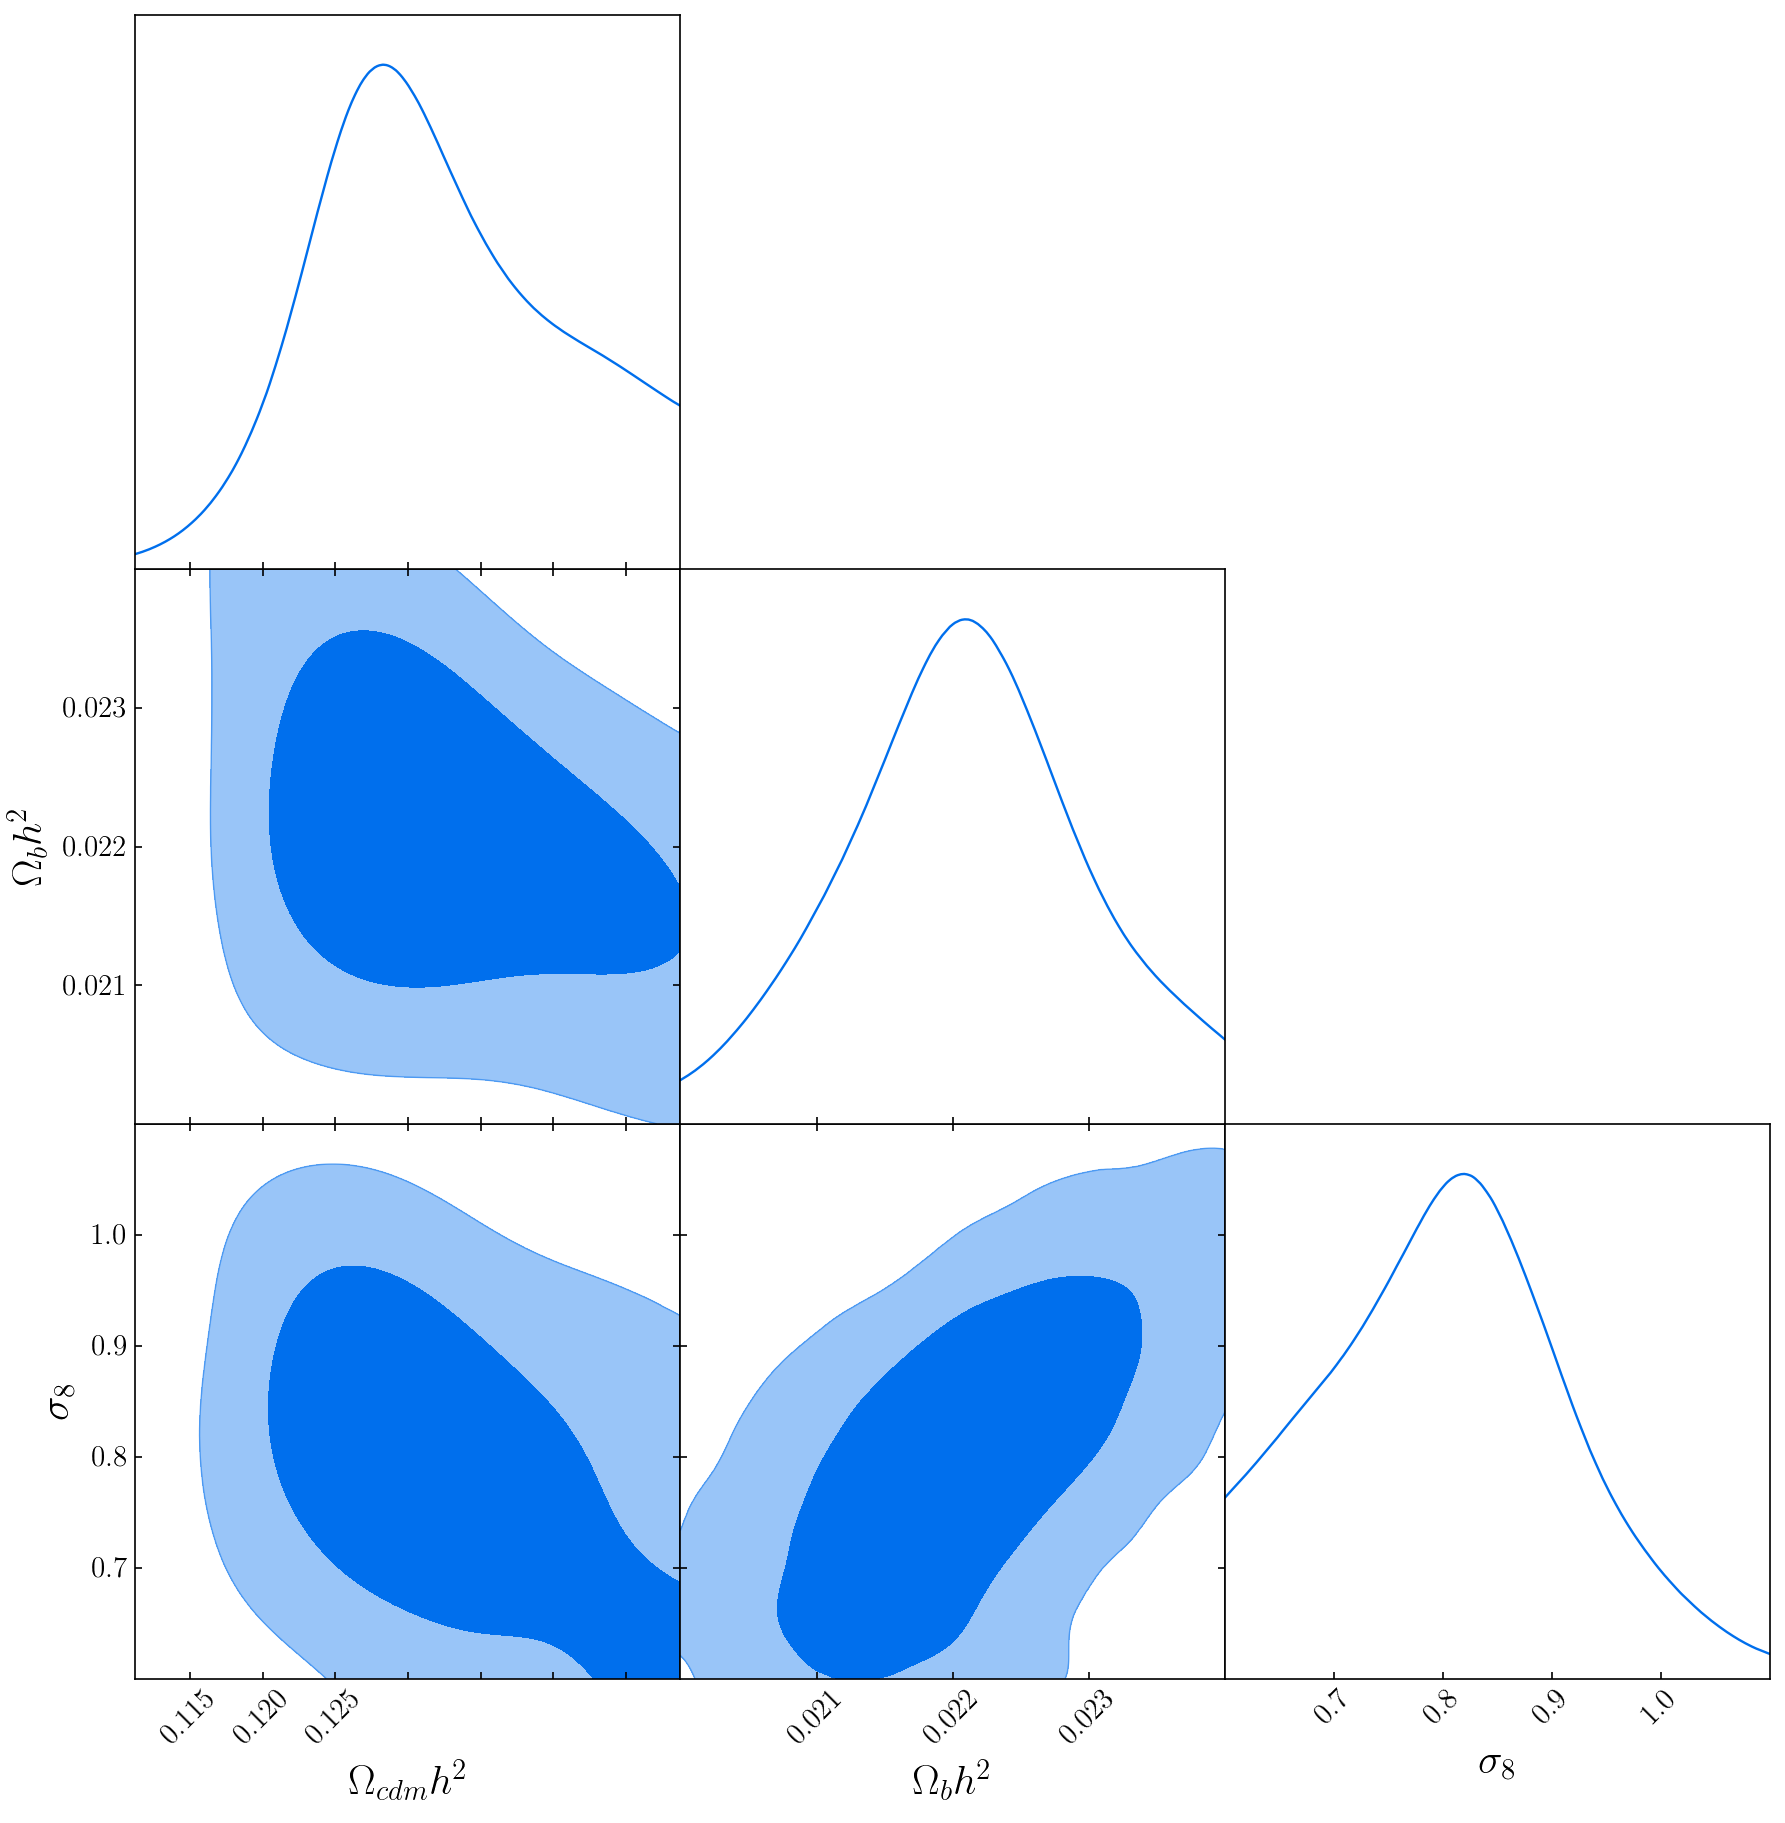

<Figure size 900x600 with 0 Axes>

In [21]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])
plt.savefig('posteriors_3params.png')

## Attempt 2

In [18]:
n_initial = 10 #200
n_batch = 20 #200
n_populations = 20 #20

Sampling approximate posterior...
Done.
Removed no burn in


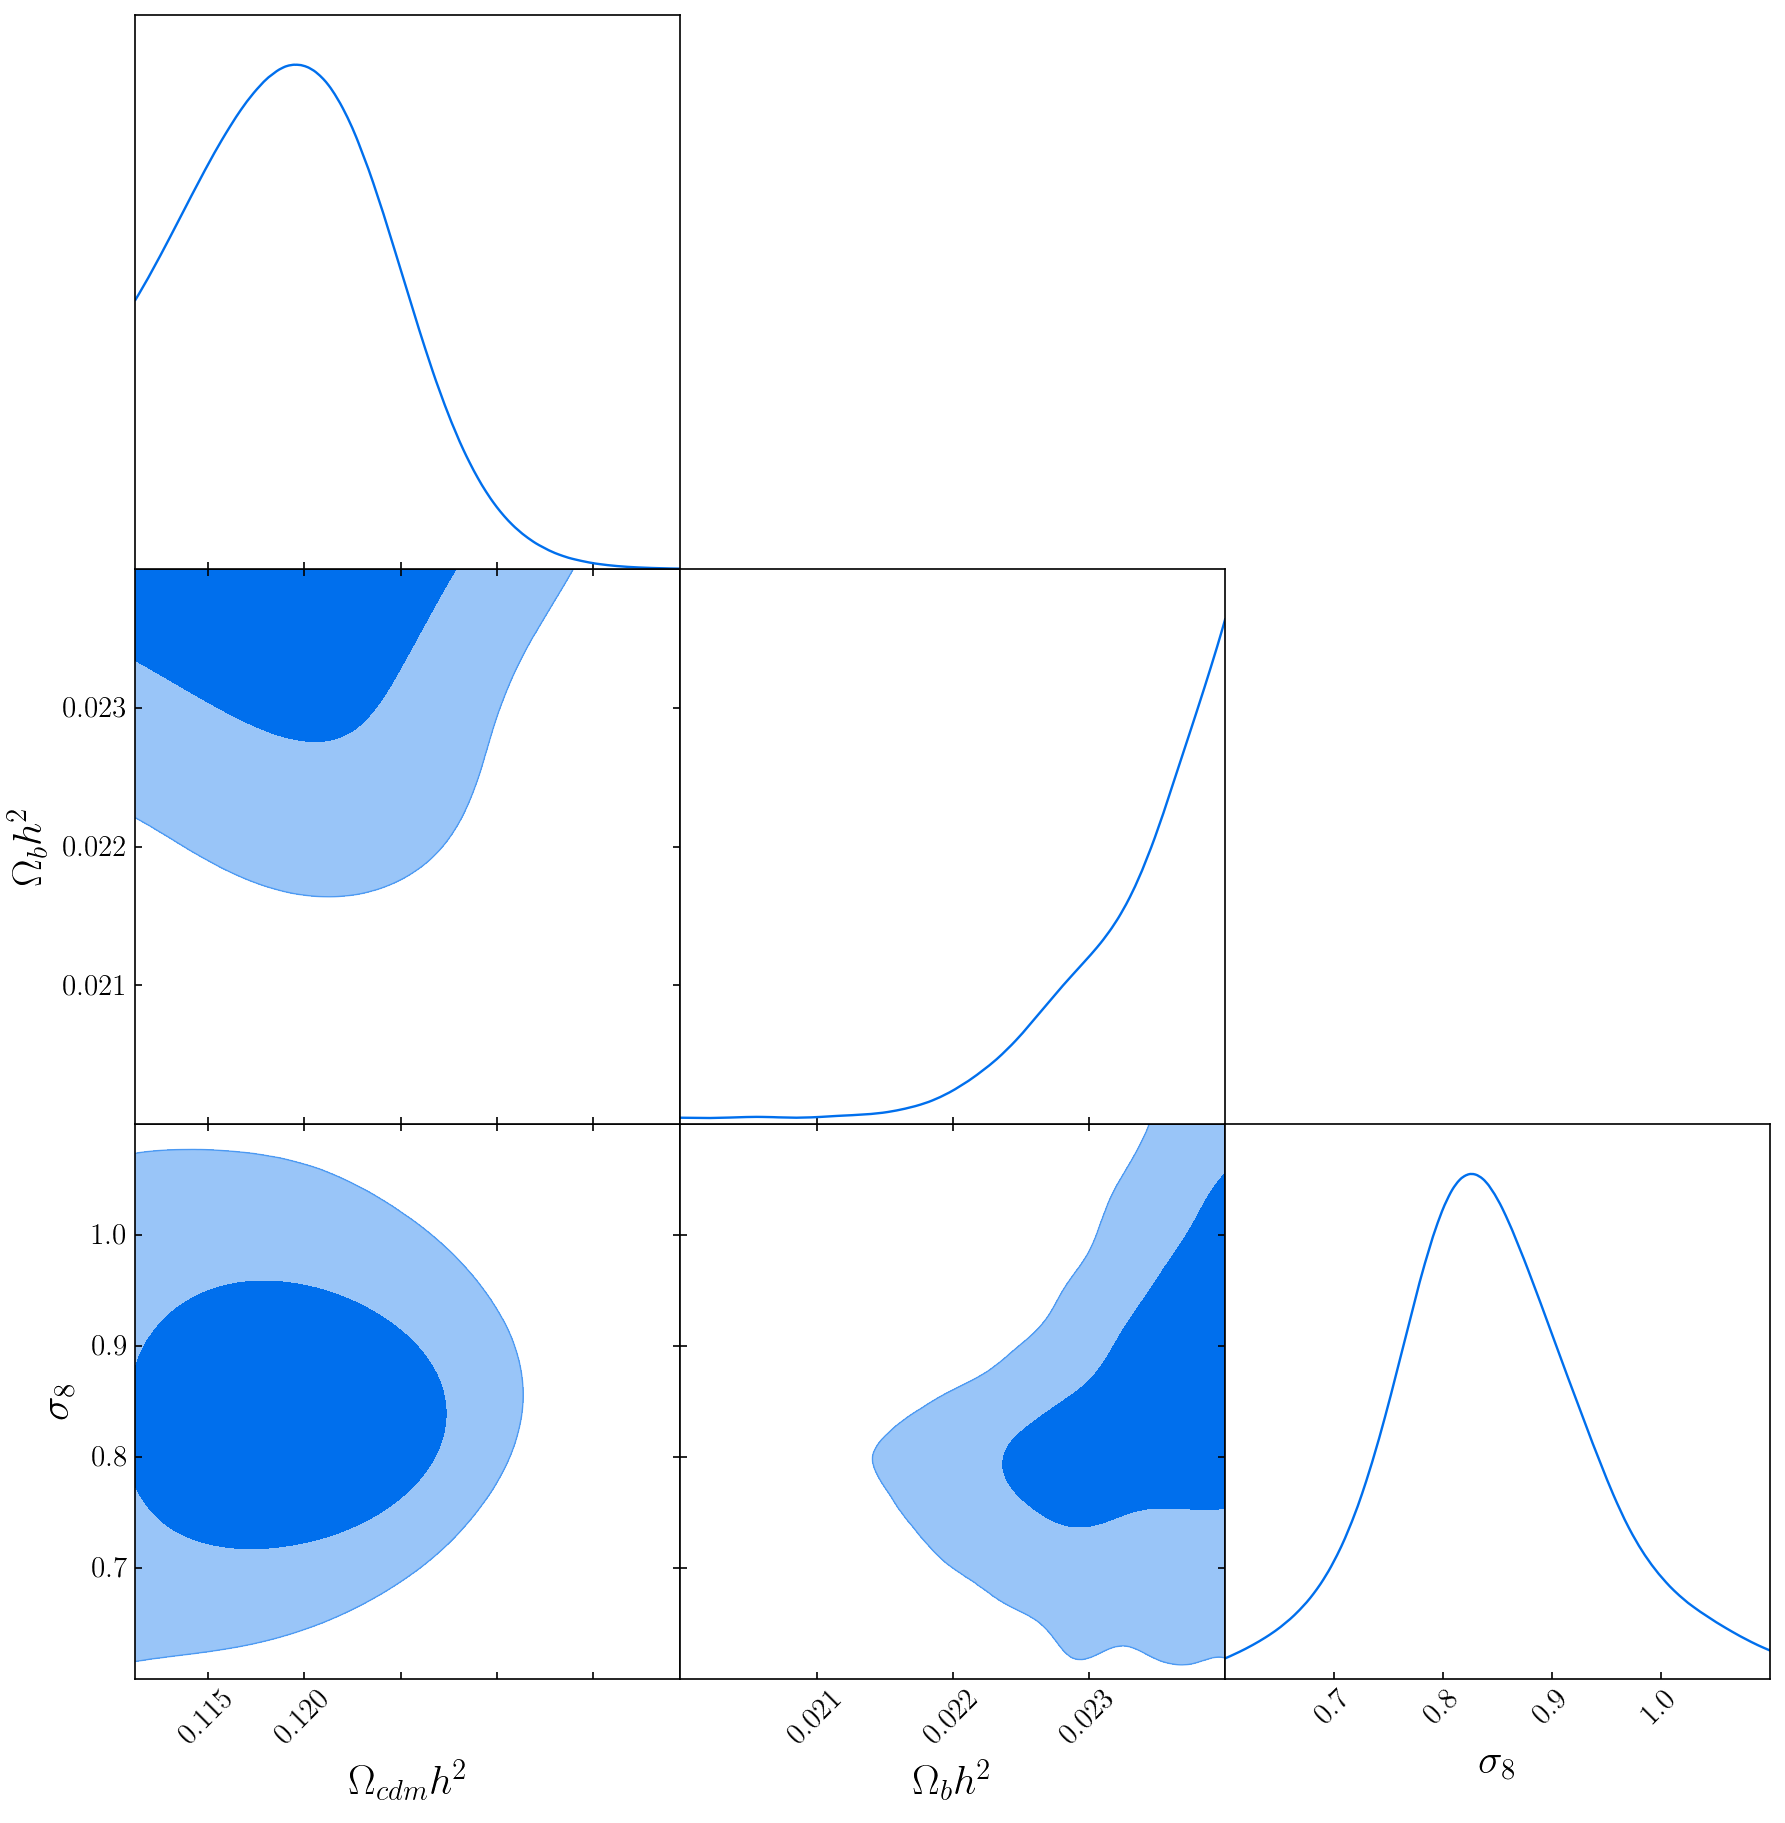

Population 1/20
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


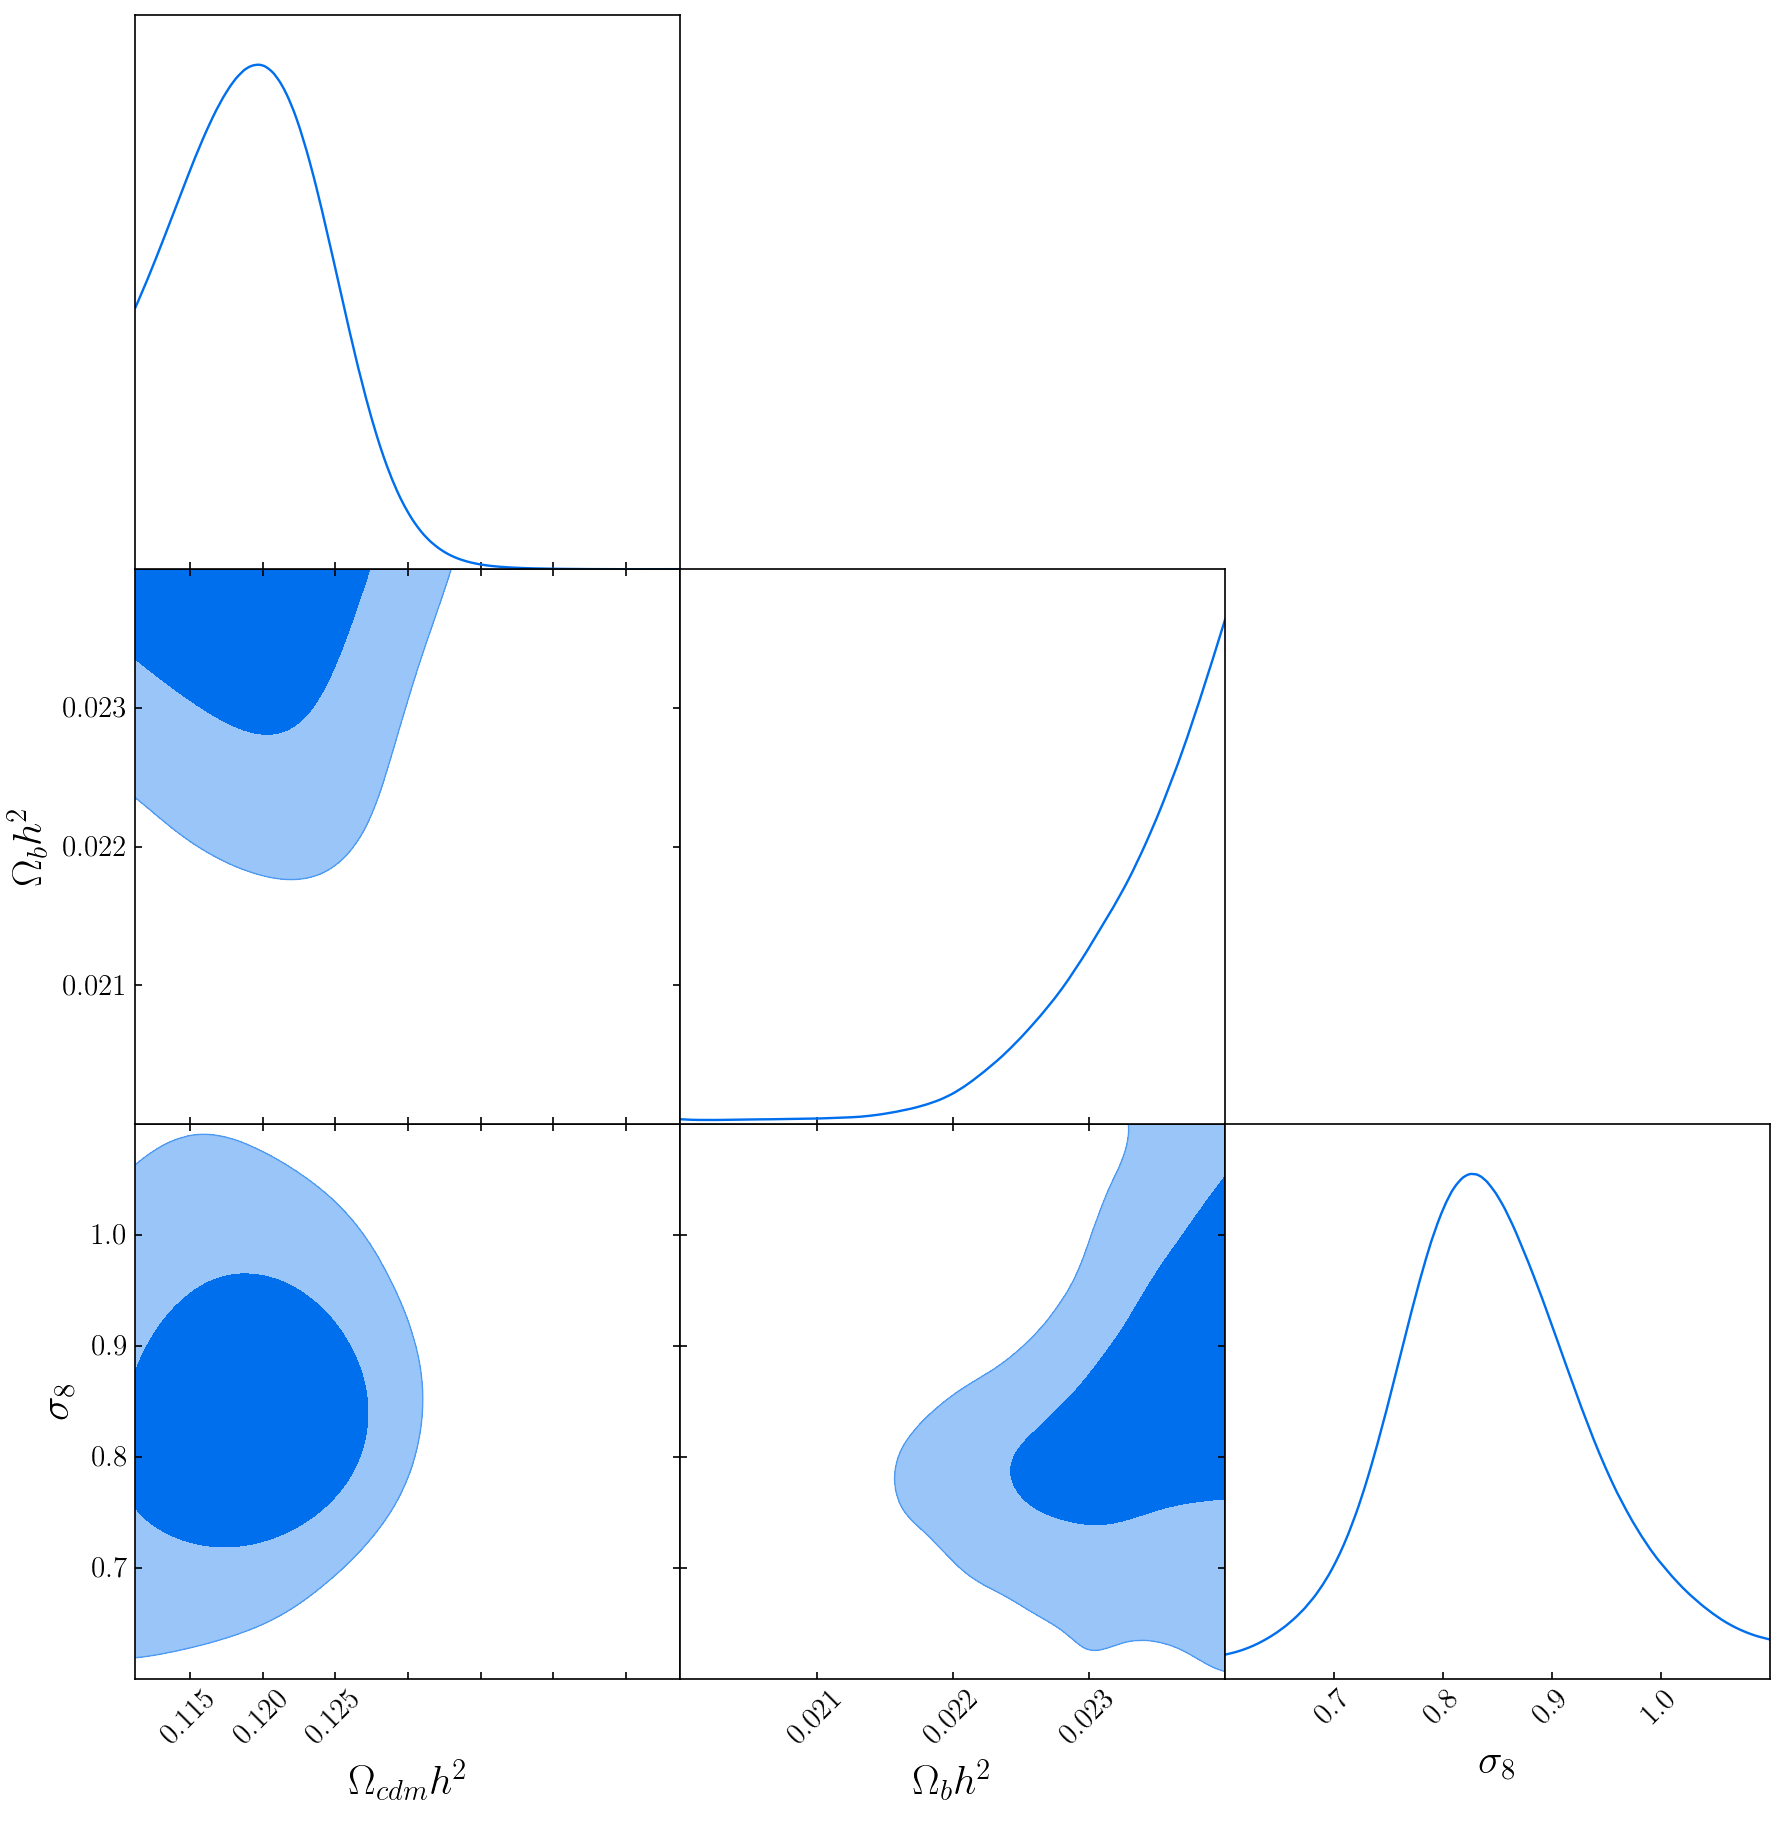

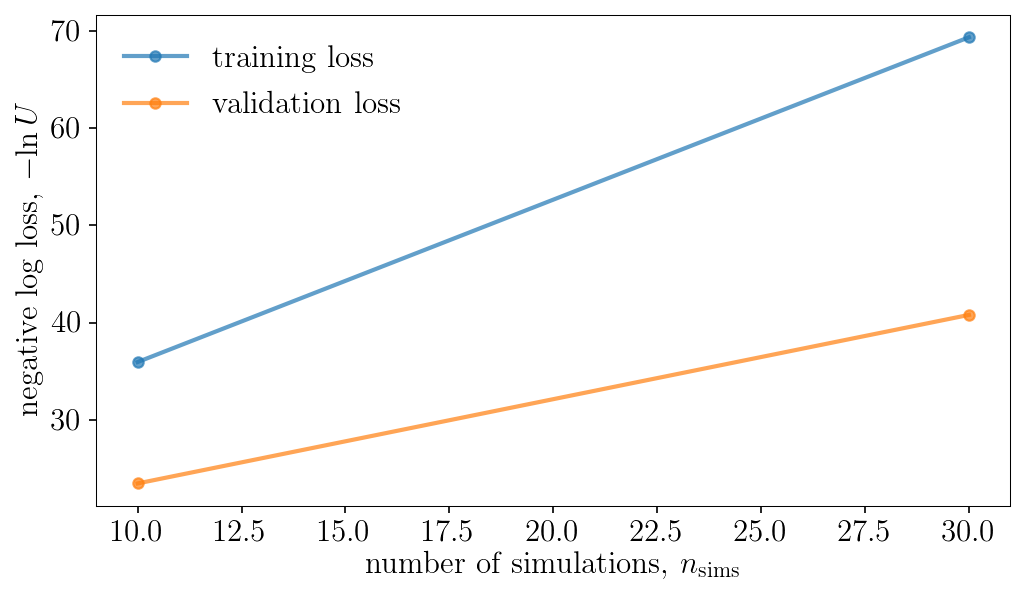

Population 2/20
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


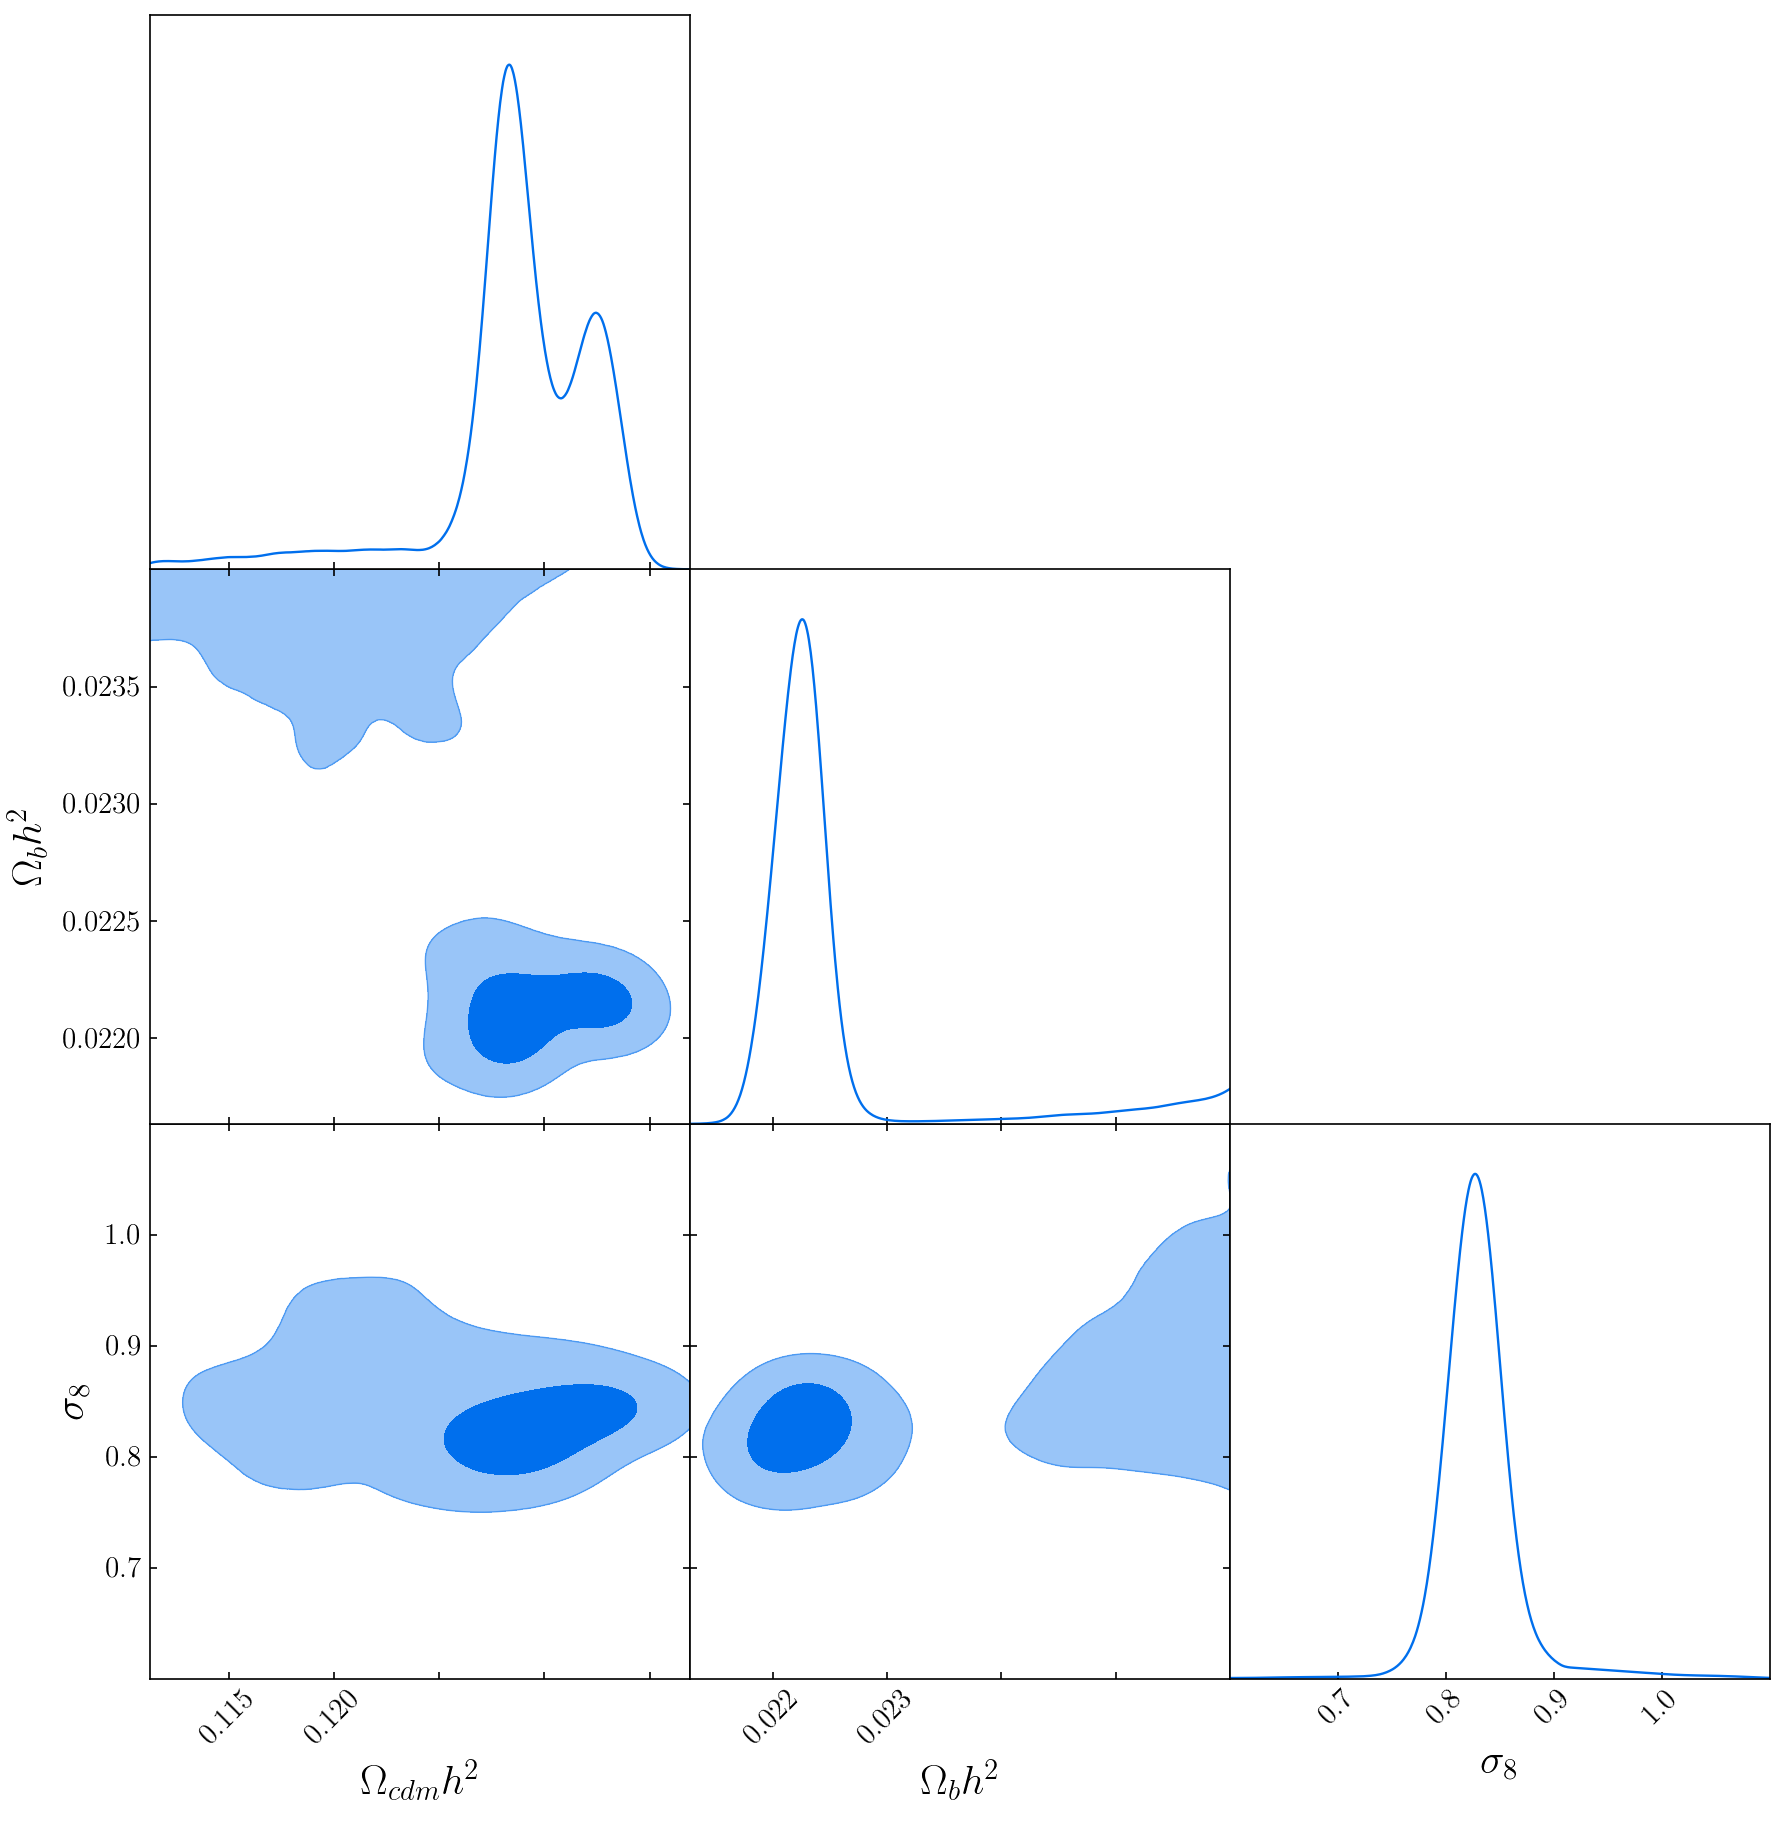

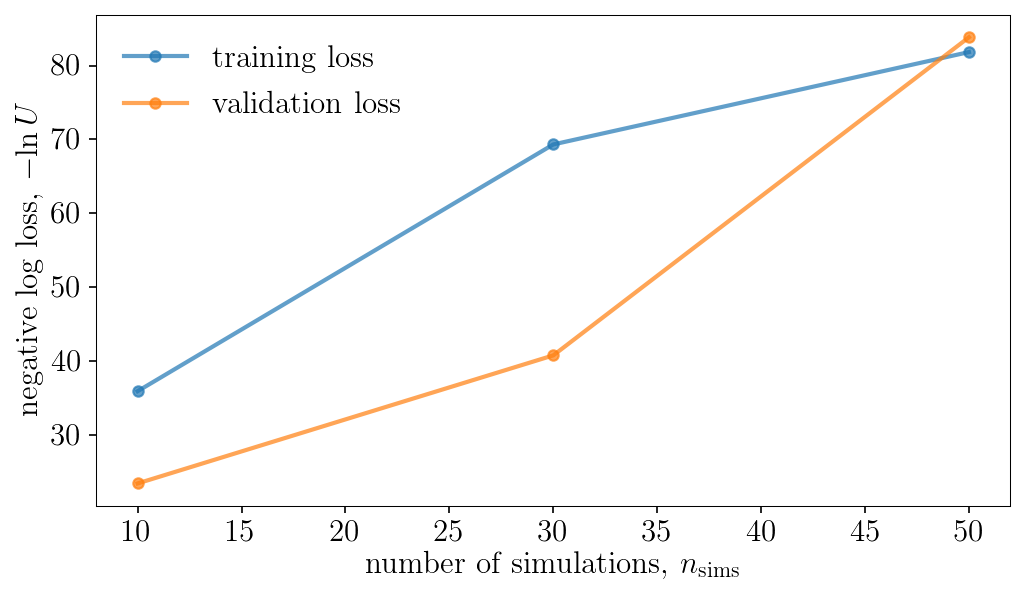

Population 3/20
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


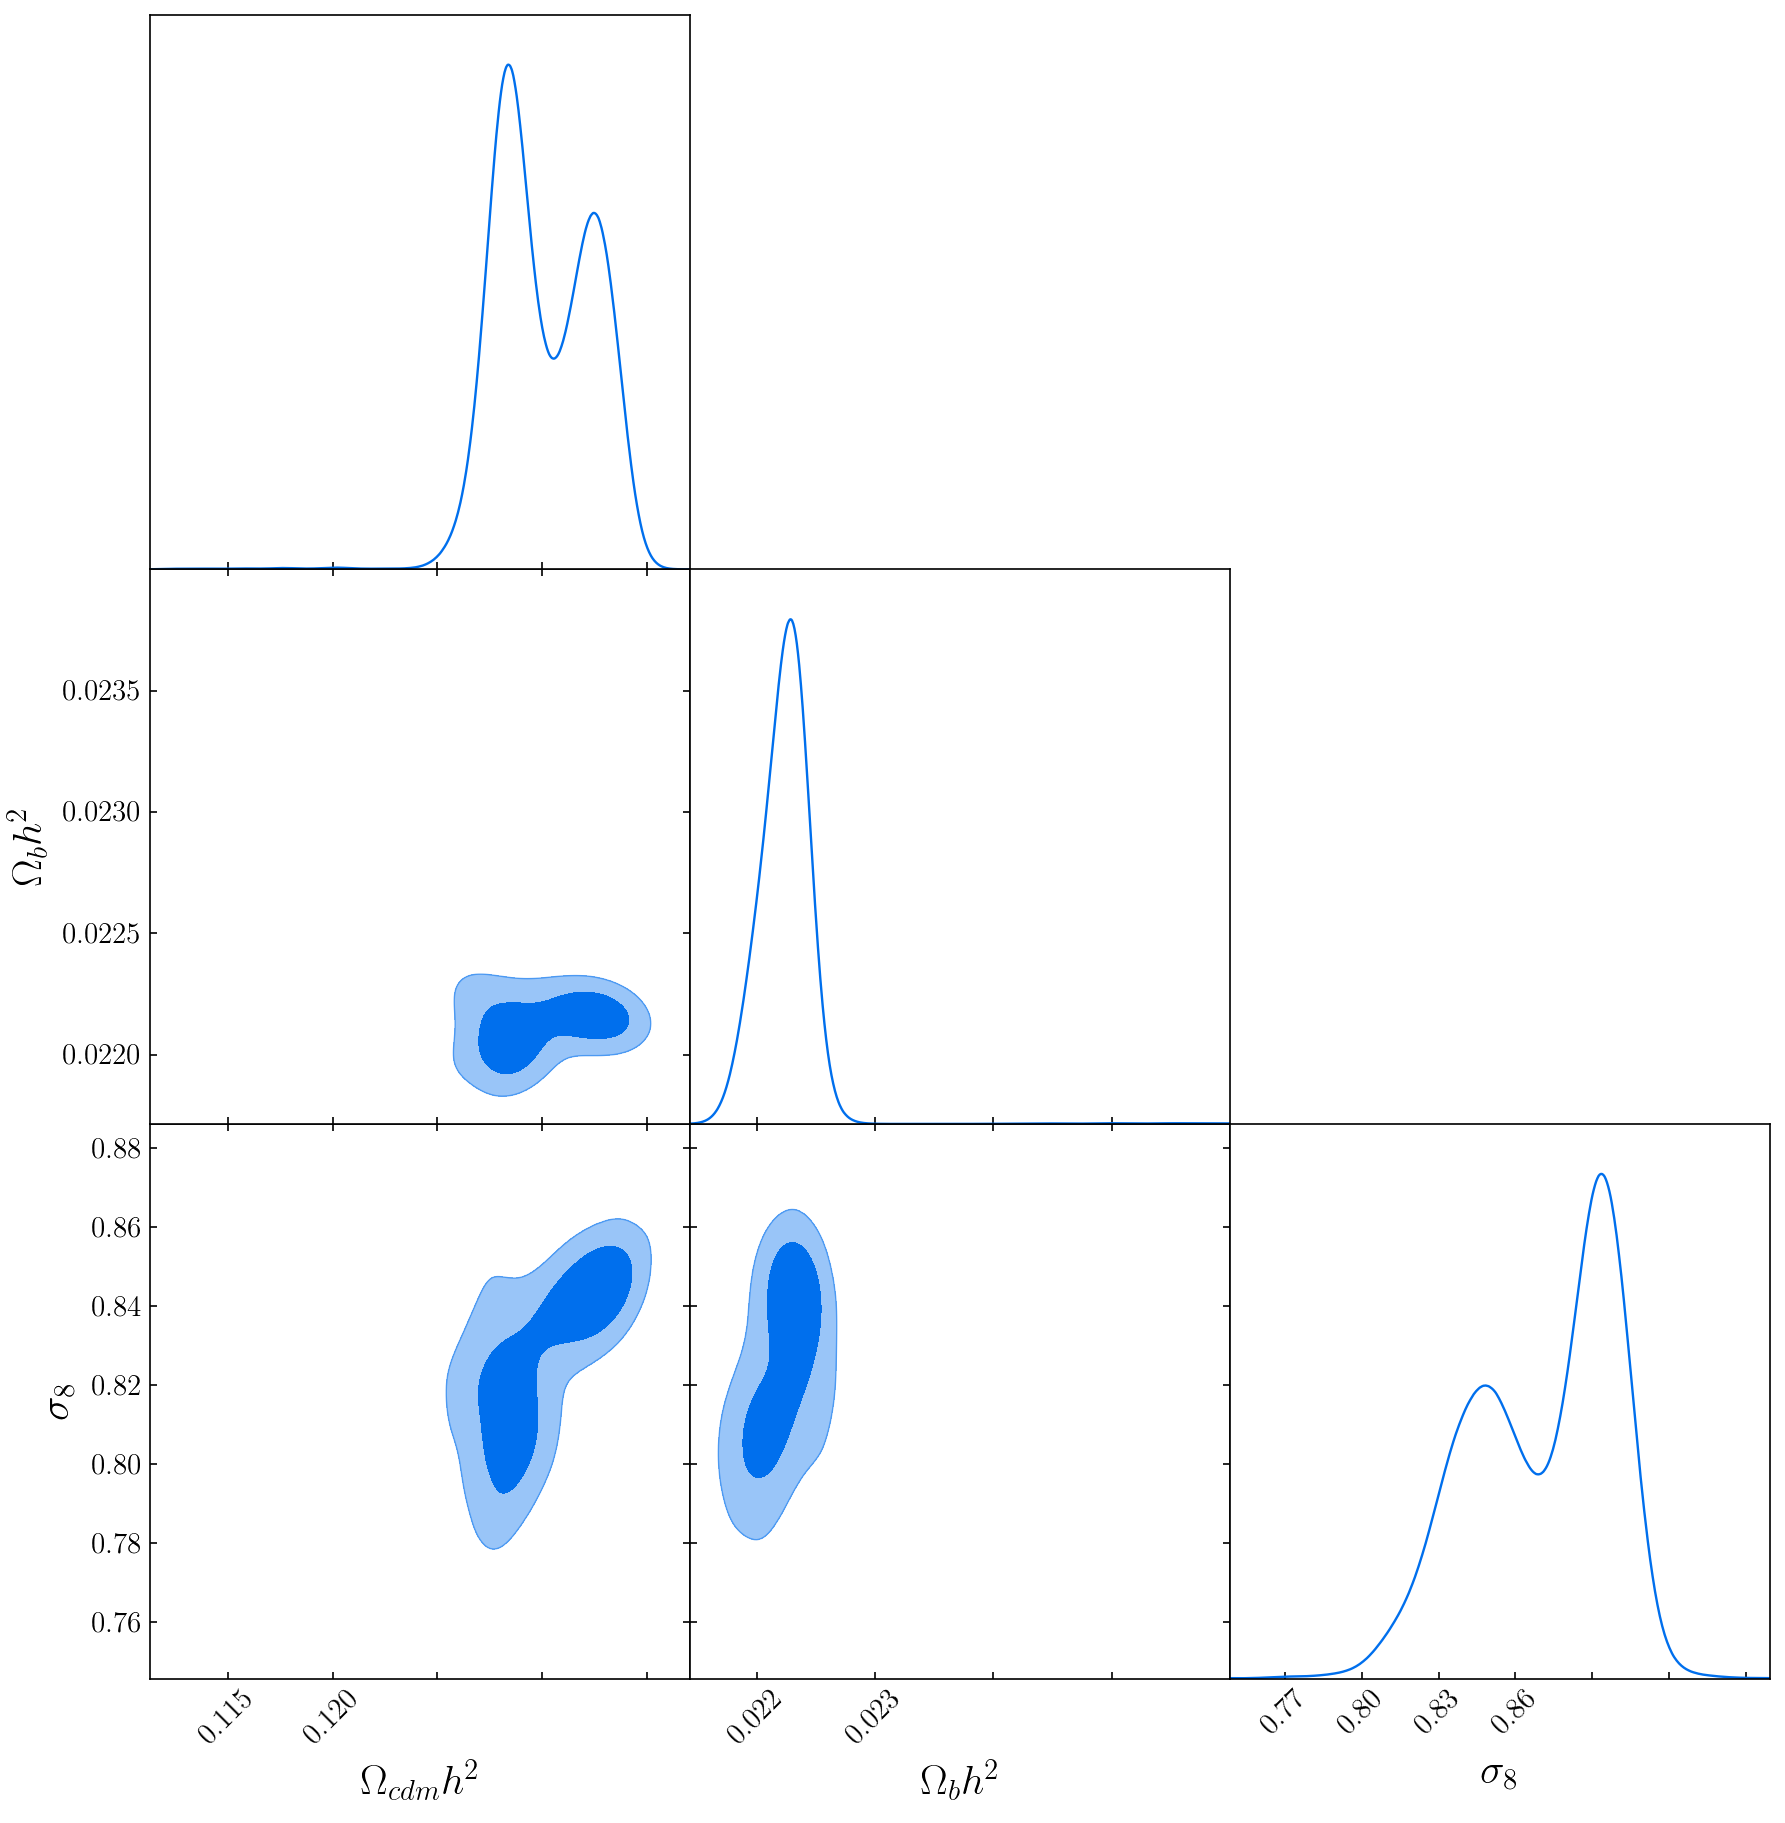

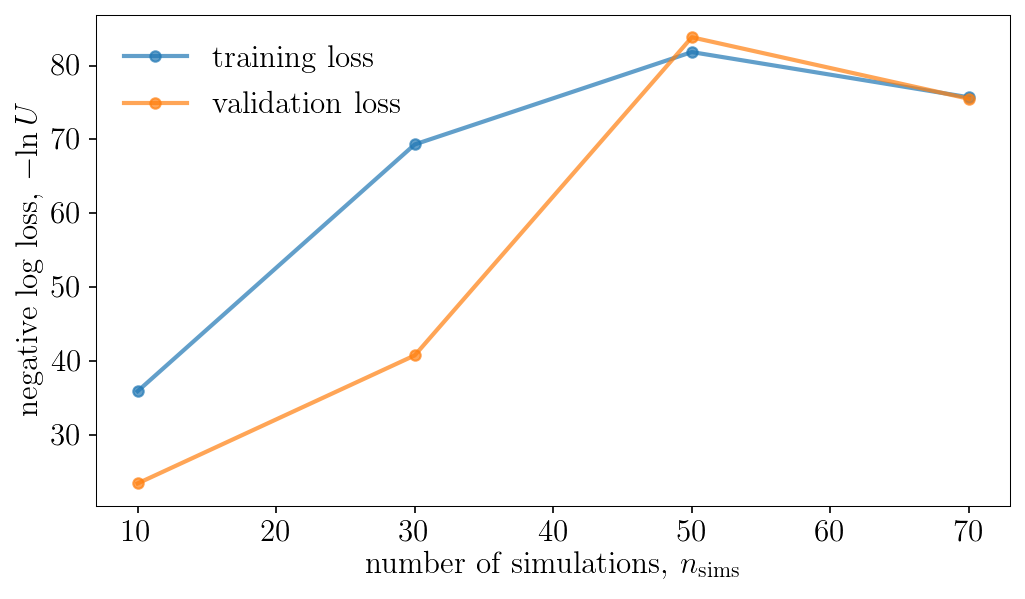

Population 4/20
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


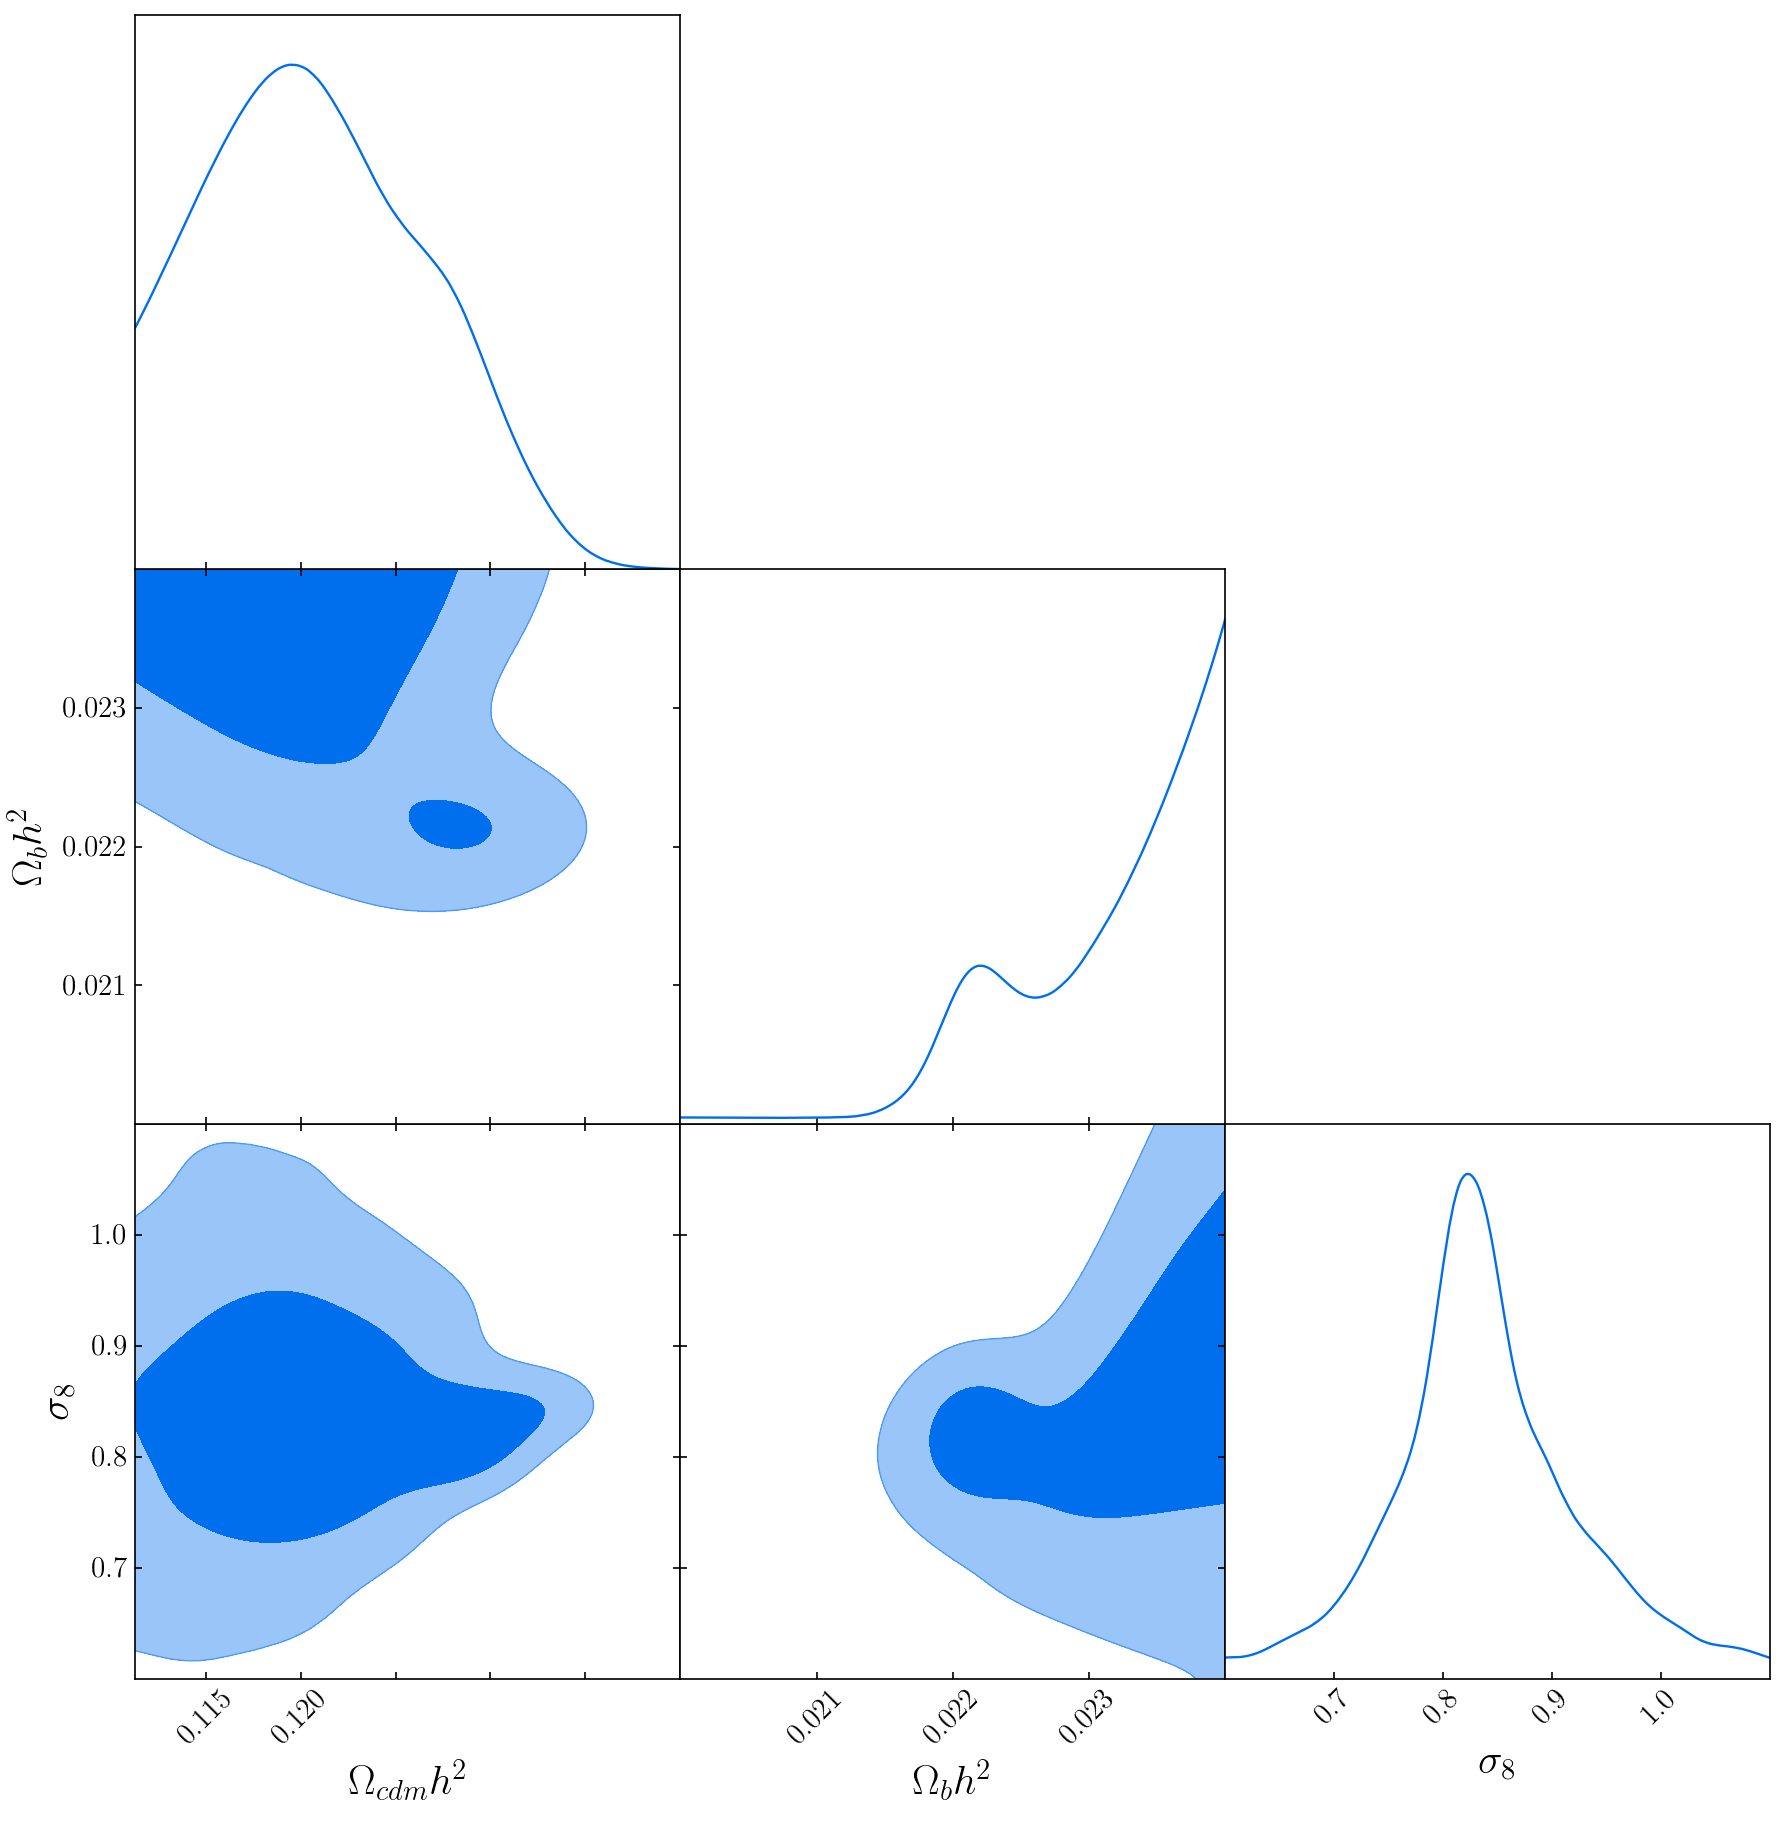

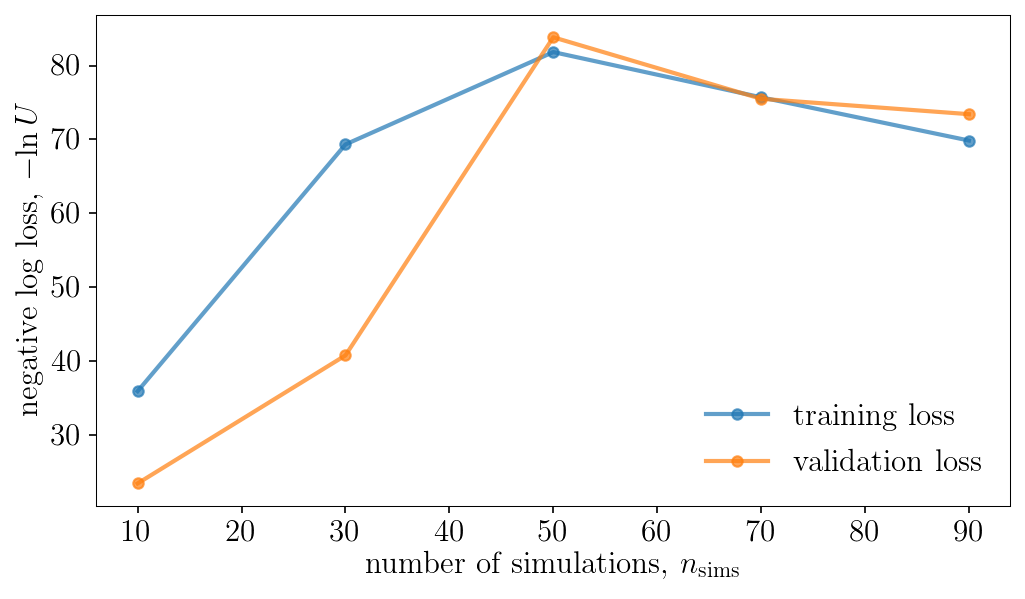

Population 5/20
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


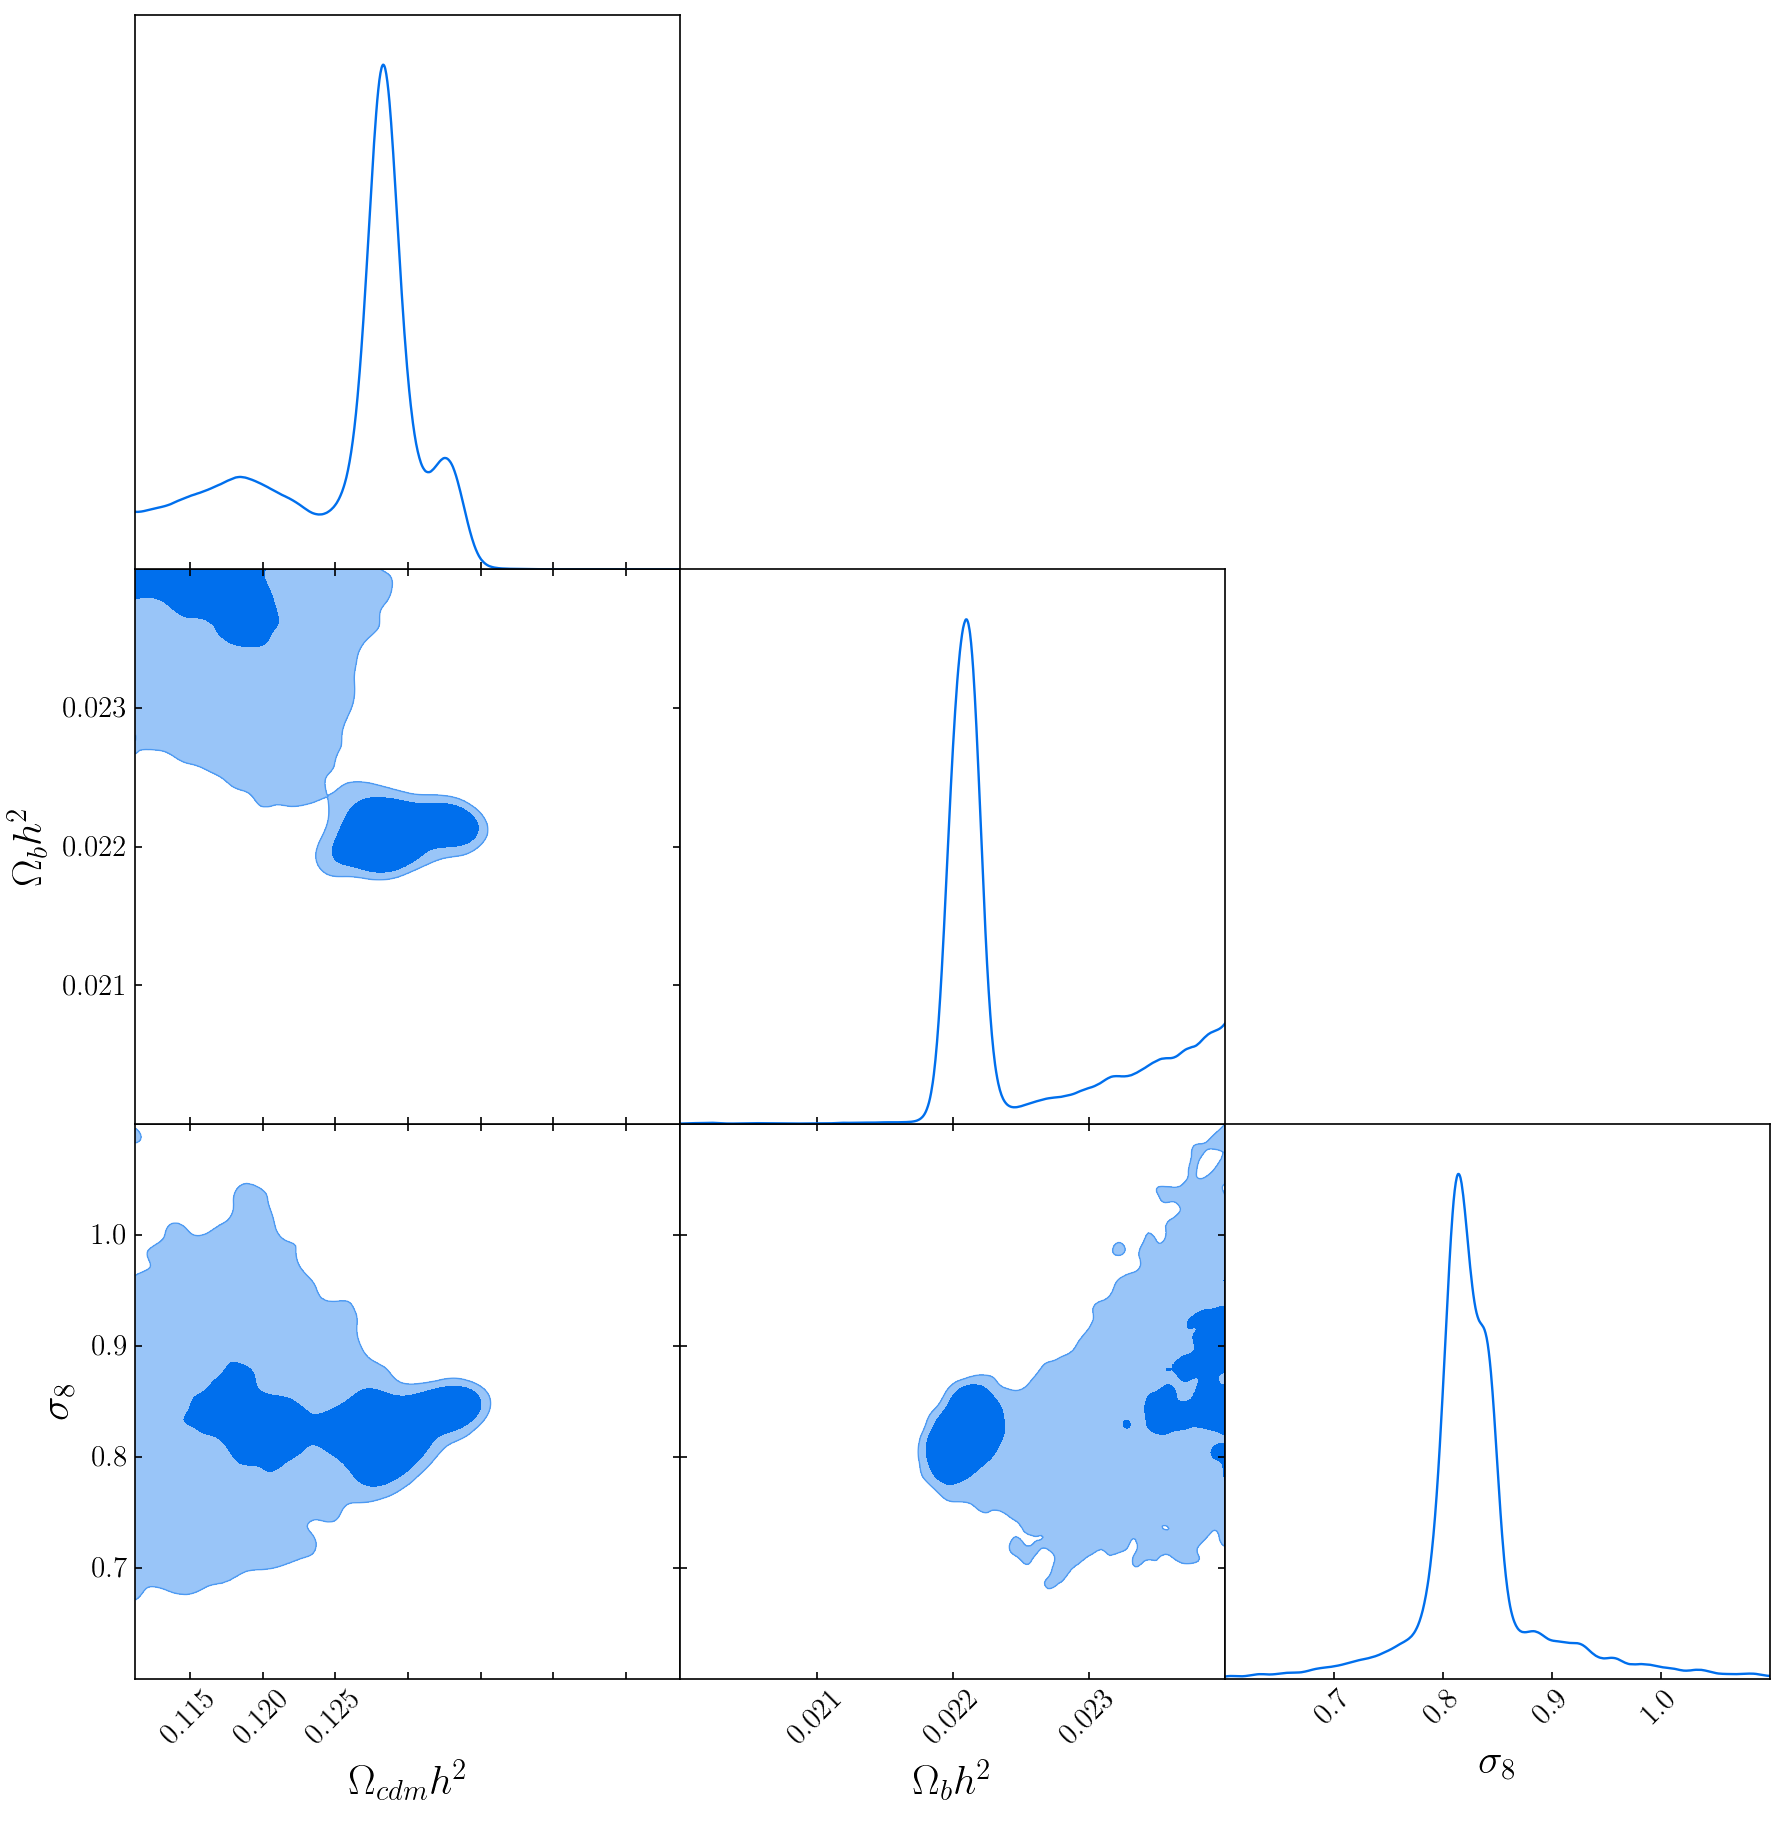

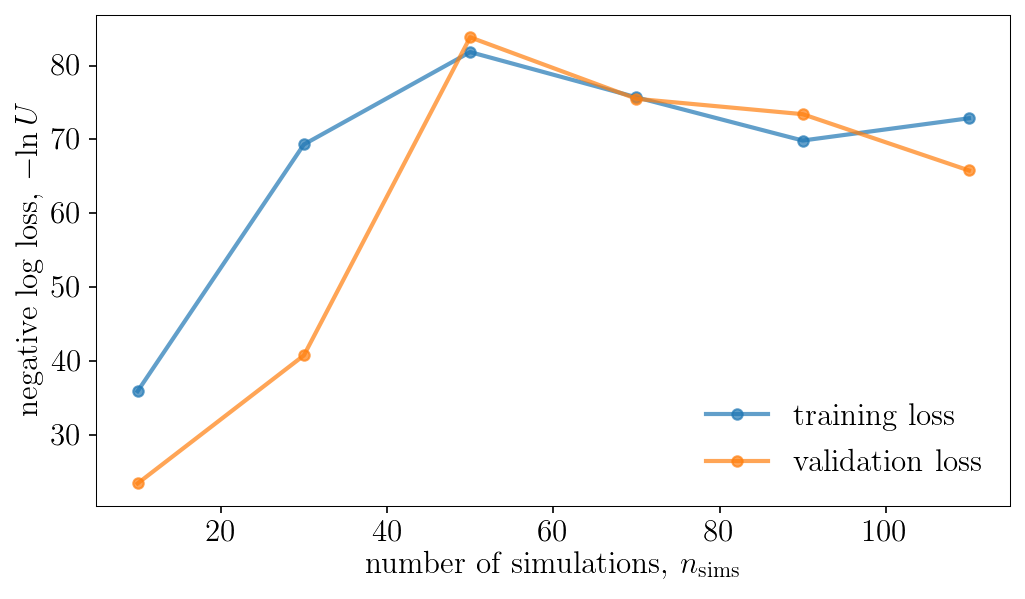

Population 6/20
Sampling proposal density...
Done.


Sampling approximate posterior...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.
Removed no burn in


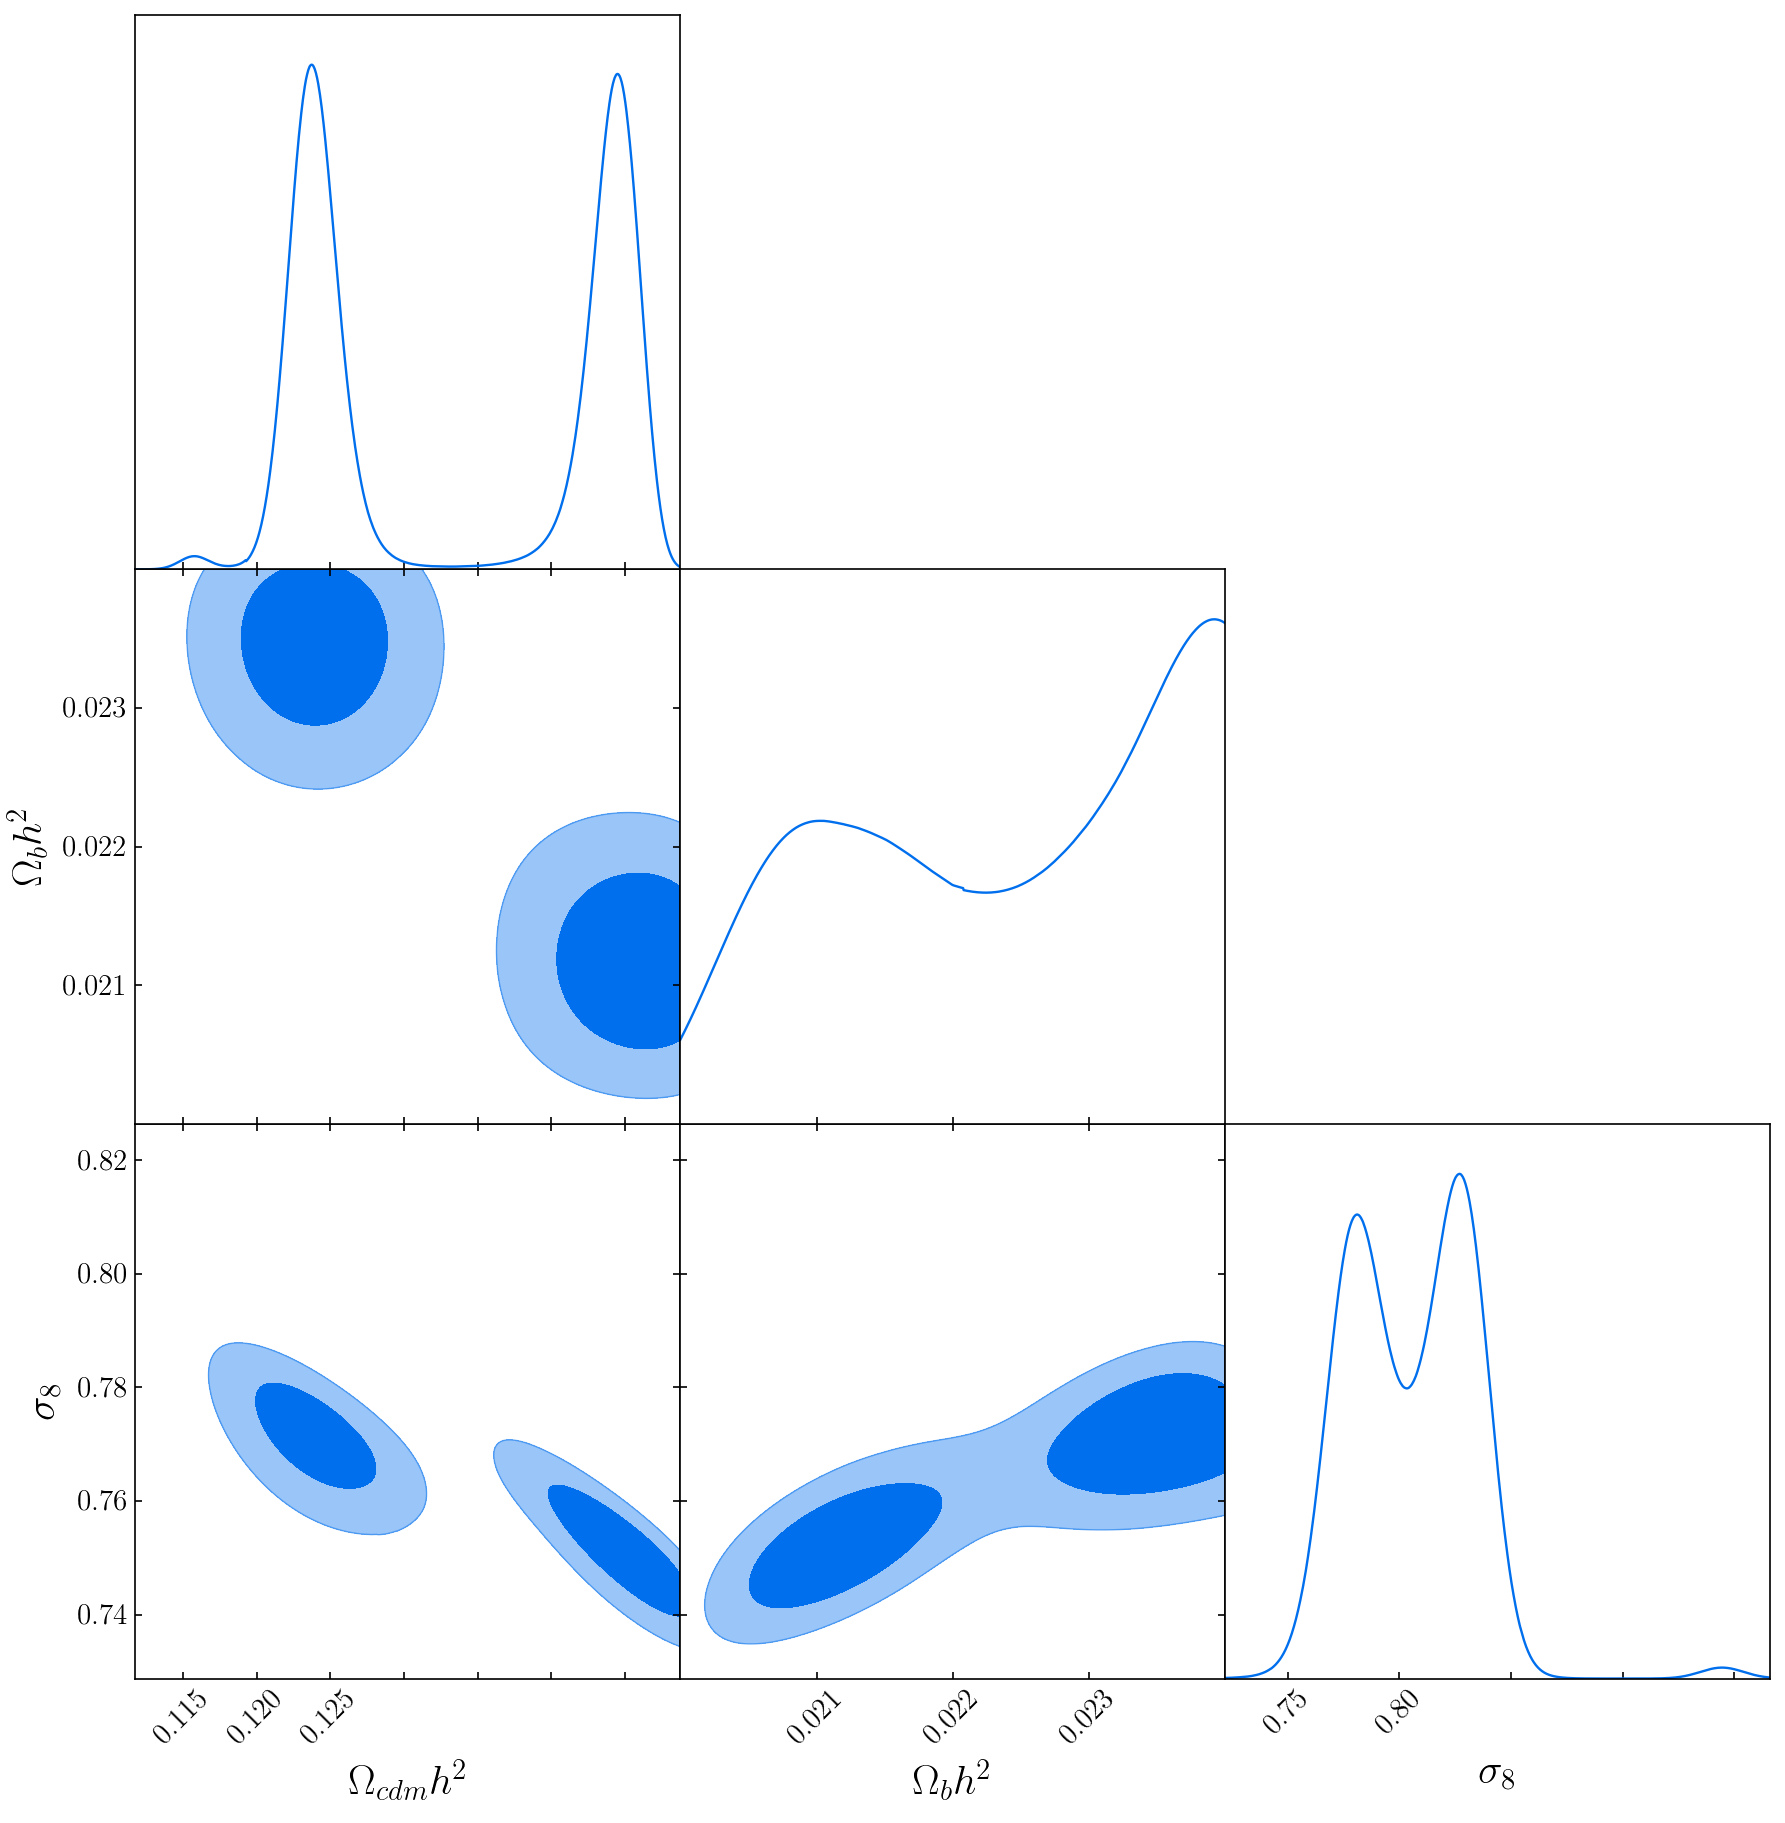

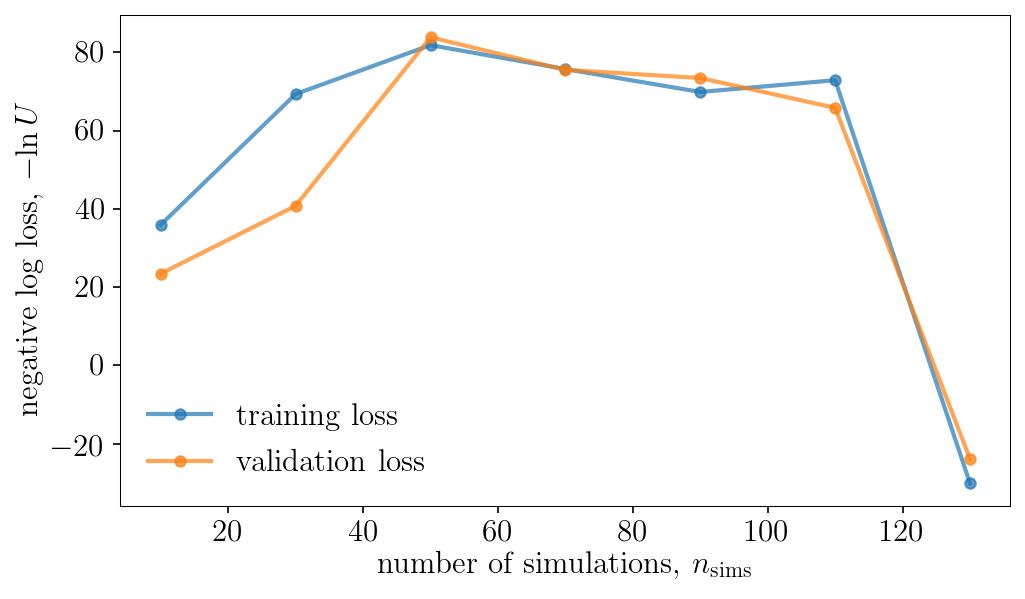

Population 7/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


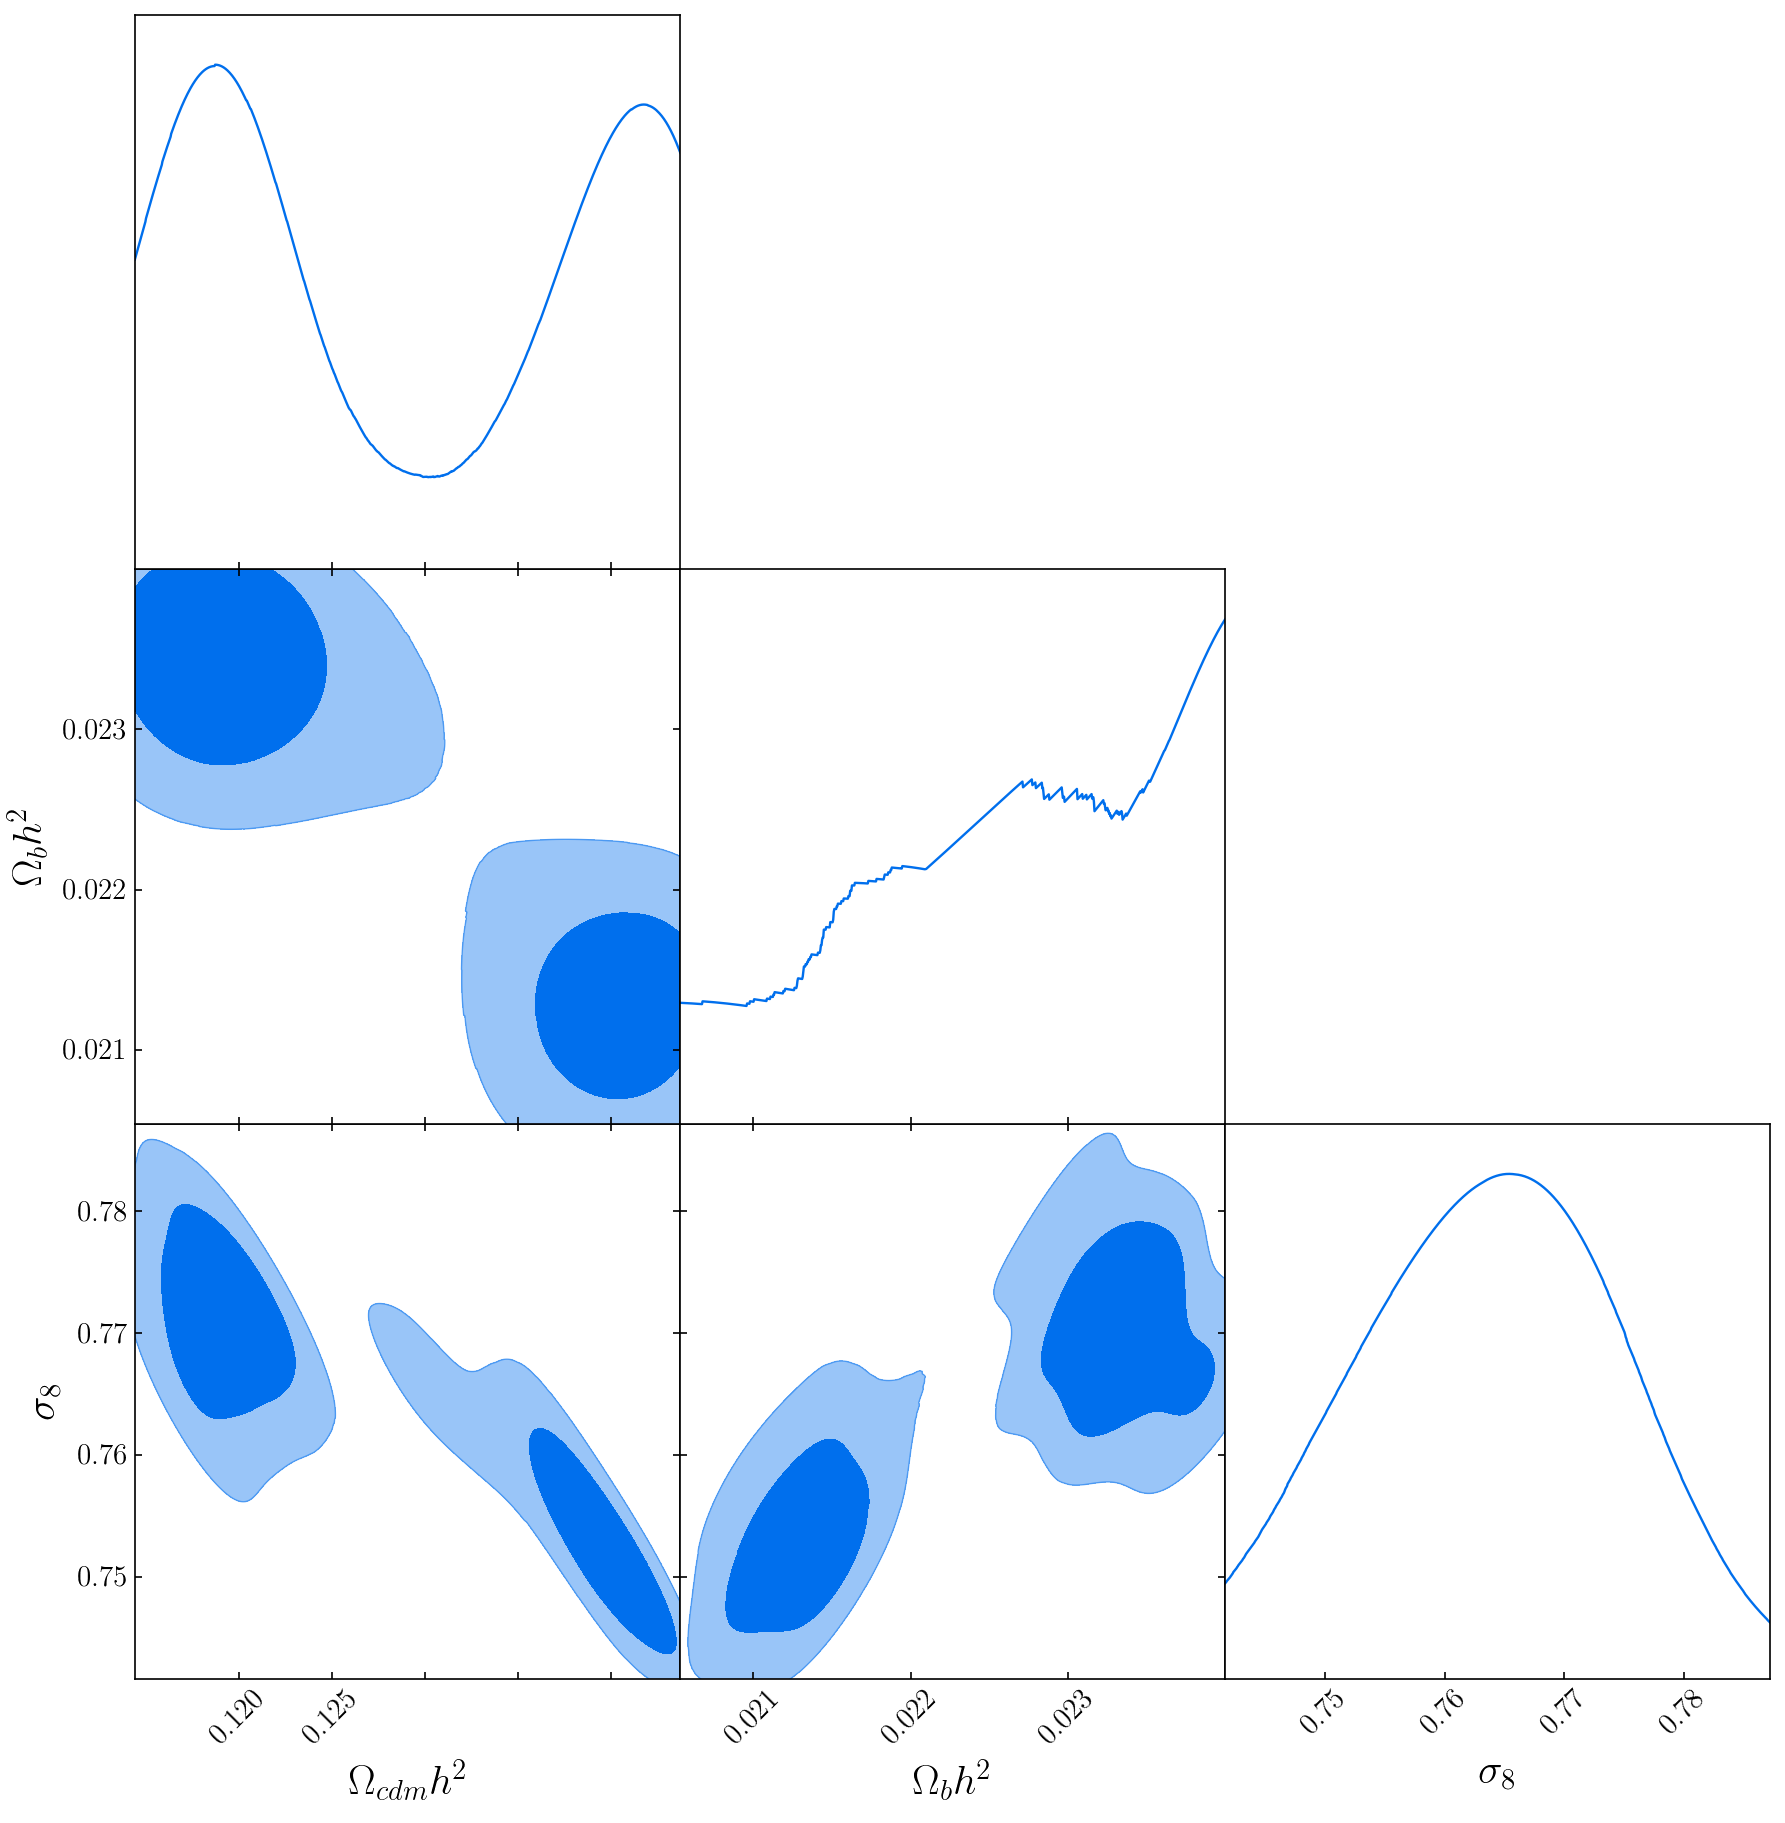

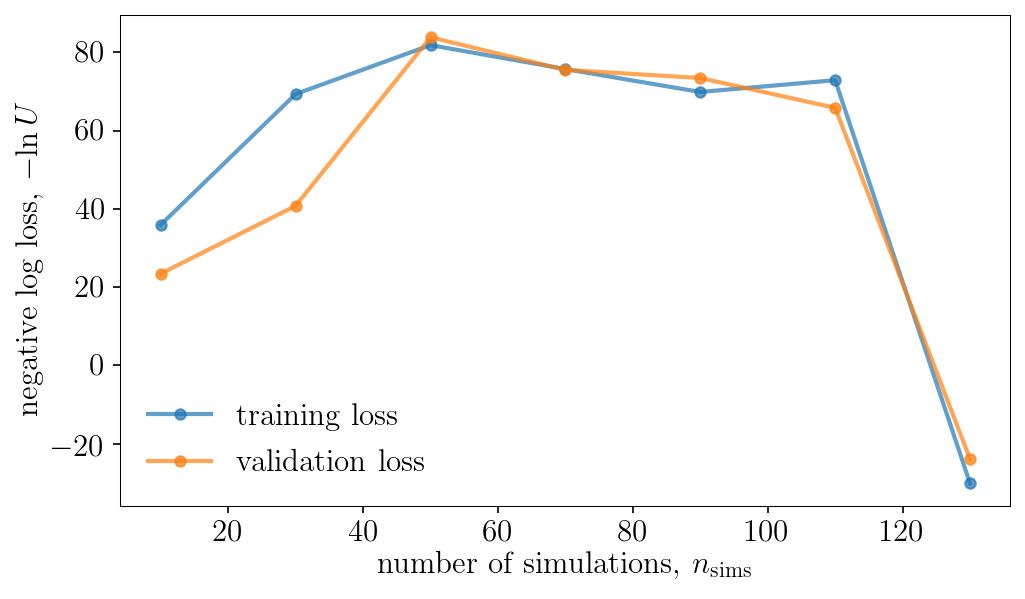

Population 8/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


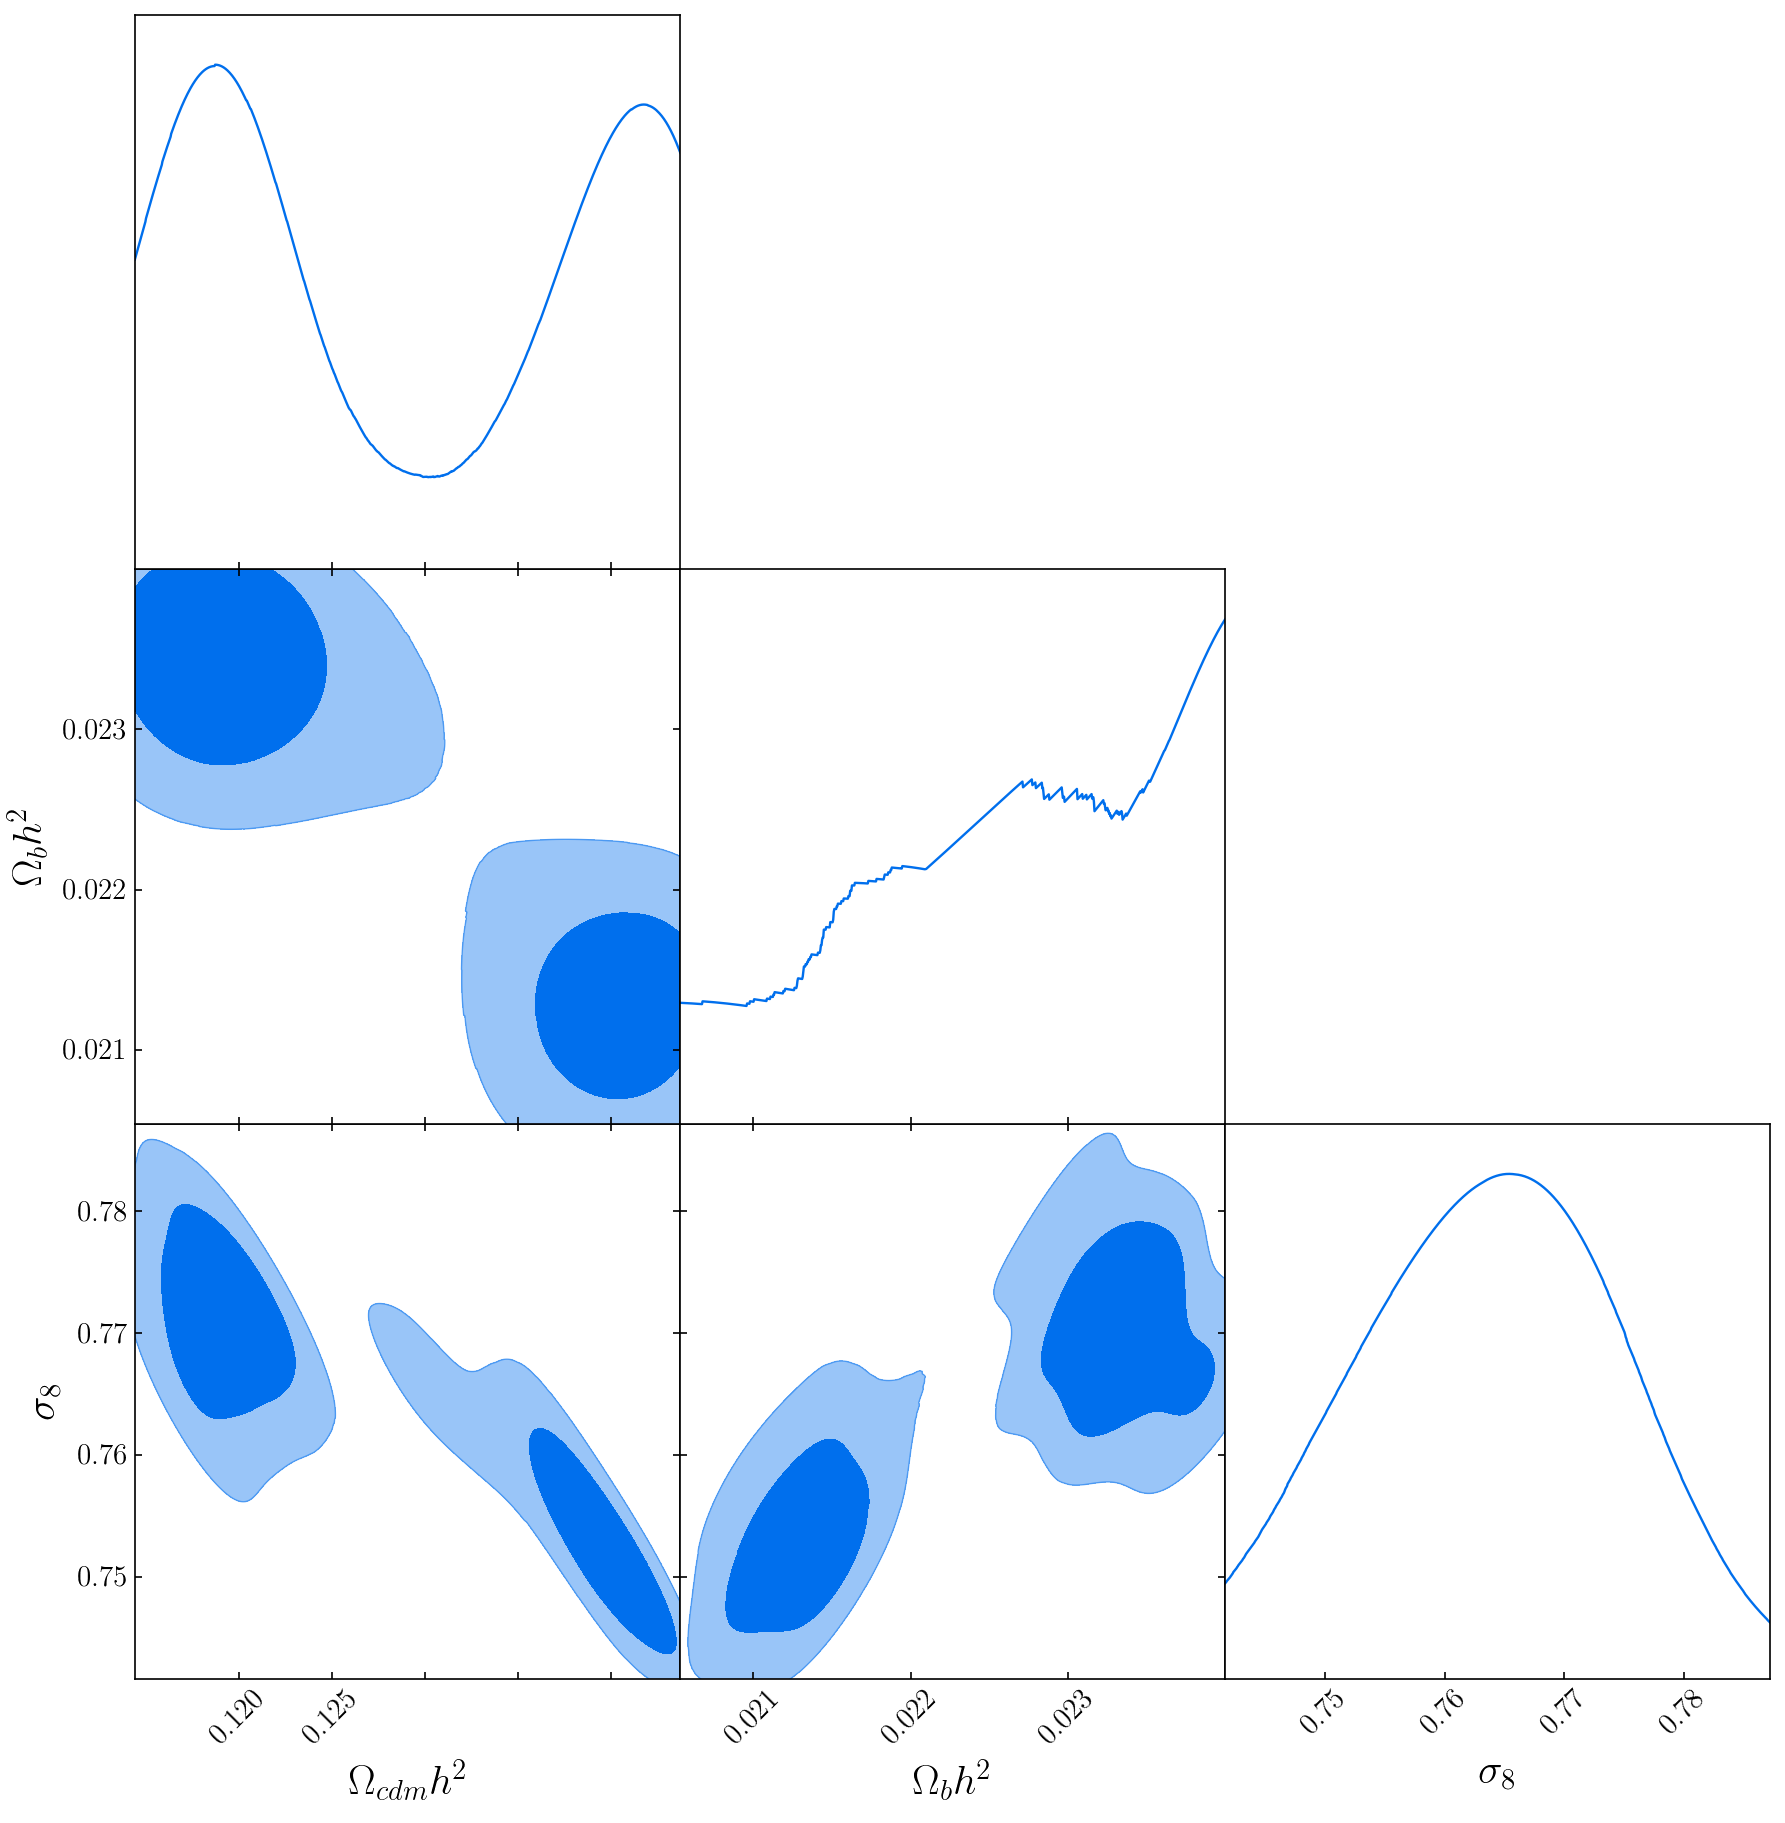

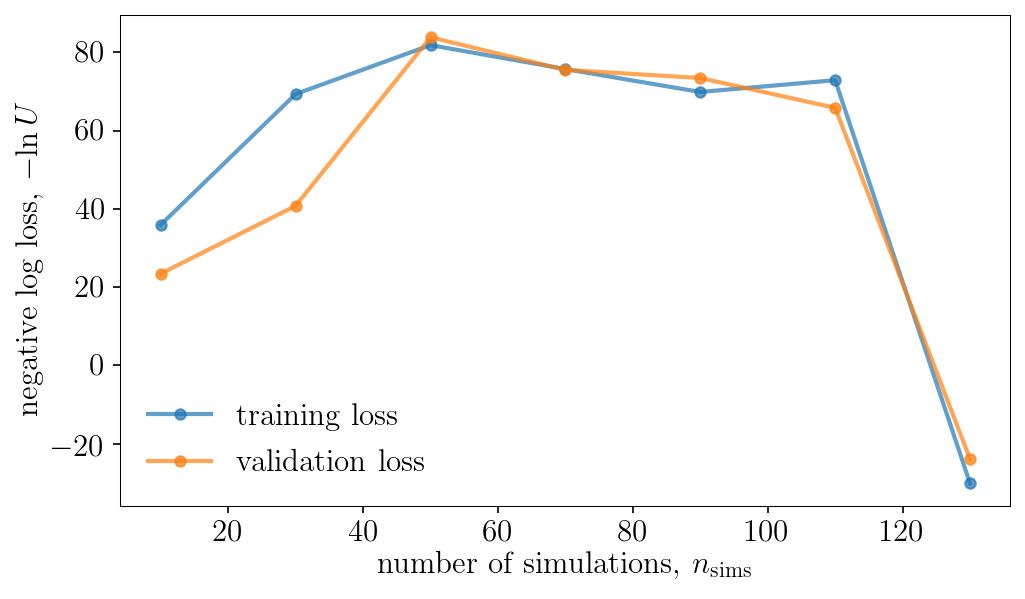

Population 9/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


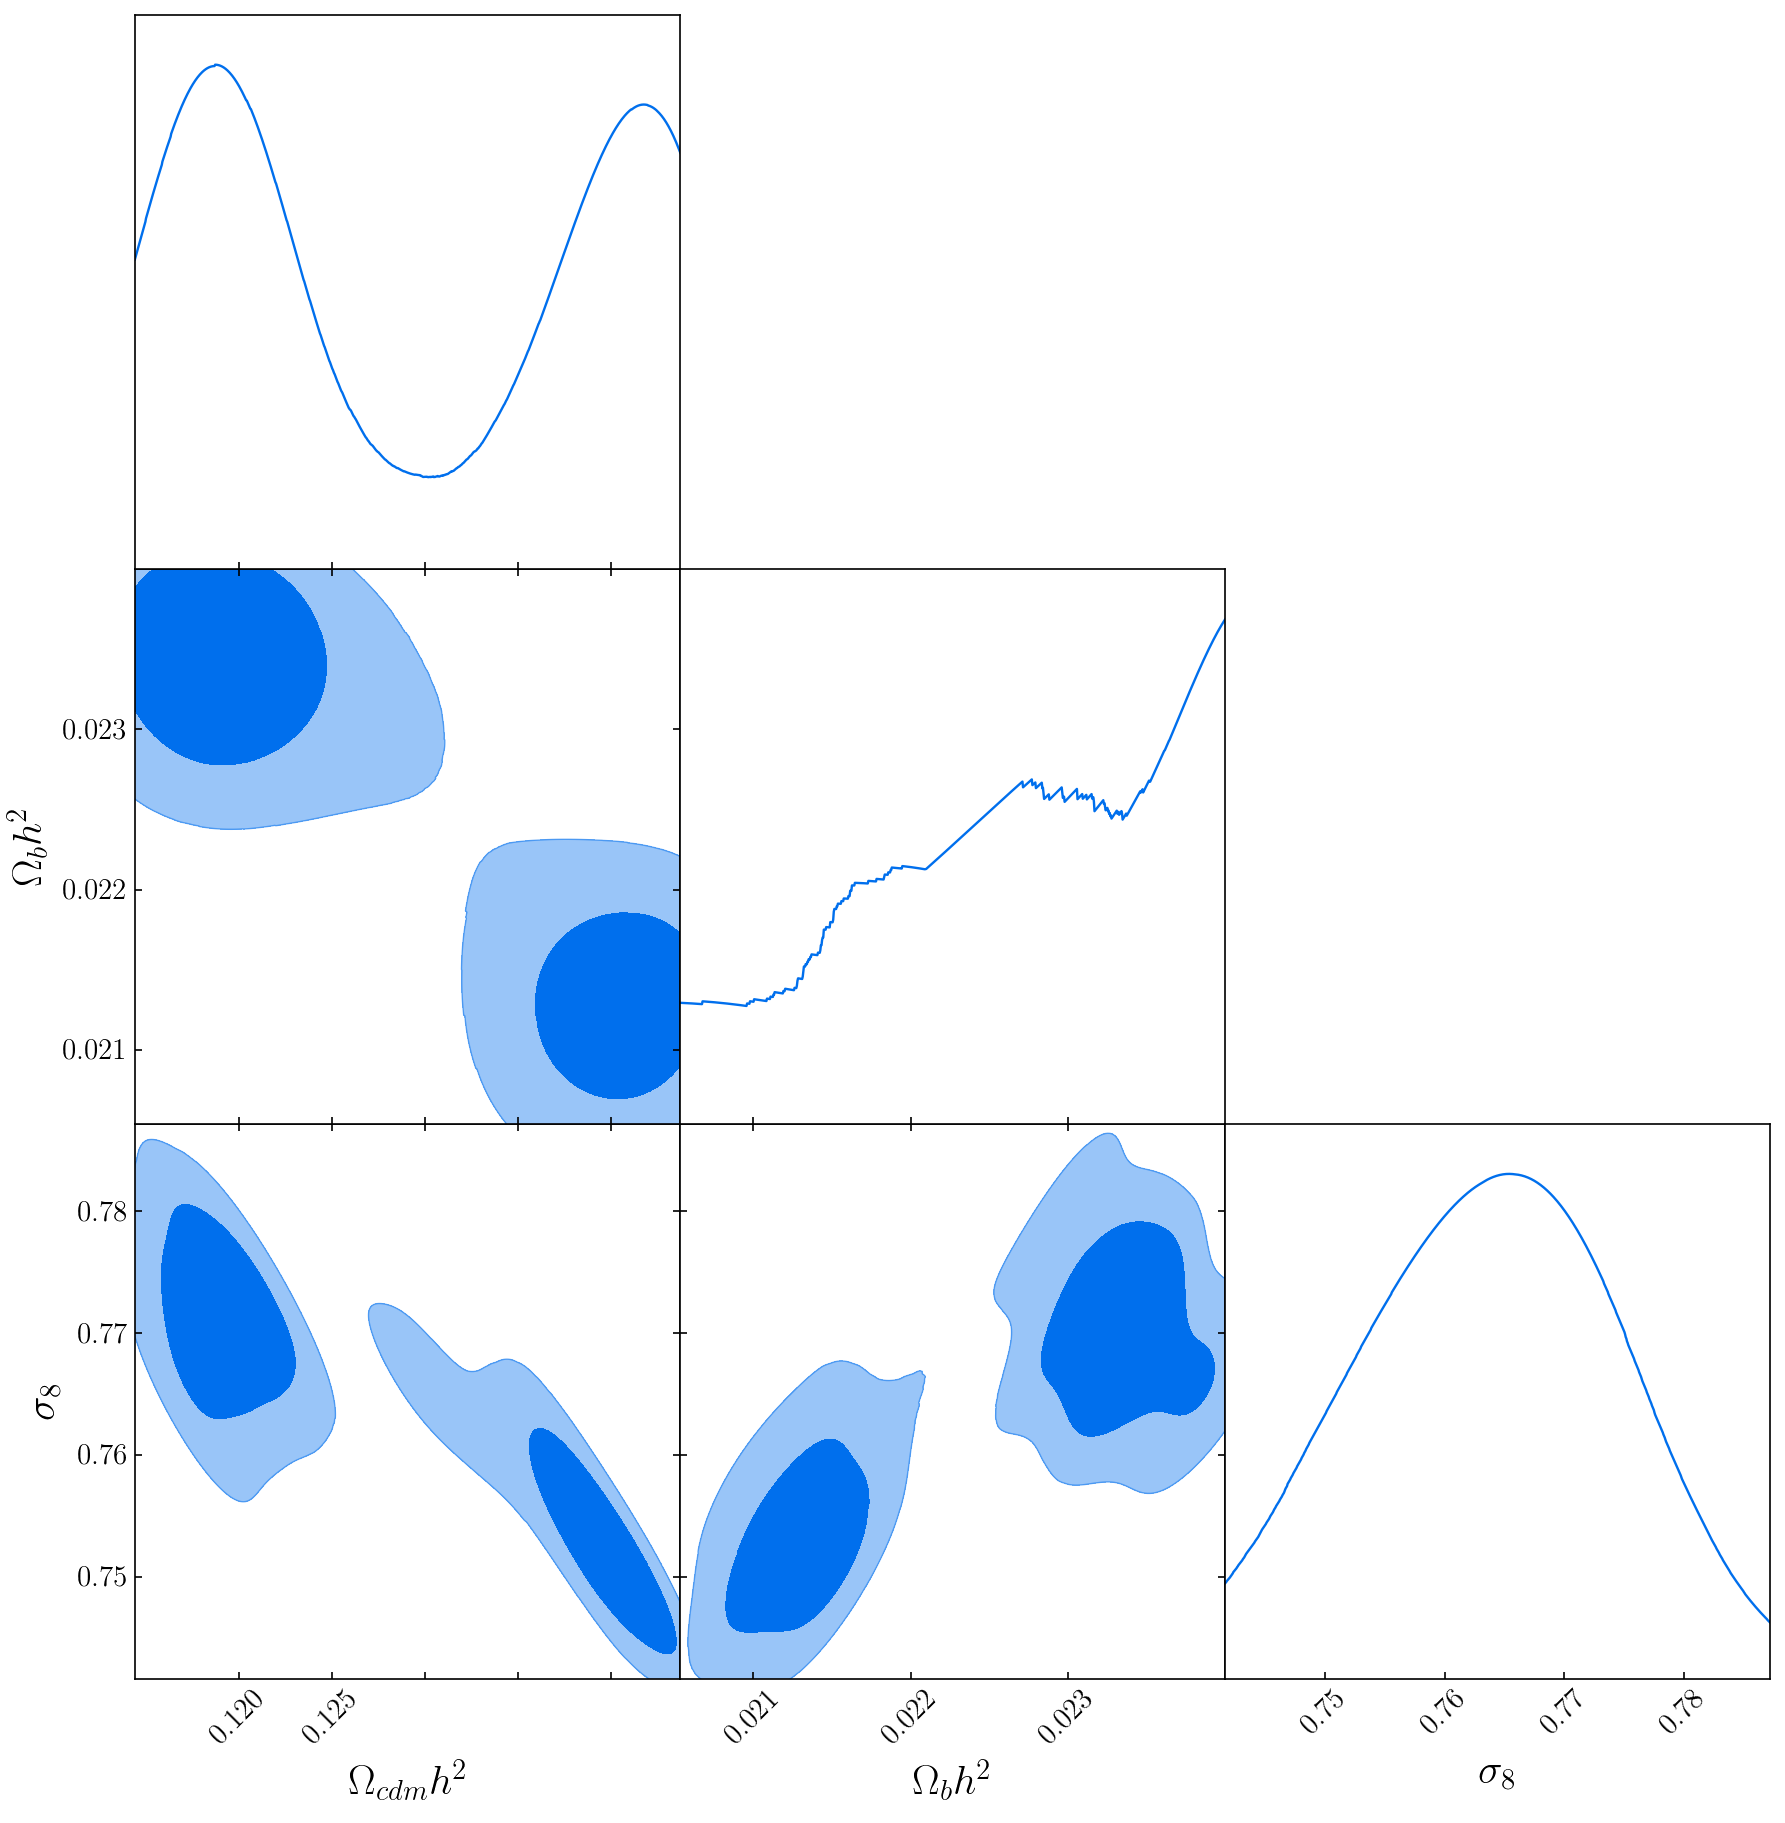

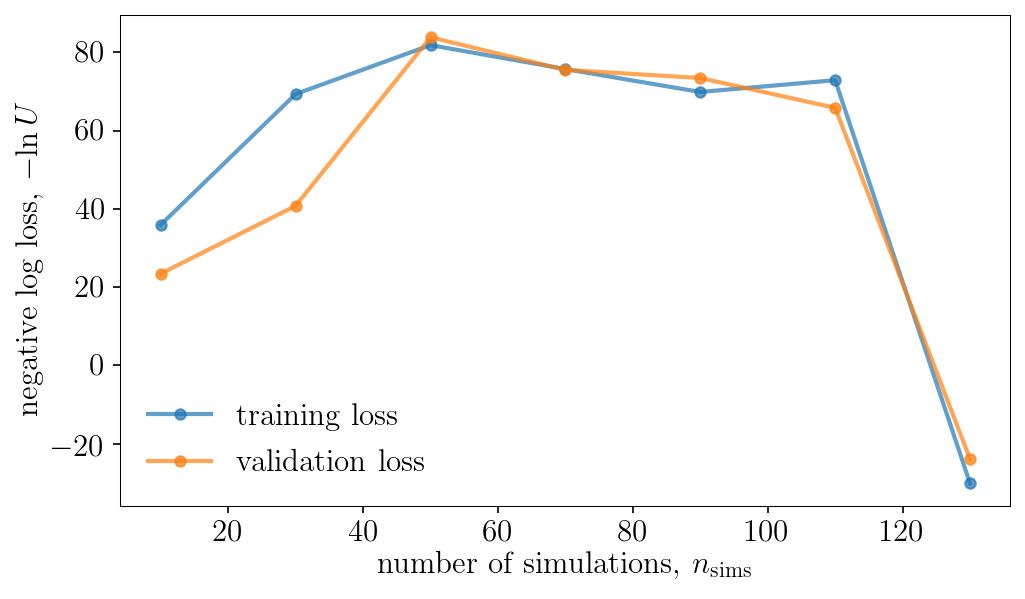

Population 10/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


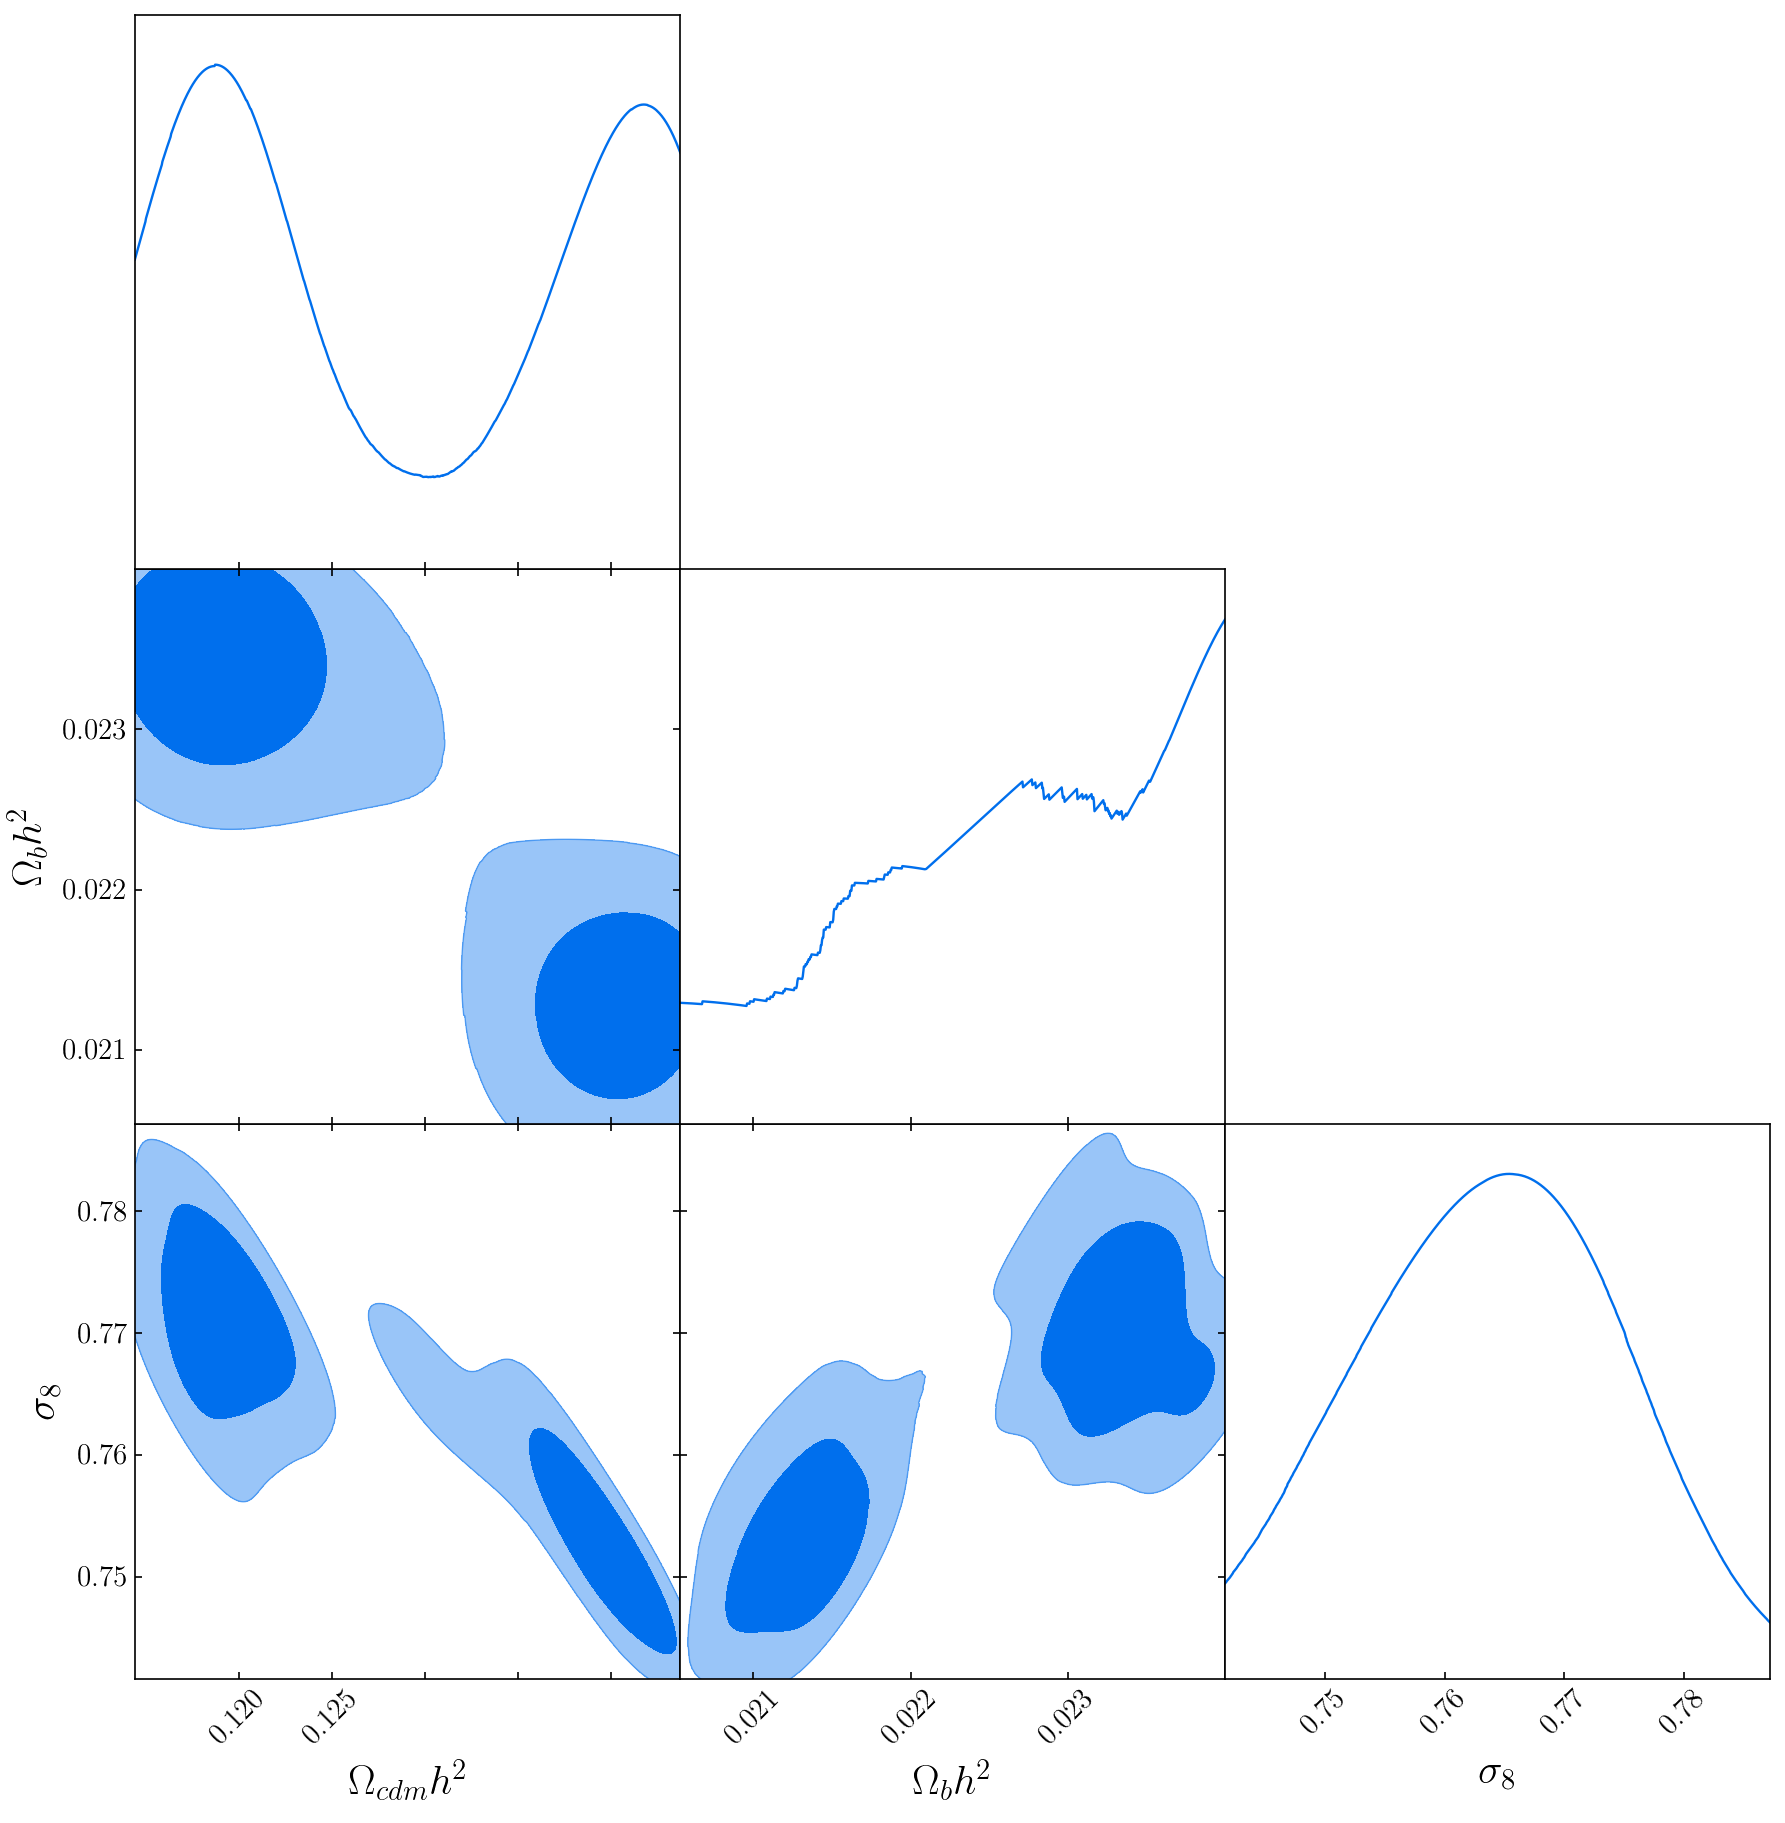

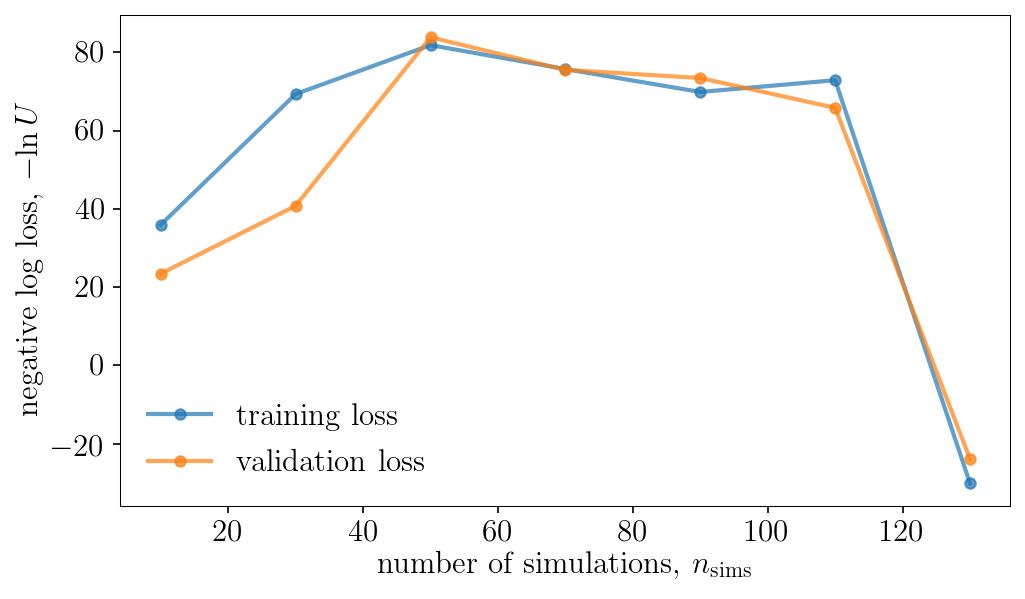

Population 11/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


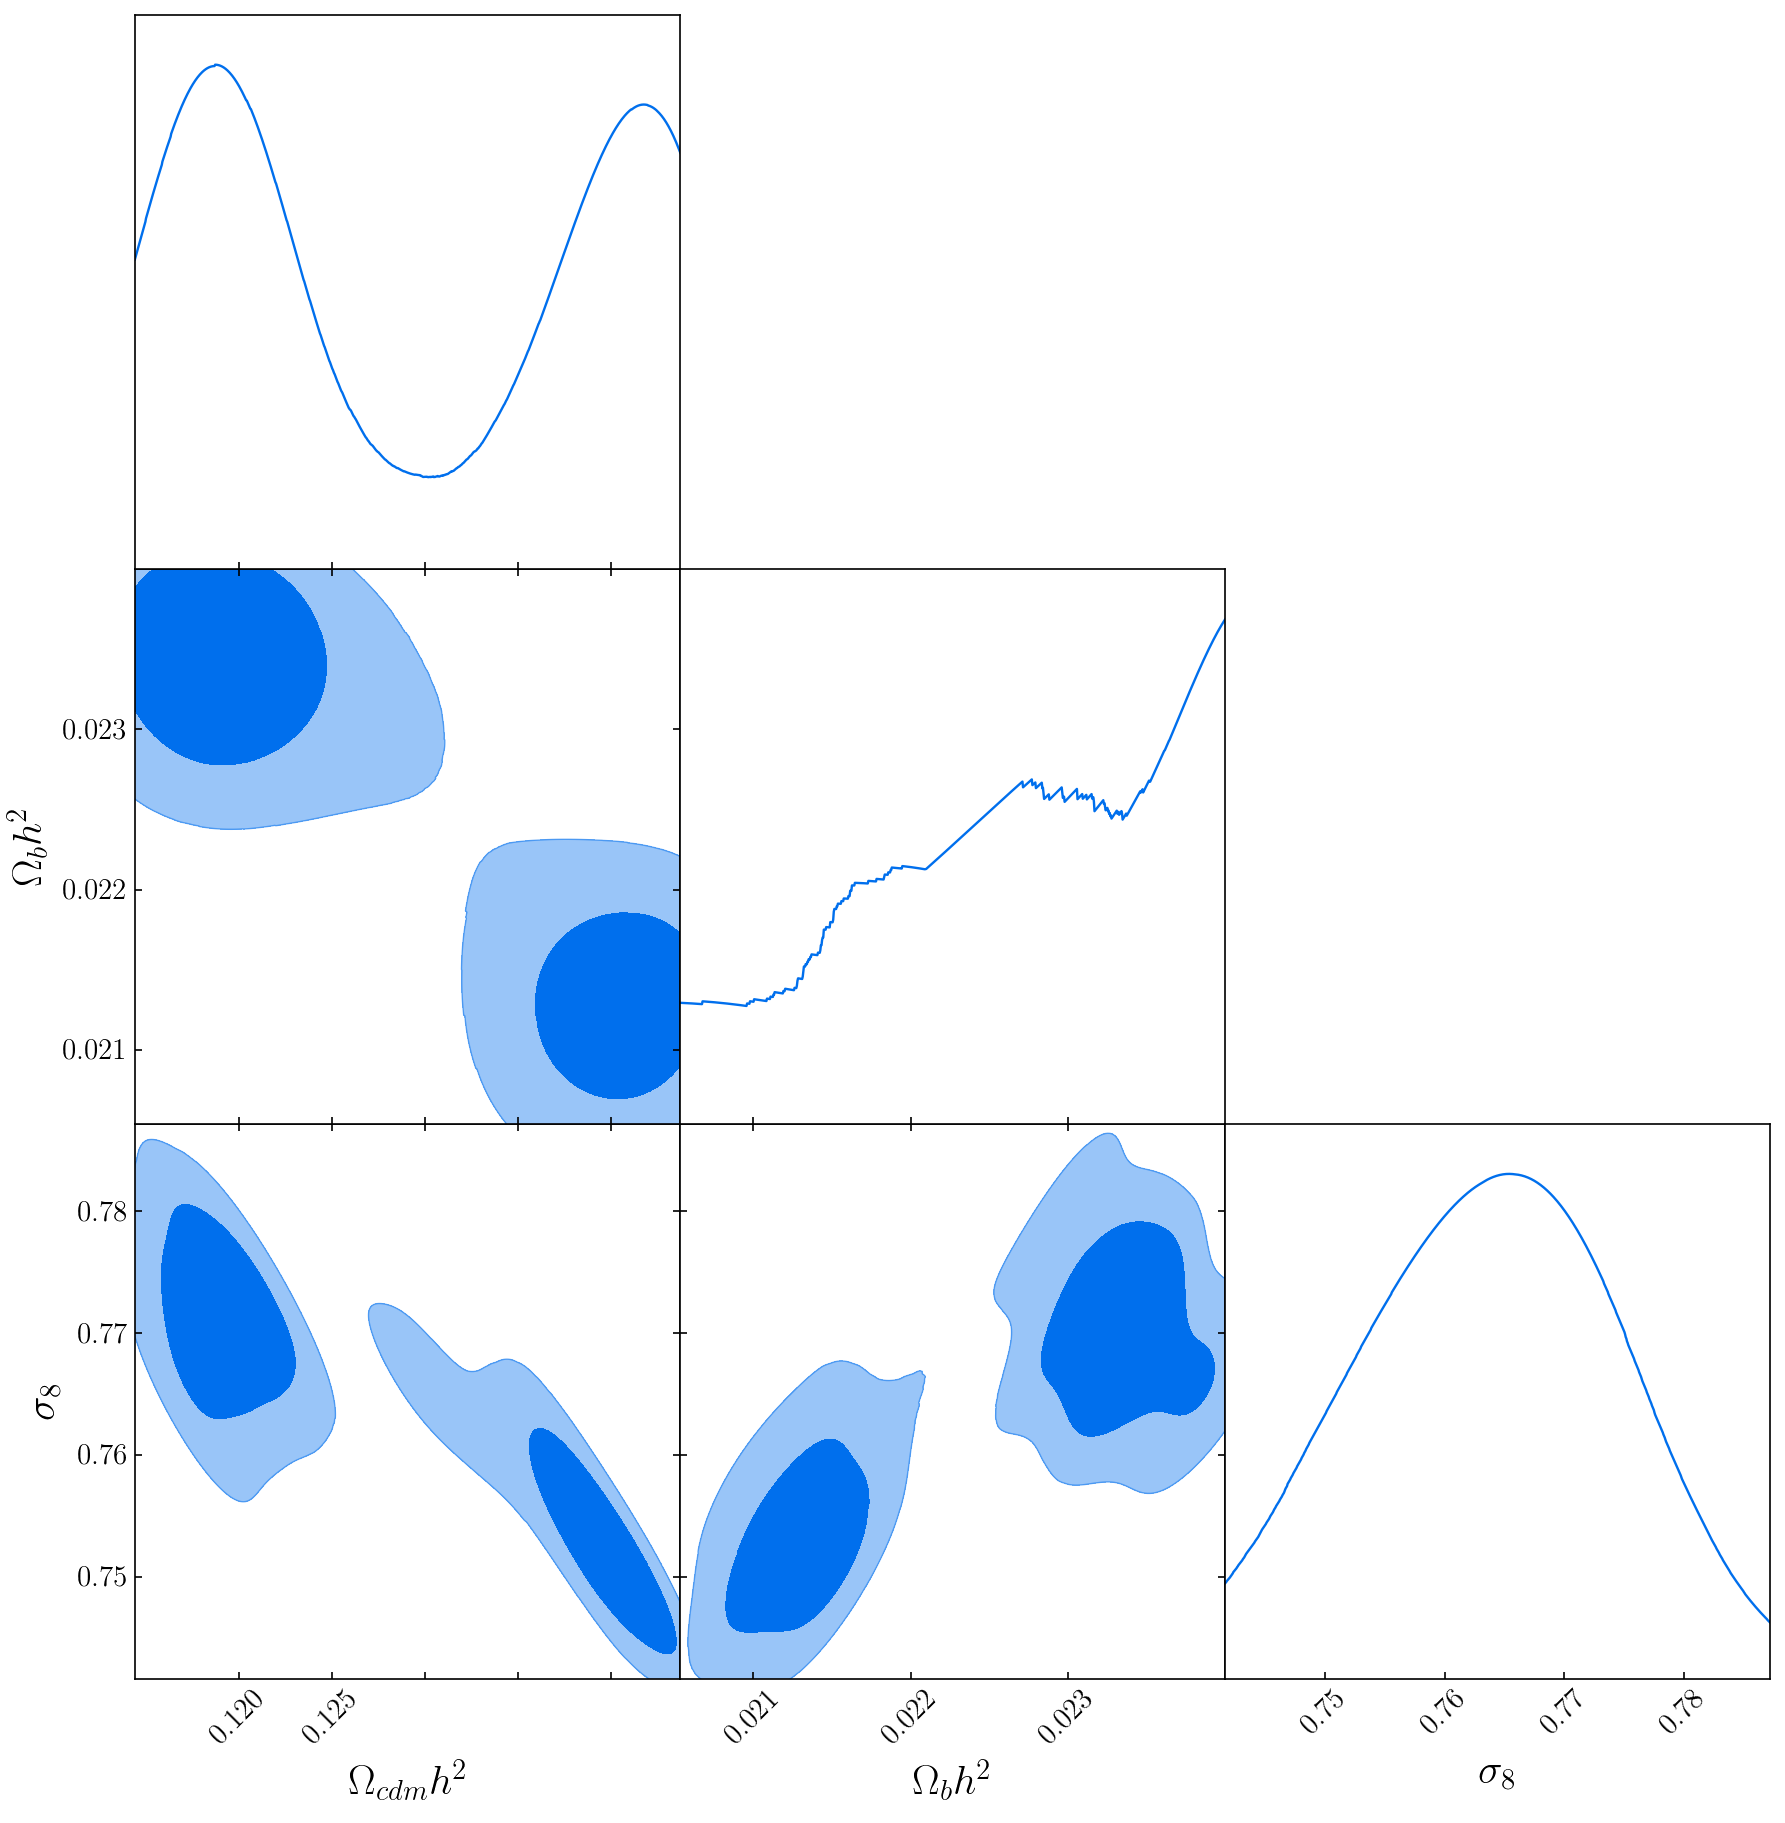

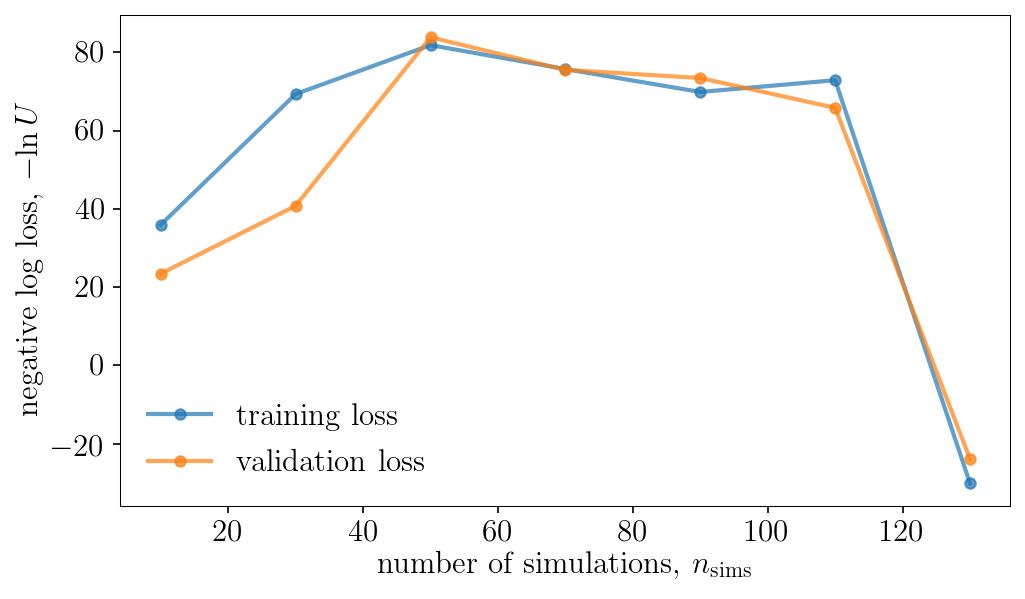

Population 12/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


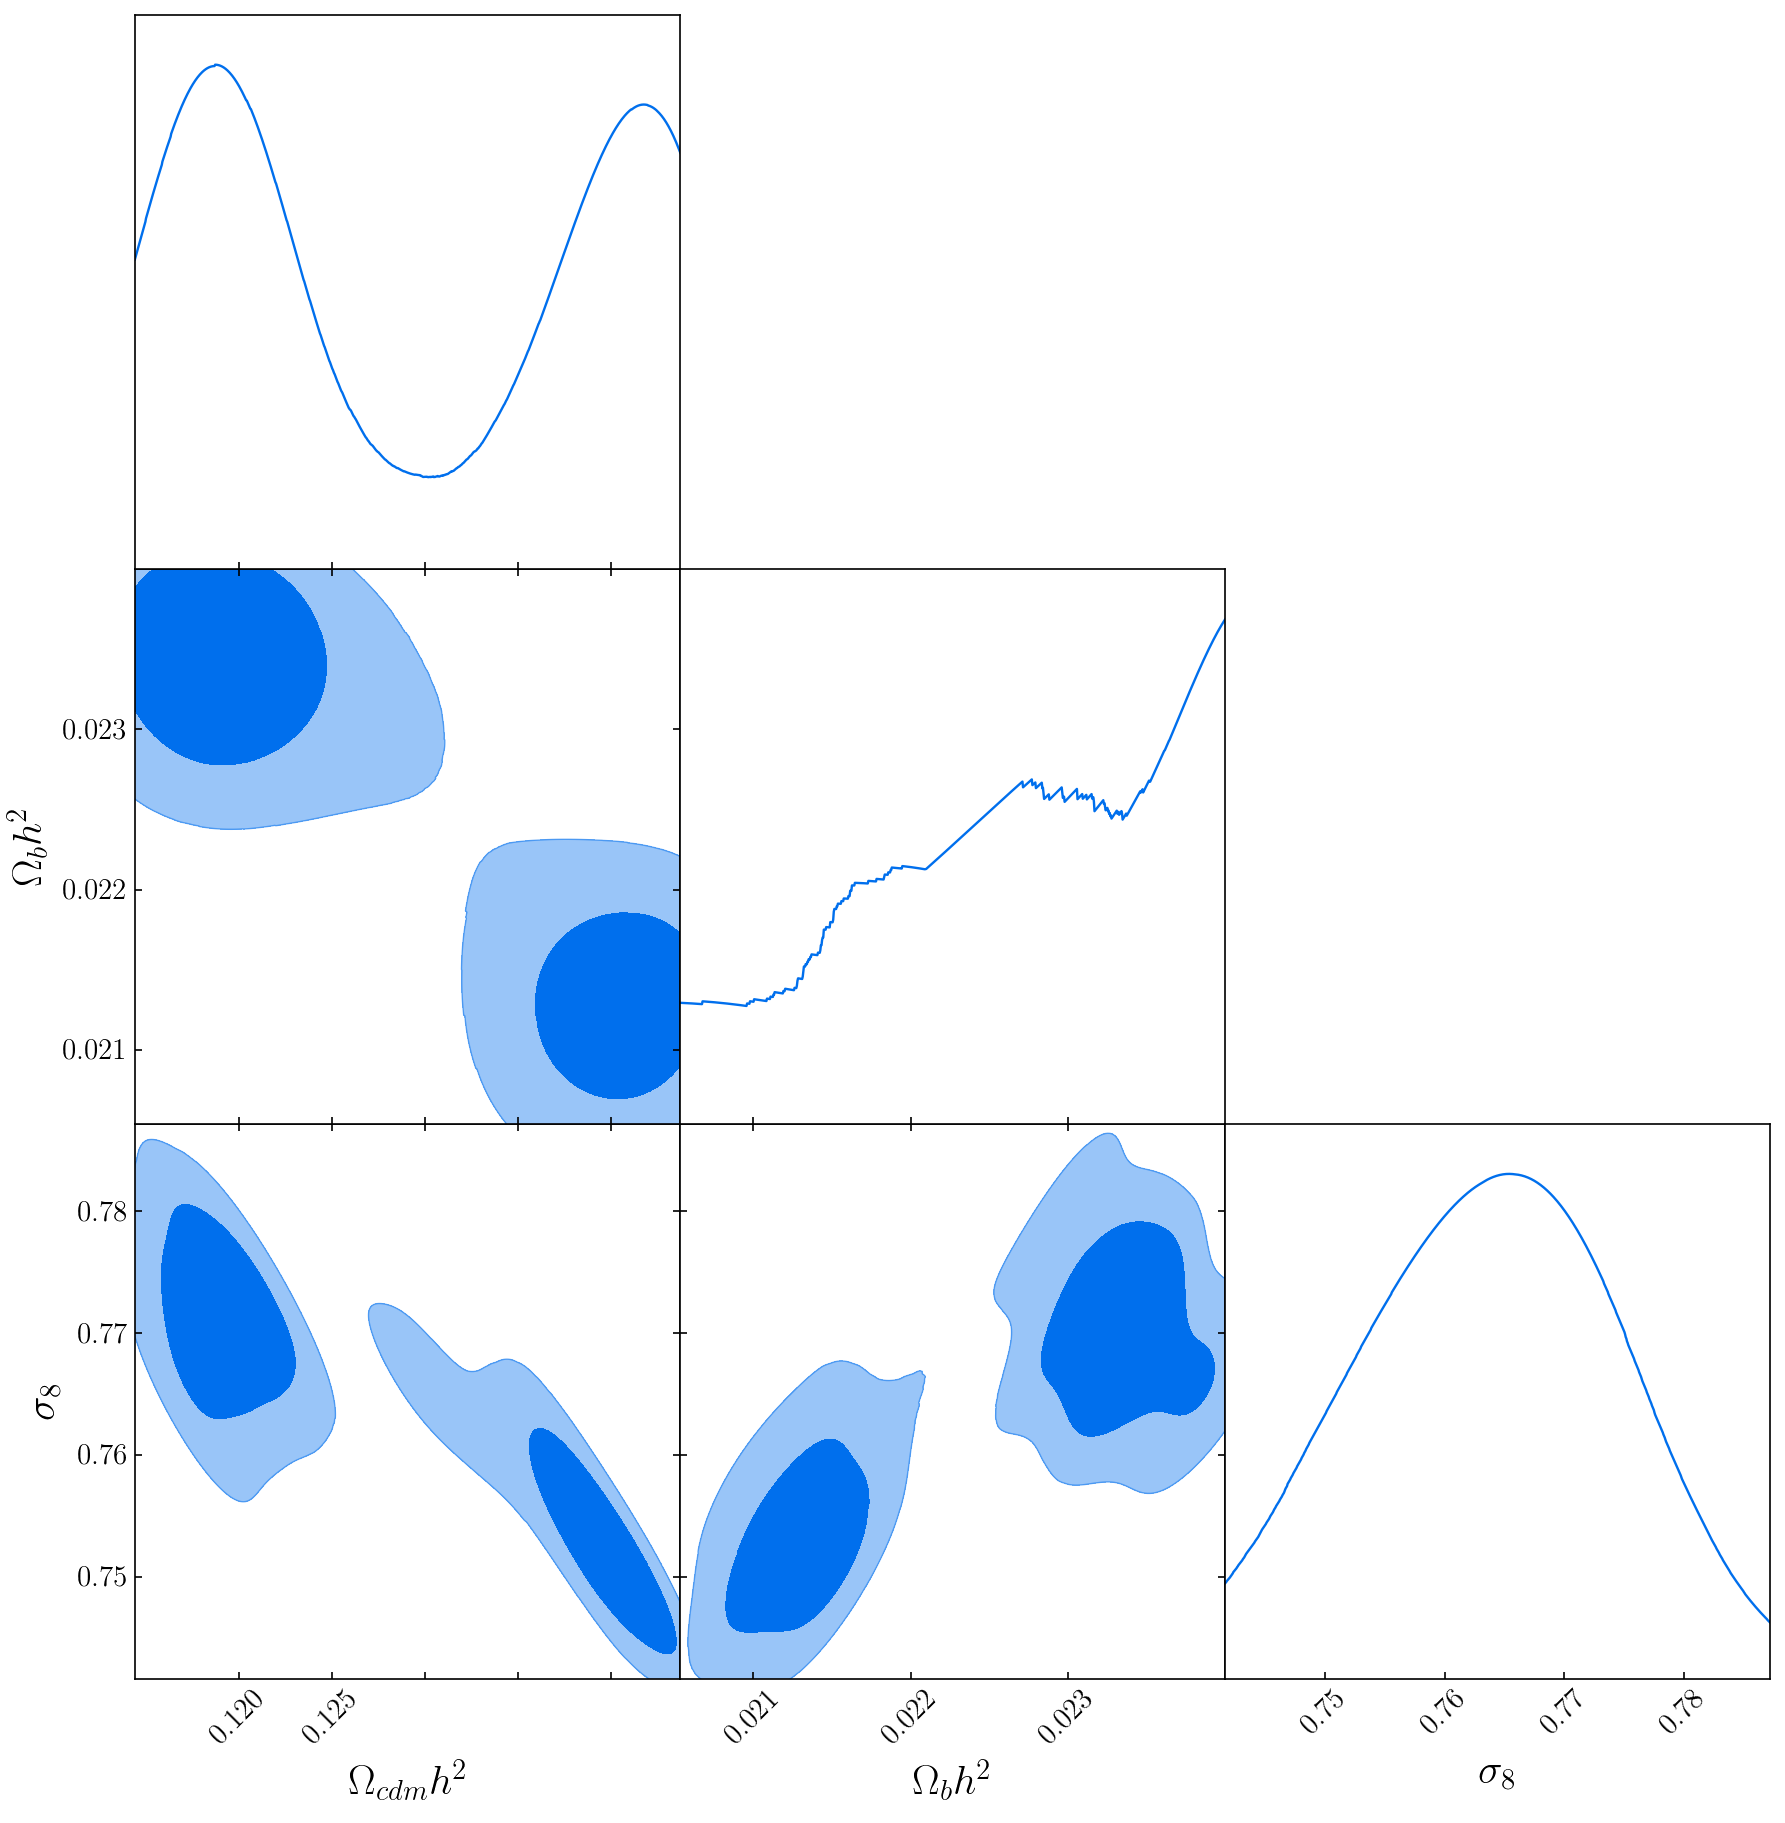

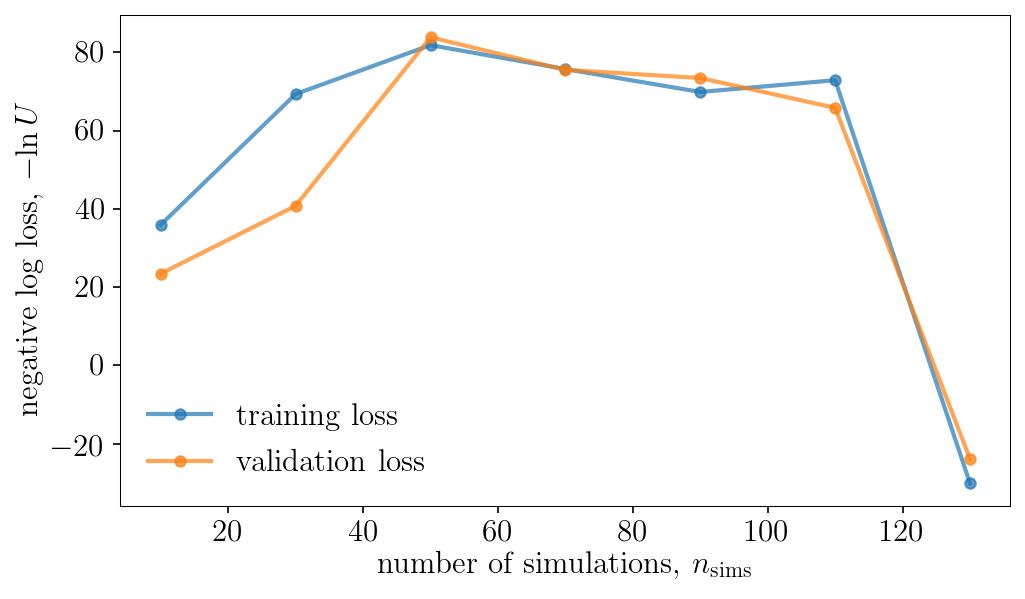

Population 13/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


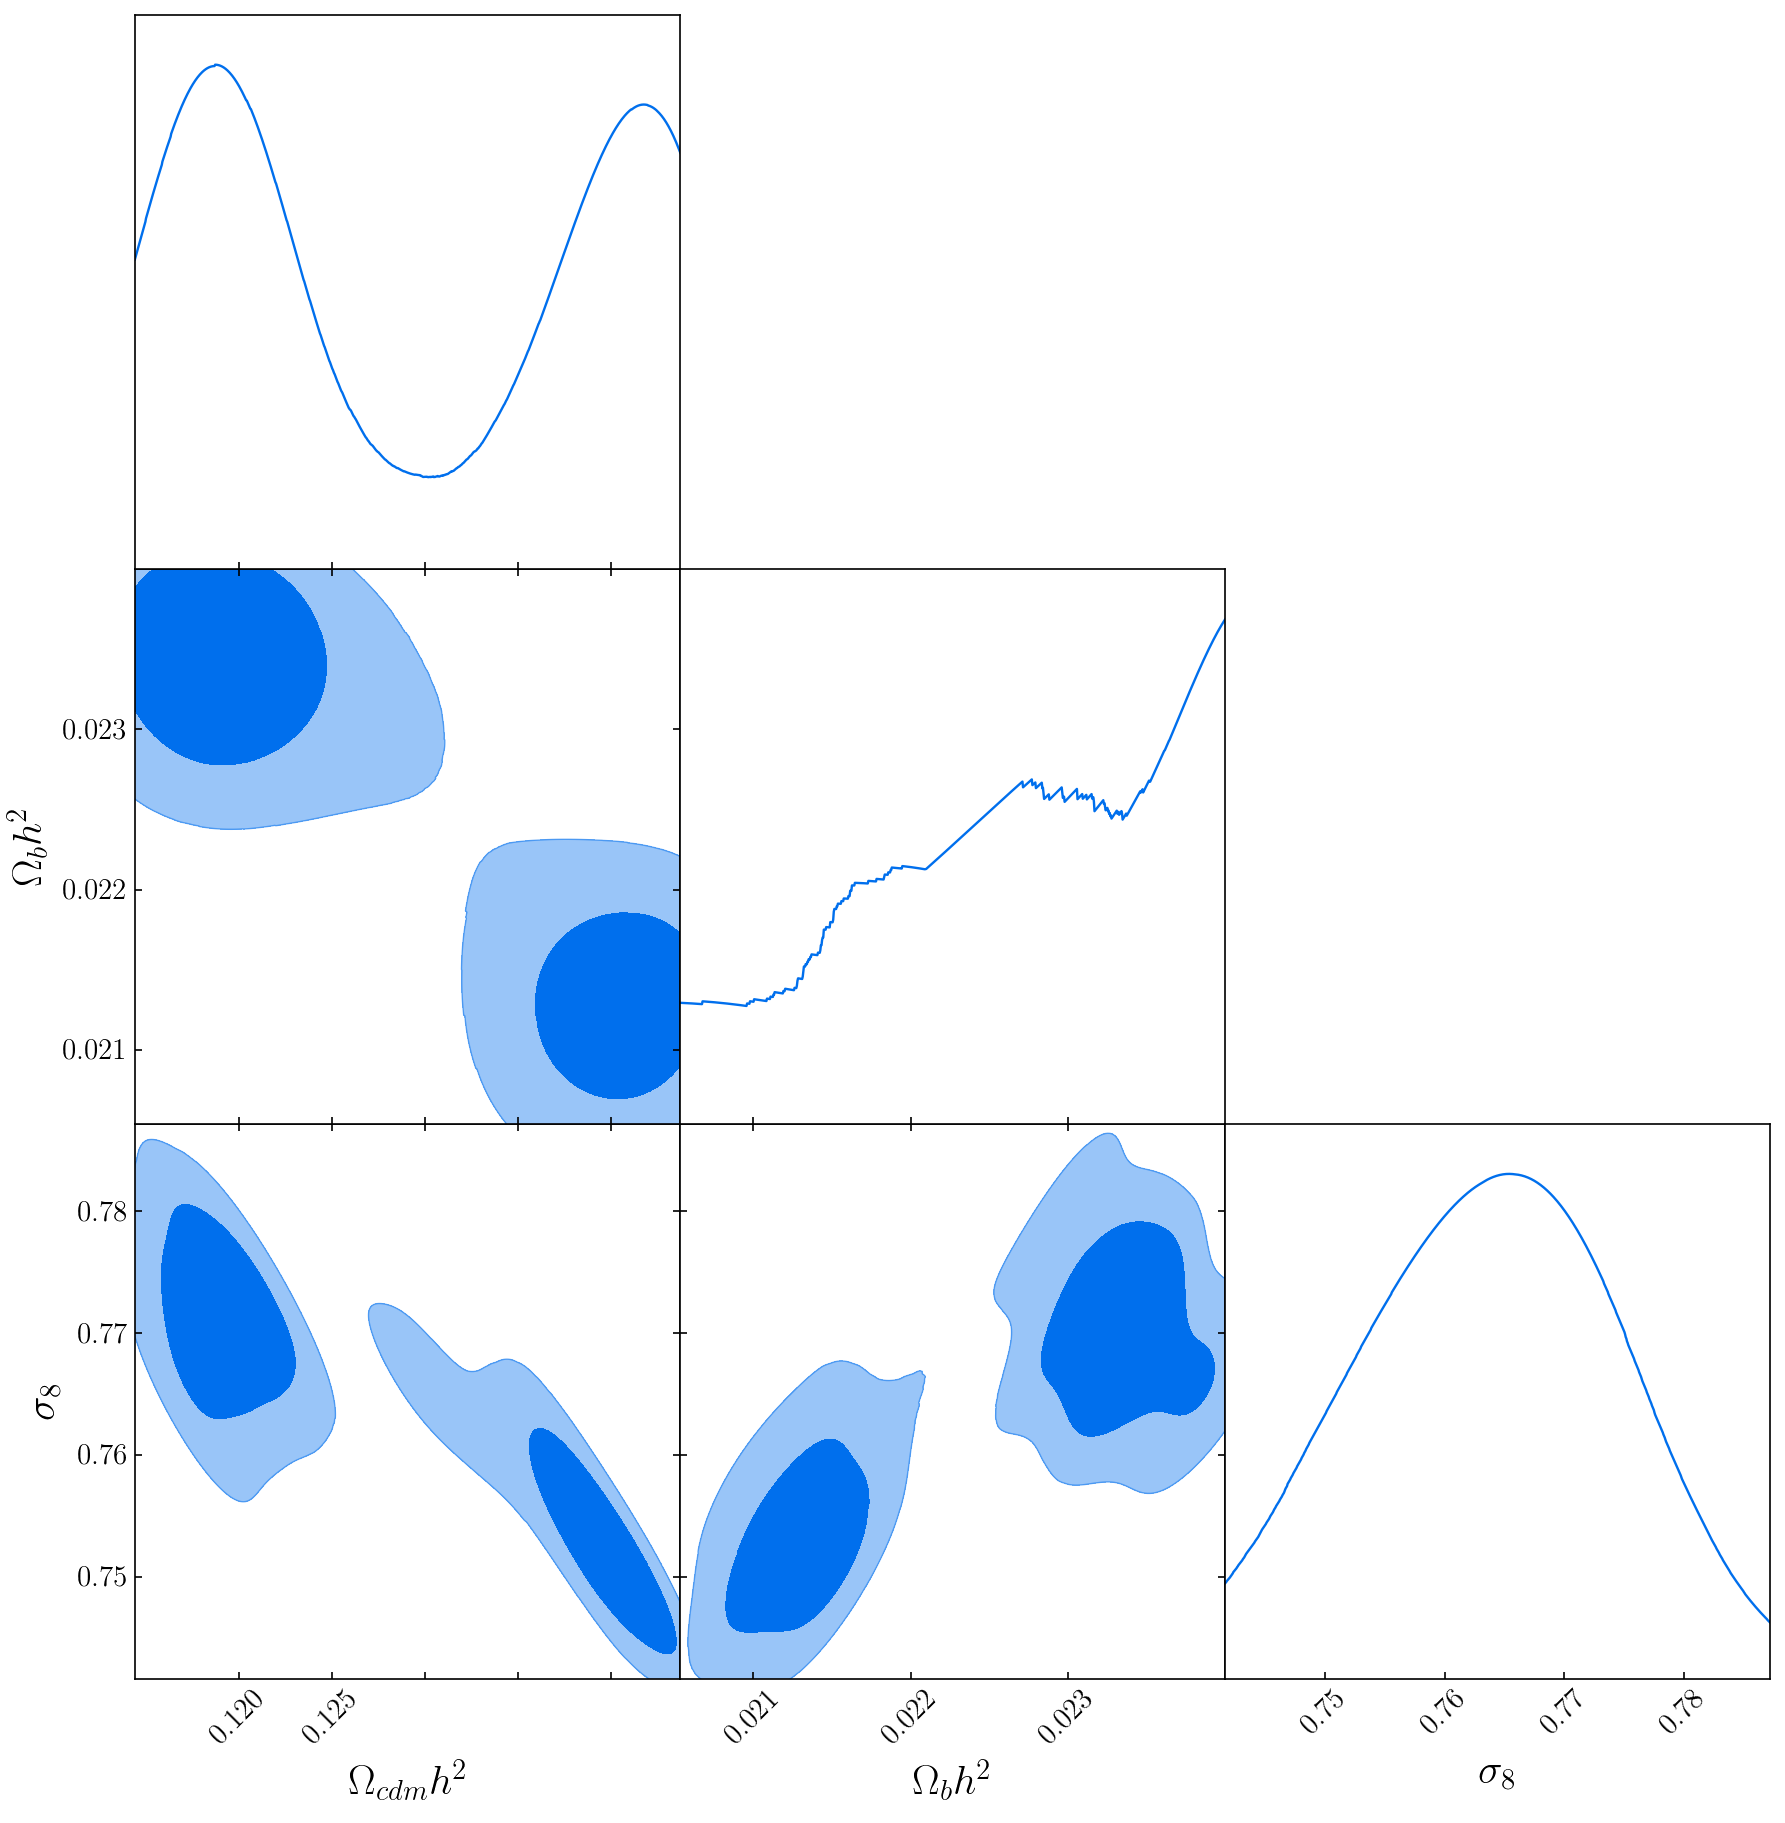

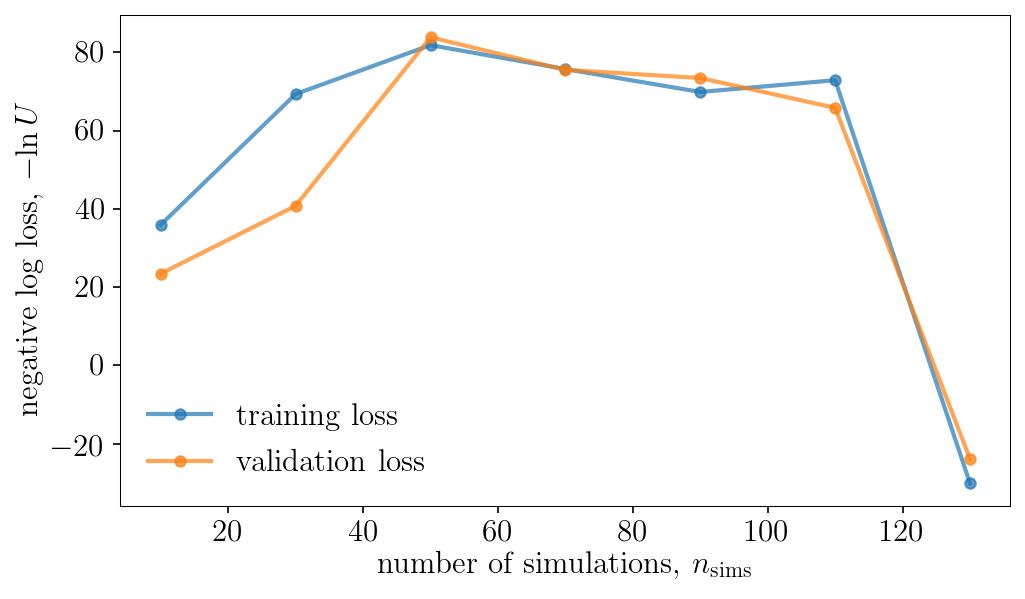

Population 14/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


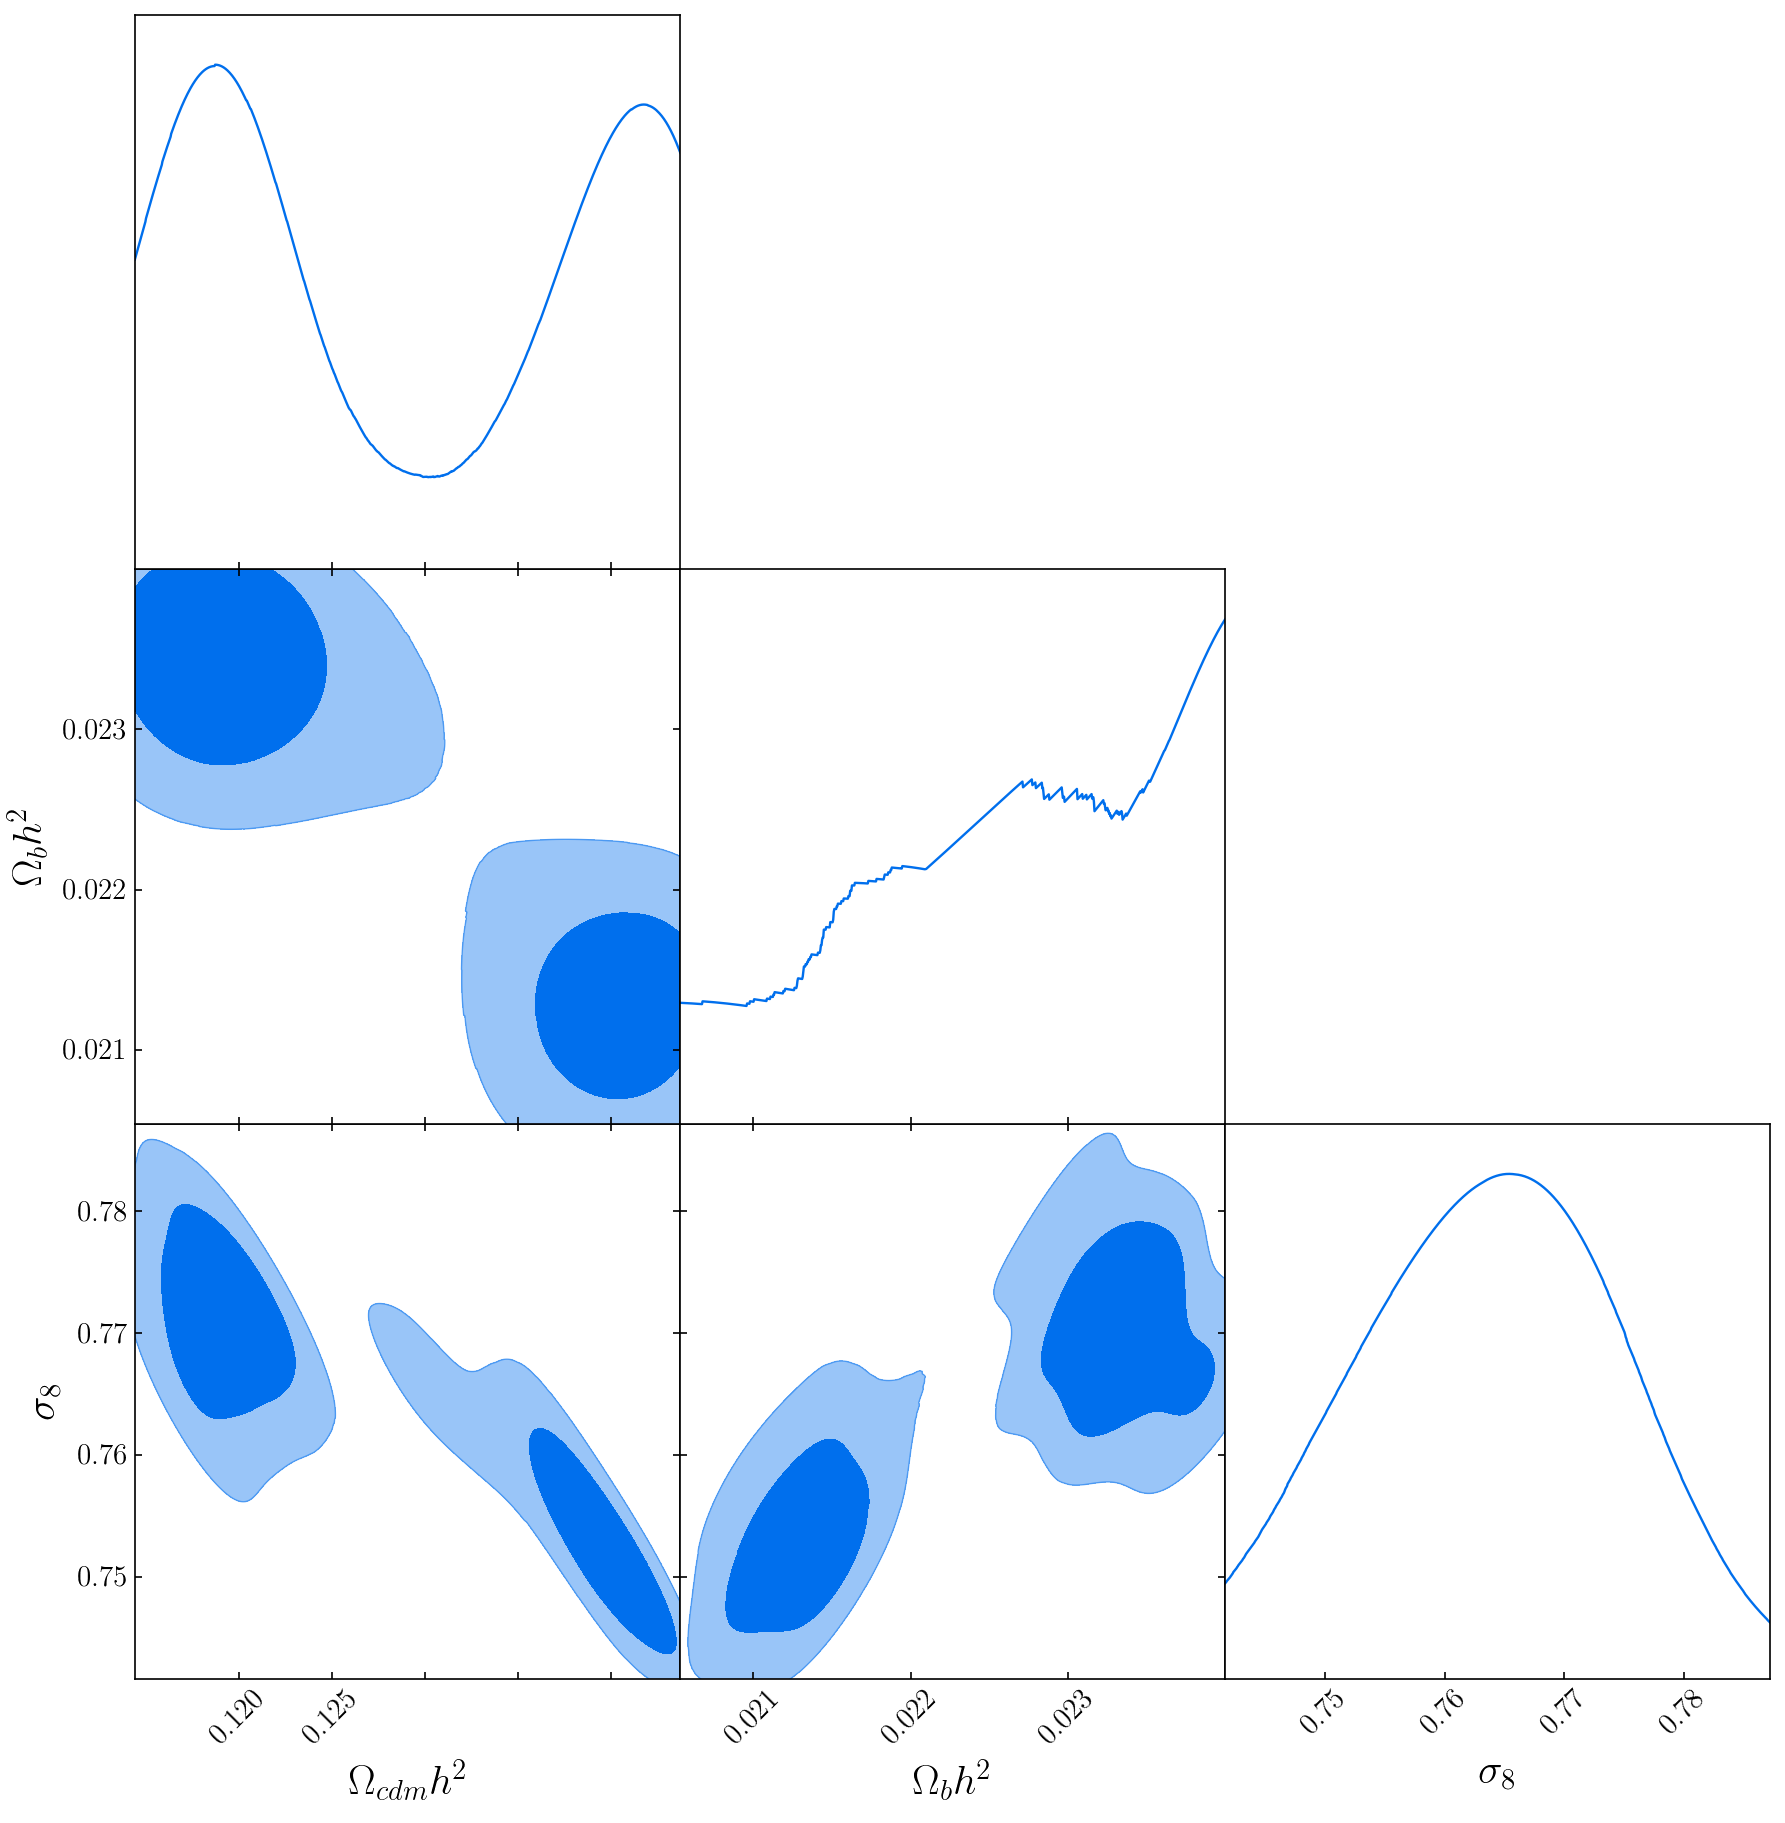

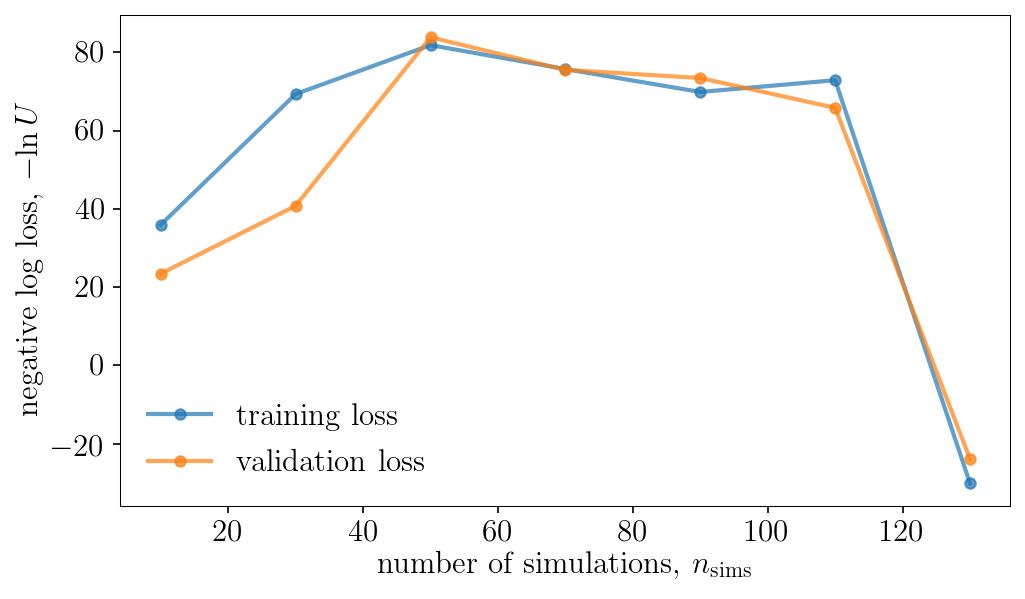

Population 15/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


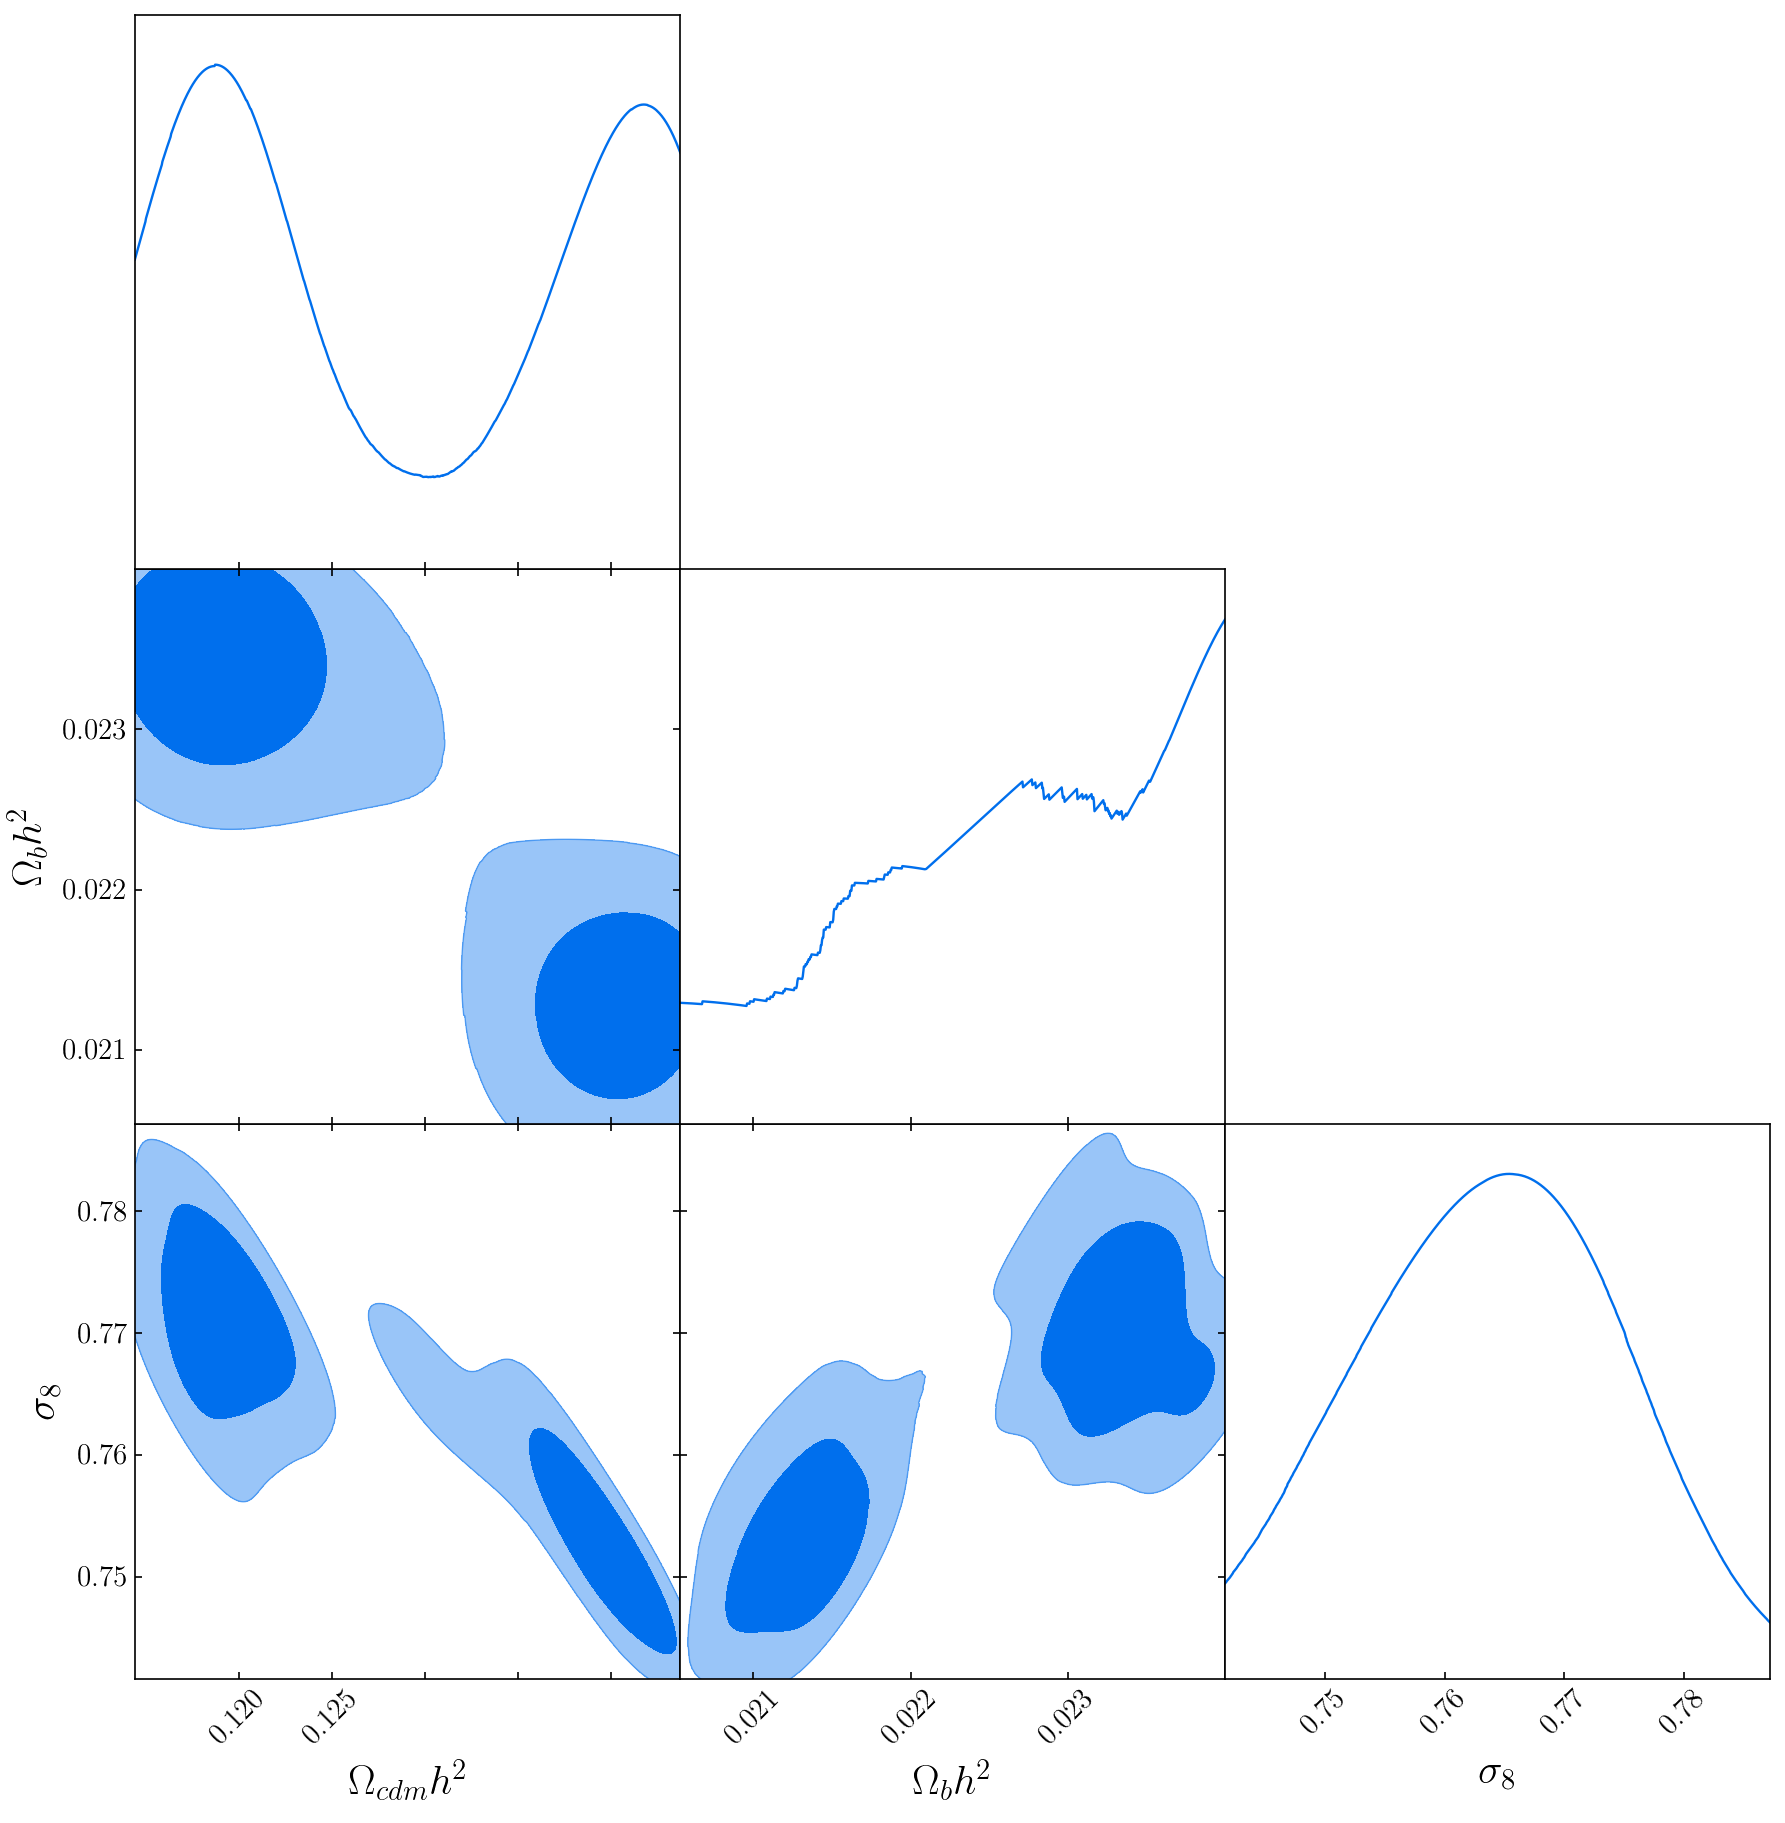

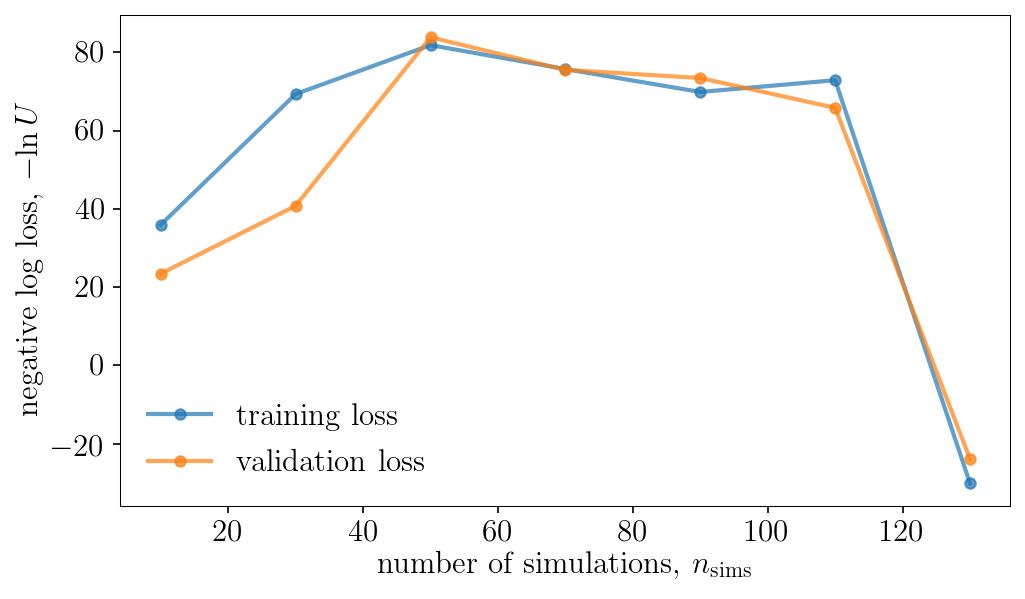

Population 16/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


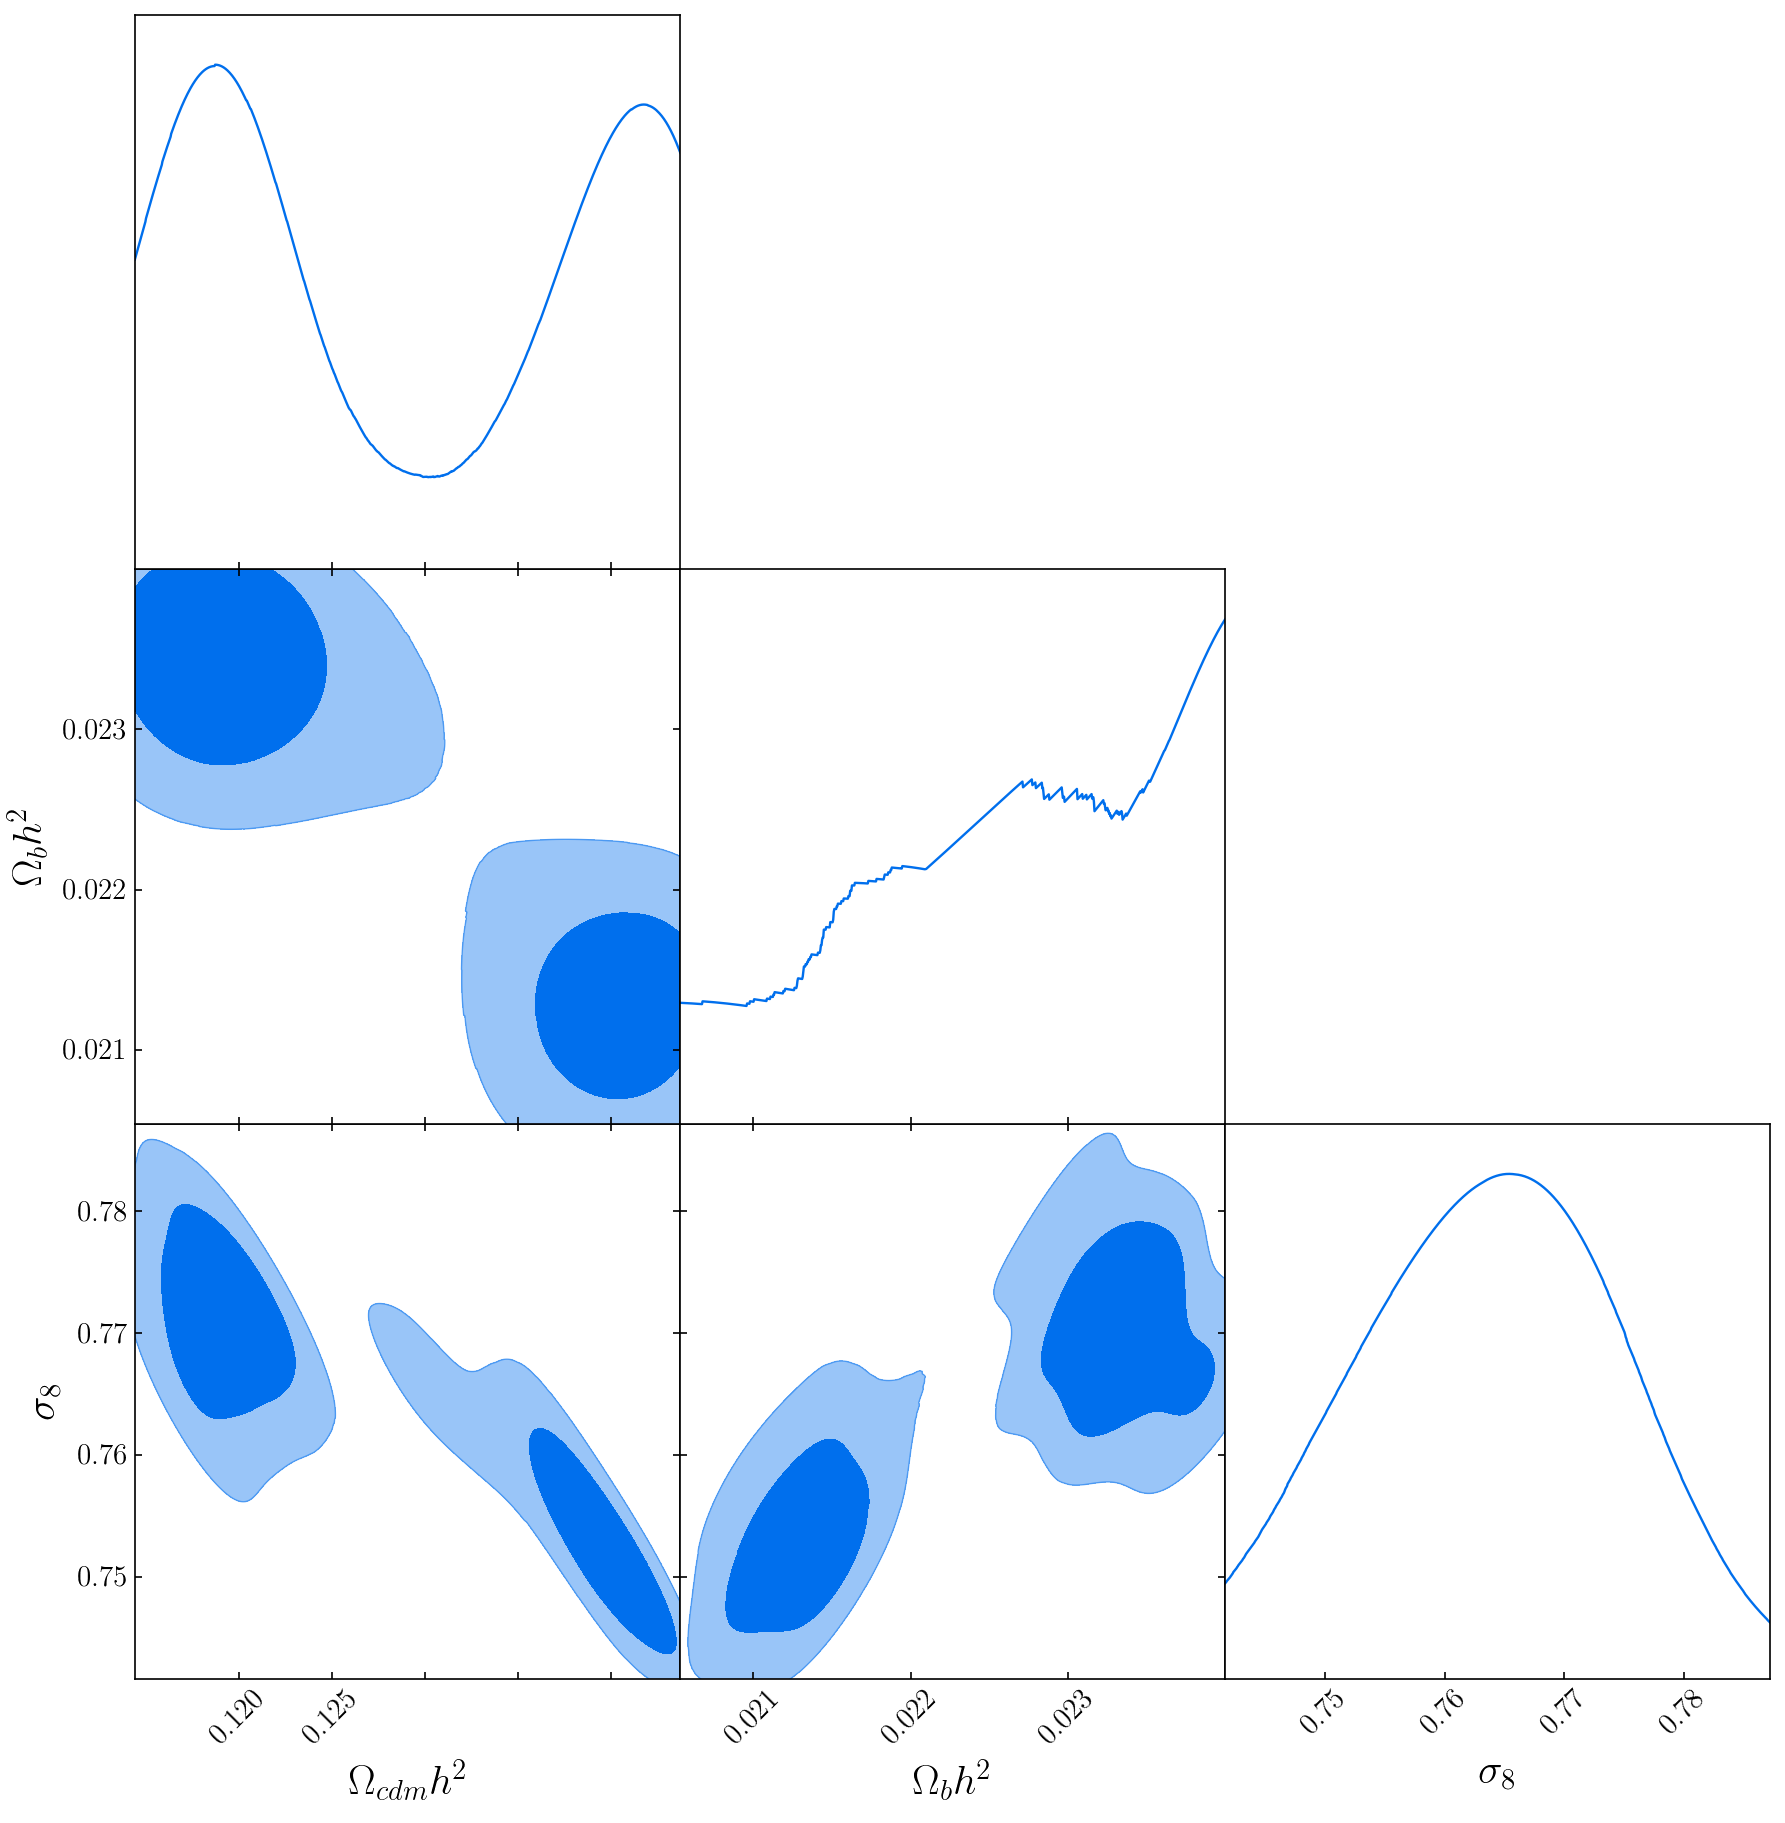

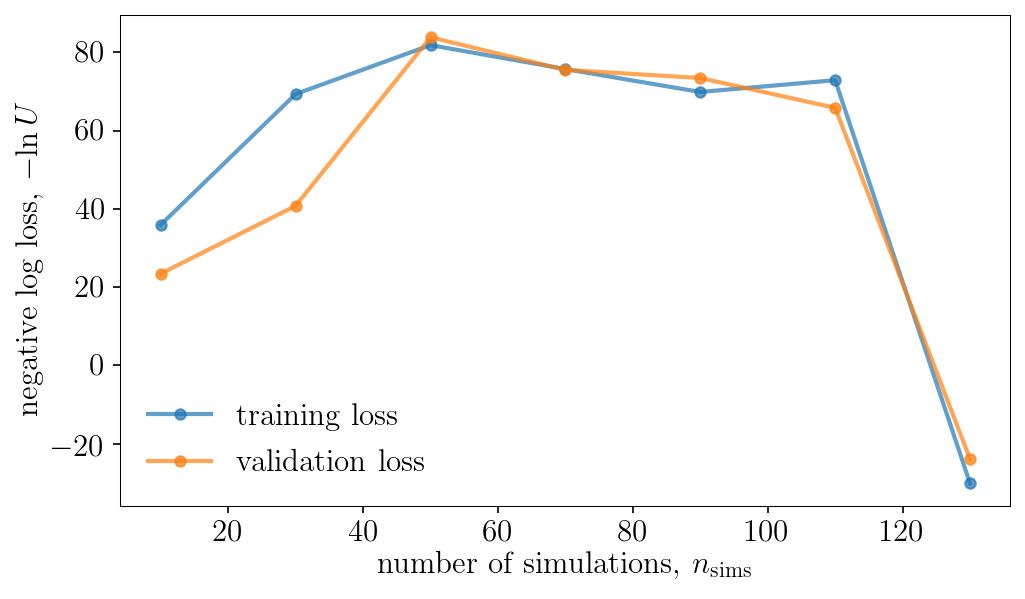

Population 17/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


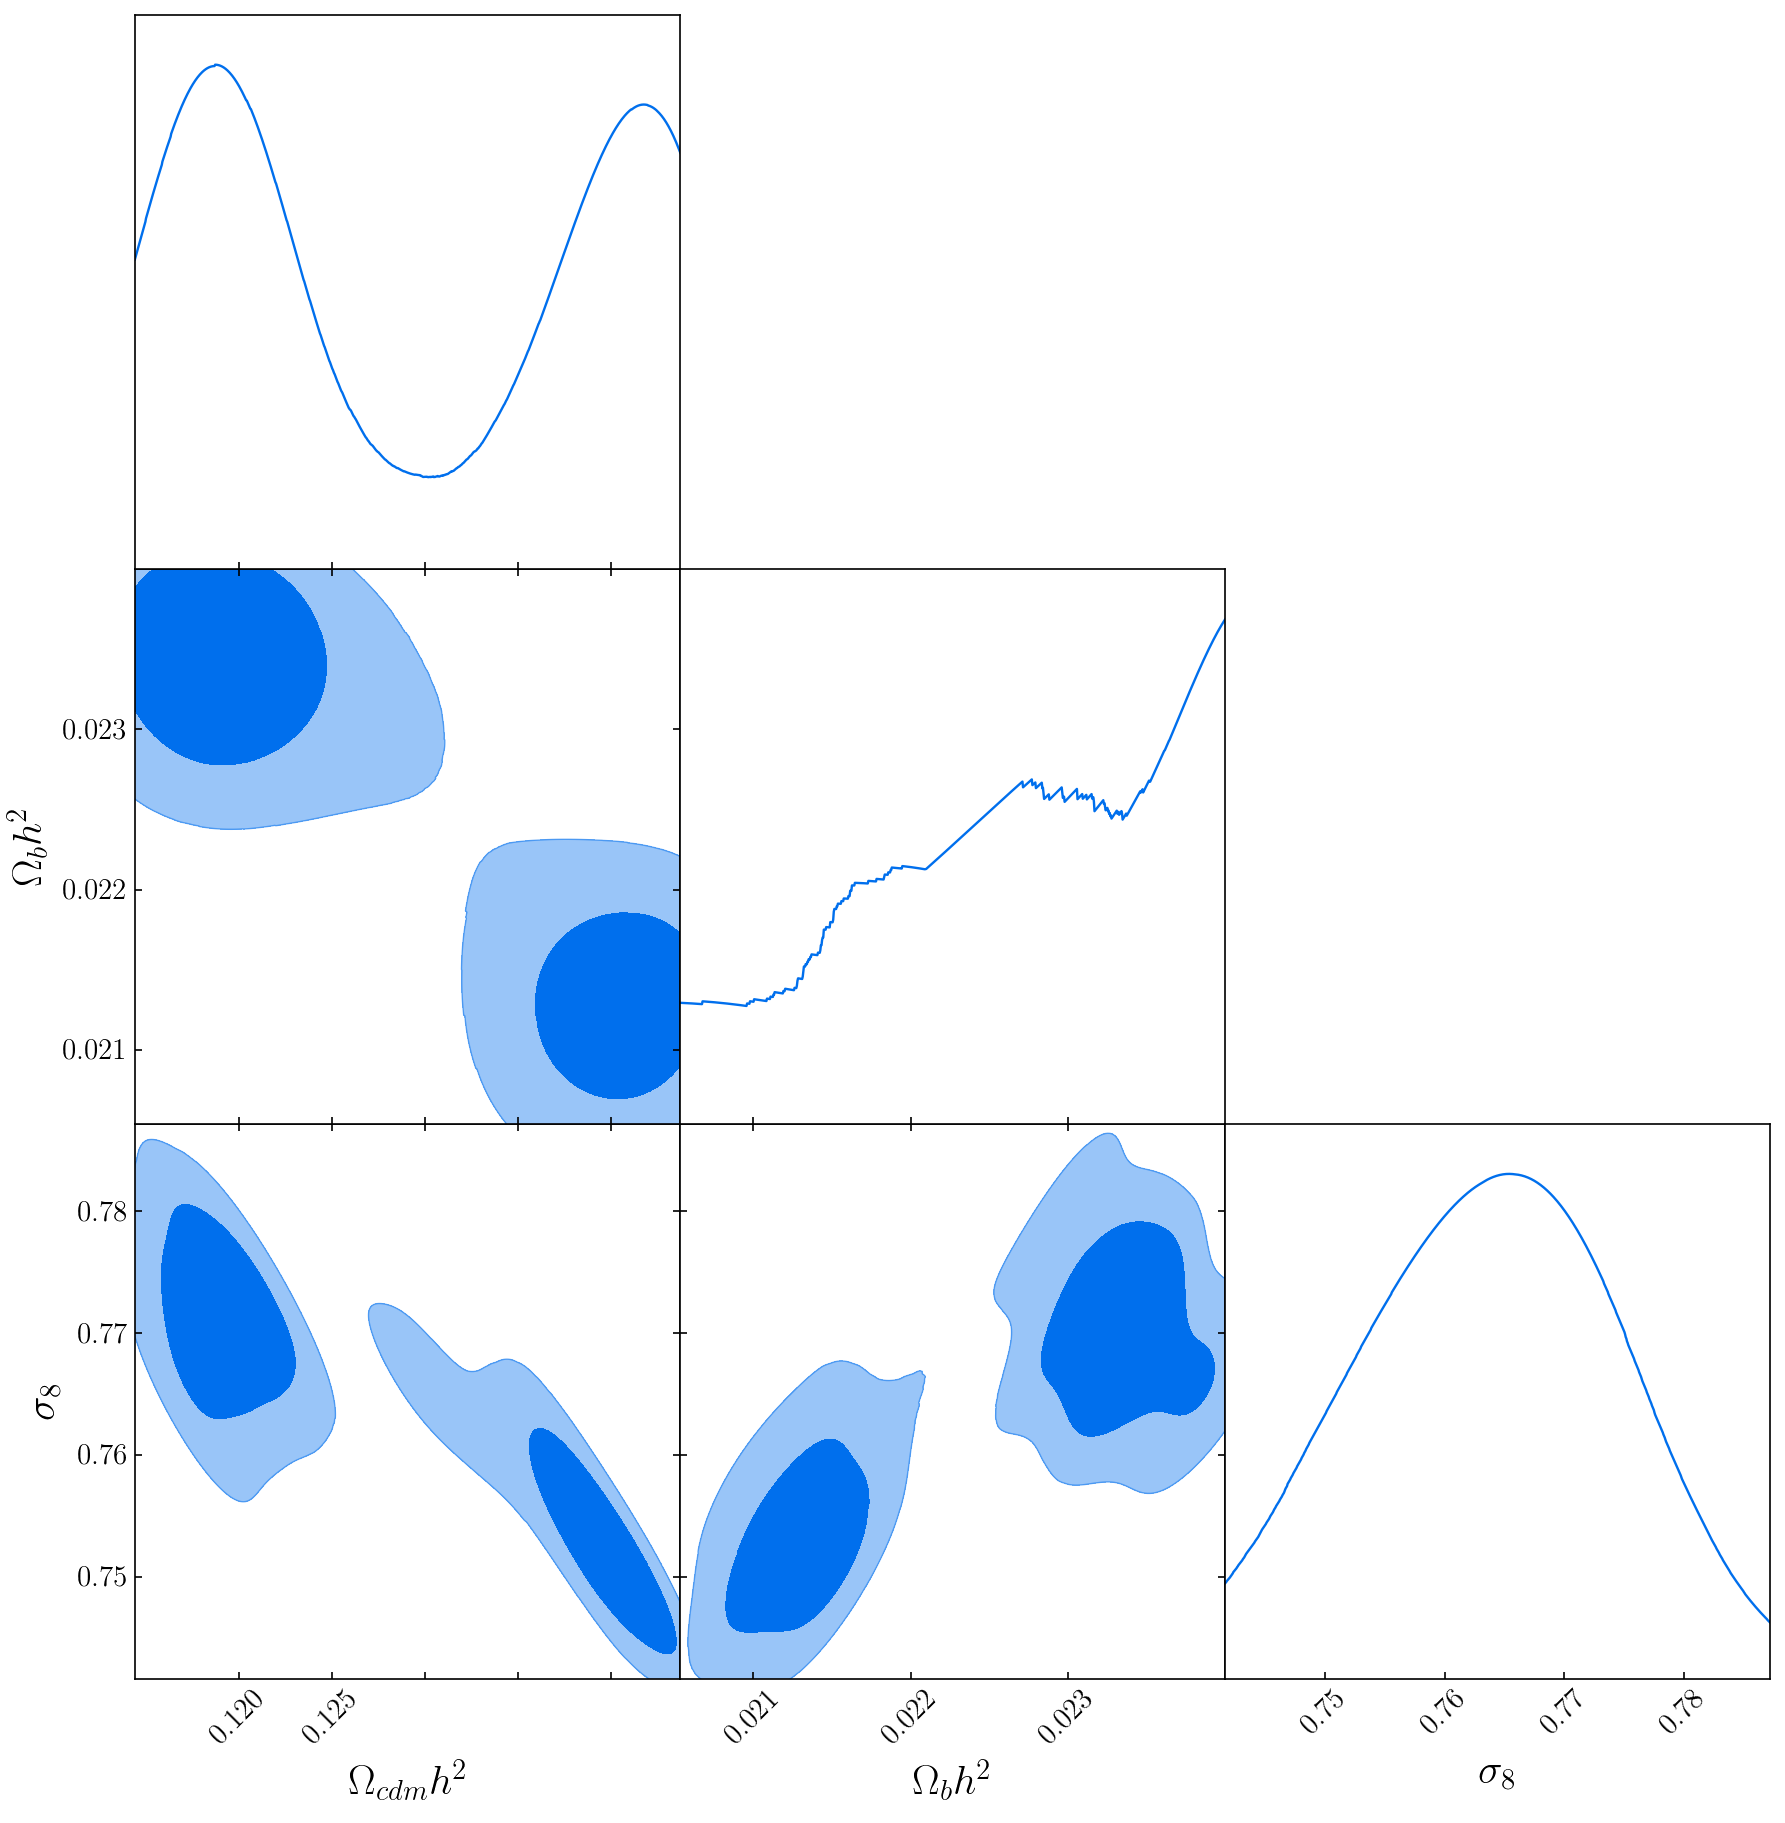

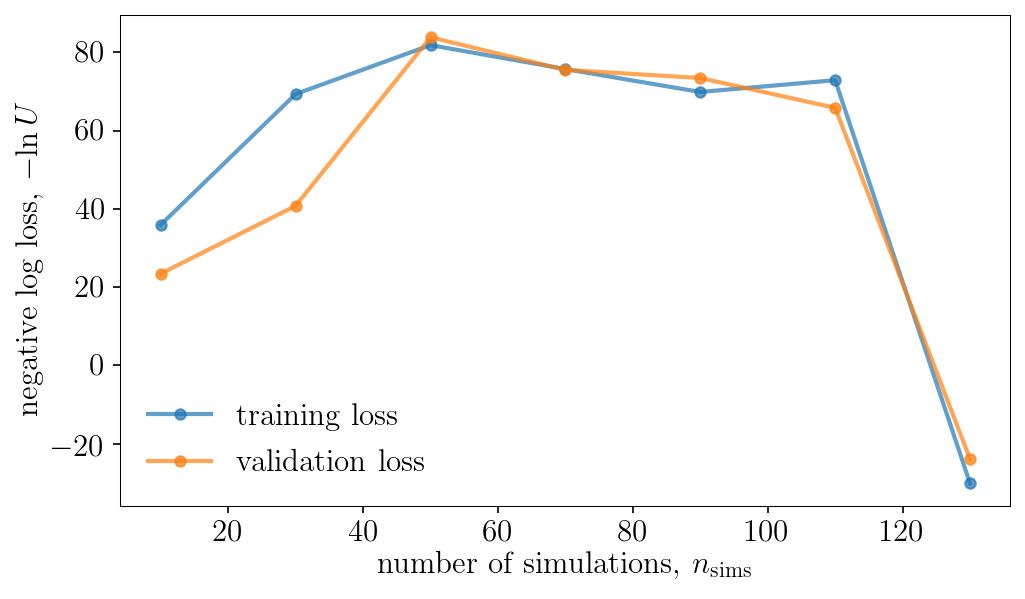

Population 18/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


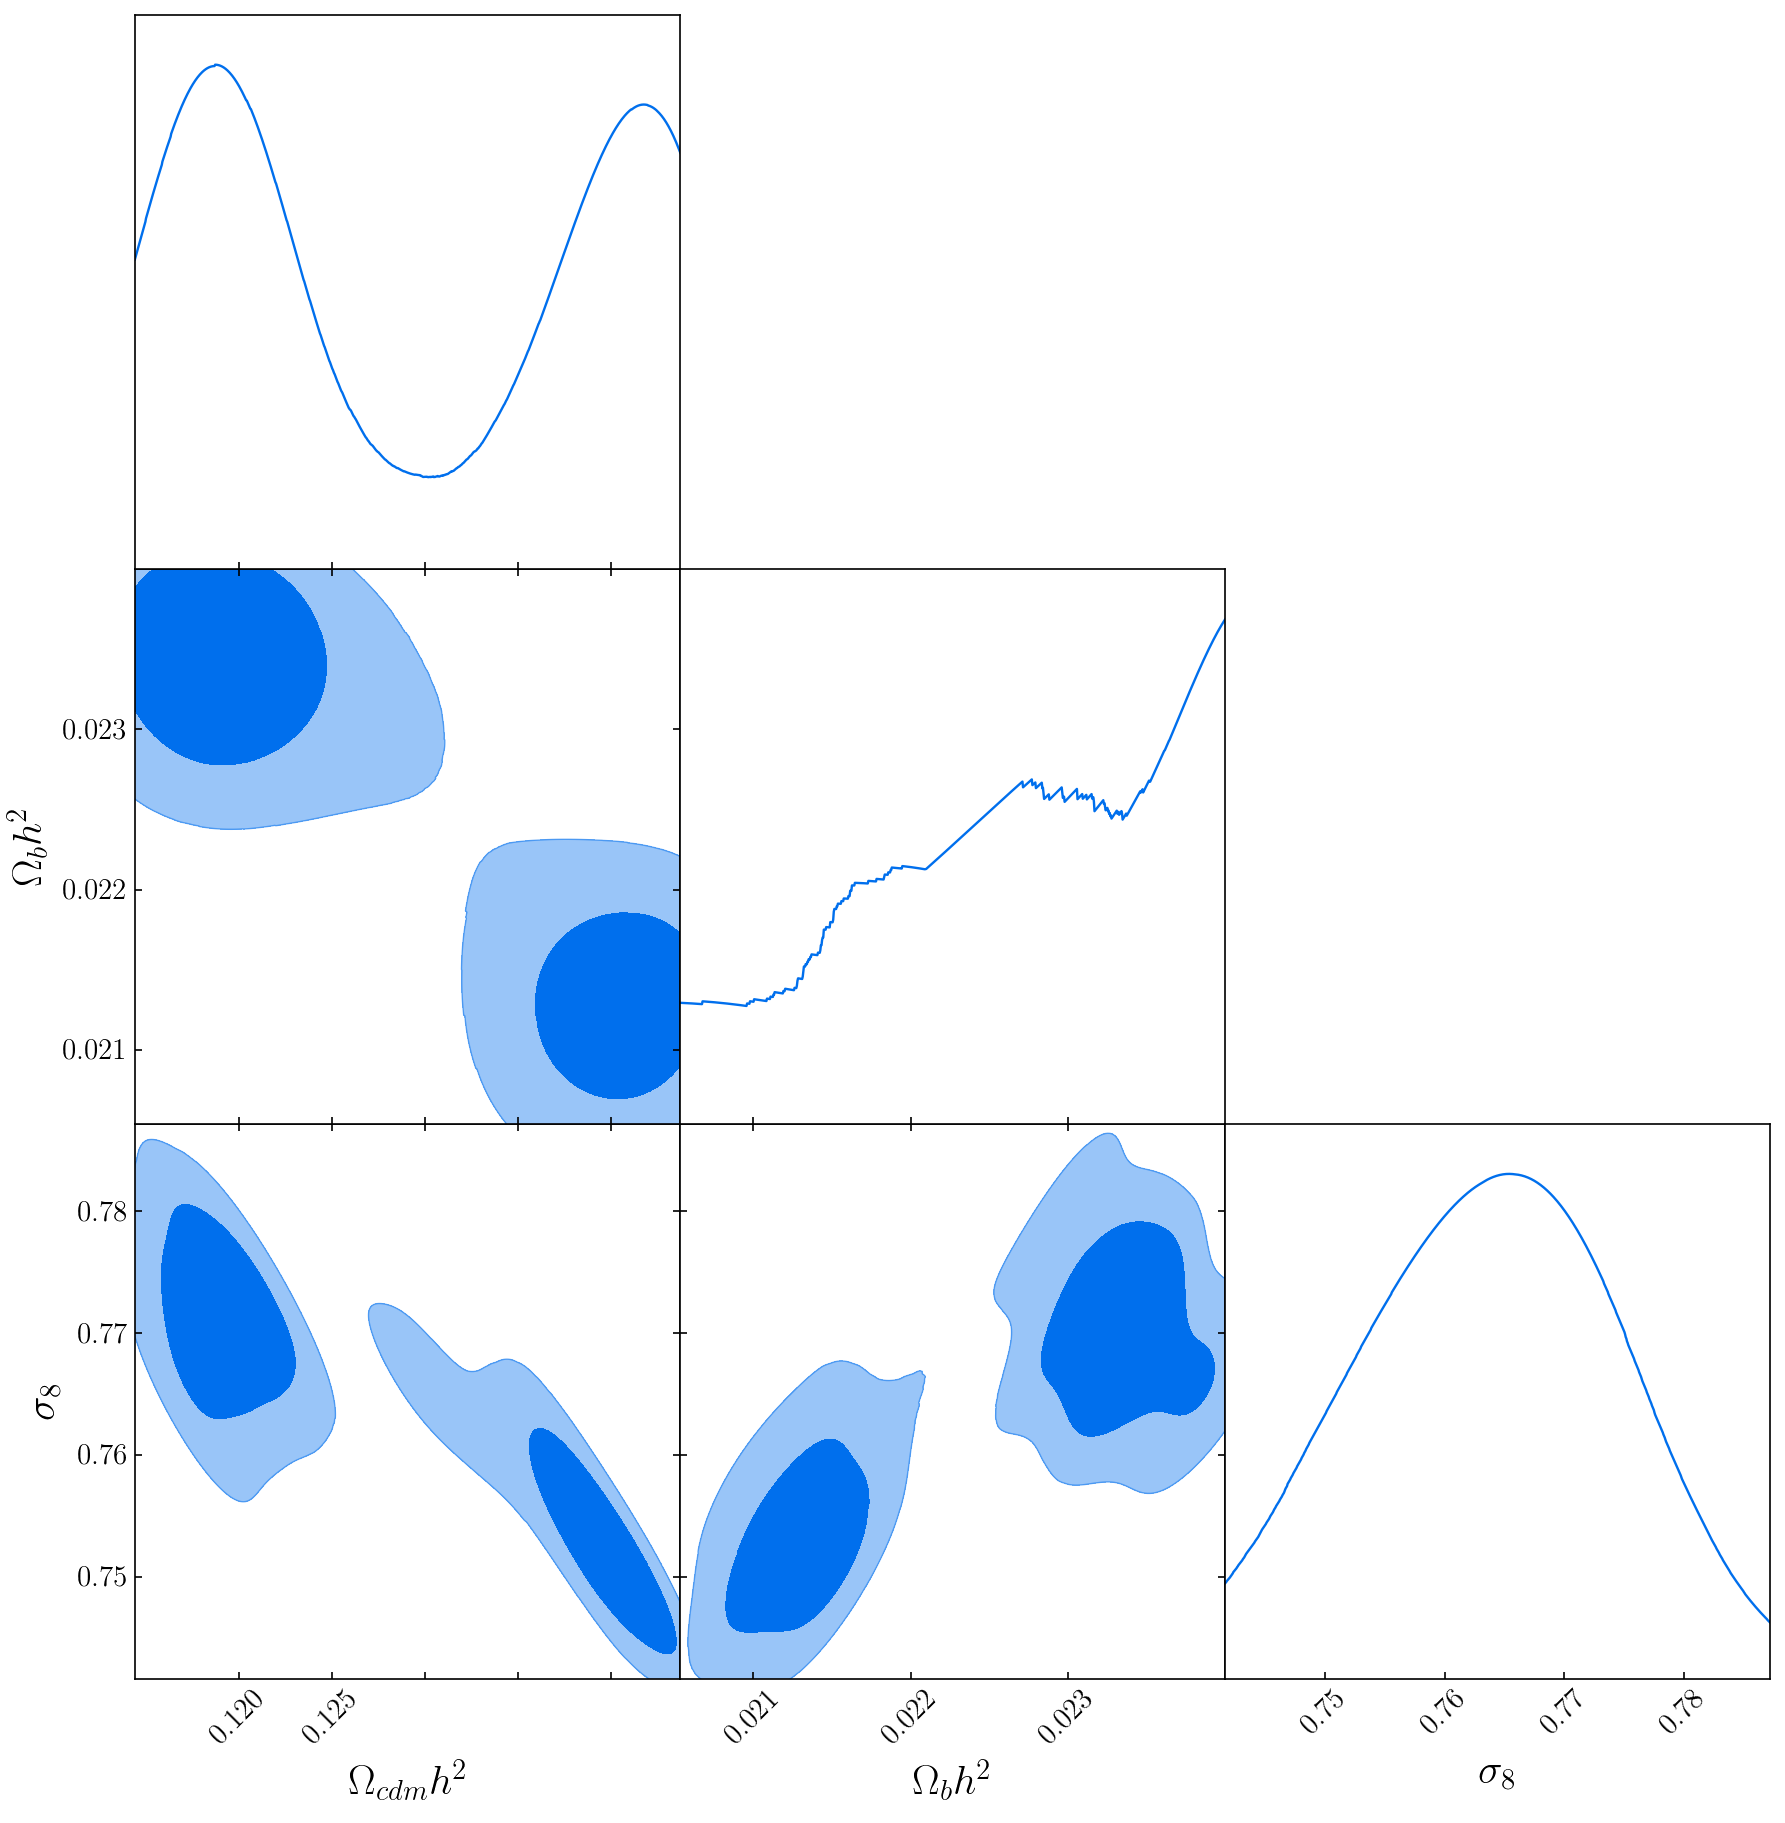

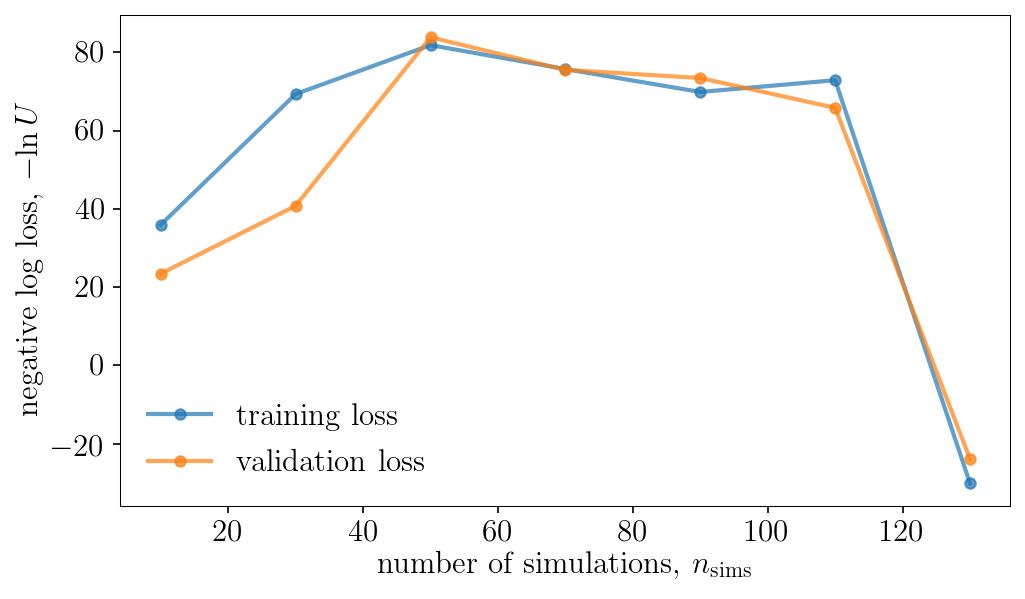

Population 19/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


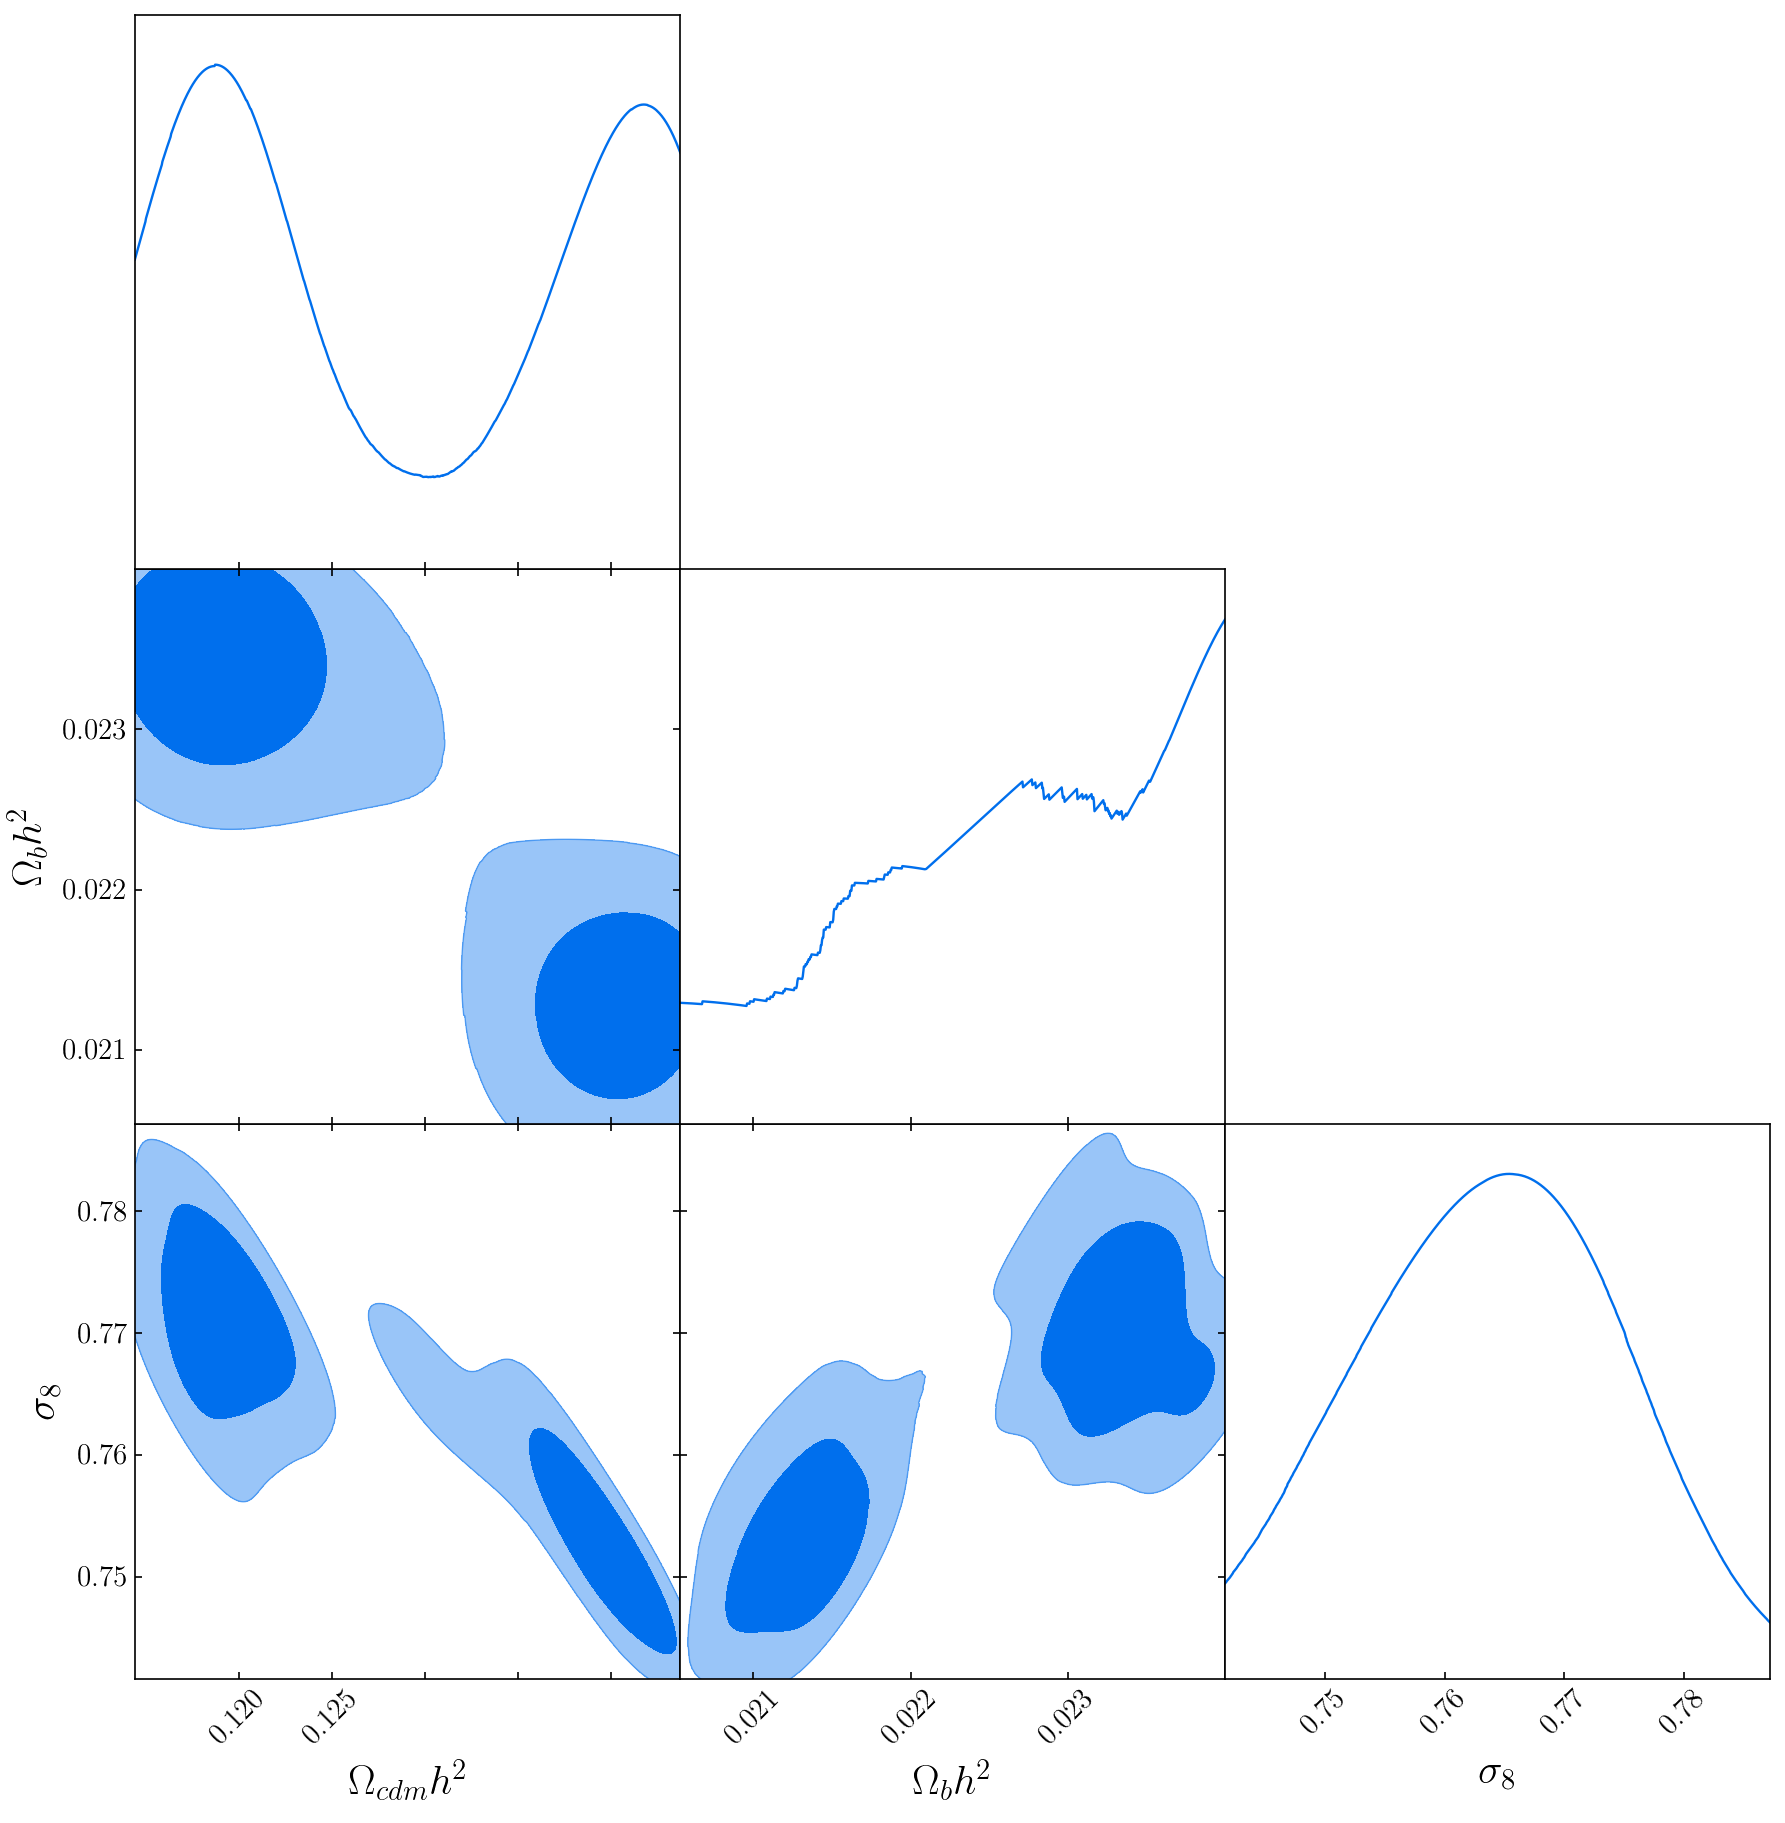

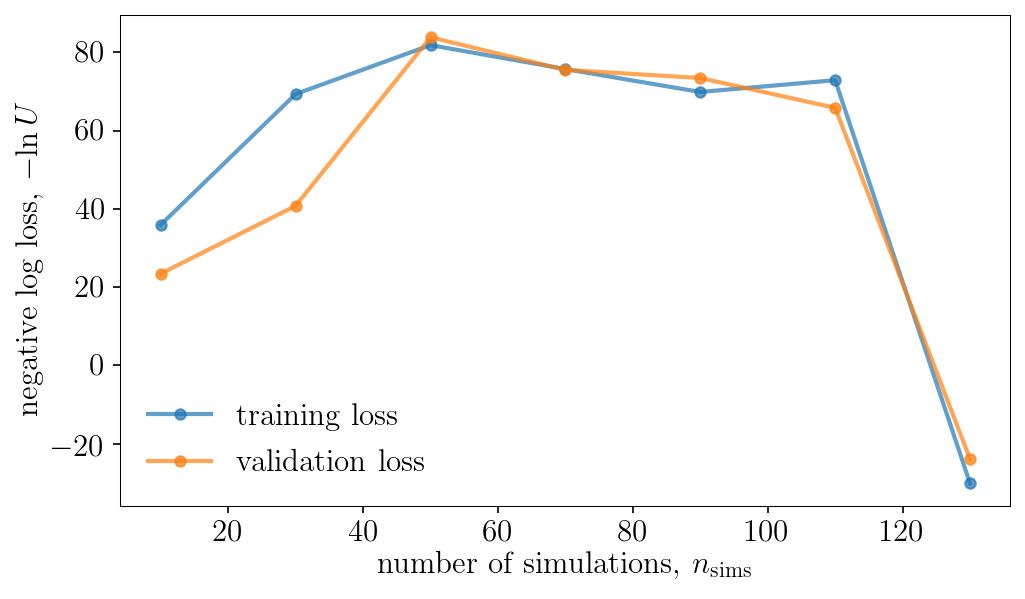

Population 20/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...
Done.
Removed no burn in


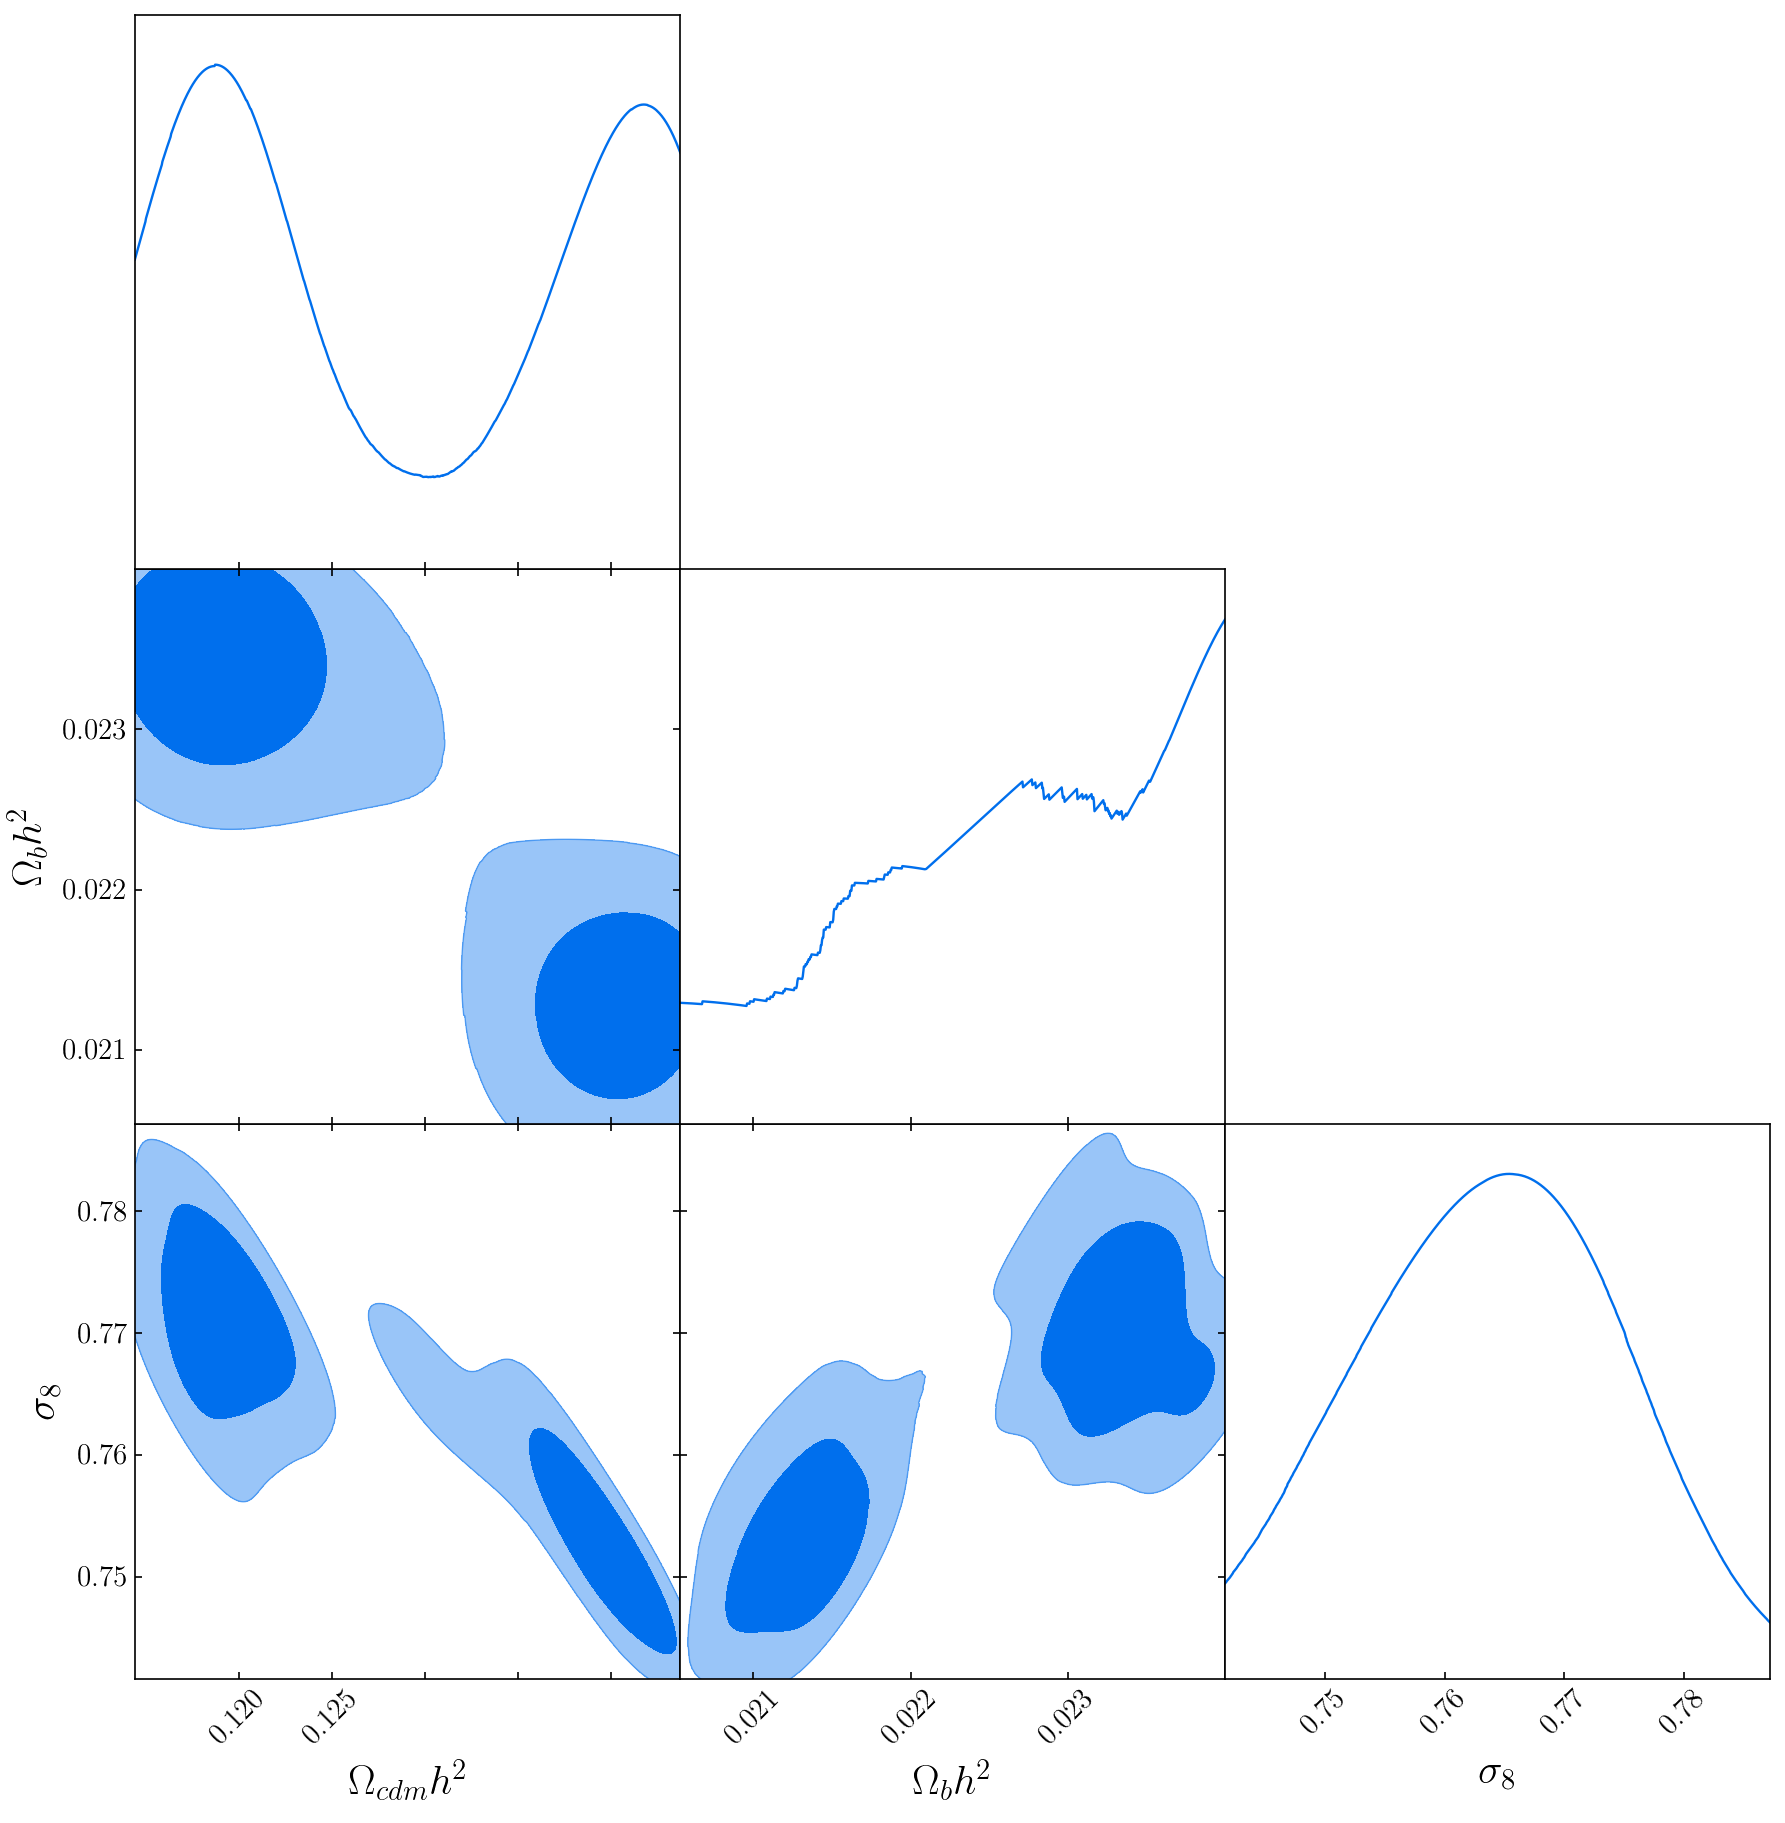

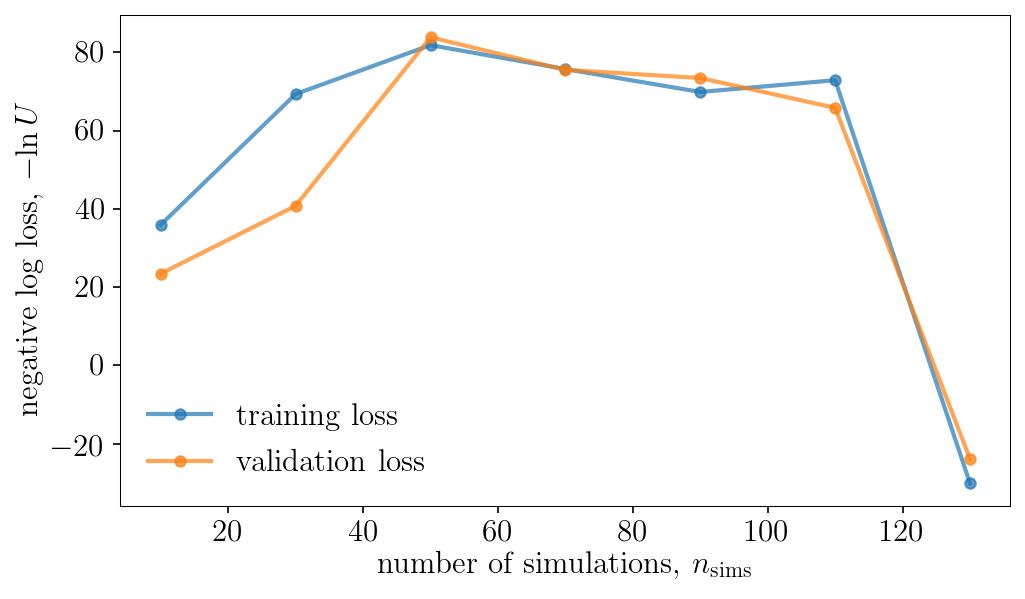

In [19]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)

In [20]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Removed no burn in


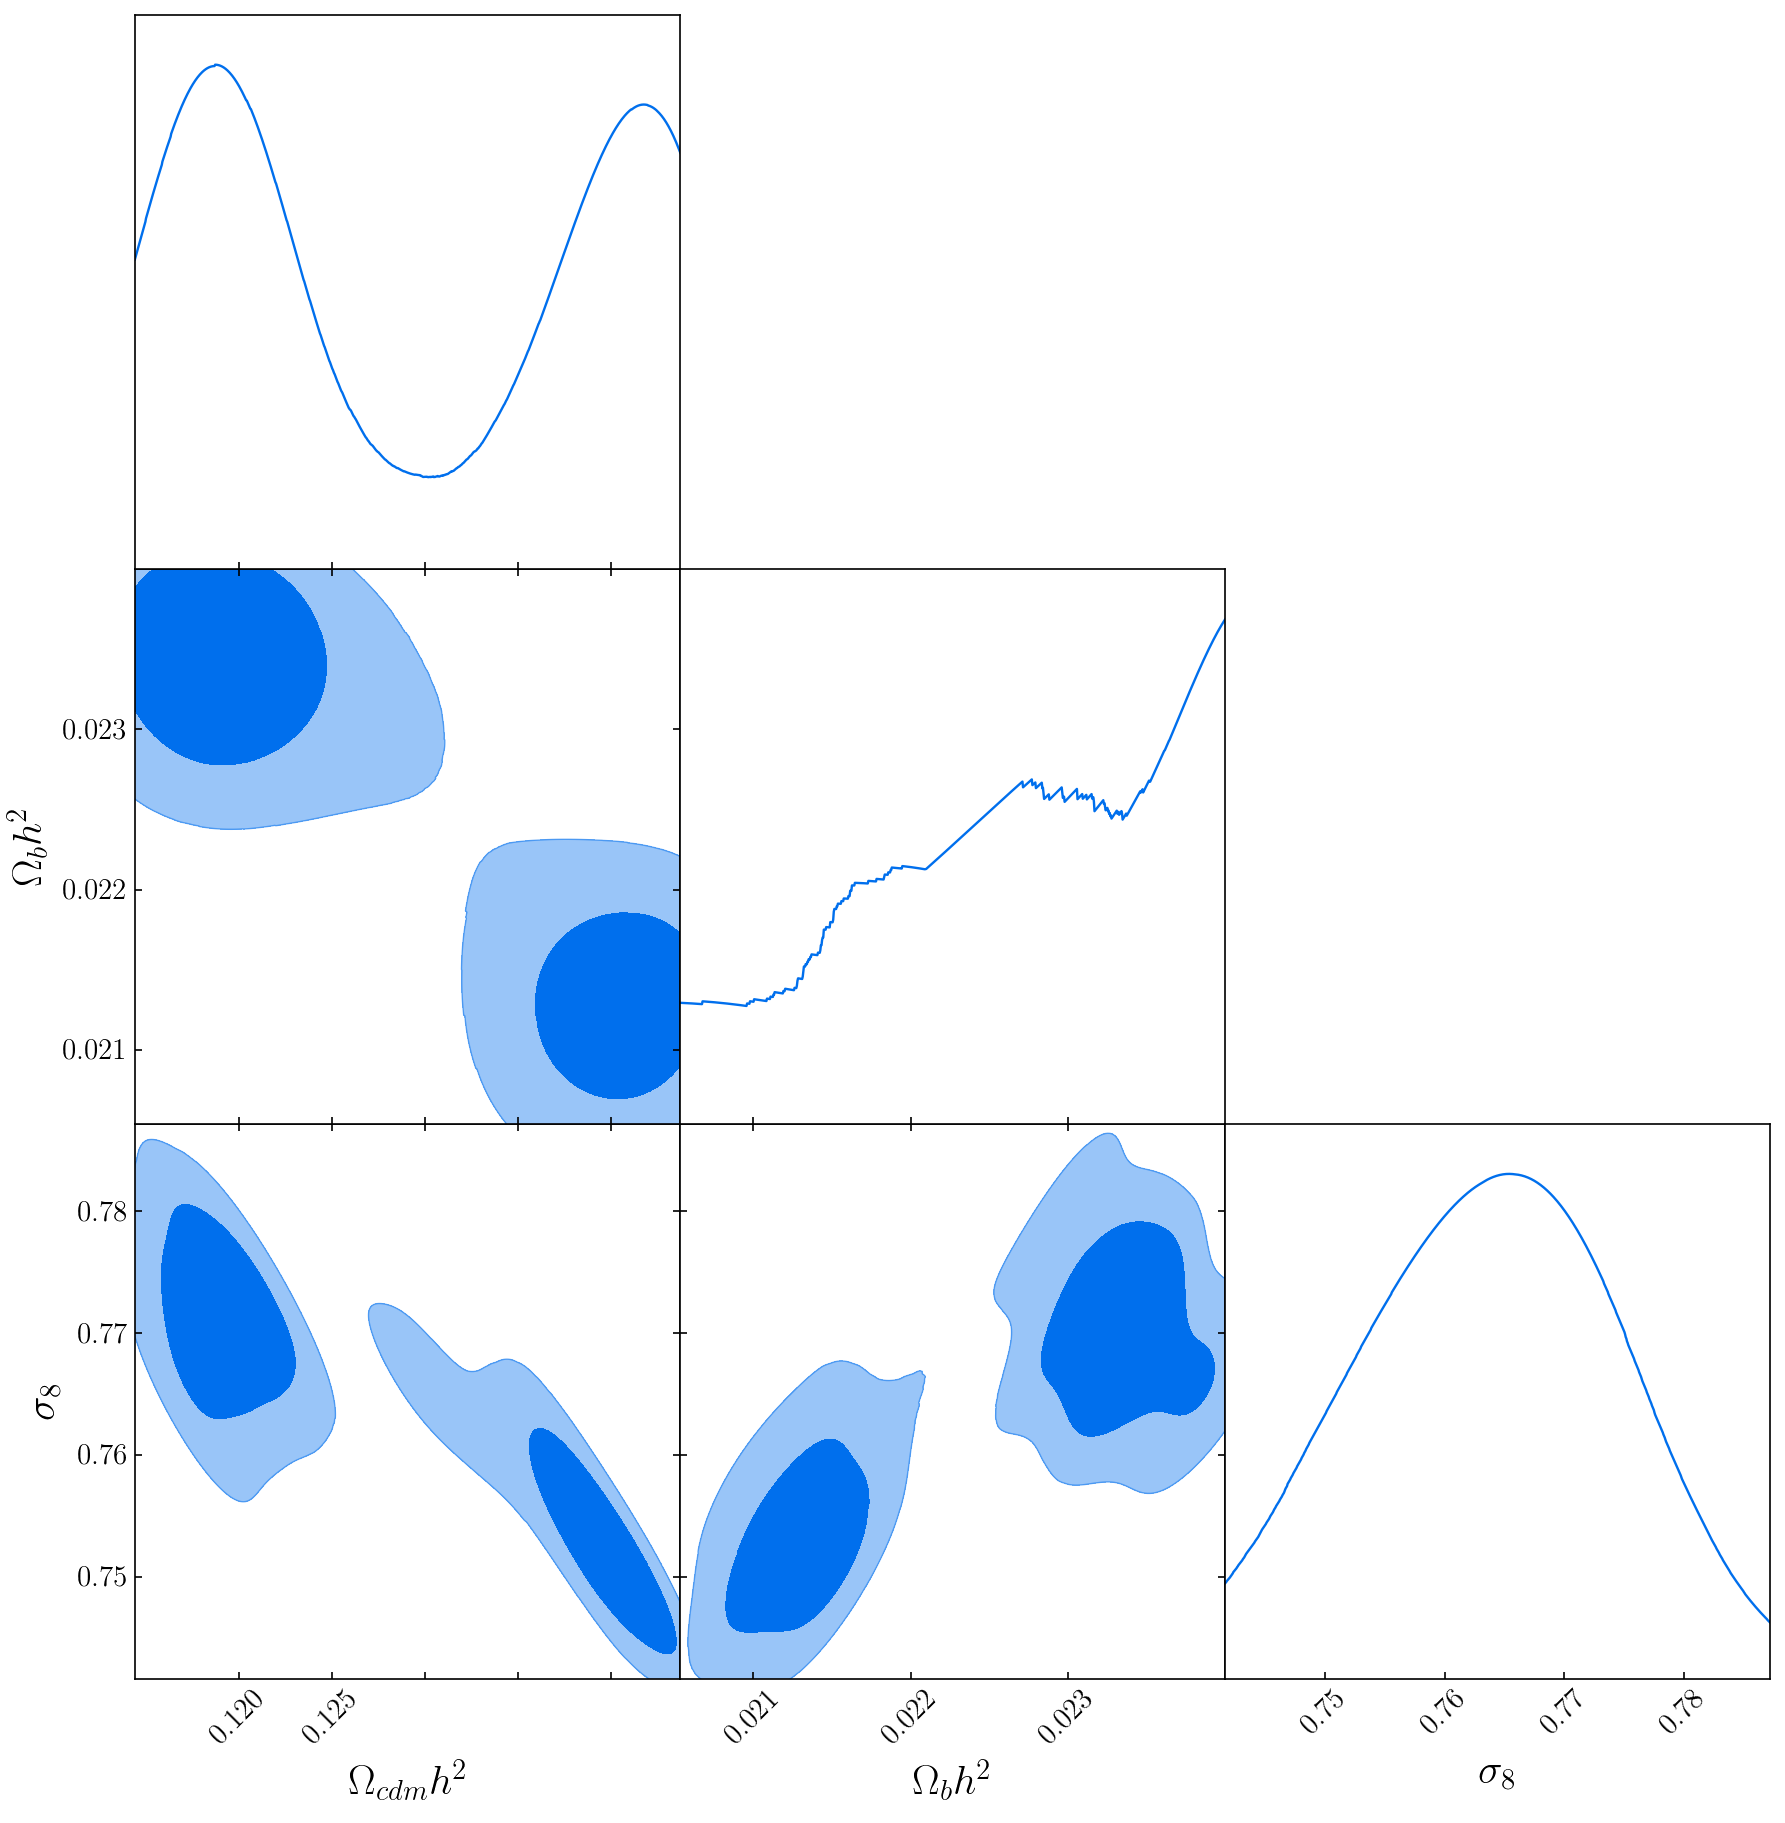

<Figure size 900x600 with 0 Axes>

In [21]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])
plt.savefig('posteriors_3params_20populations.png')

In [22]:
posterior_samples

array([[0.1166769 , 0.02333023, 0.77690101],
       [0.11667737, 0.02302603, 0.78146159],
       [0.11670499, 0.02375674, 0.76770074],
       [0.11672136, 0.02334902, 0.76624376],
       [0.11672718, 0.02352773, 0.76424258],
       [0.11681501, 0.02342823, 0.77035791],
       [0.11684509, 0.02298694, 0.77976012],
       [0.11689255, 0.02377858, 0.76923088],
       [0.11695883, 0.0233259 , 0.77260899],
       [0.11696411, 0.02341206, 0.7713084 ],
       [0.11698918, 0.02346046, 0.76865586],
       [0.11706186, 0.02384651, 0.76192477],
       [0.11706491, 0.02341257, 0.77233483],
       [0.11706614, 0.02331125, 0.76675694],
       [0.11708958, 0.023342  , 0.76642885],
       [0.11713053, 0.02373388, 0.76103387],
       [0.11716344, 0.02377216, 0.76398106],
       [0.11716471, 0.02322213, 0.76853584],
       [0.1172039 , 0.0233883 , 0.77180102],
       [0.11722128, 0.02324421, 0.77006265],
       [0.11724963, 0.02290577, 0.77776641],
       [0.1172594 , 0.02333544, 0.7704363 ],
       [0.

## Attempt 3

In [28]:
DelfiEnsemble = delfi.Delfi(N_counts_data.reshape(20), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_3/")

In [29]:
n_initial = 100 #200
n_batch = 100 #200
n_populations = 20 #20

Sampling approximate posterior...
Done.
Removed no burn in


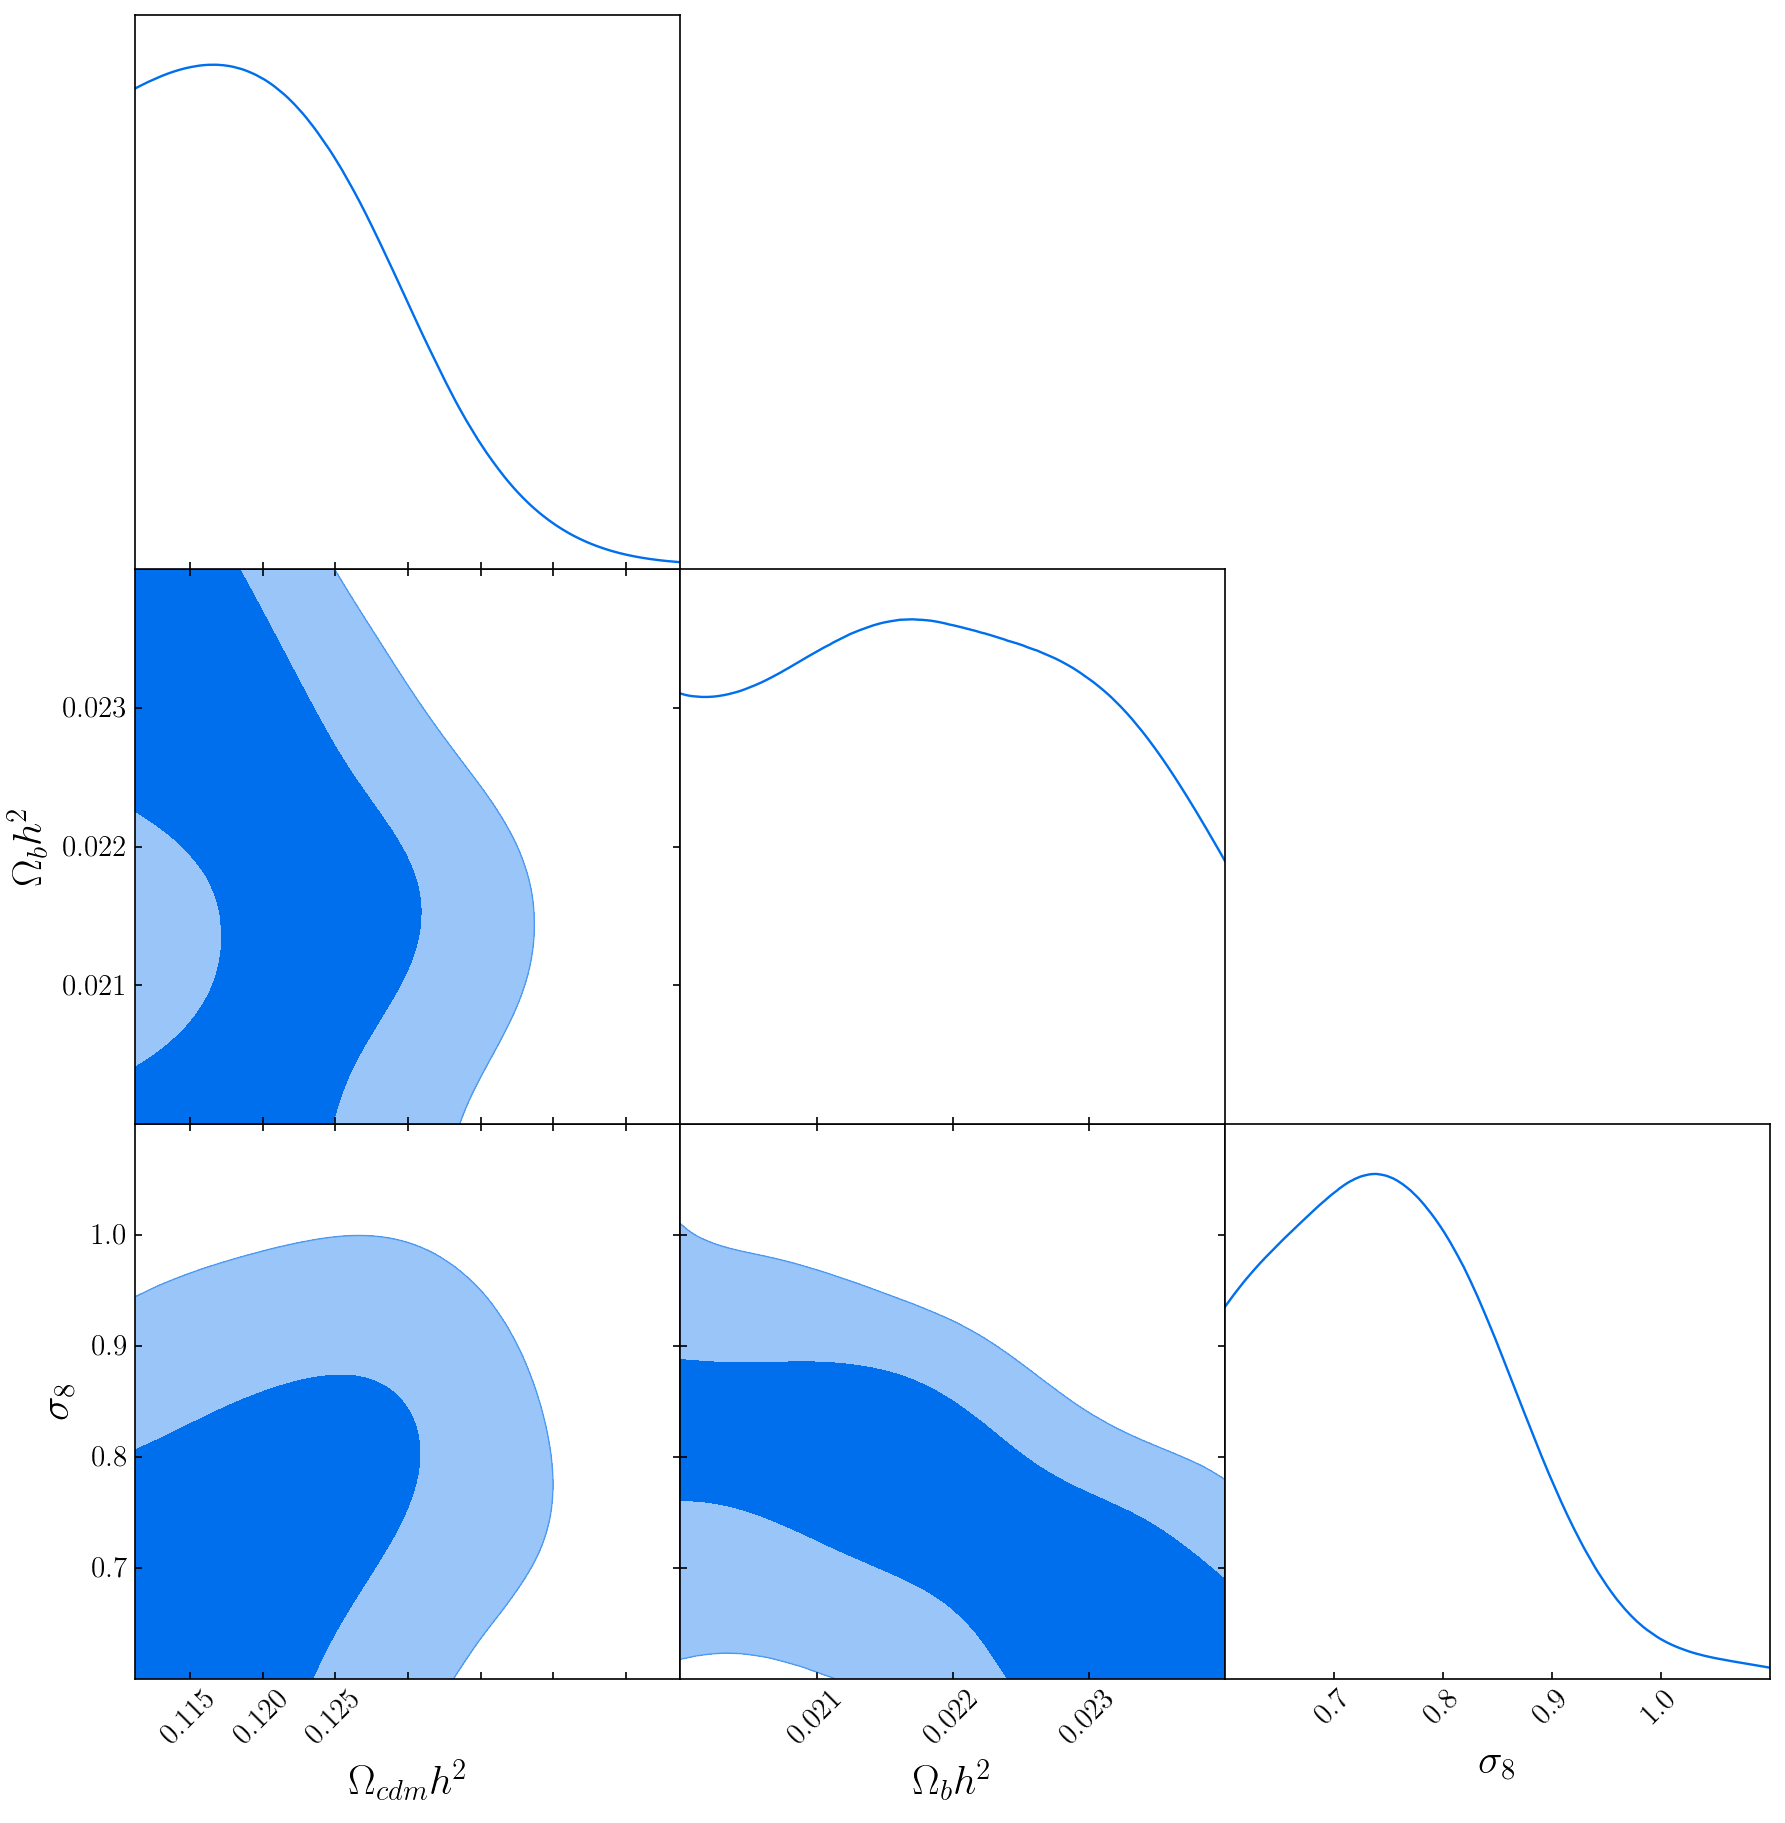

Population 1/20
Sampling proposal density...
Done.


Sampling approximate posterior...


/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Done.
Removed no burn in


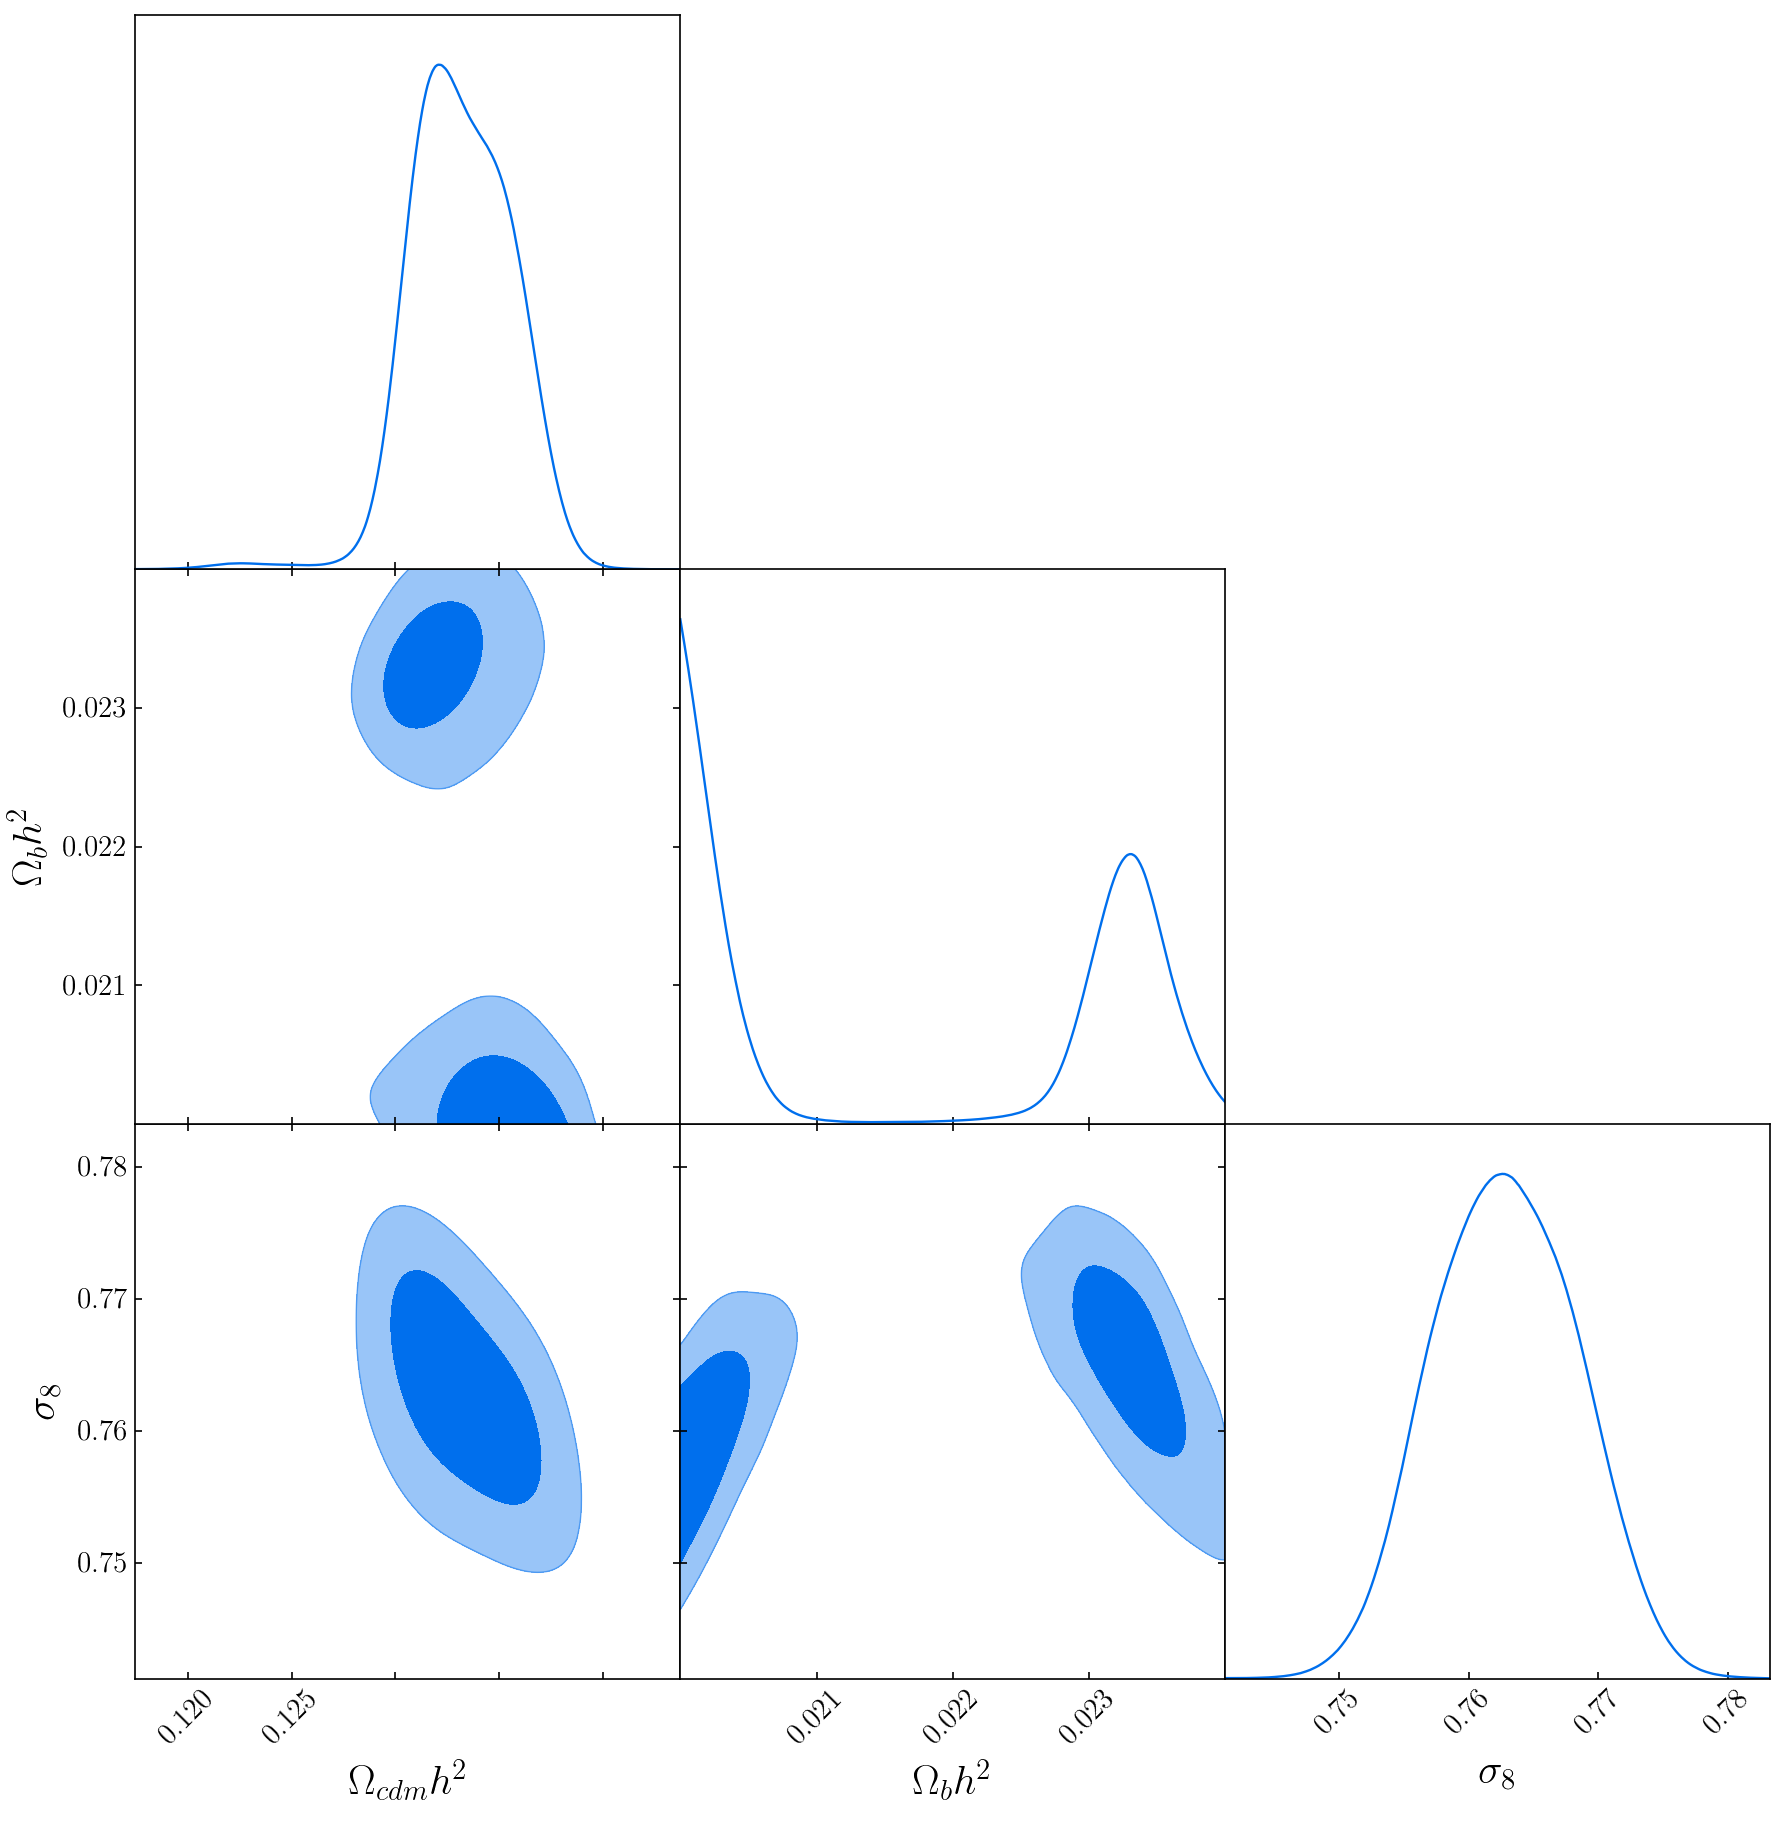

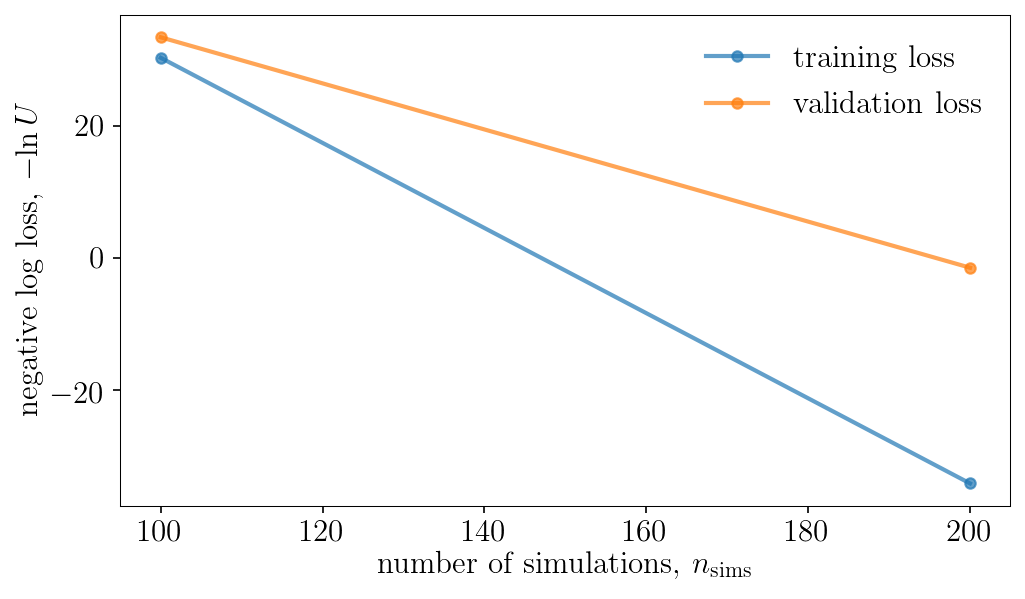

Population 2/20
Sampling proposal density...


/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


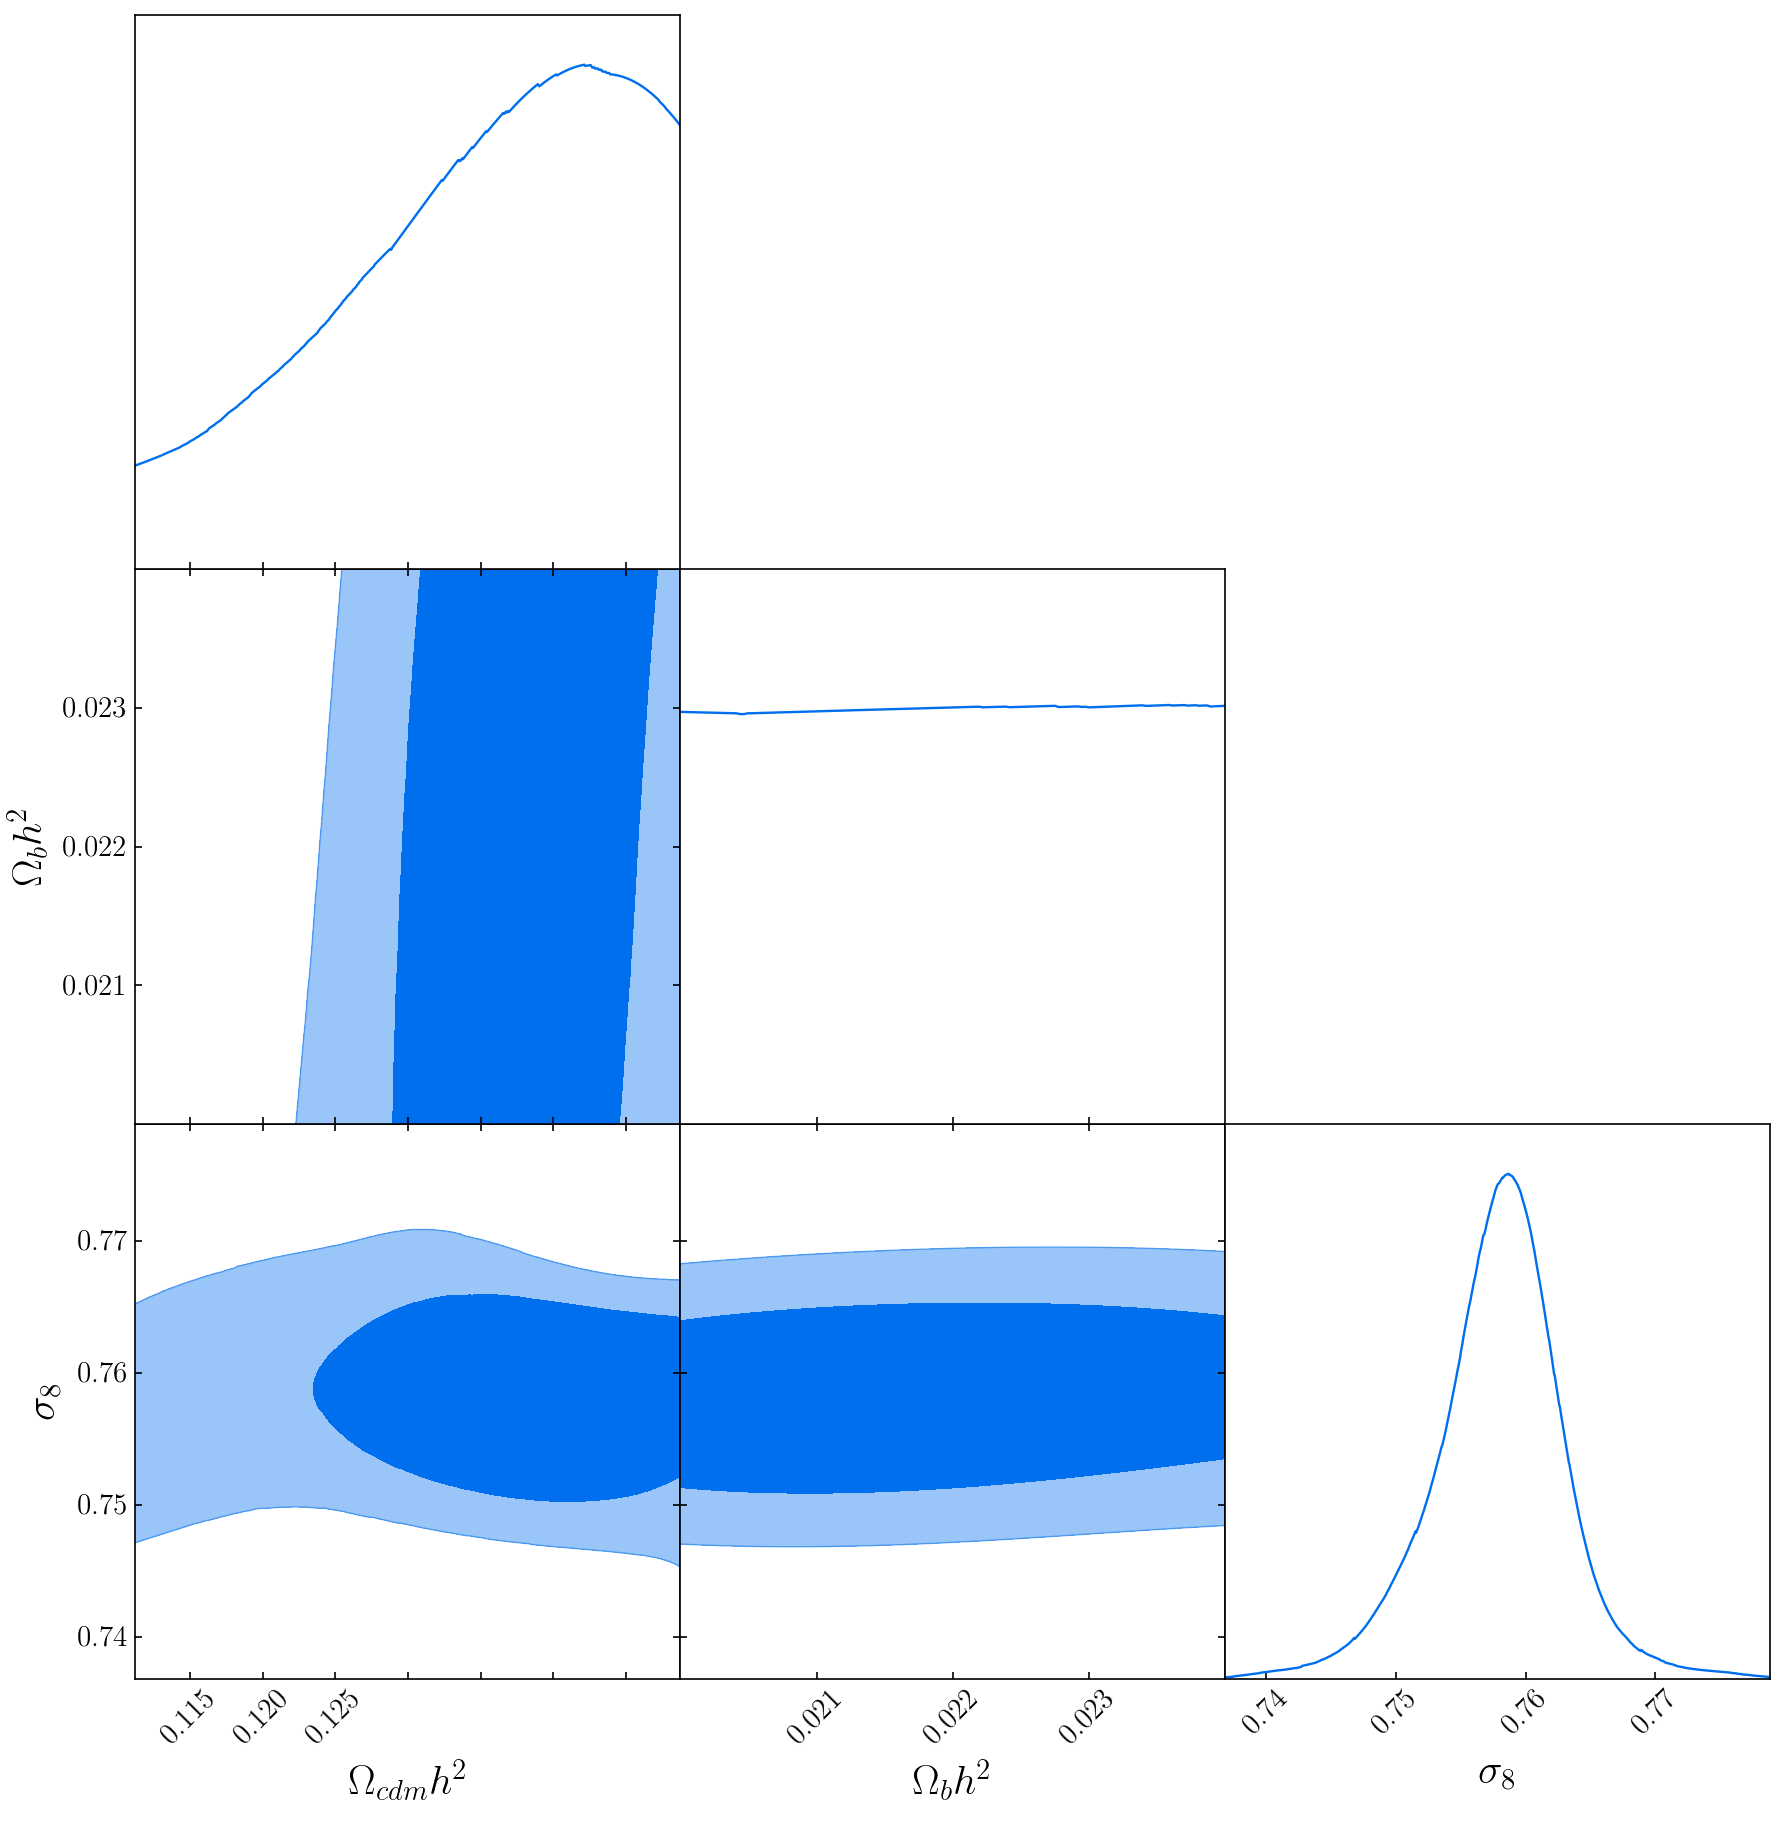

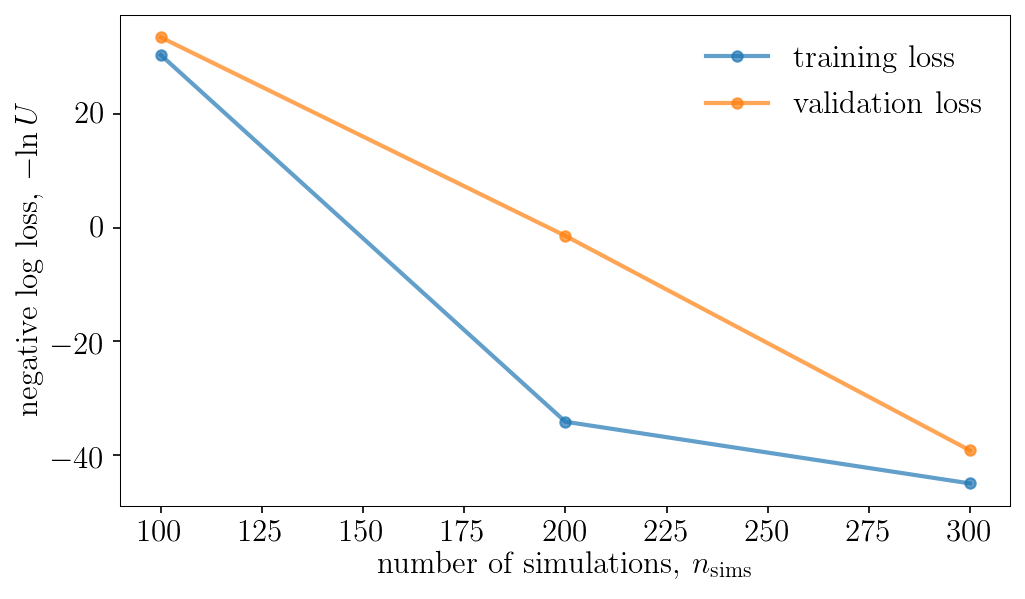

Population 3/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


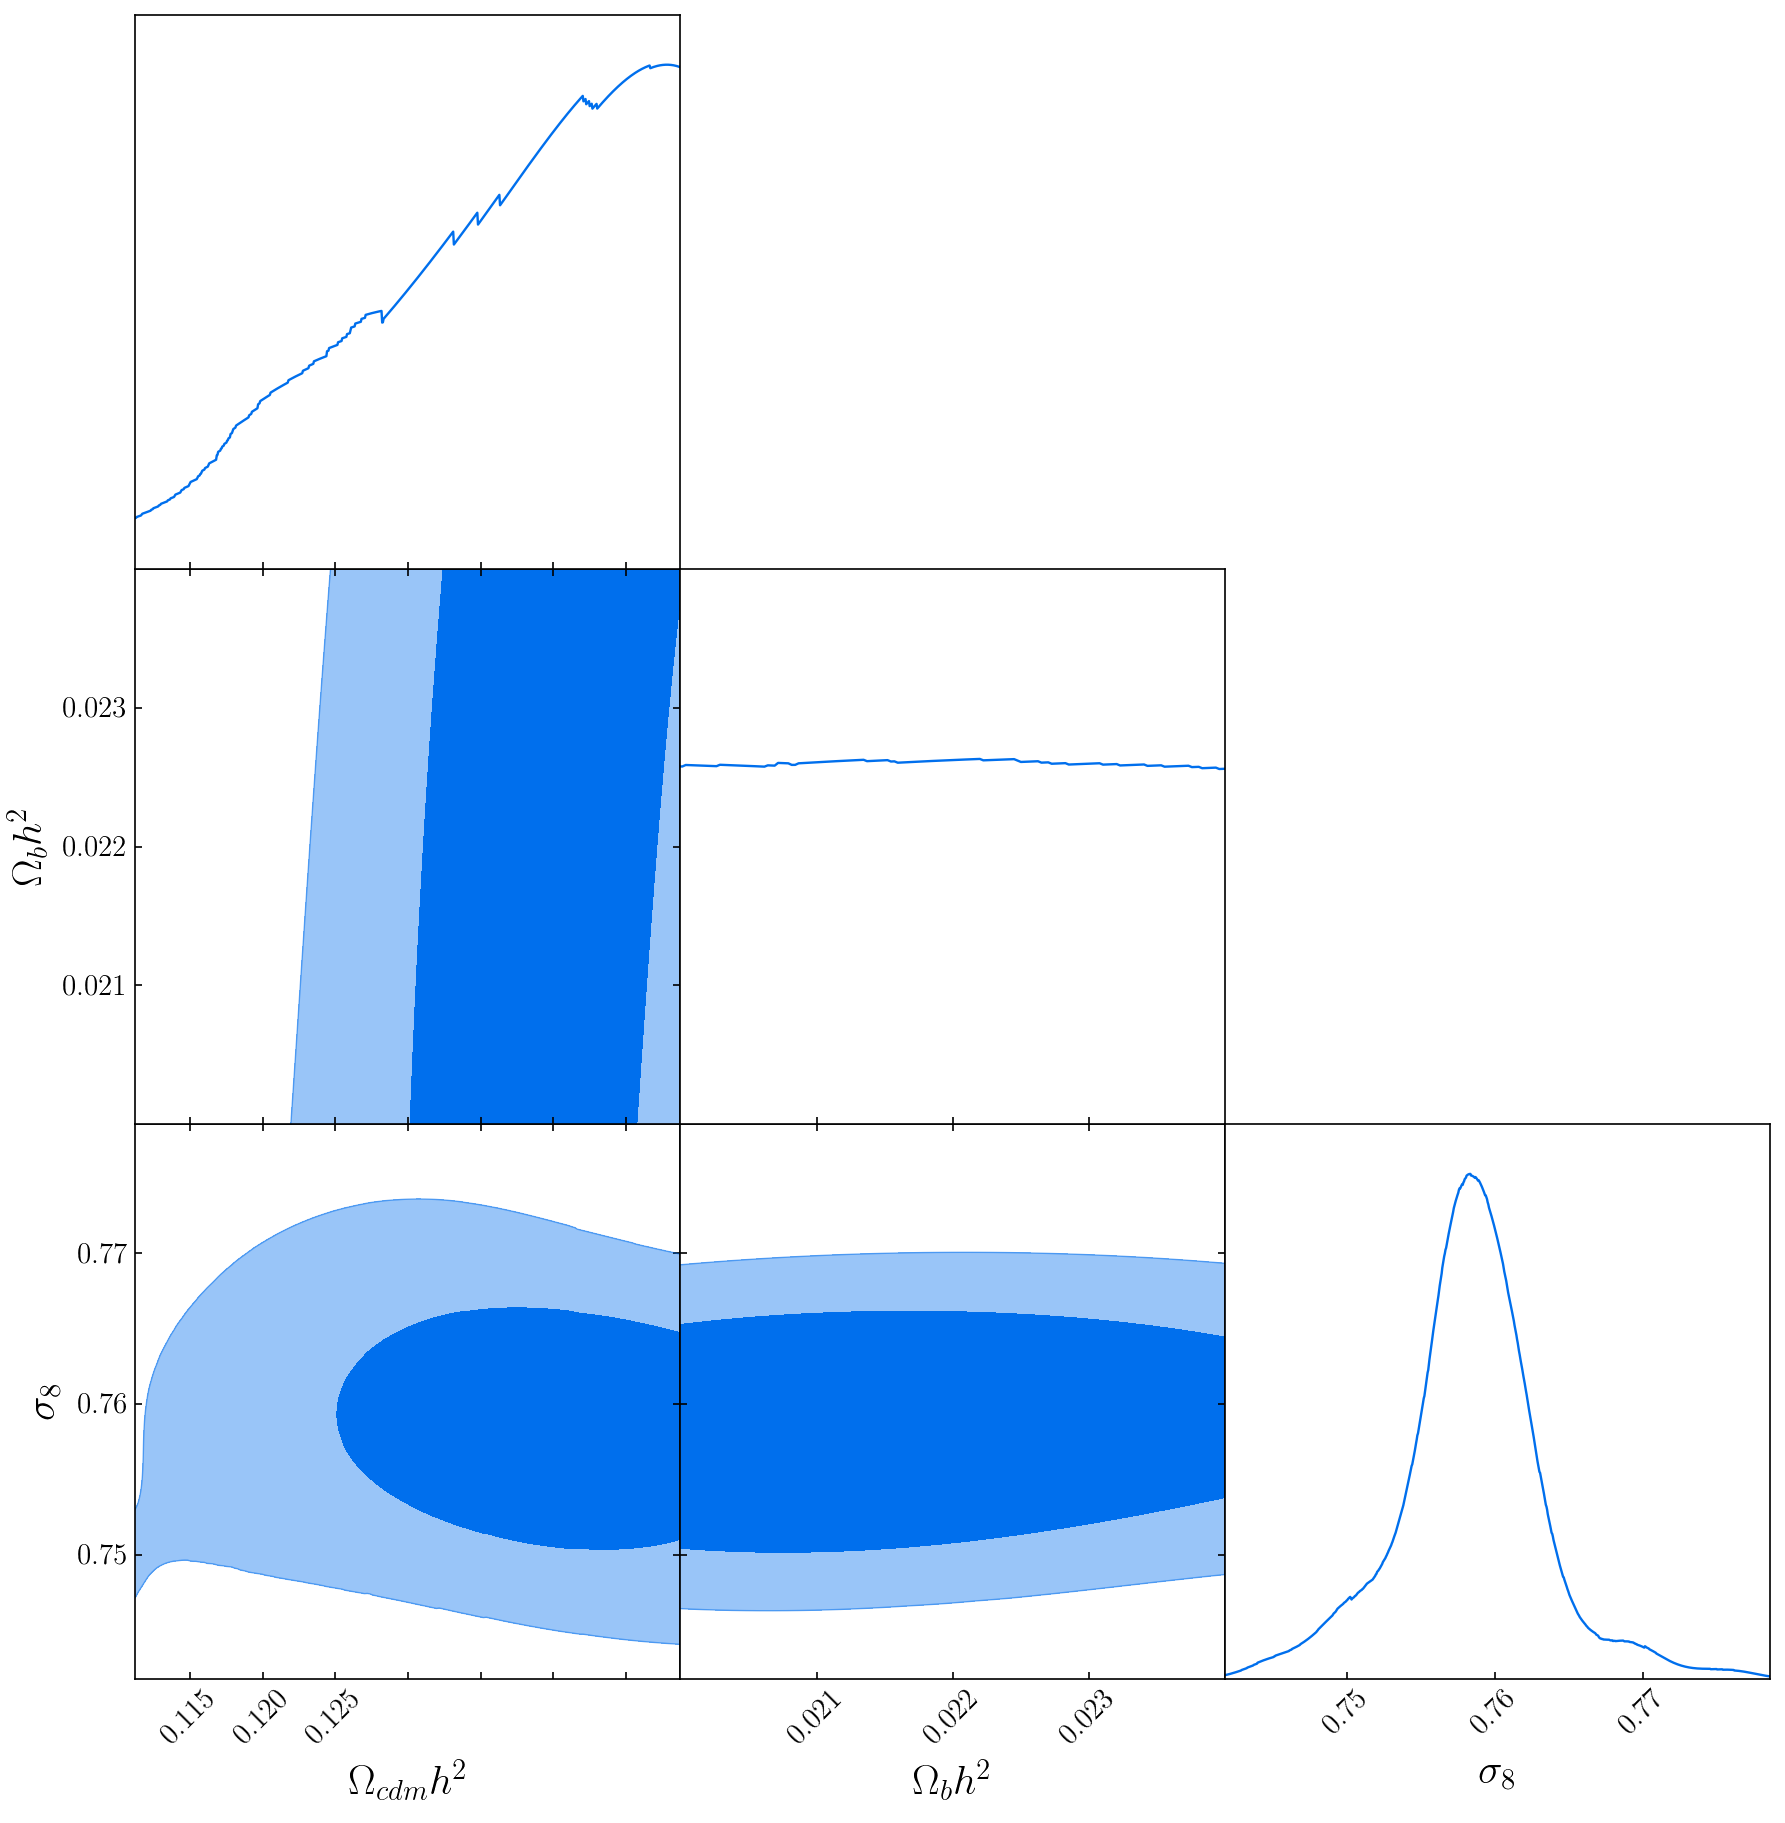

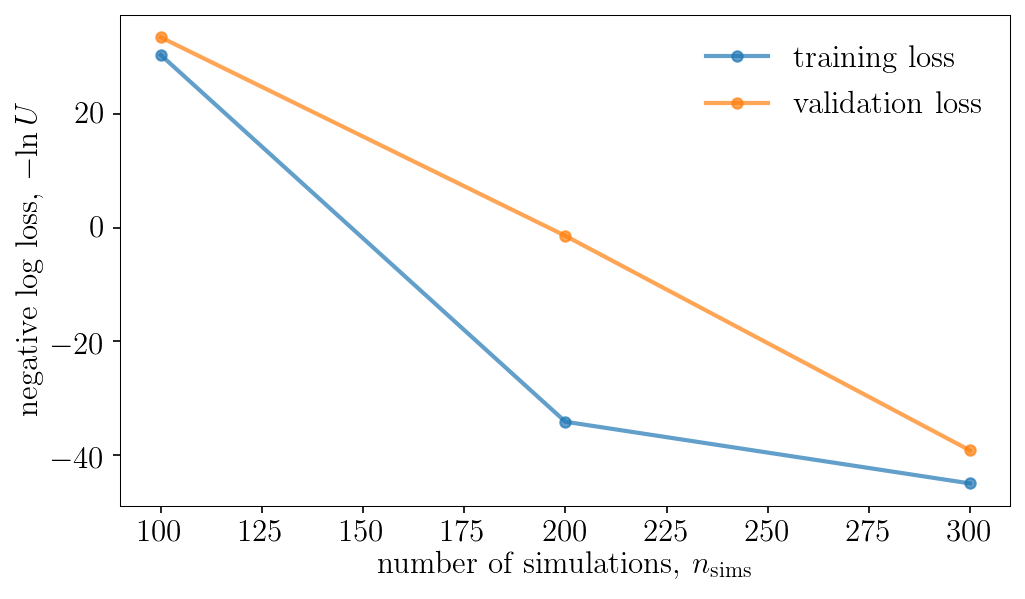

Population 4/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


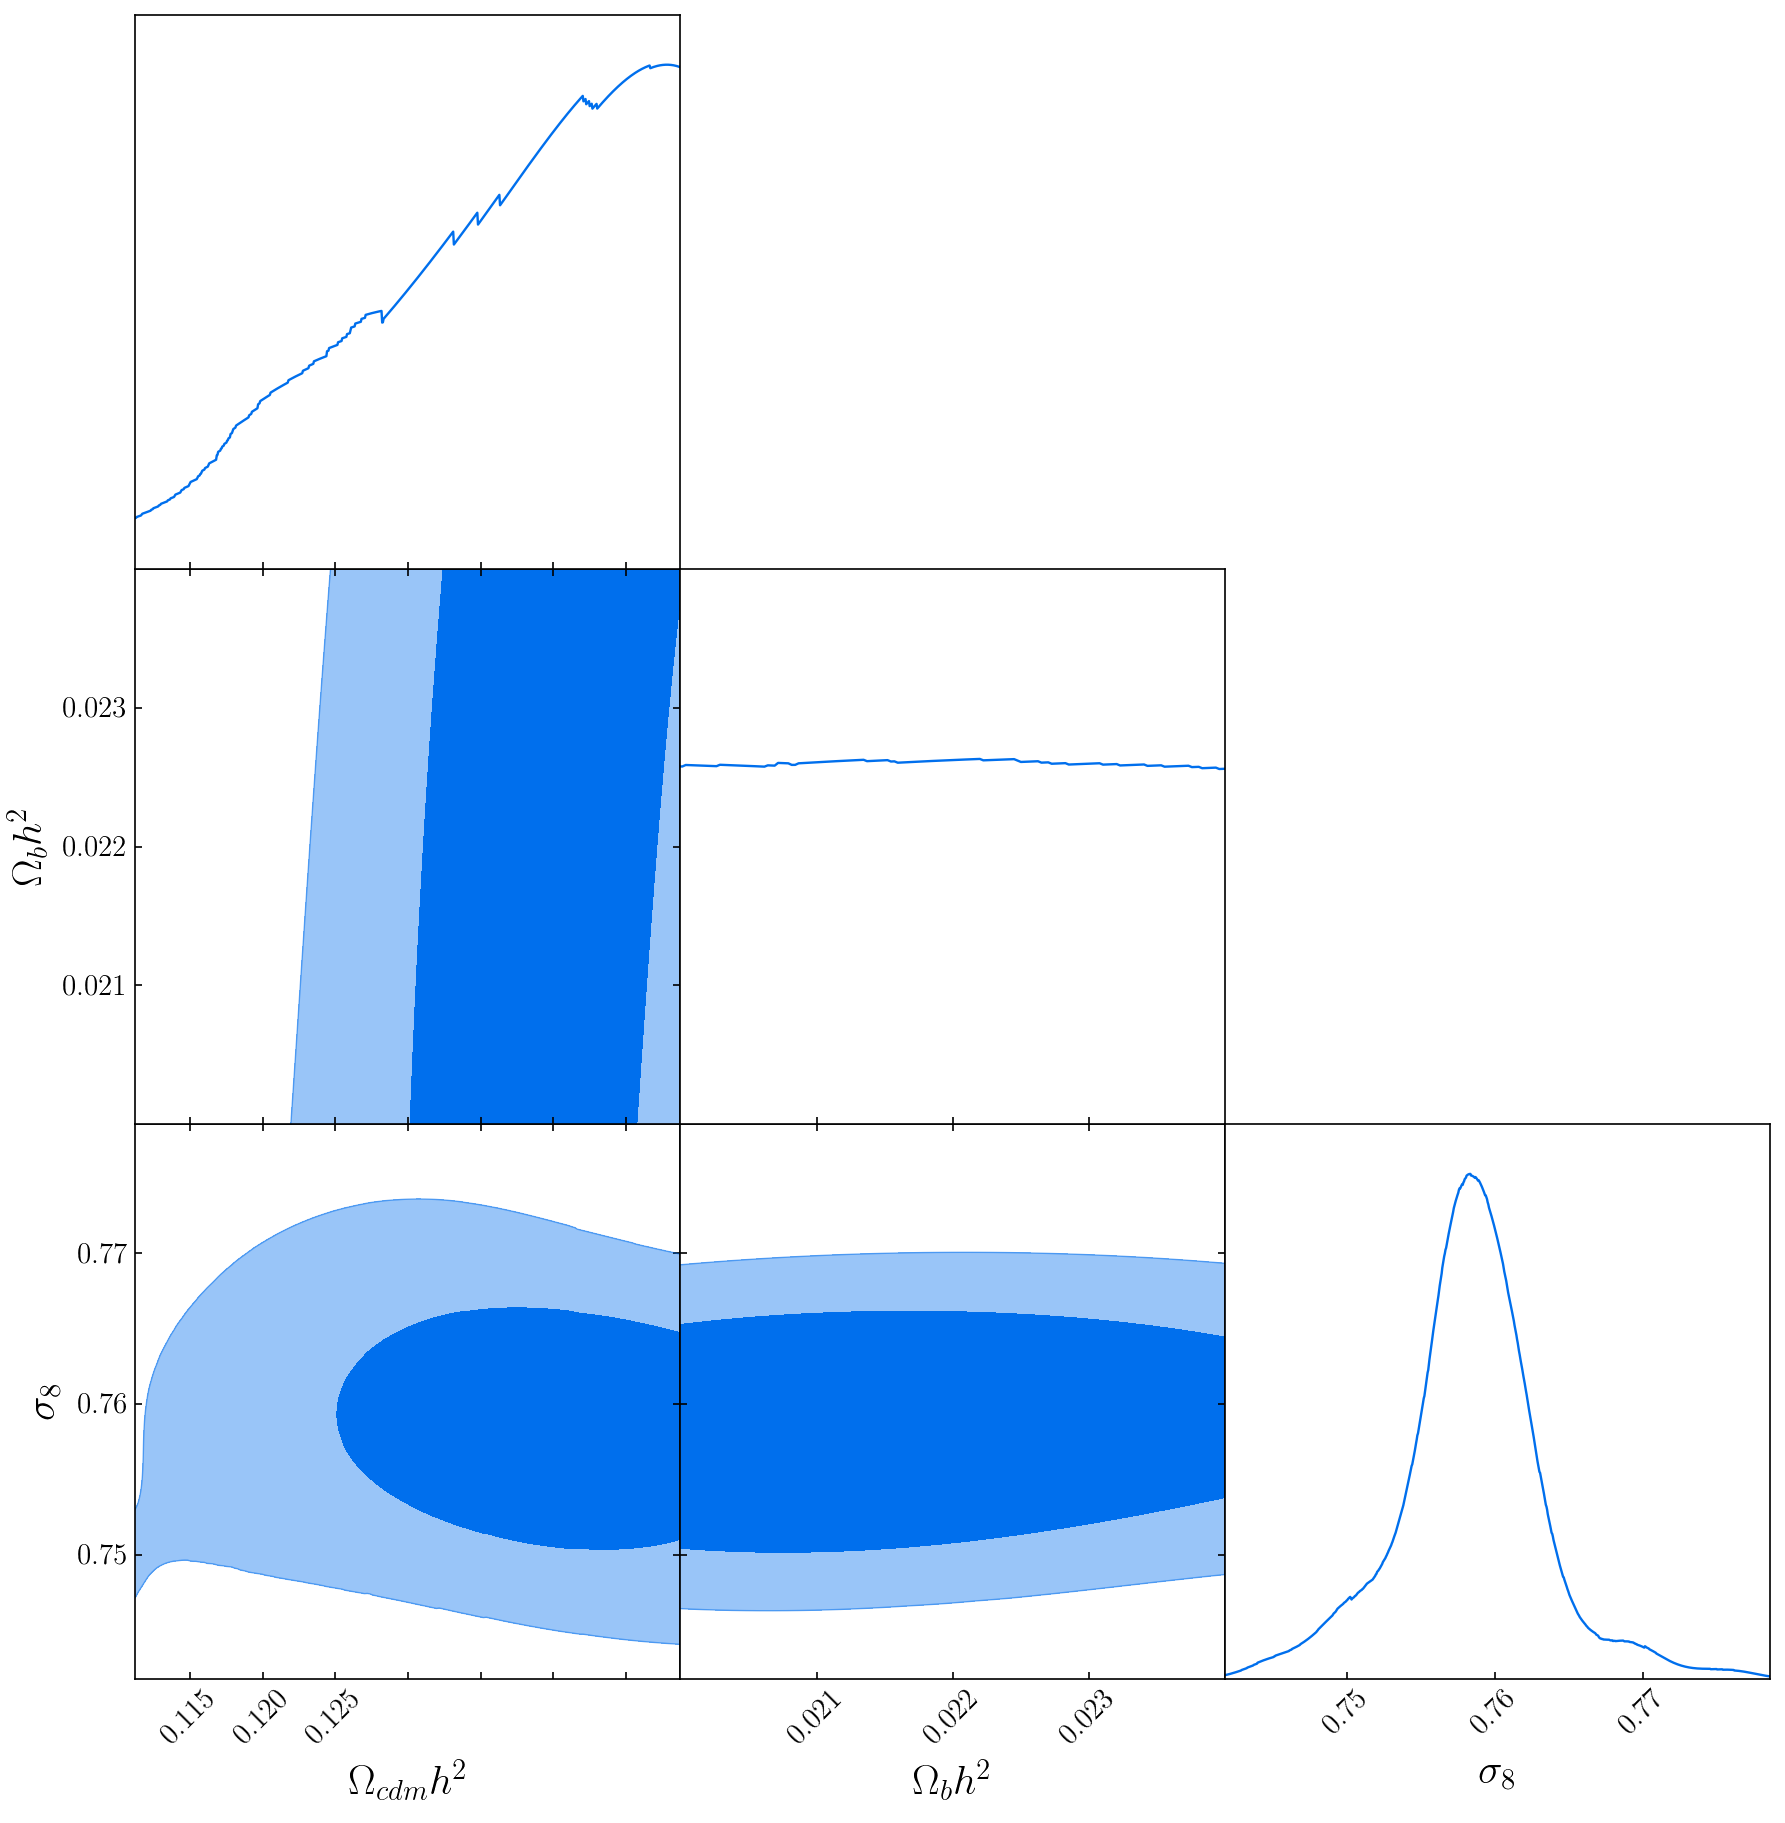

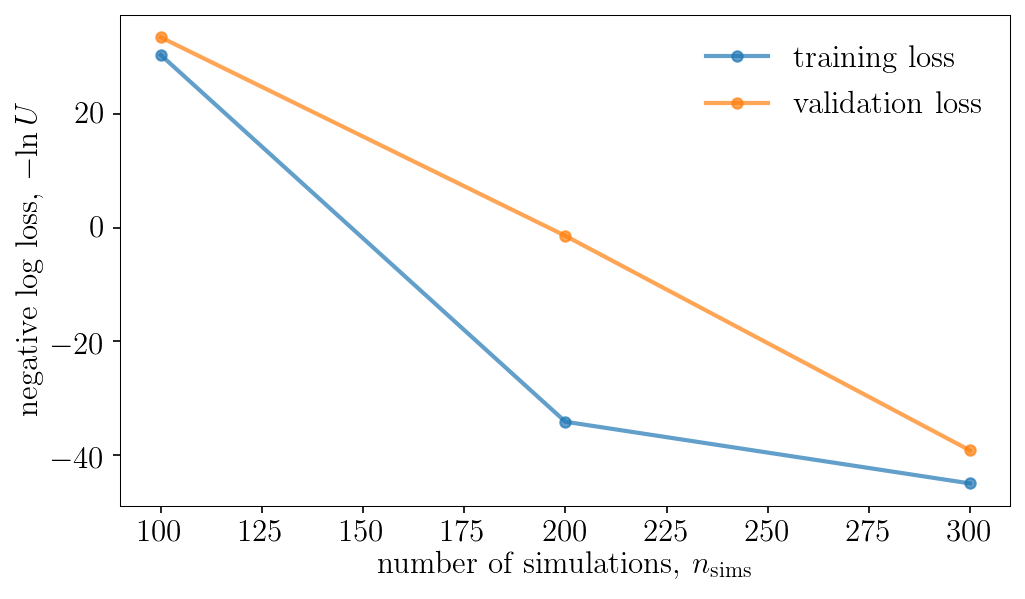

Population 5/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


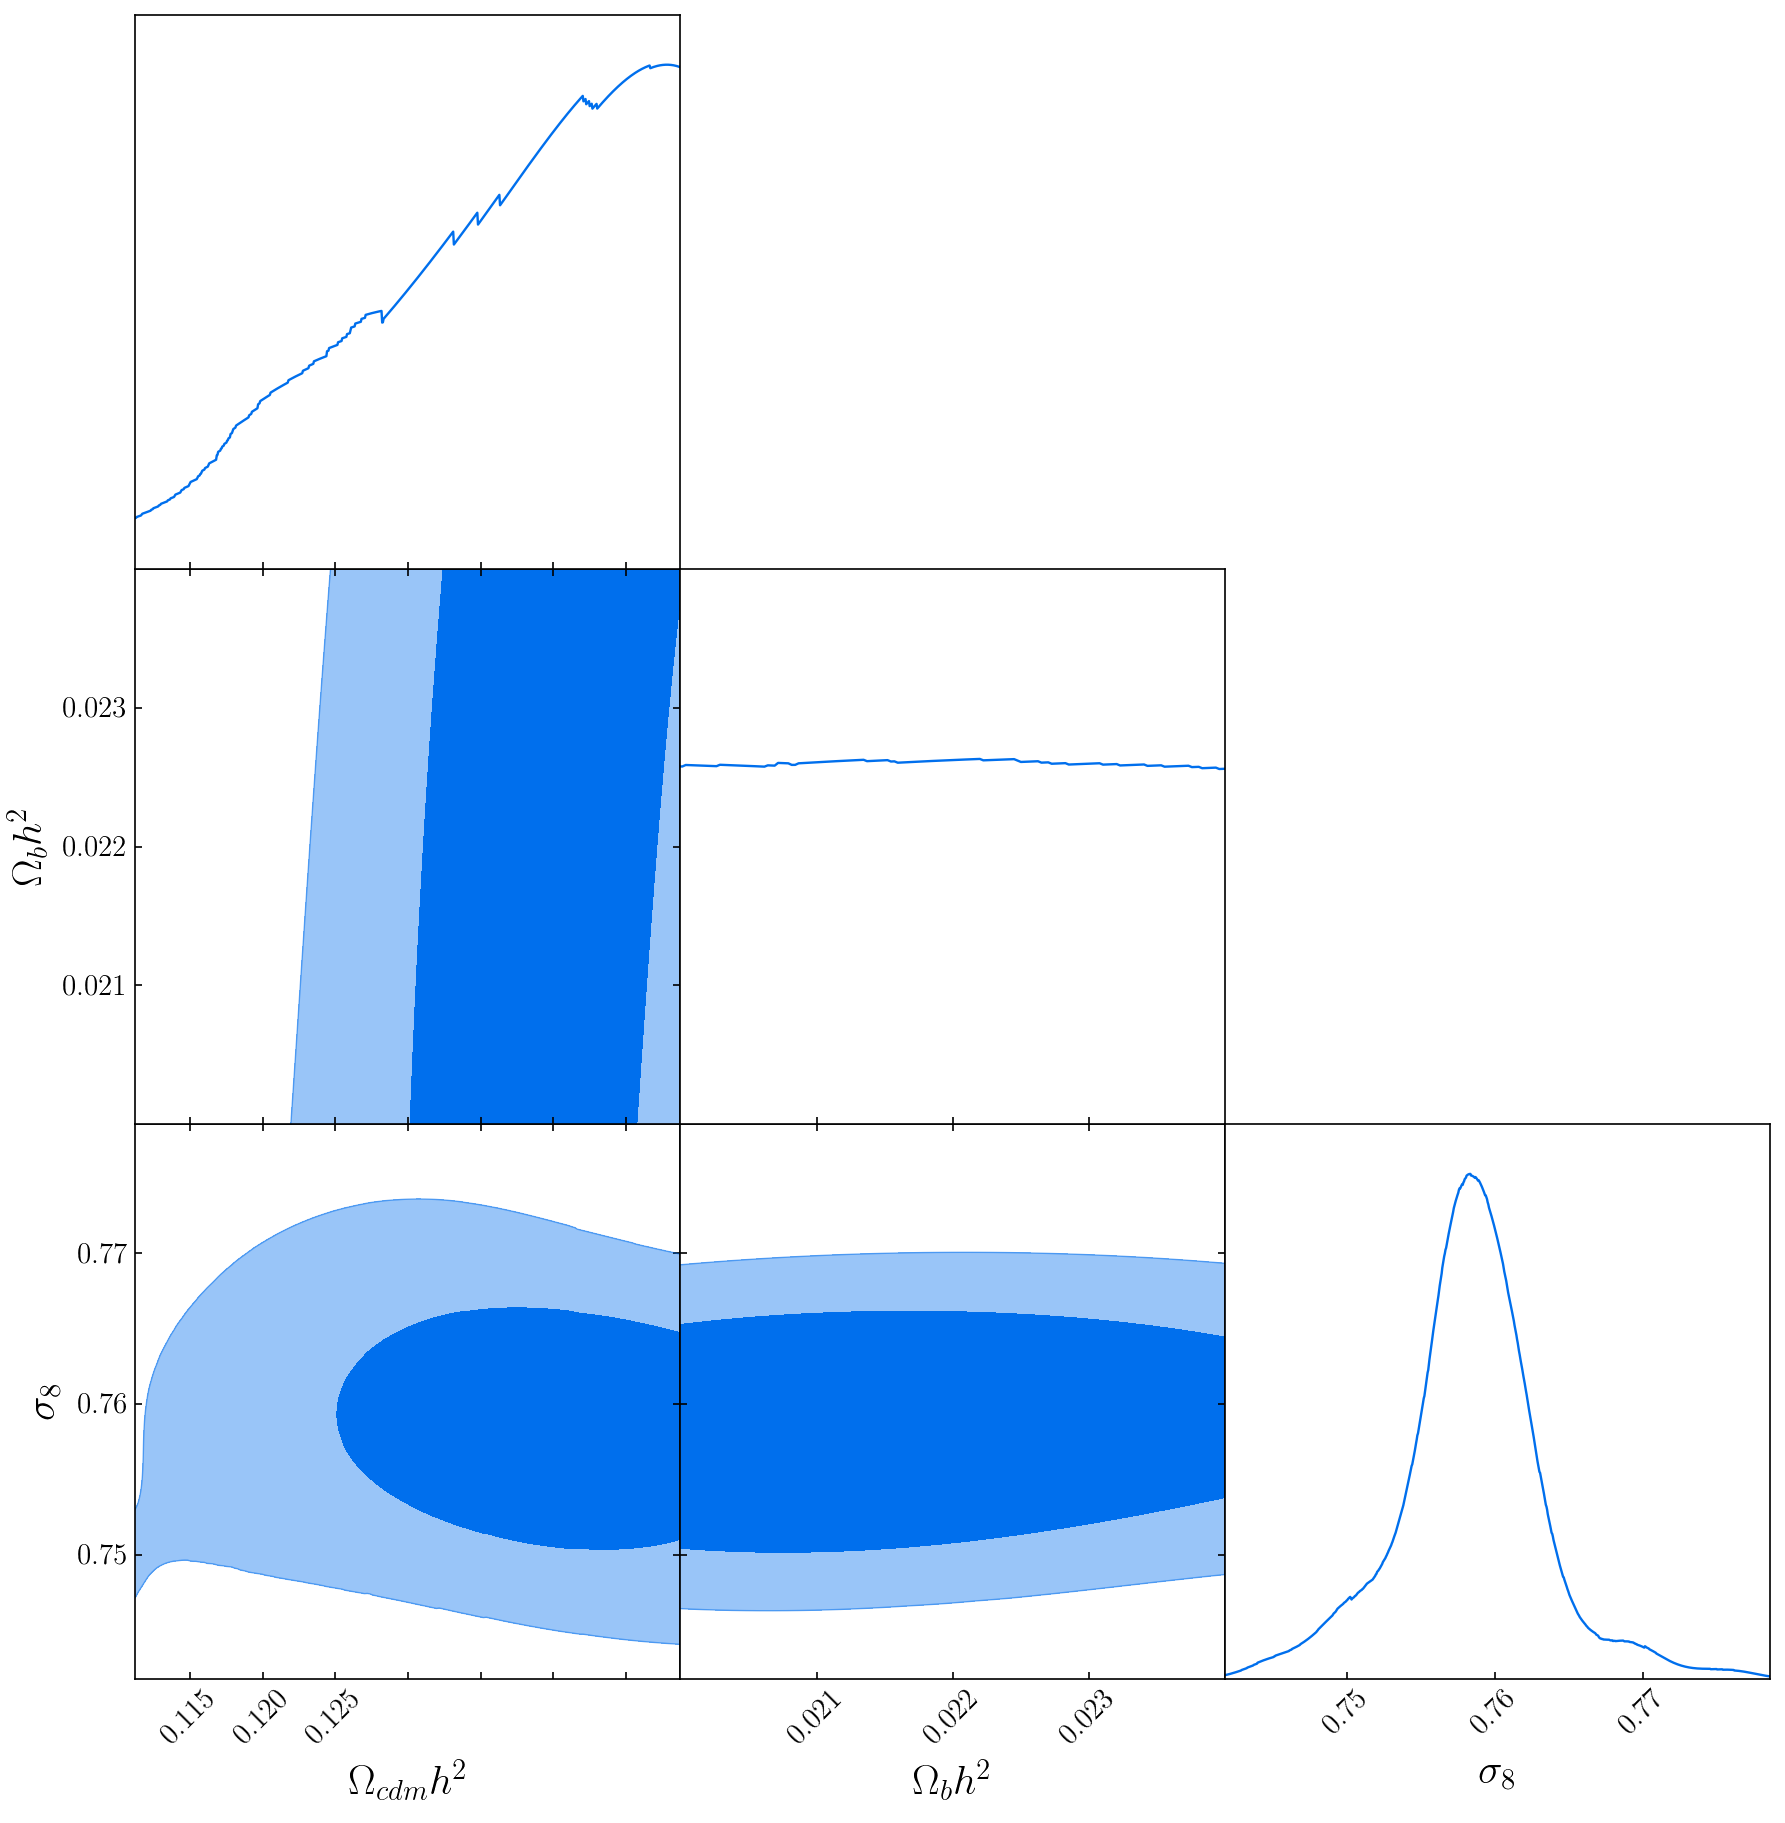

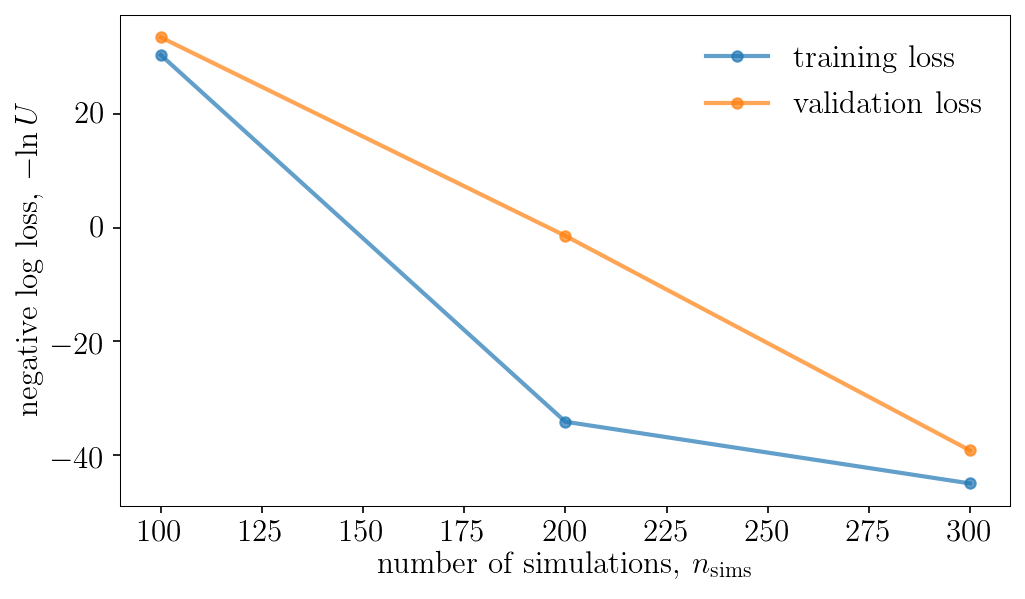

Population 6/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


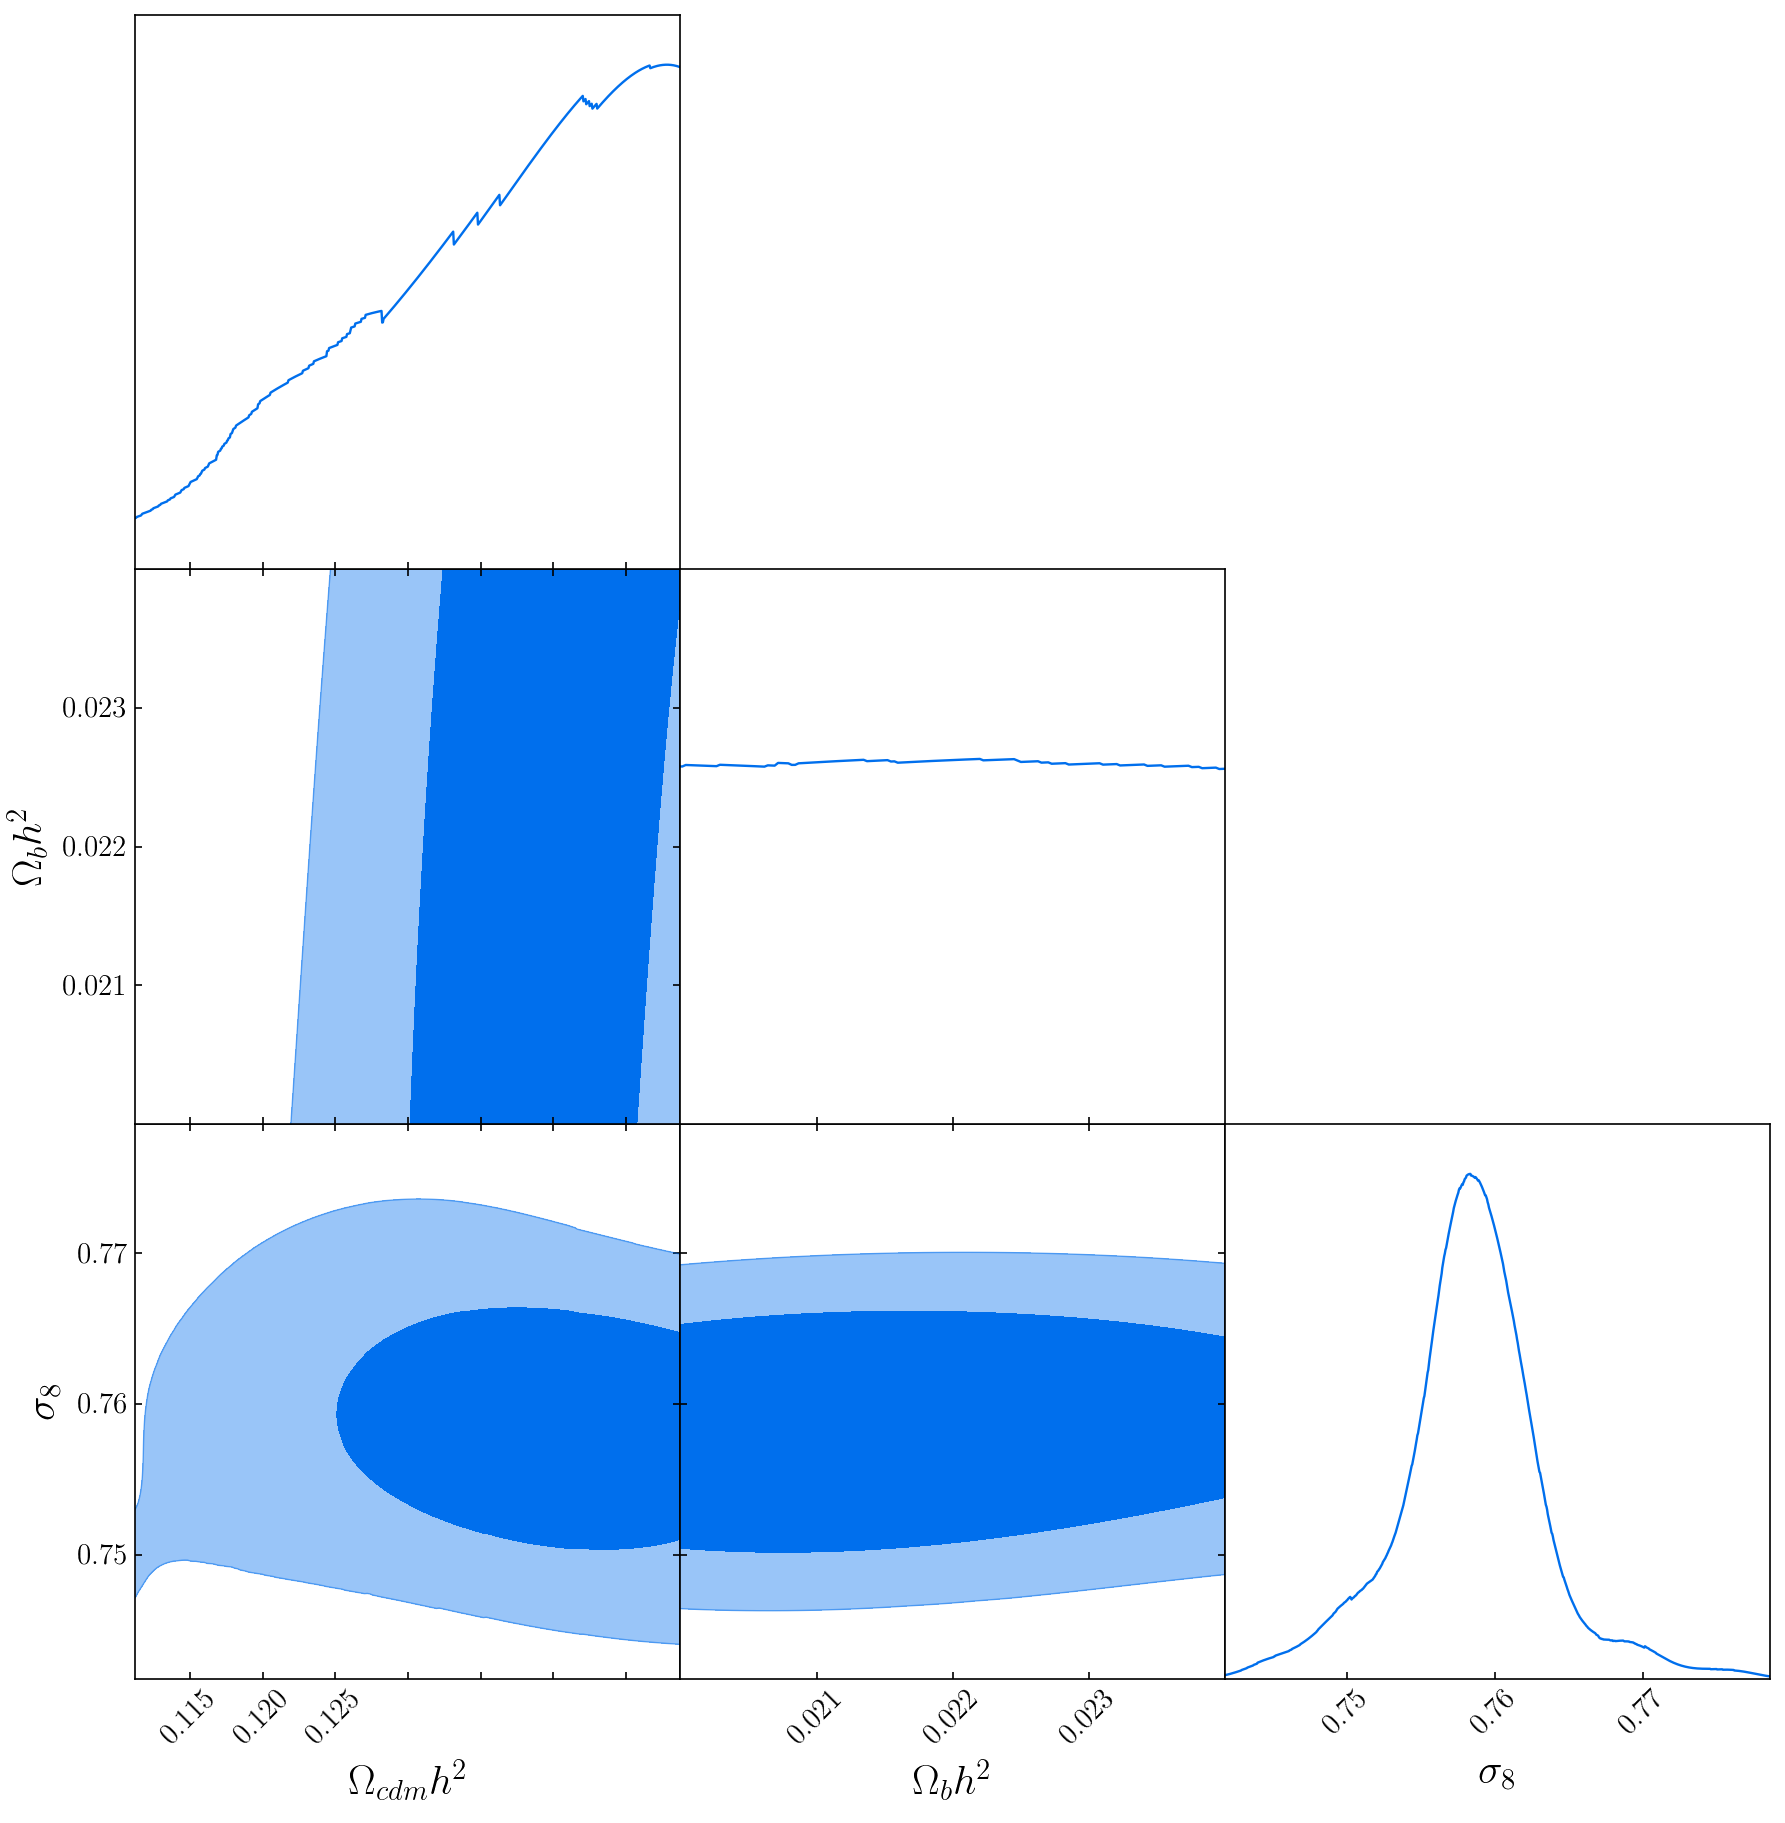

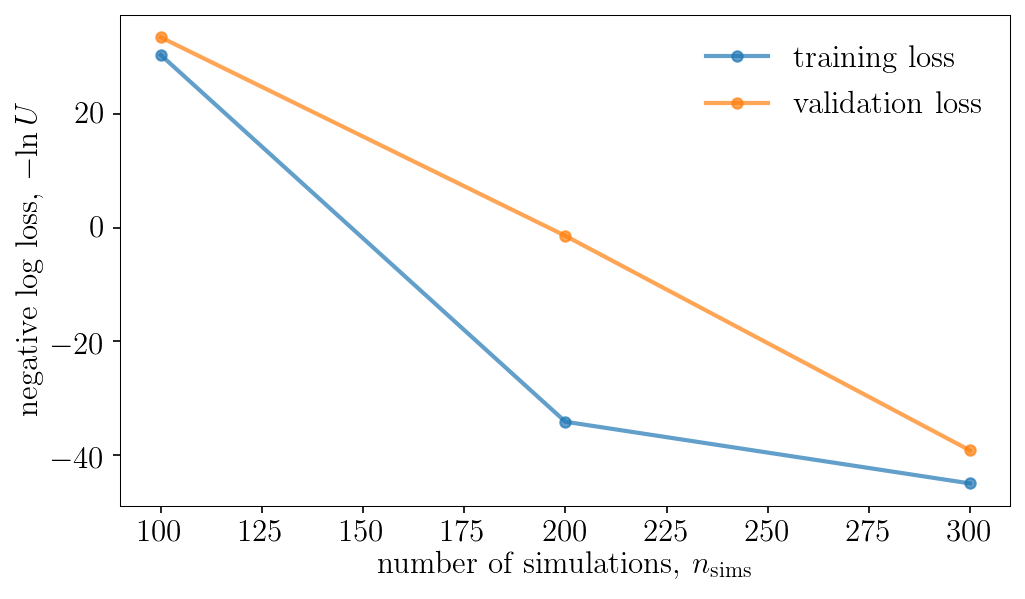

Population 7/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


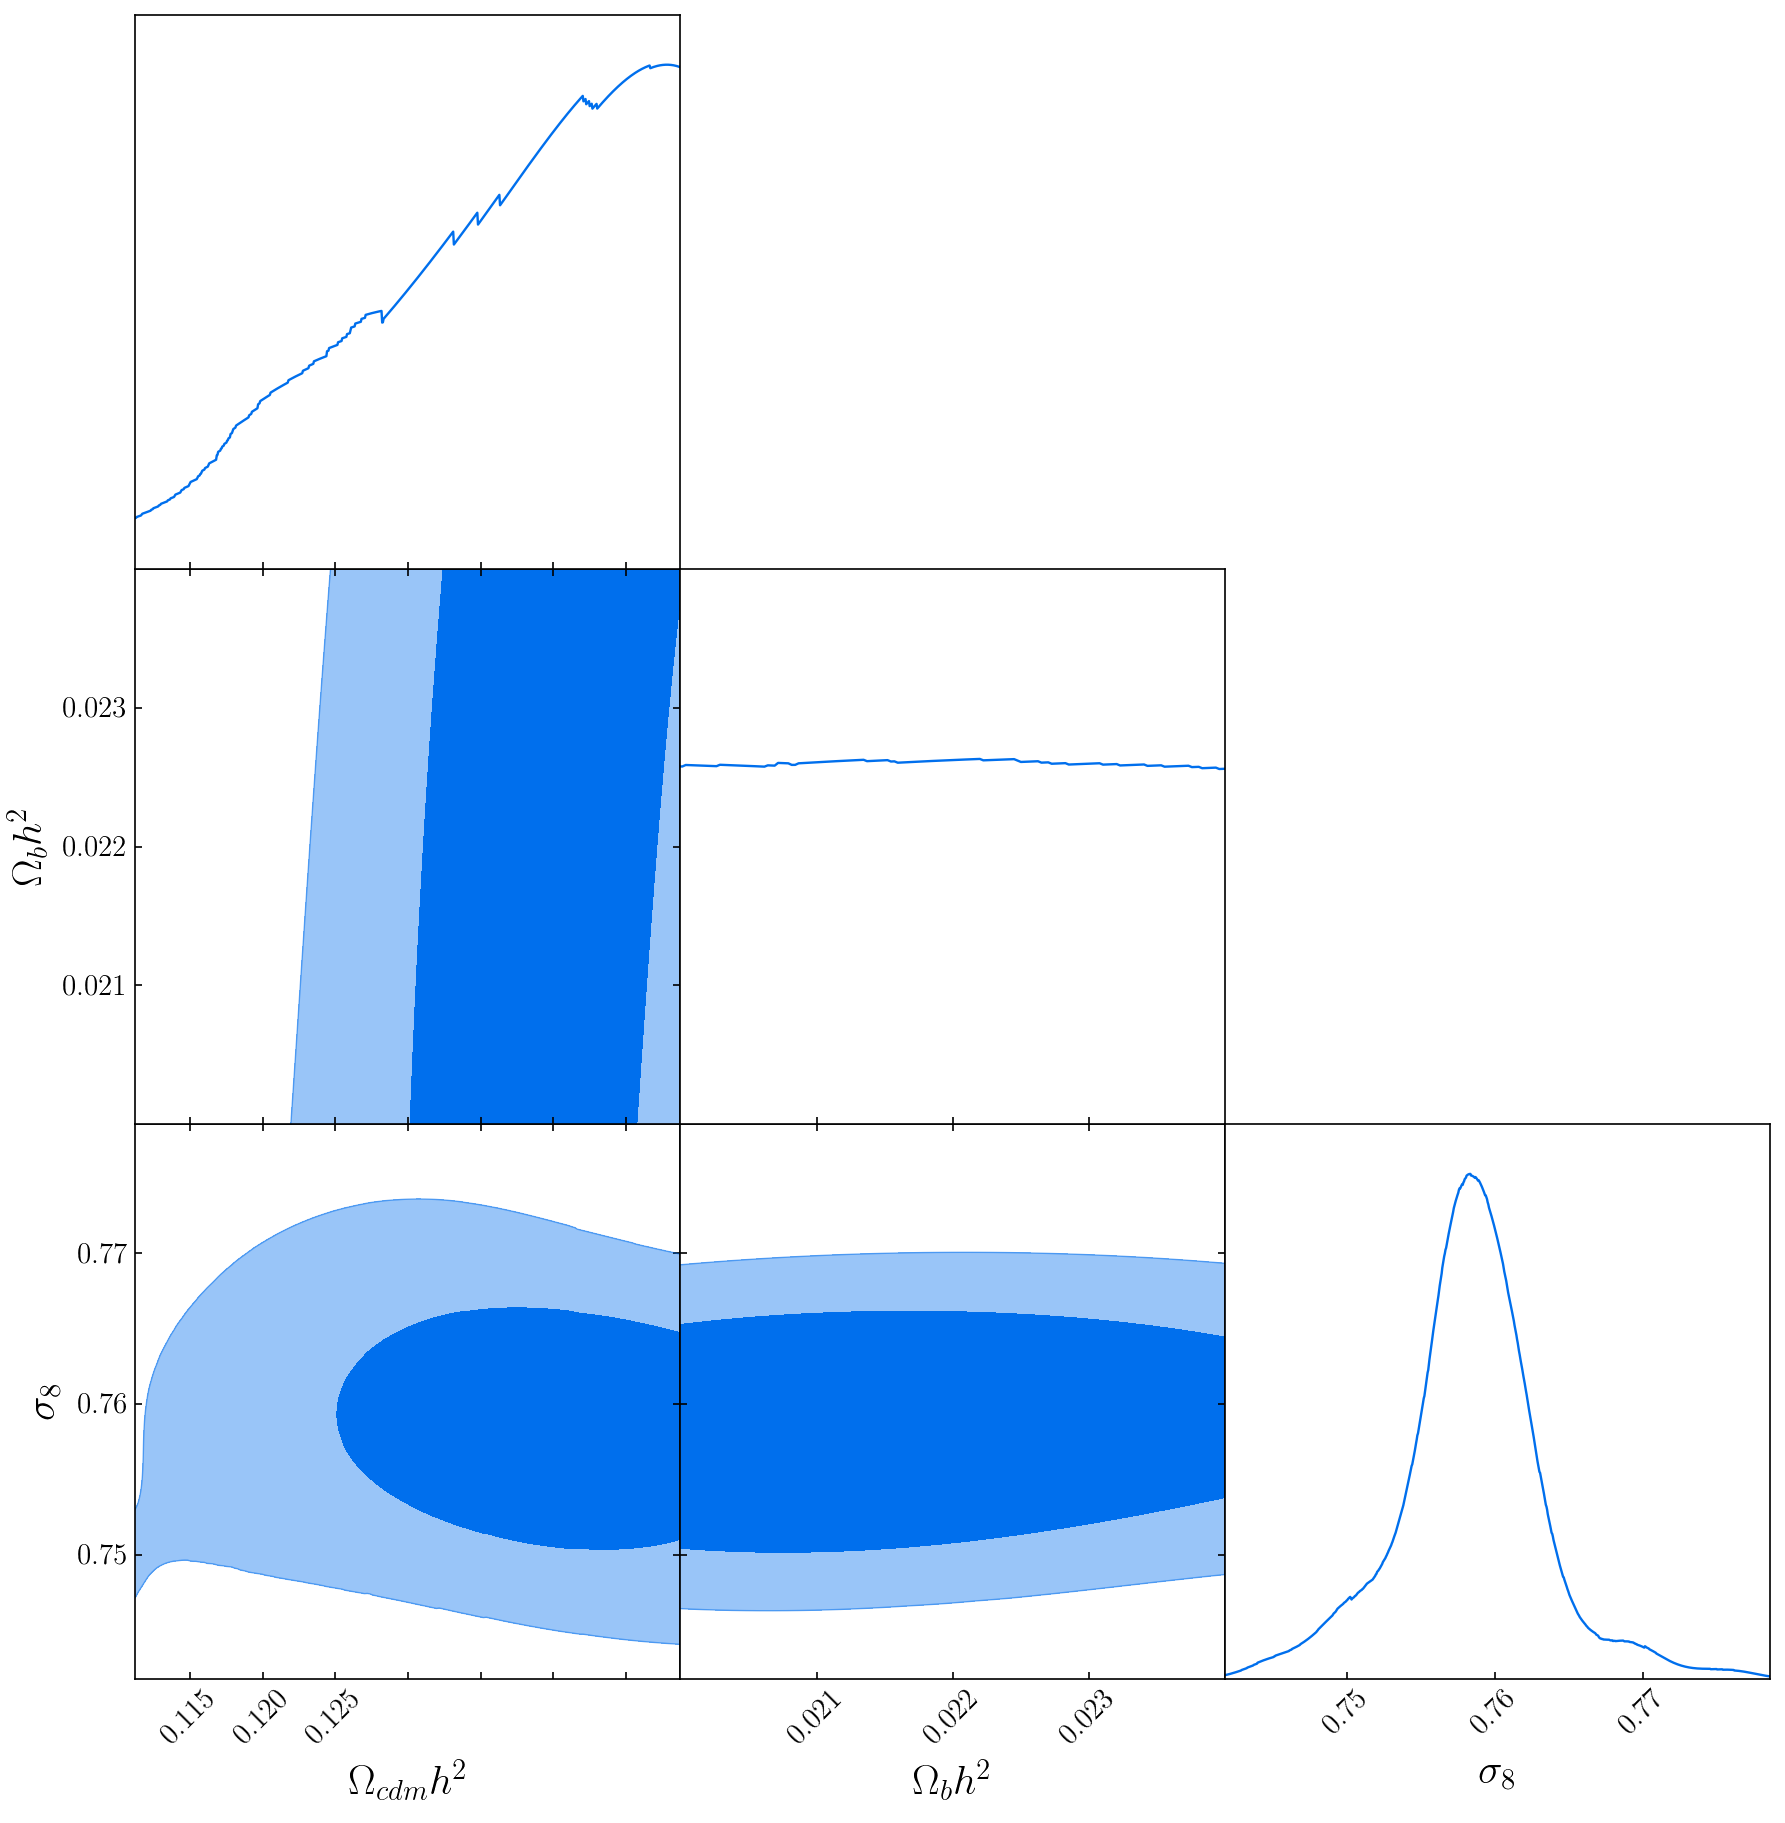

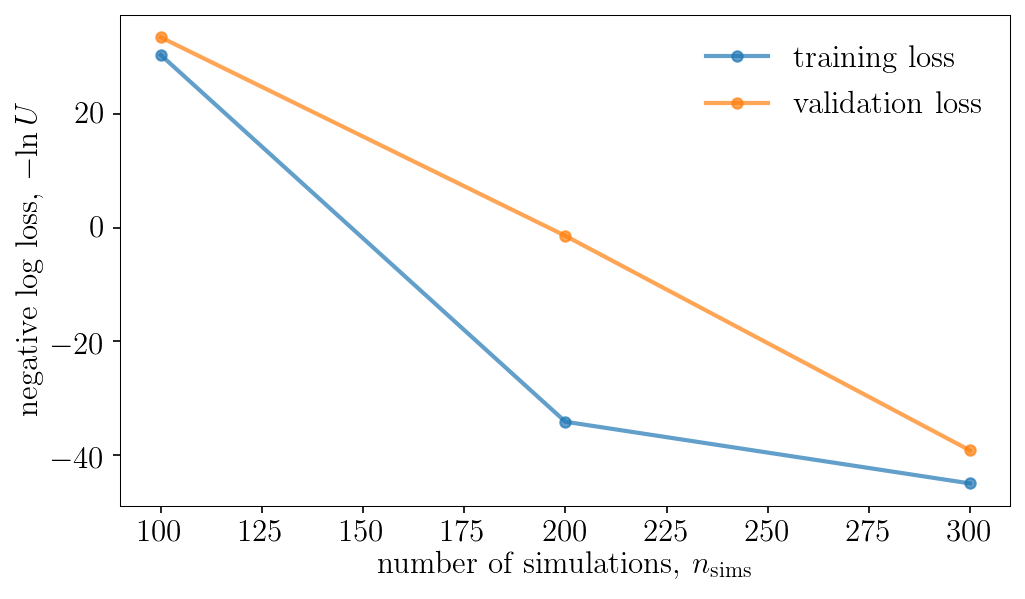

Population 8/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


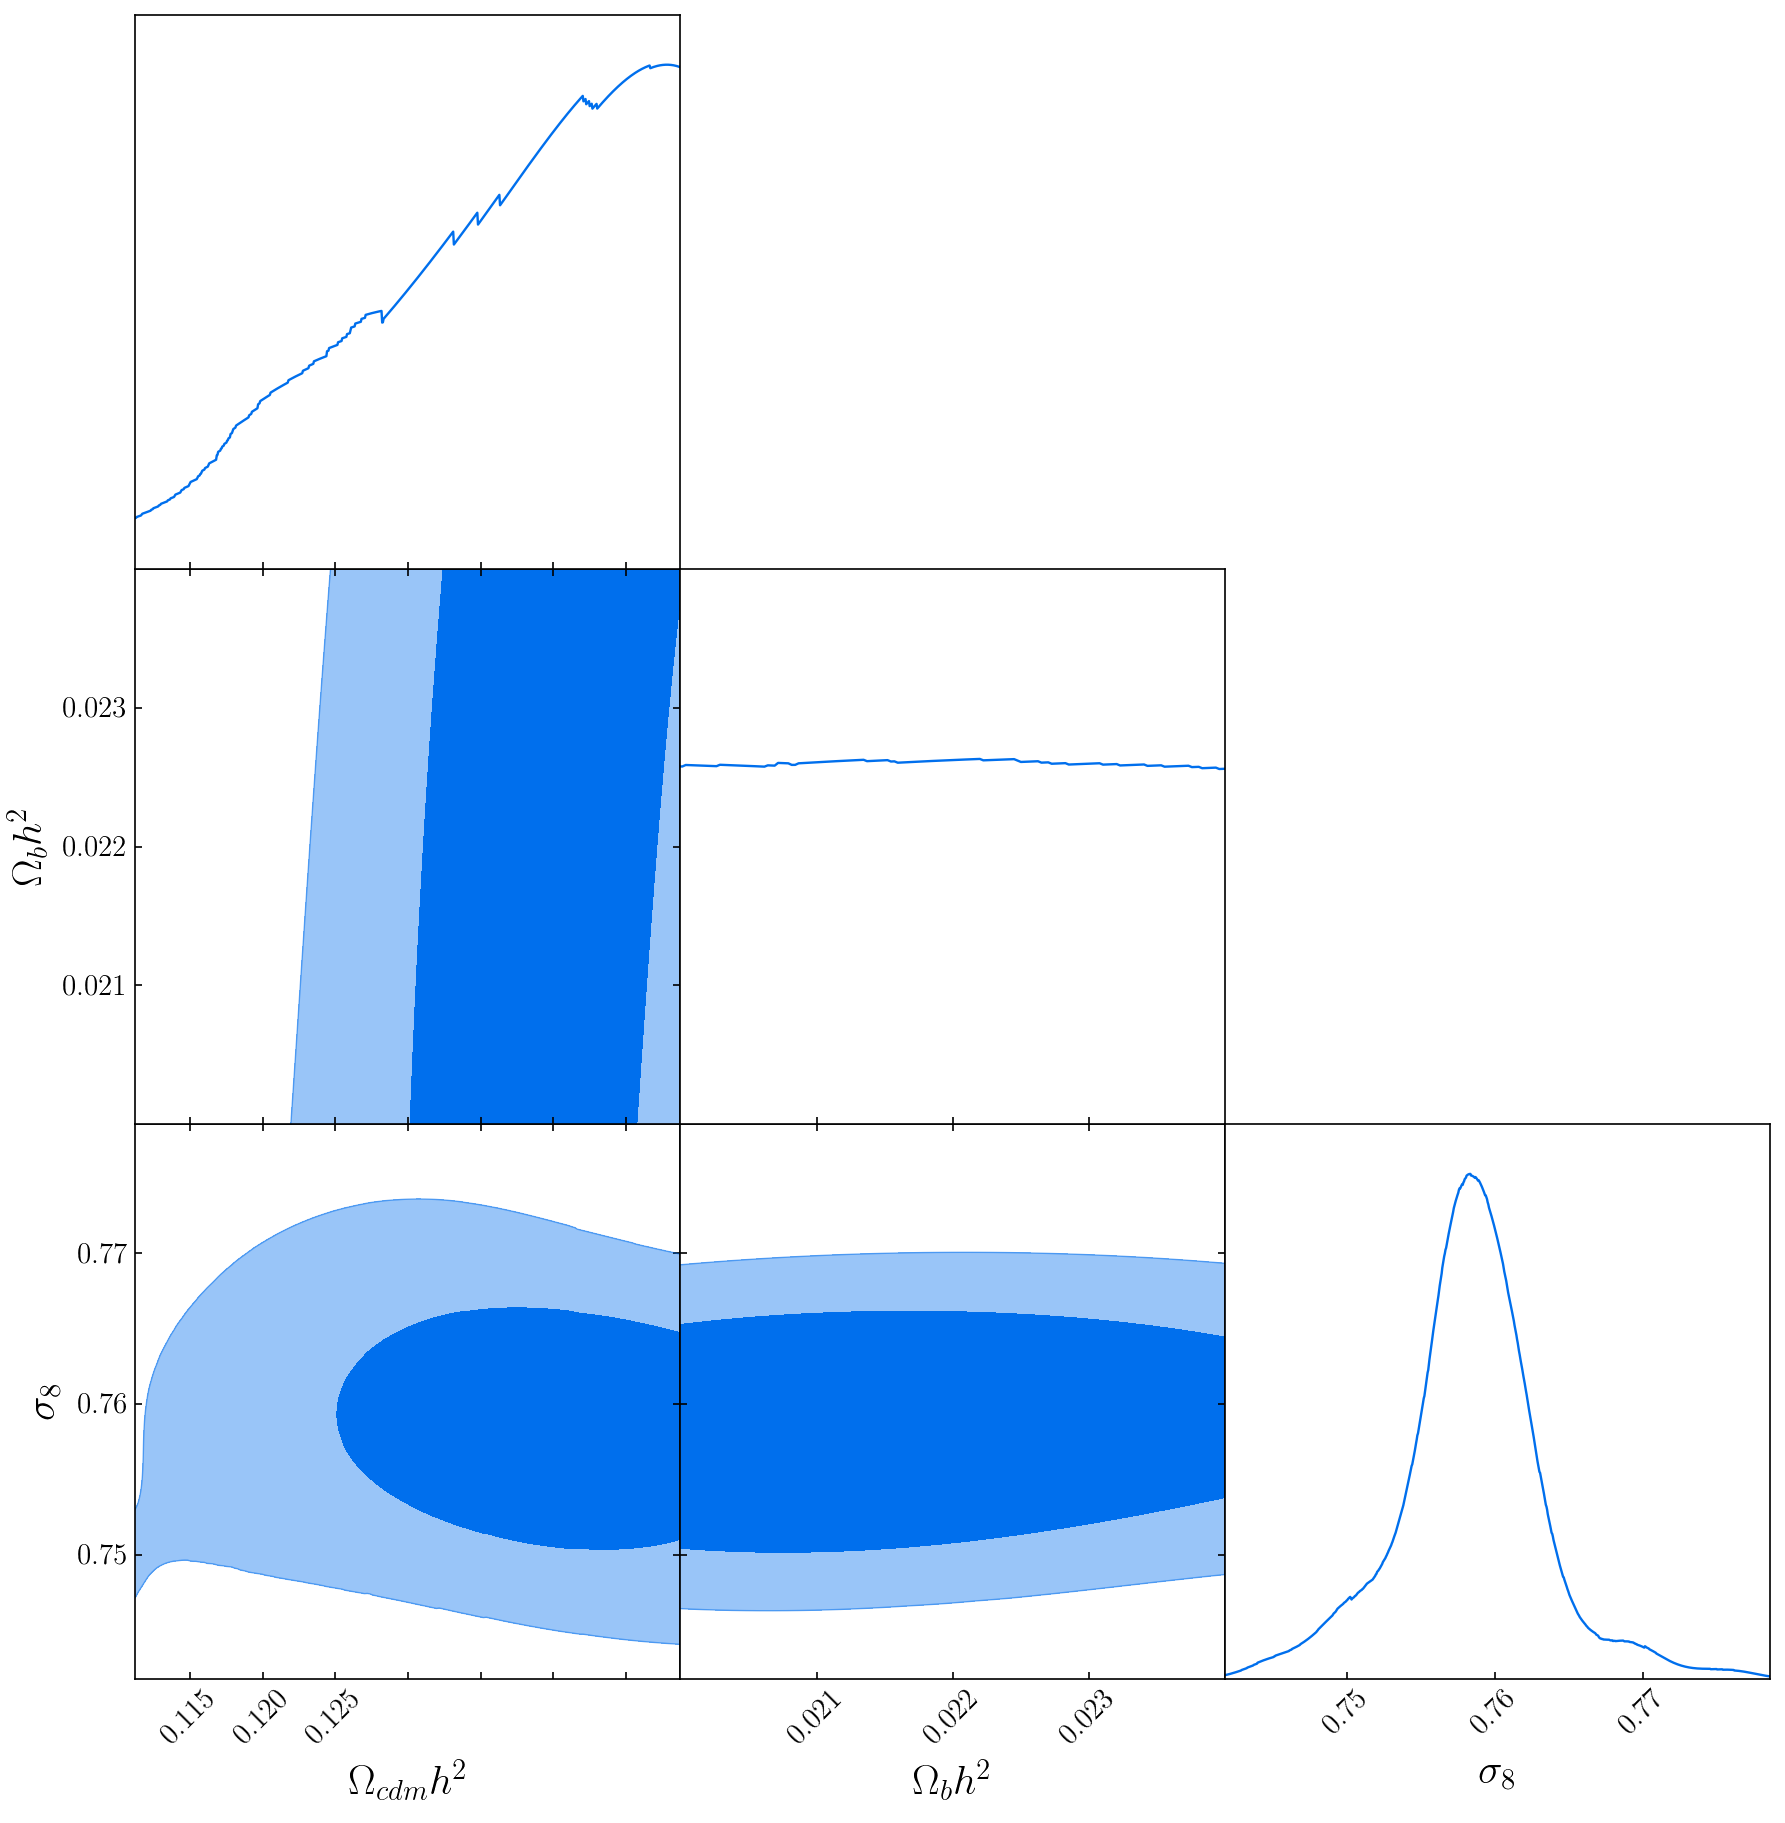

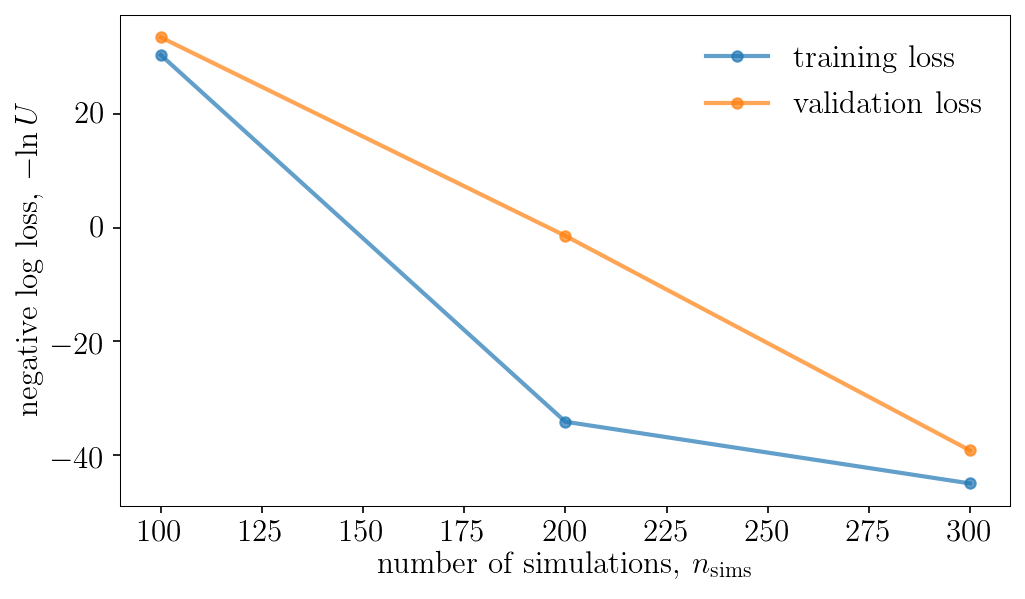

Population 9/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


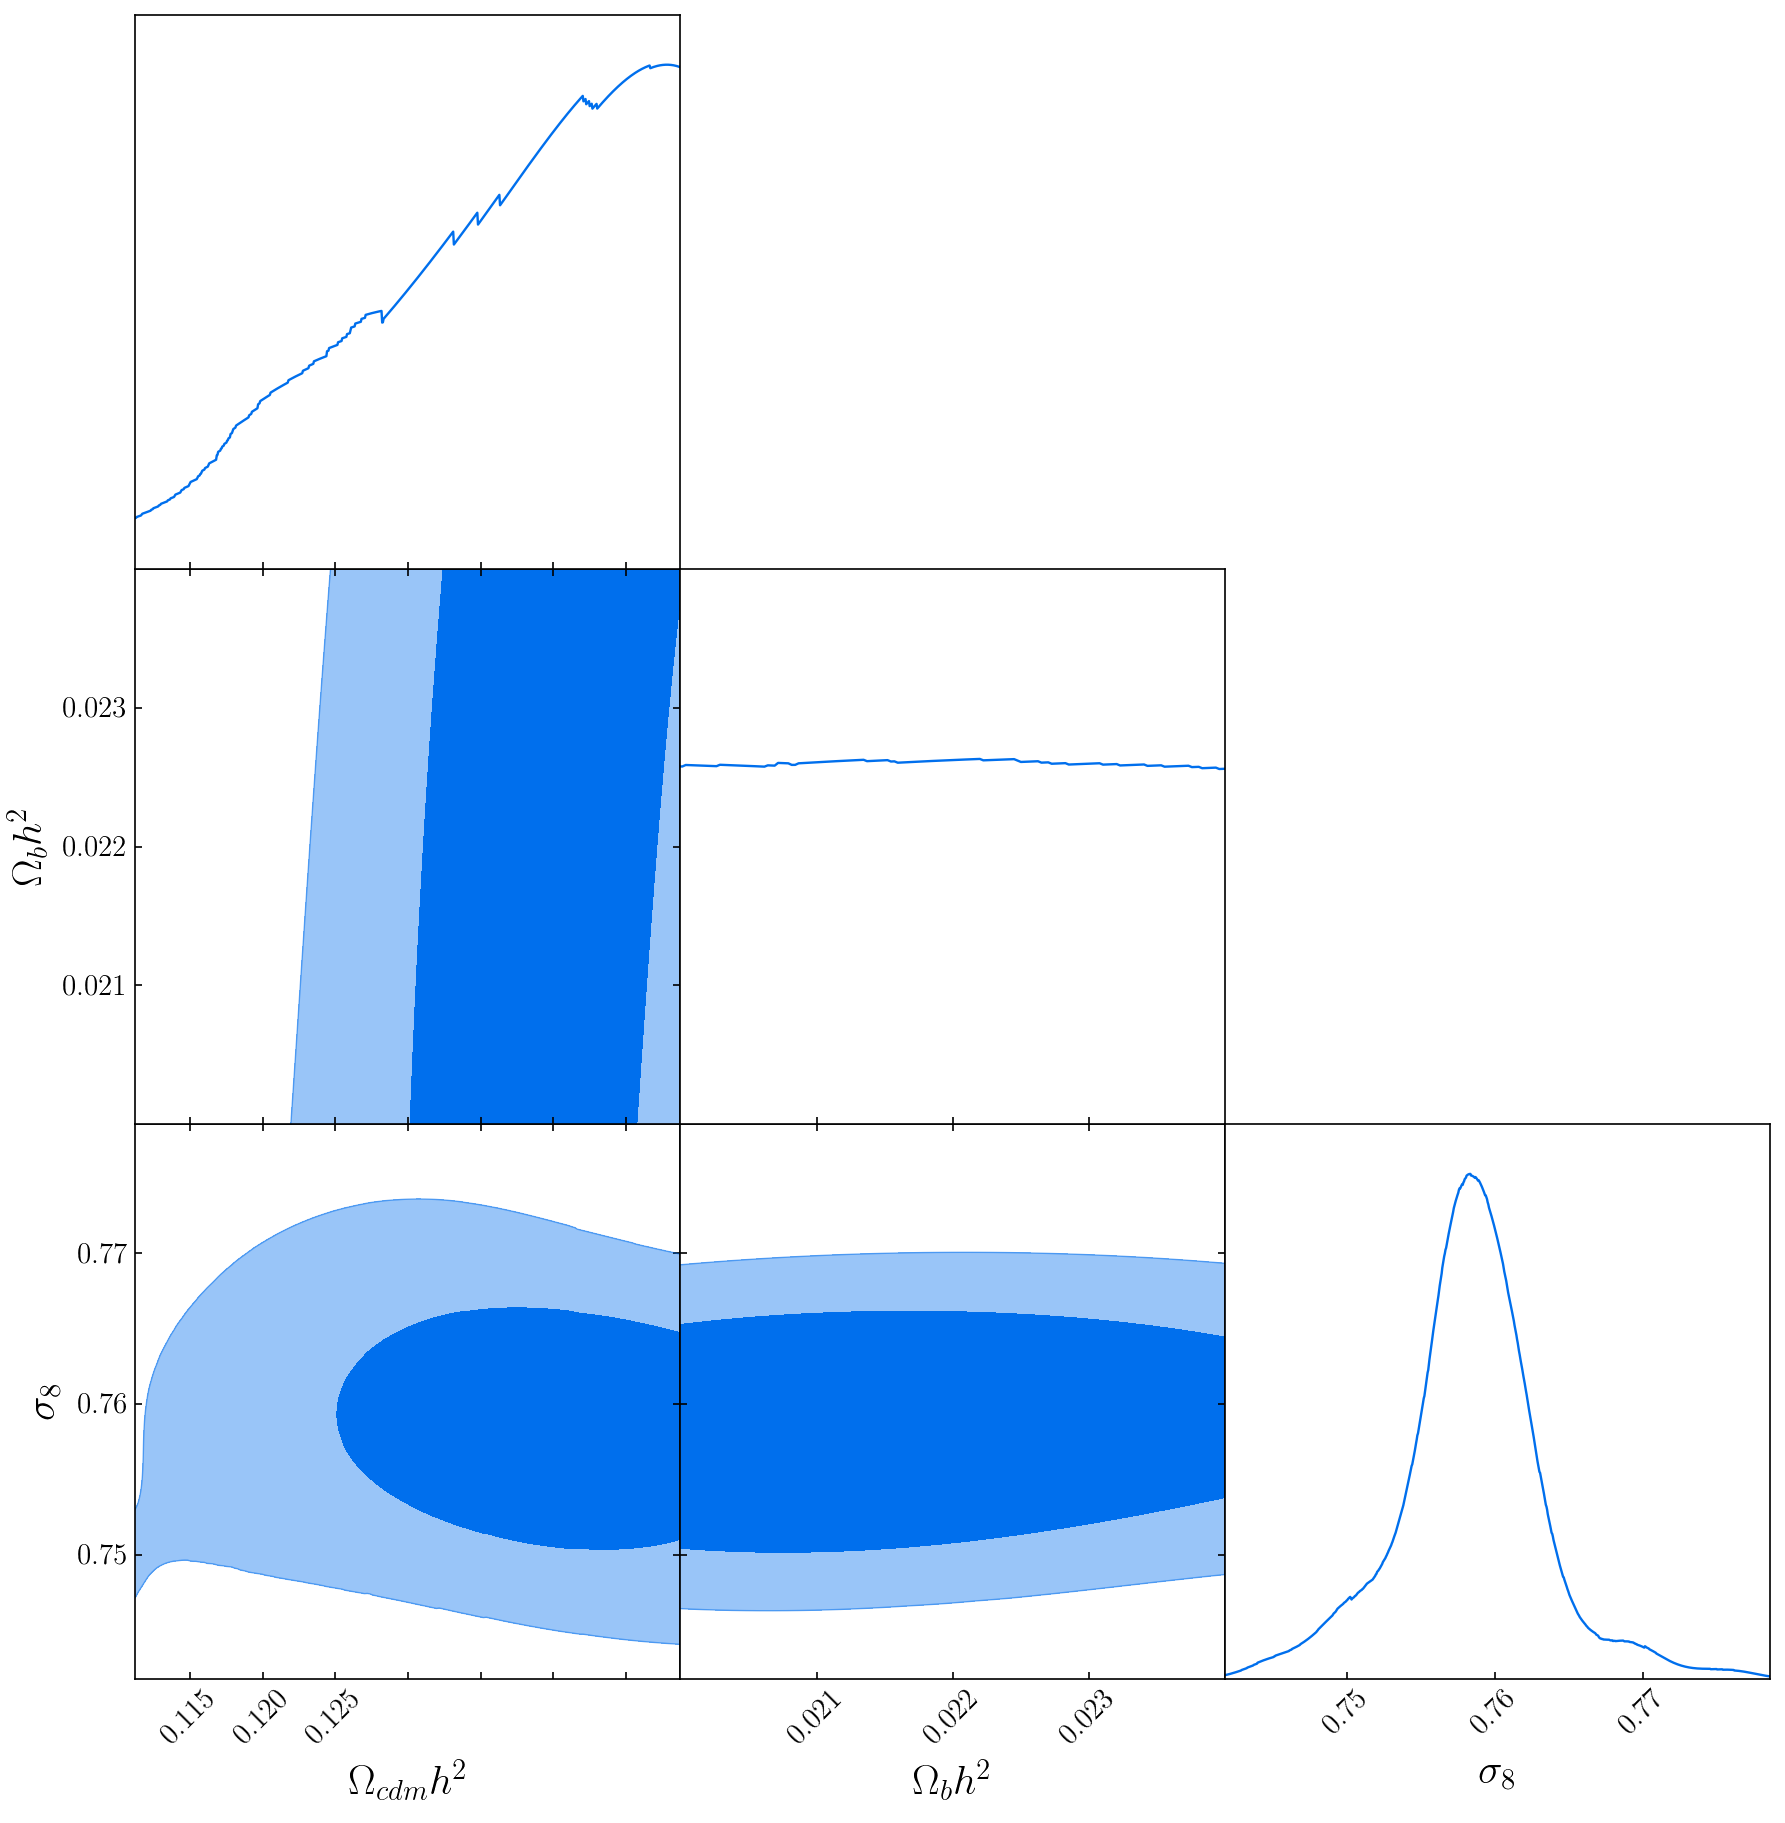

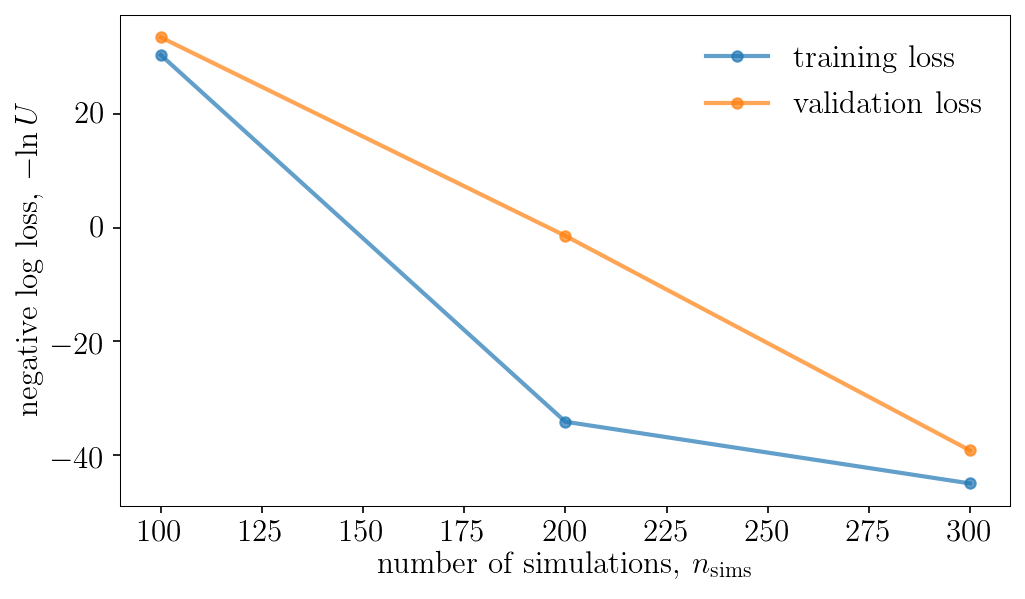

Population 10/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


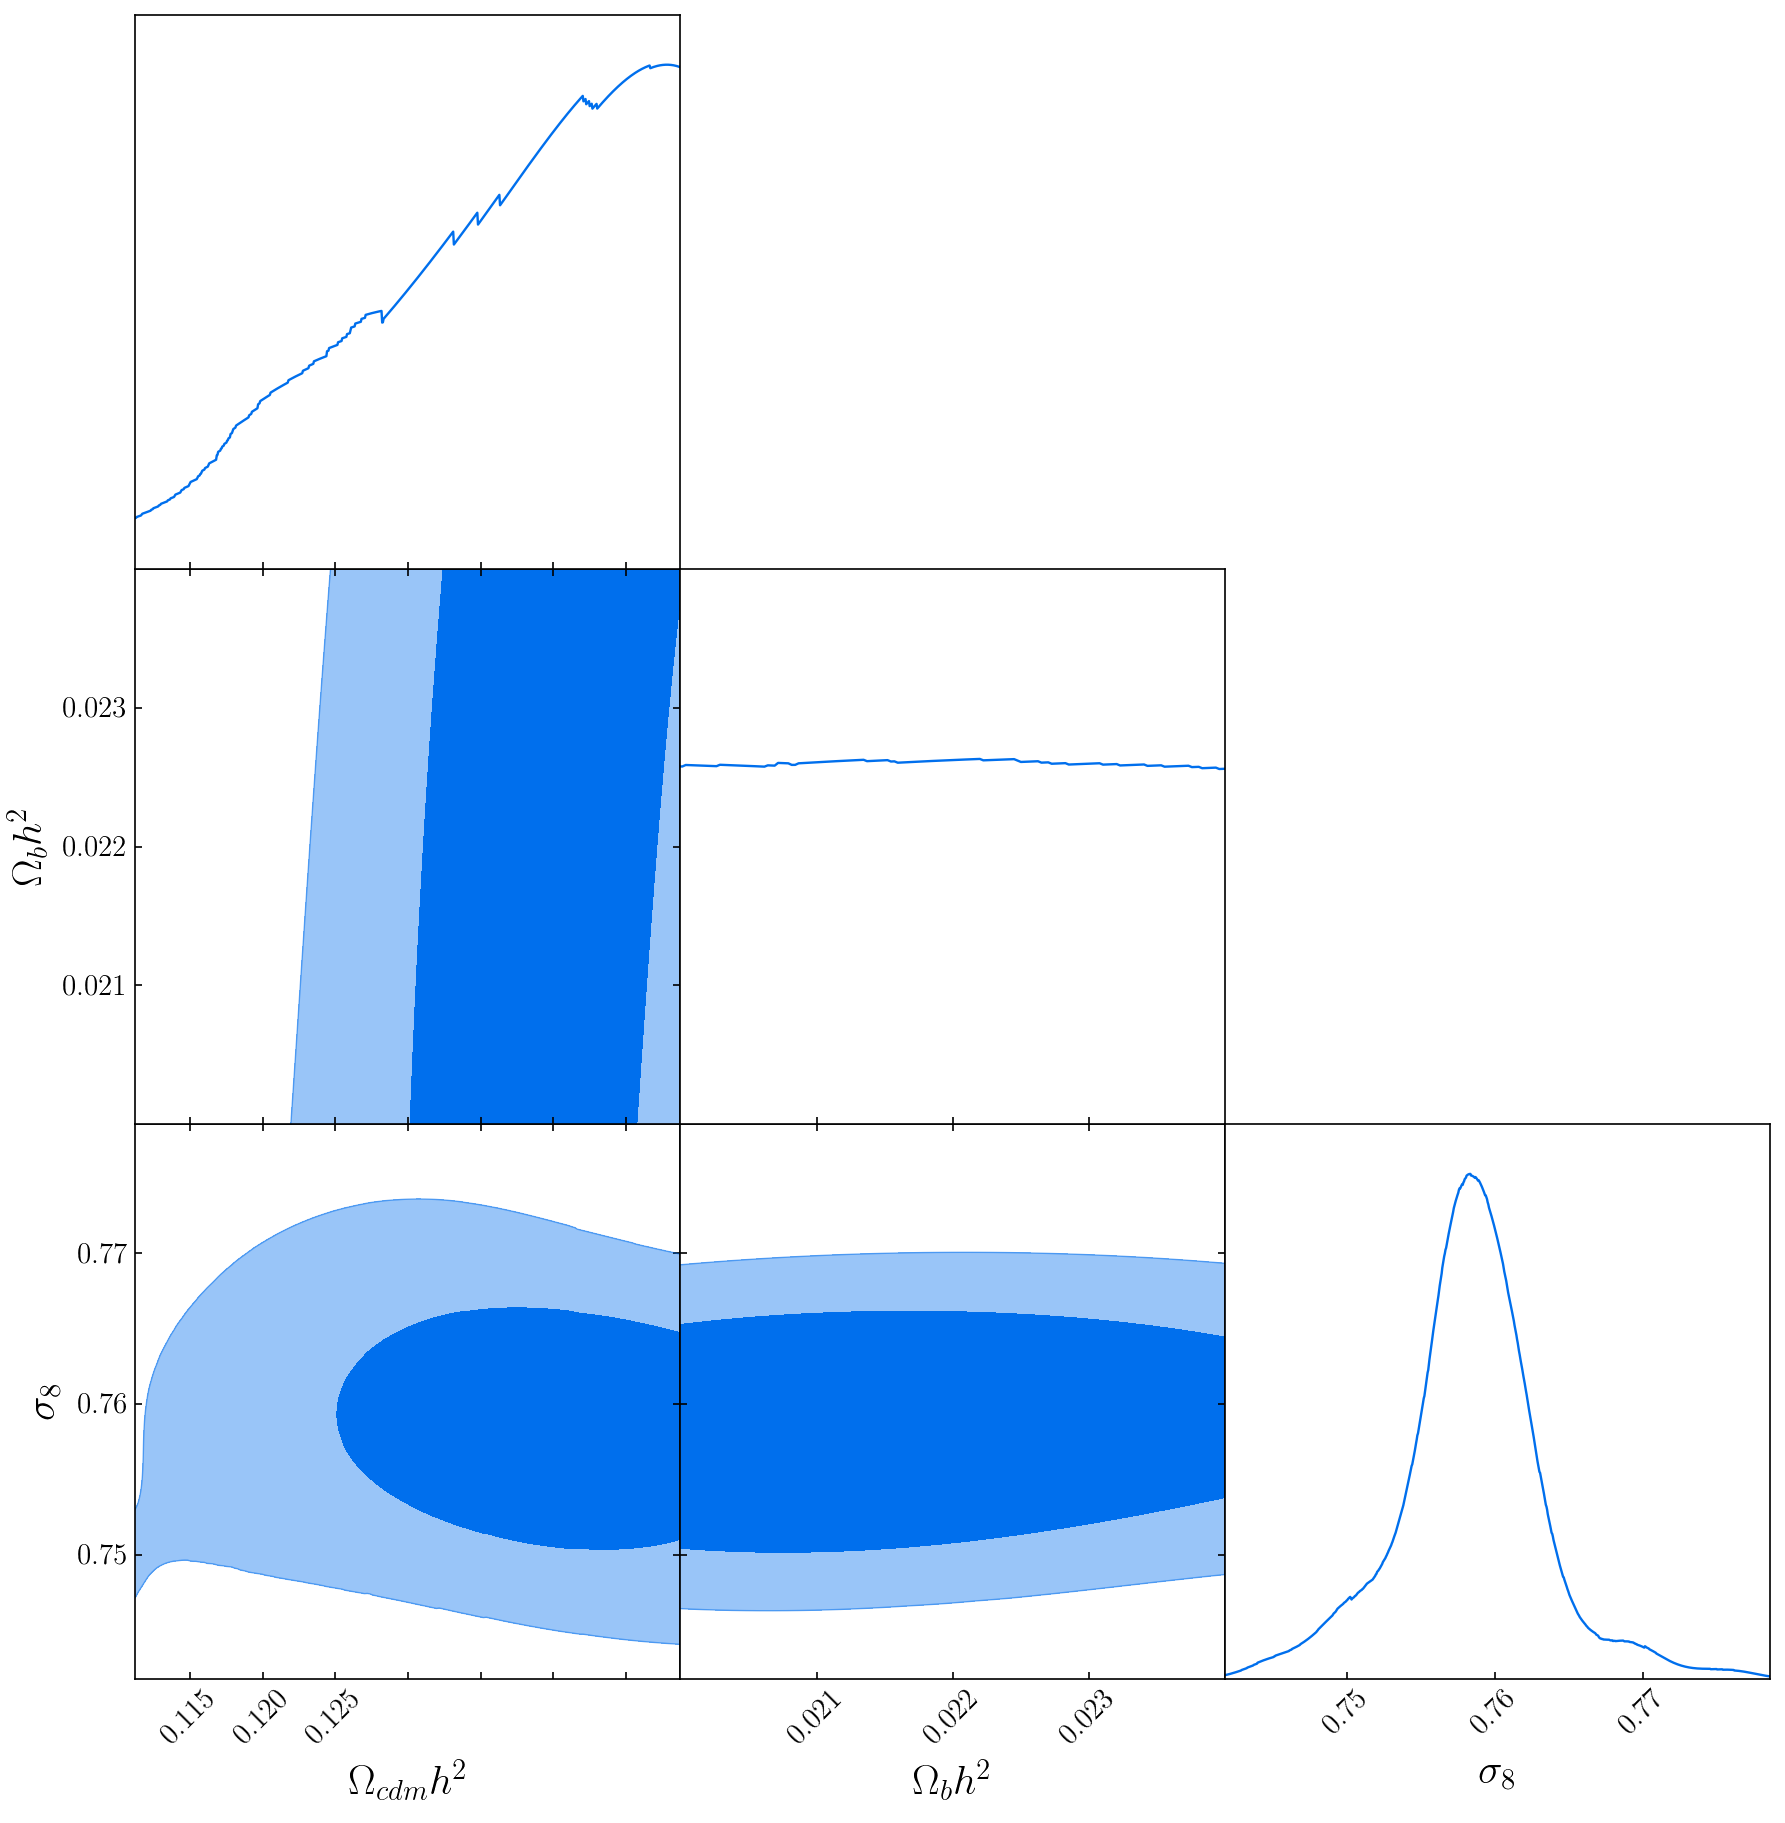

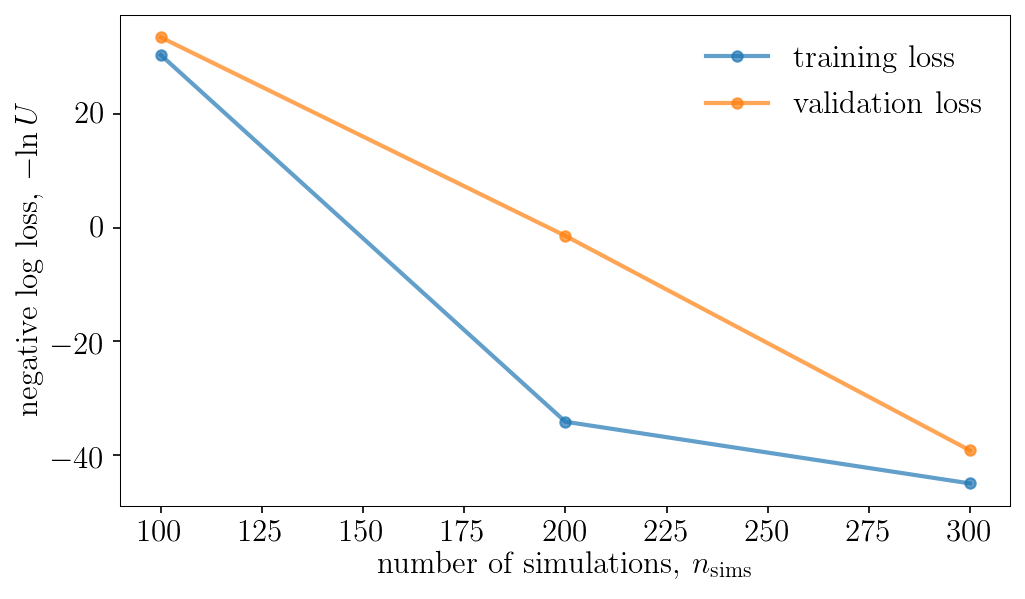

Population 11/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


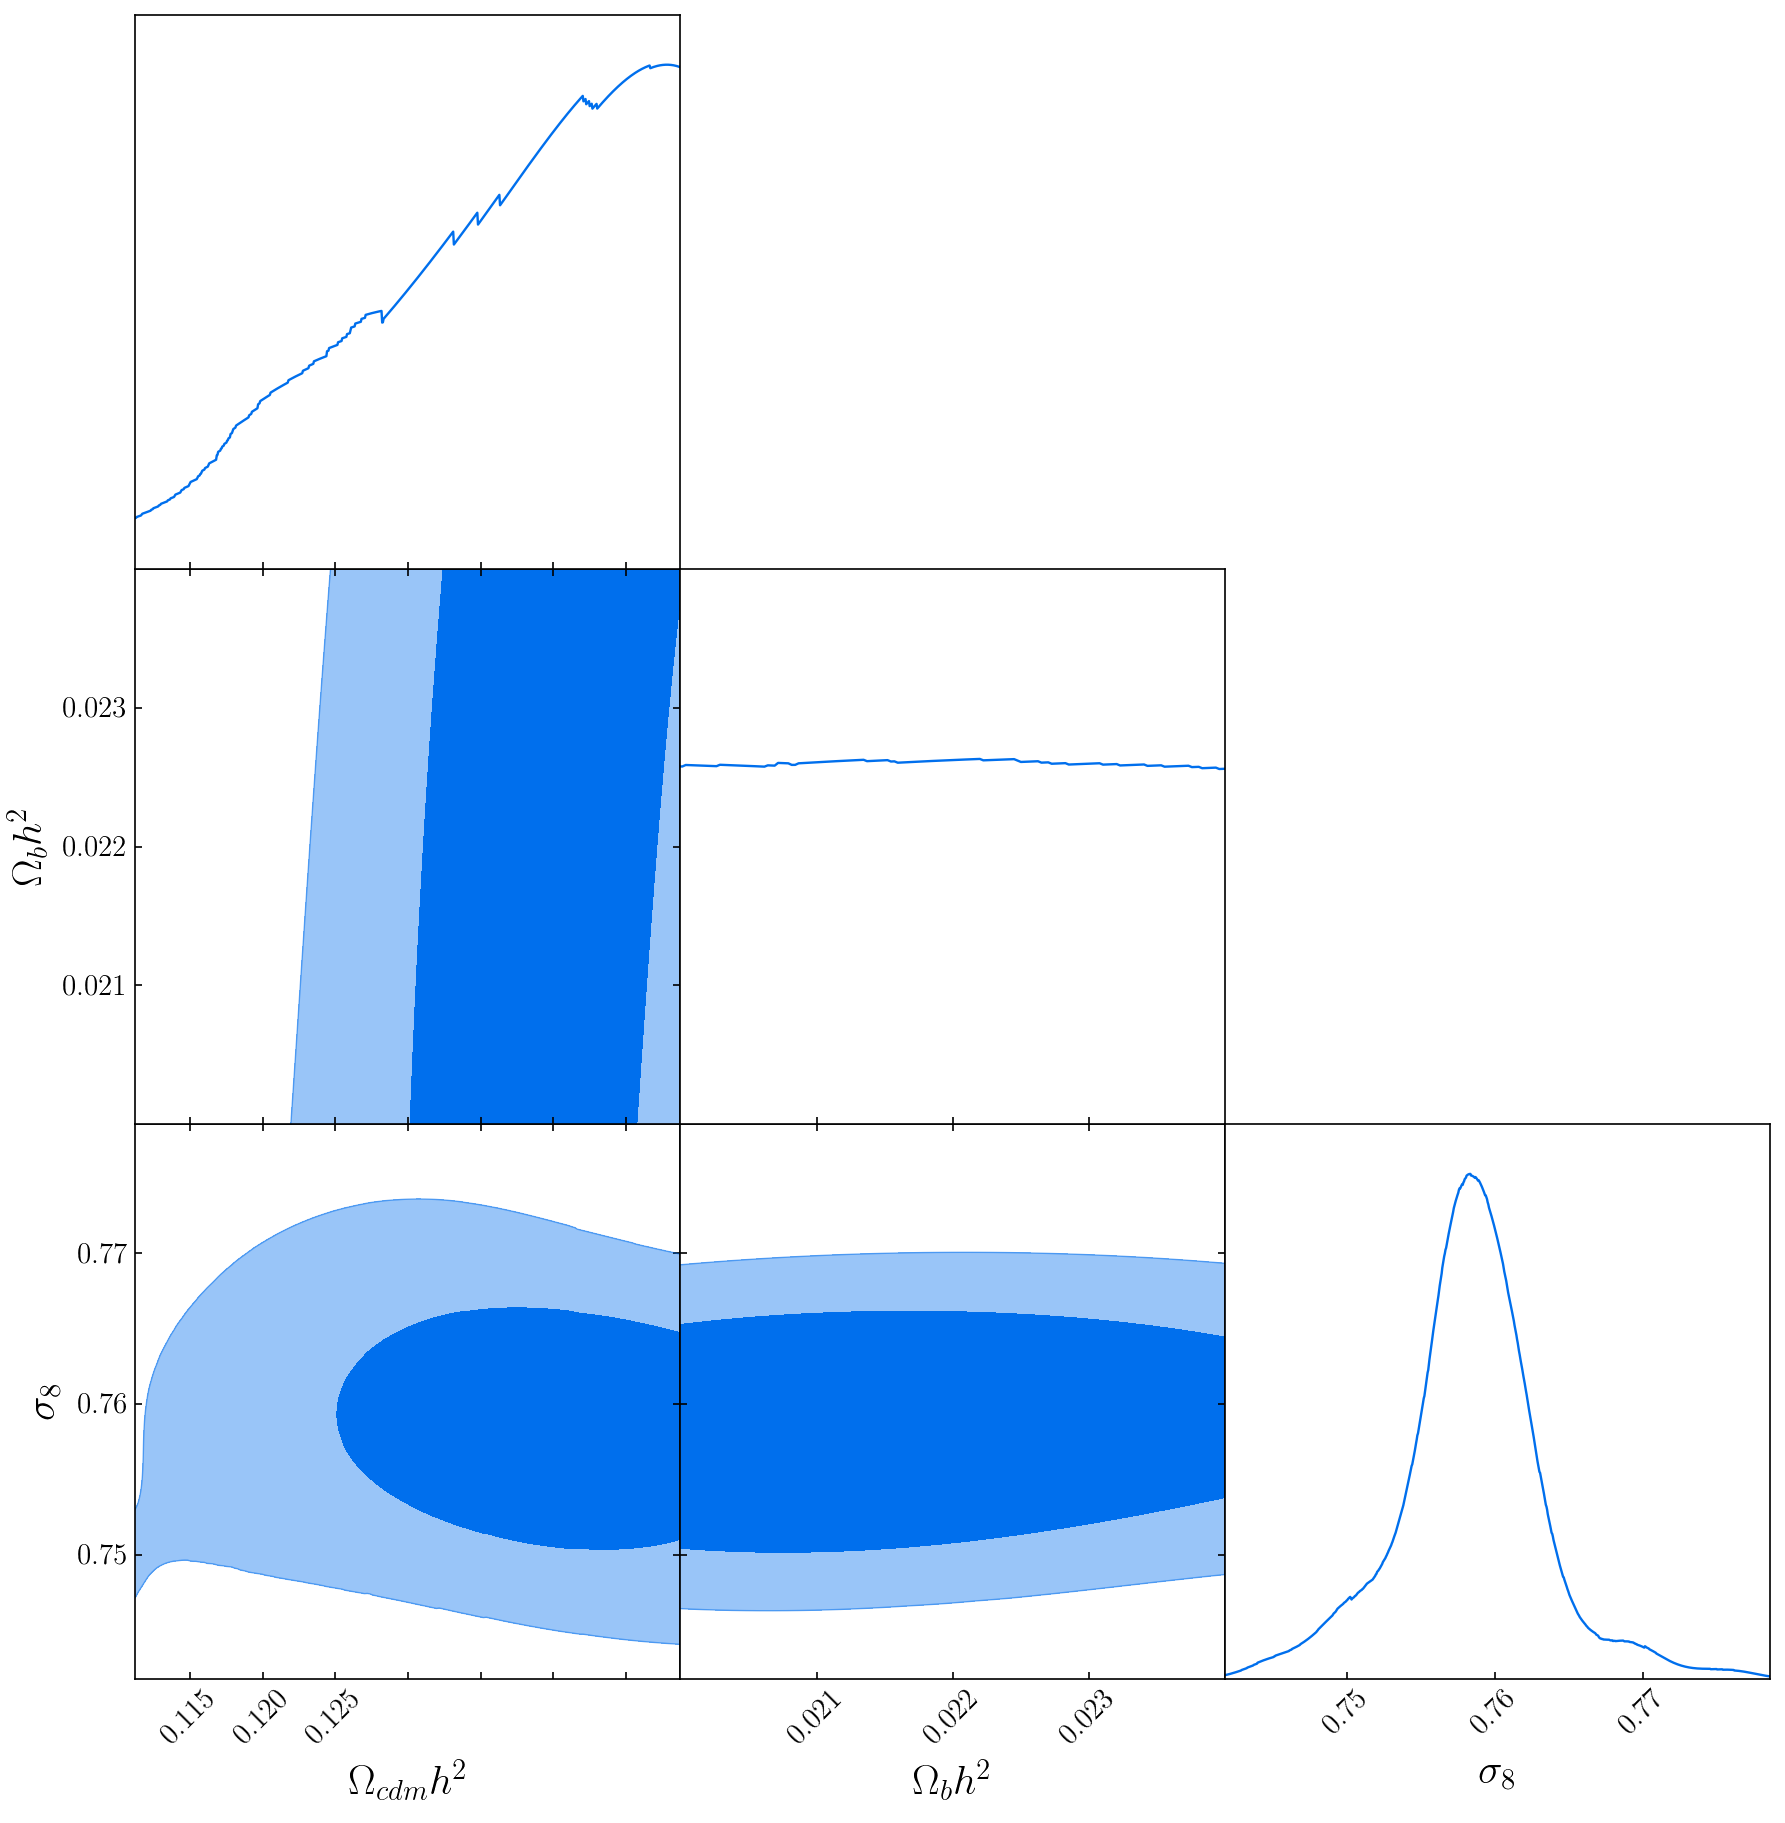

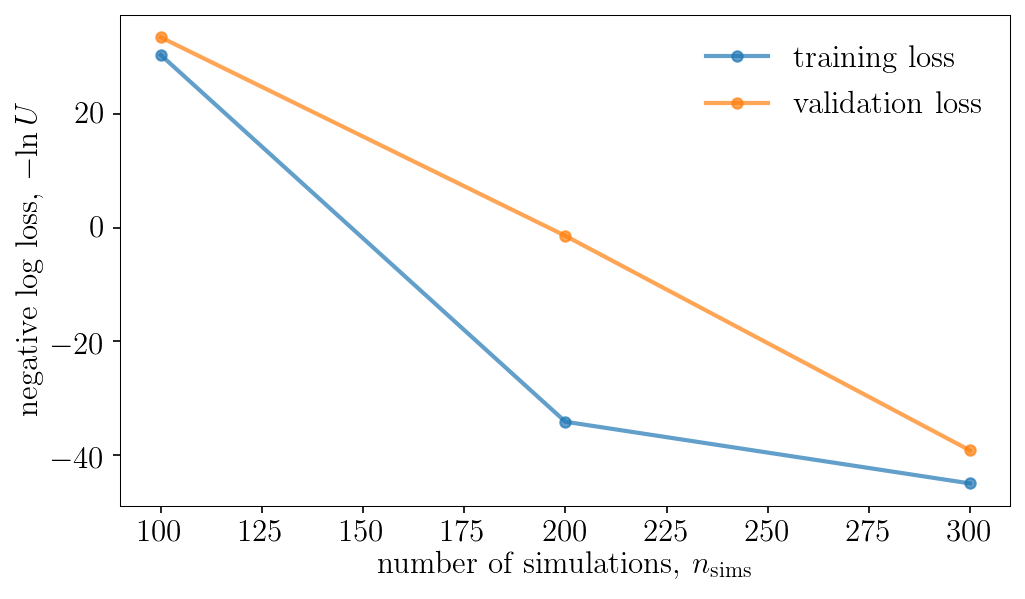

Population 12/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


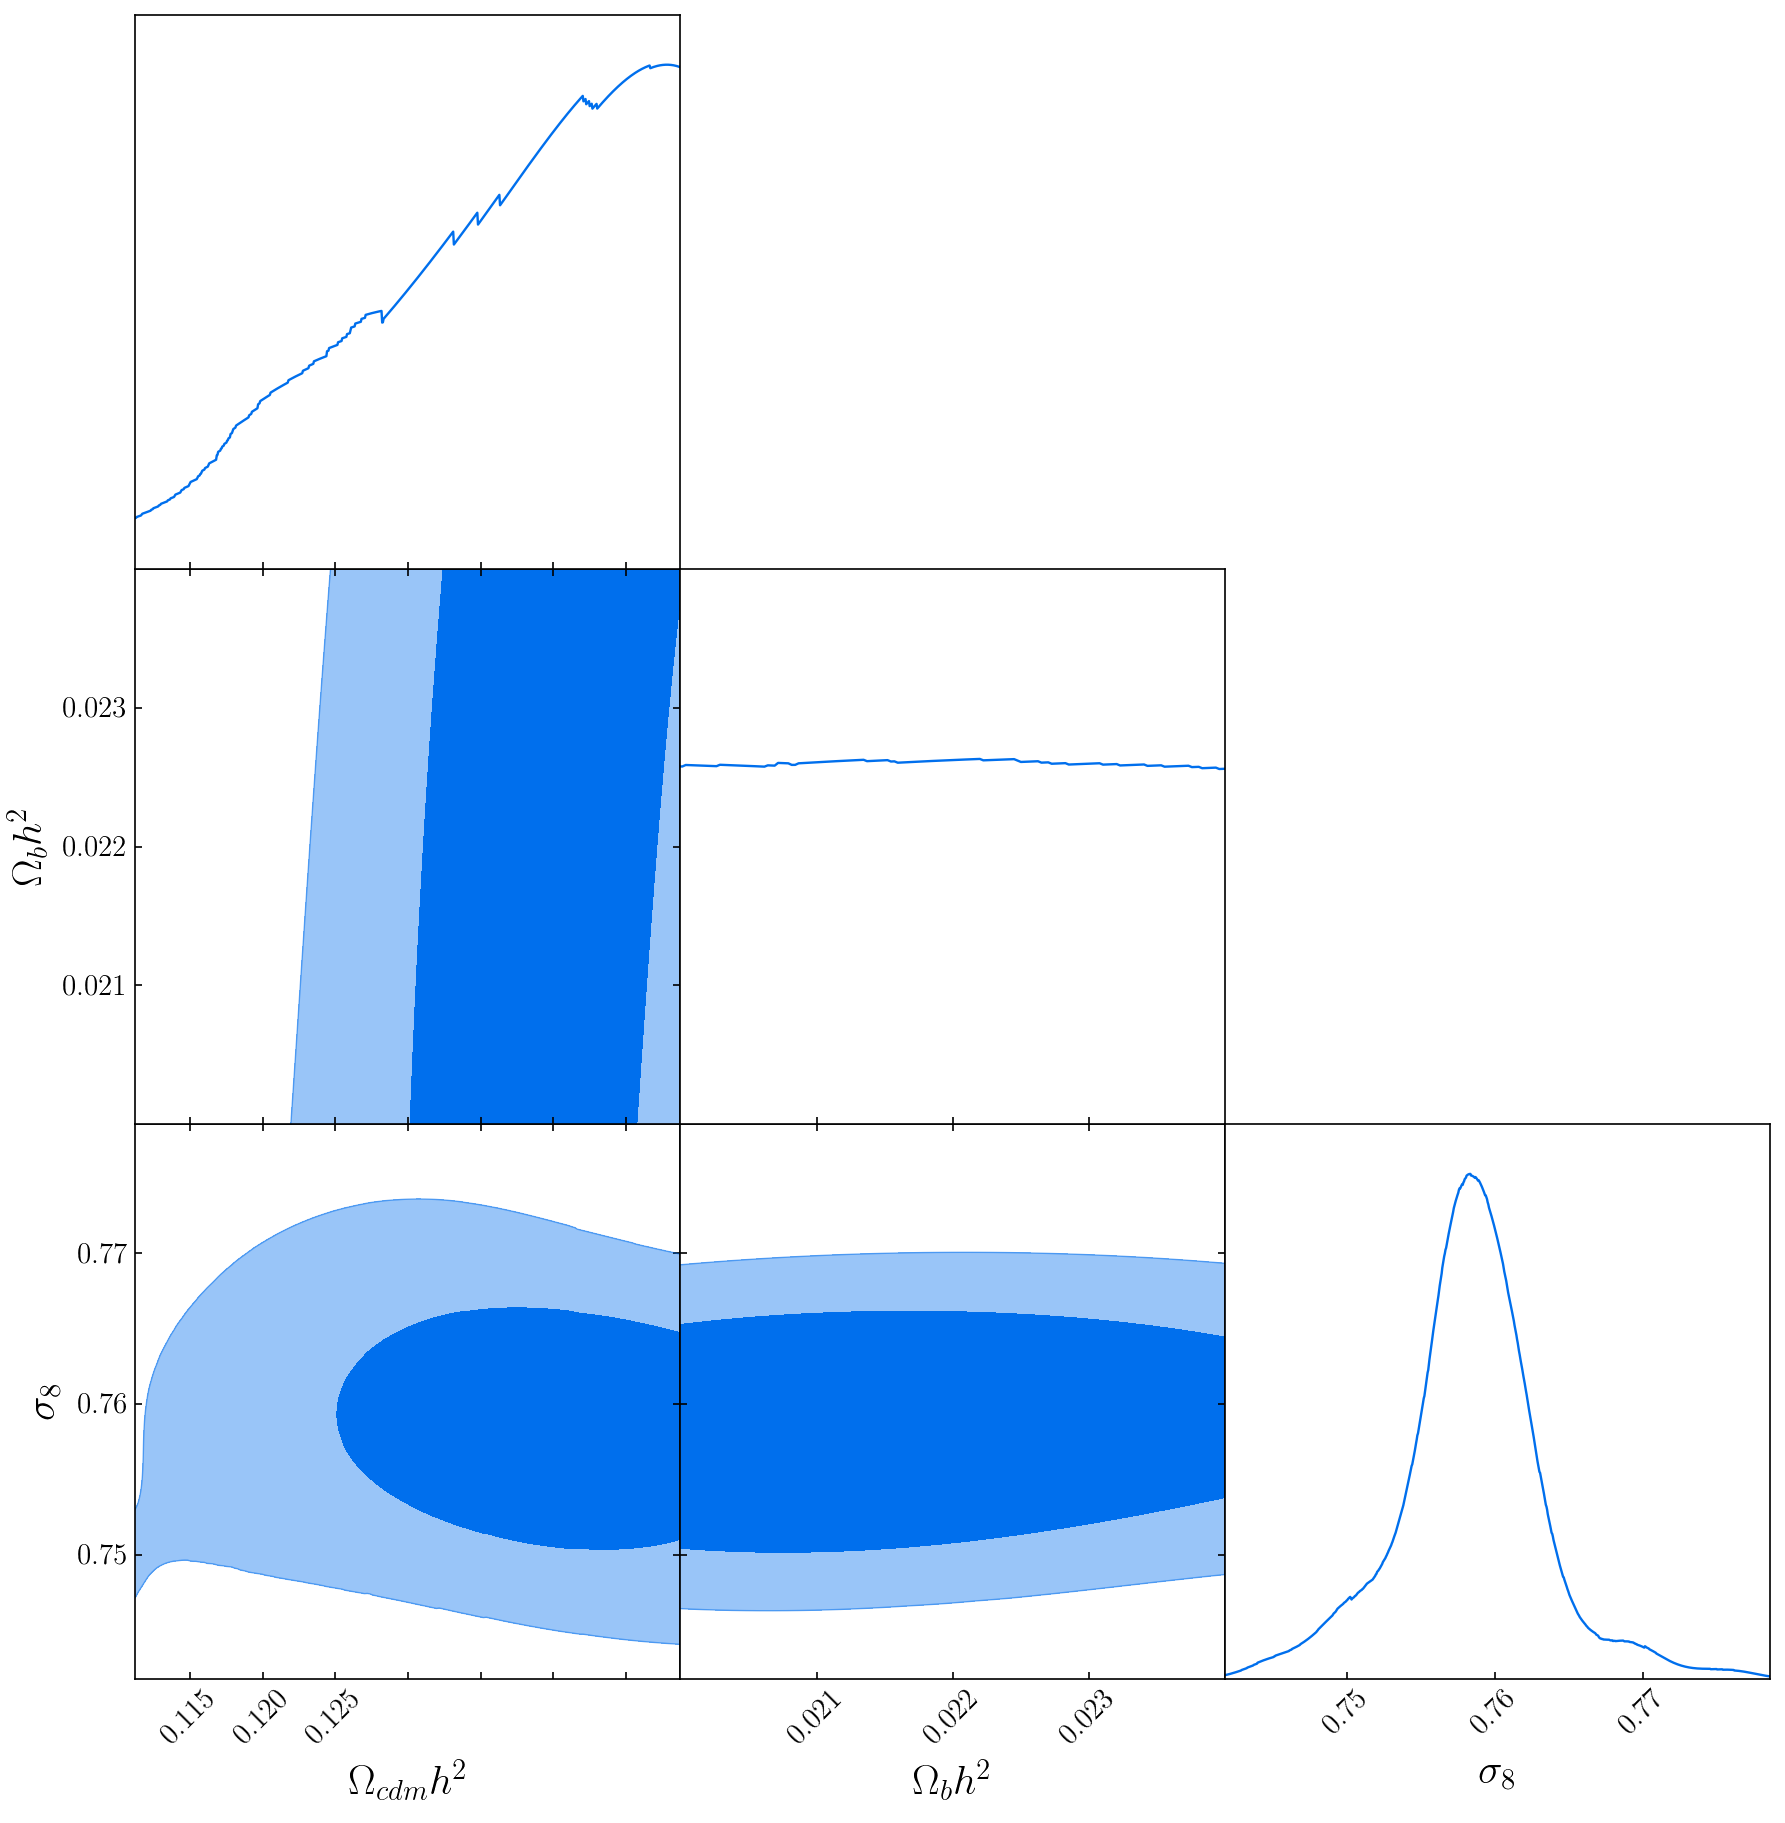

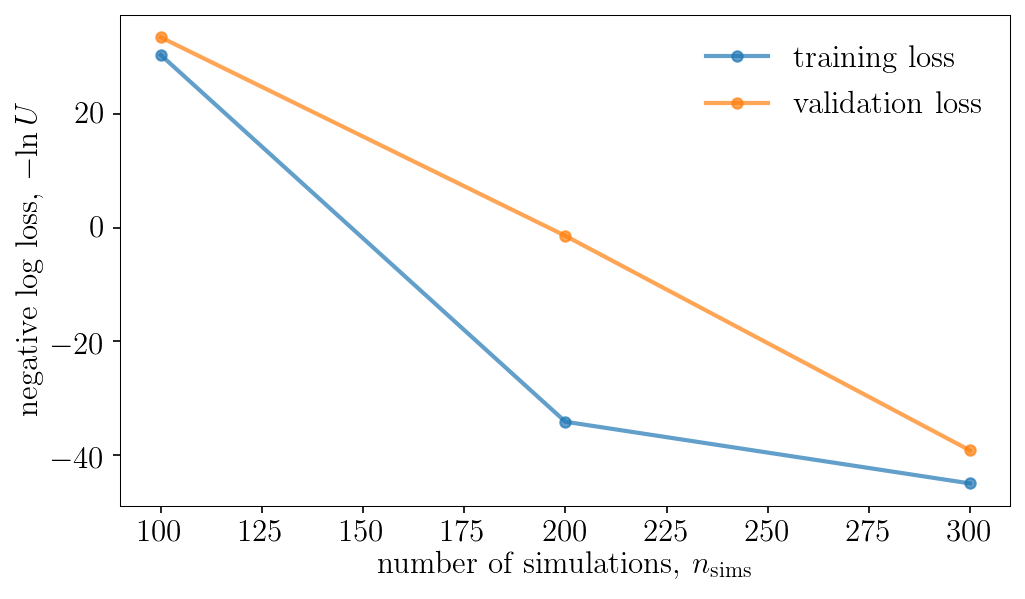

Population 13/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


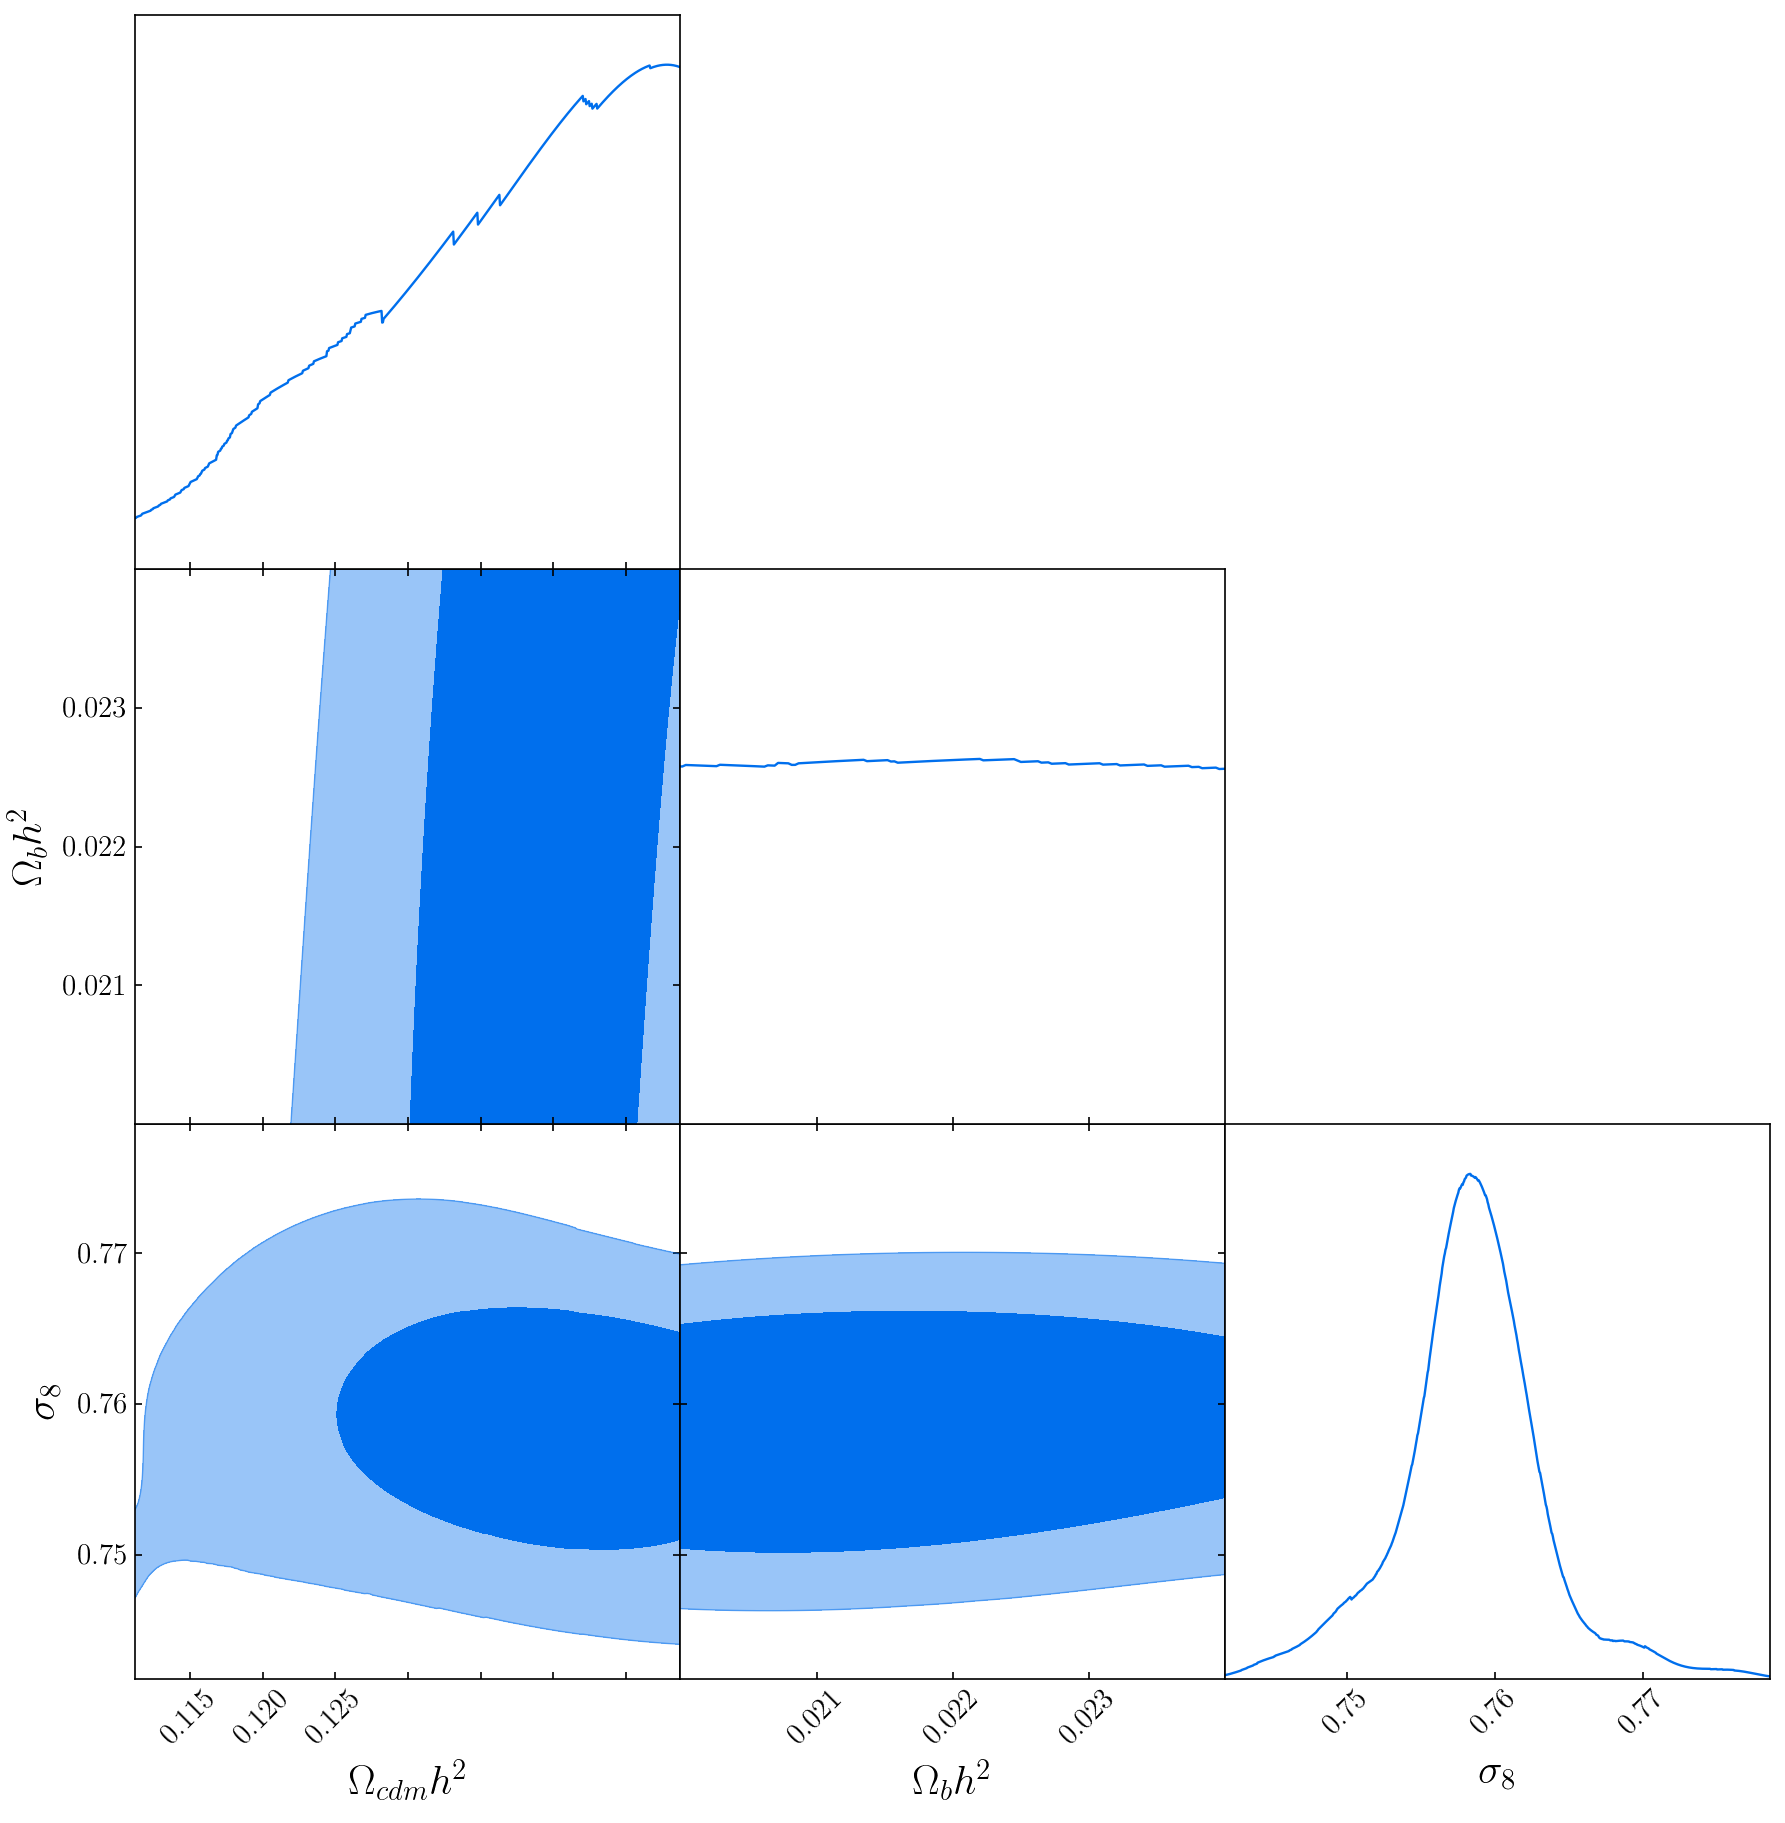

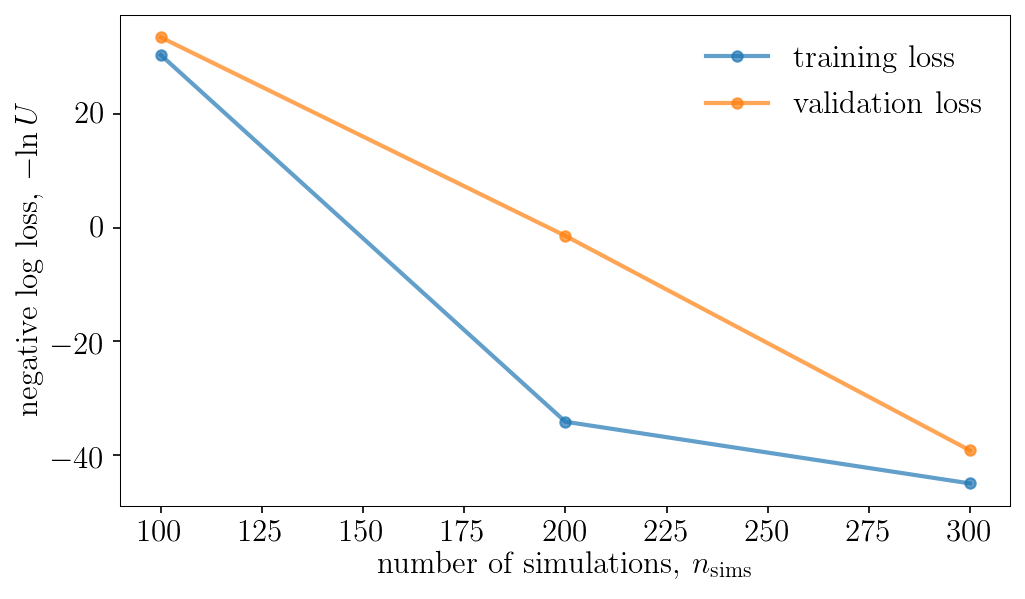

Population 14/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


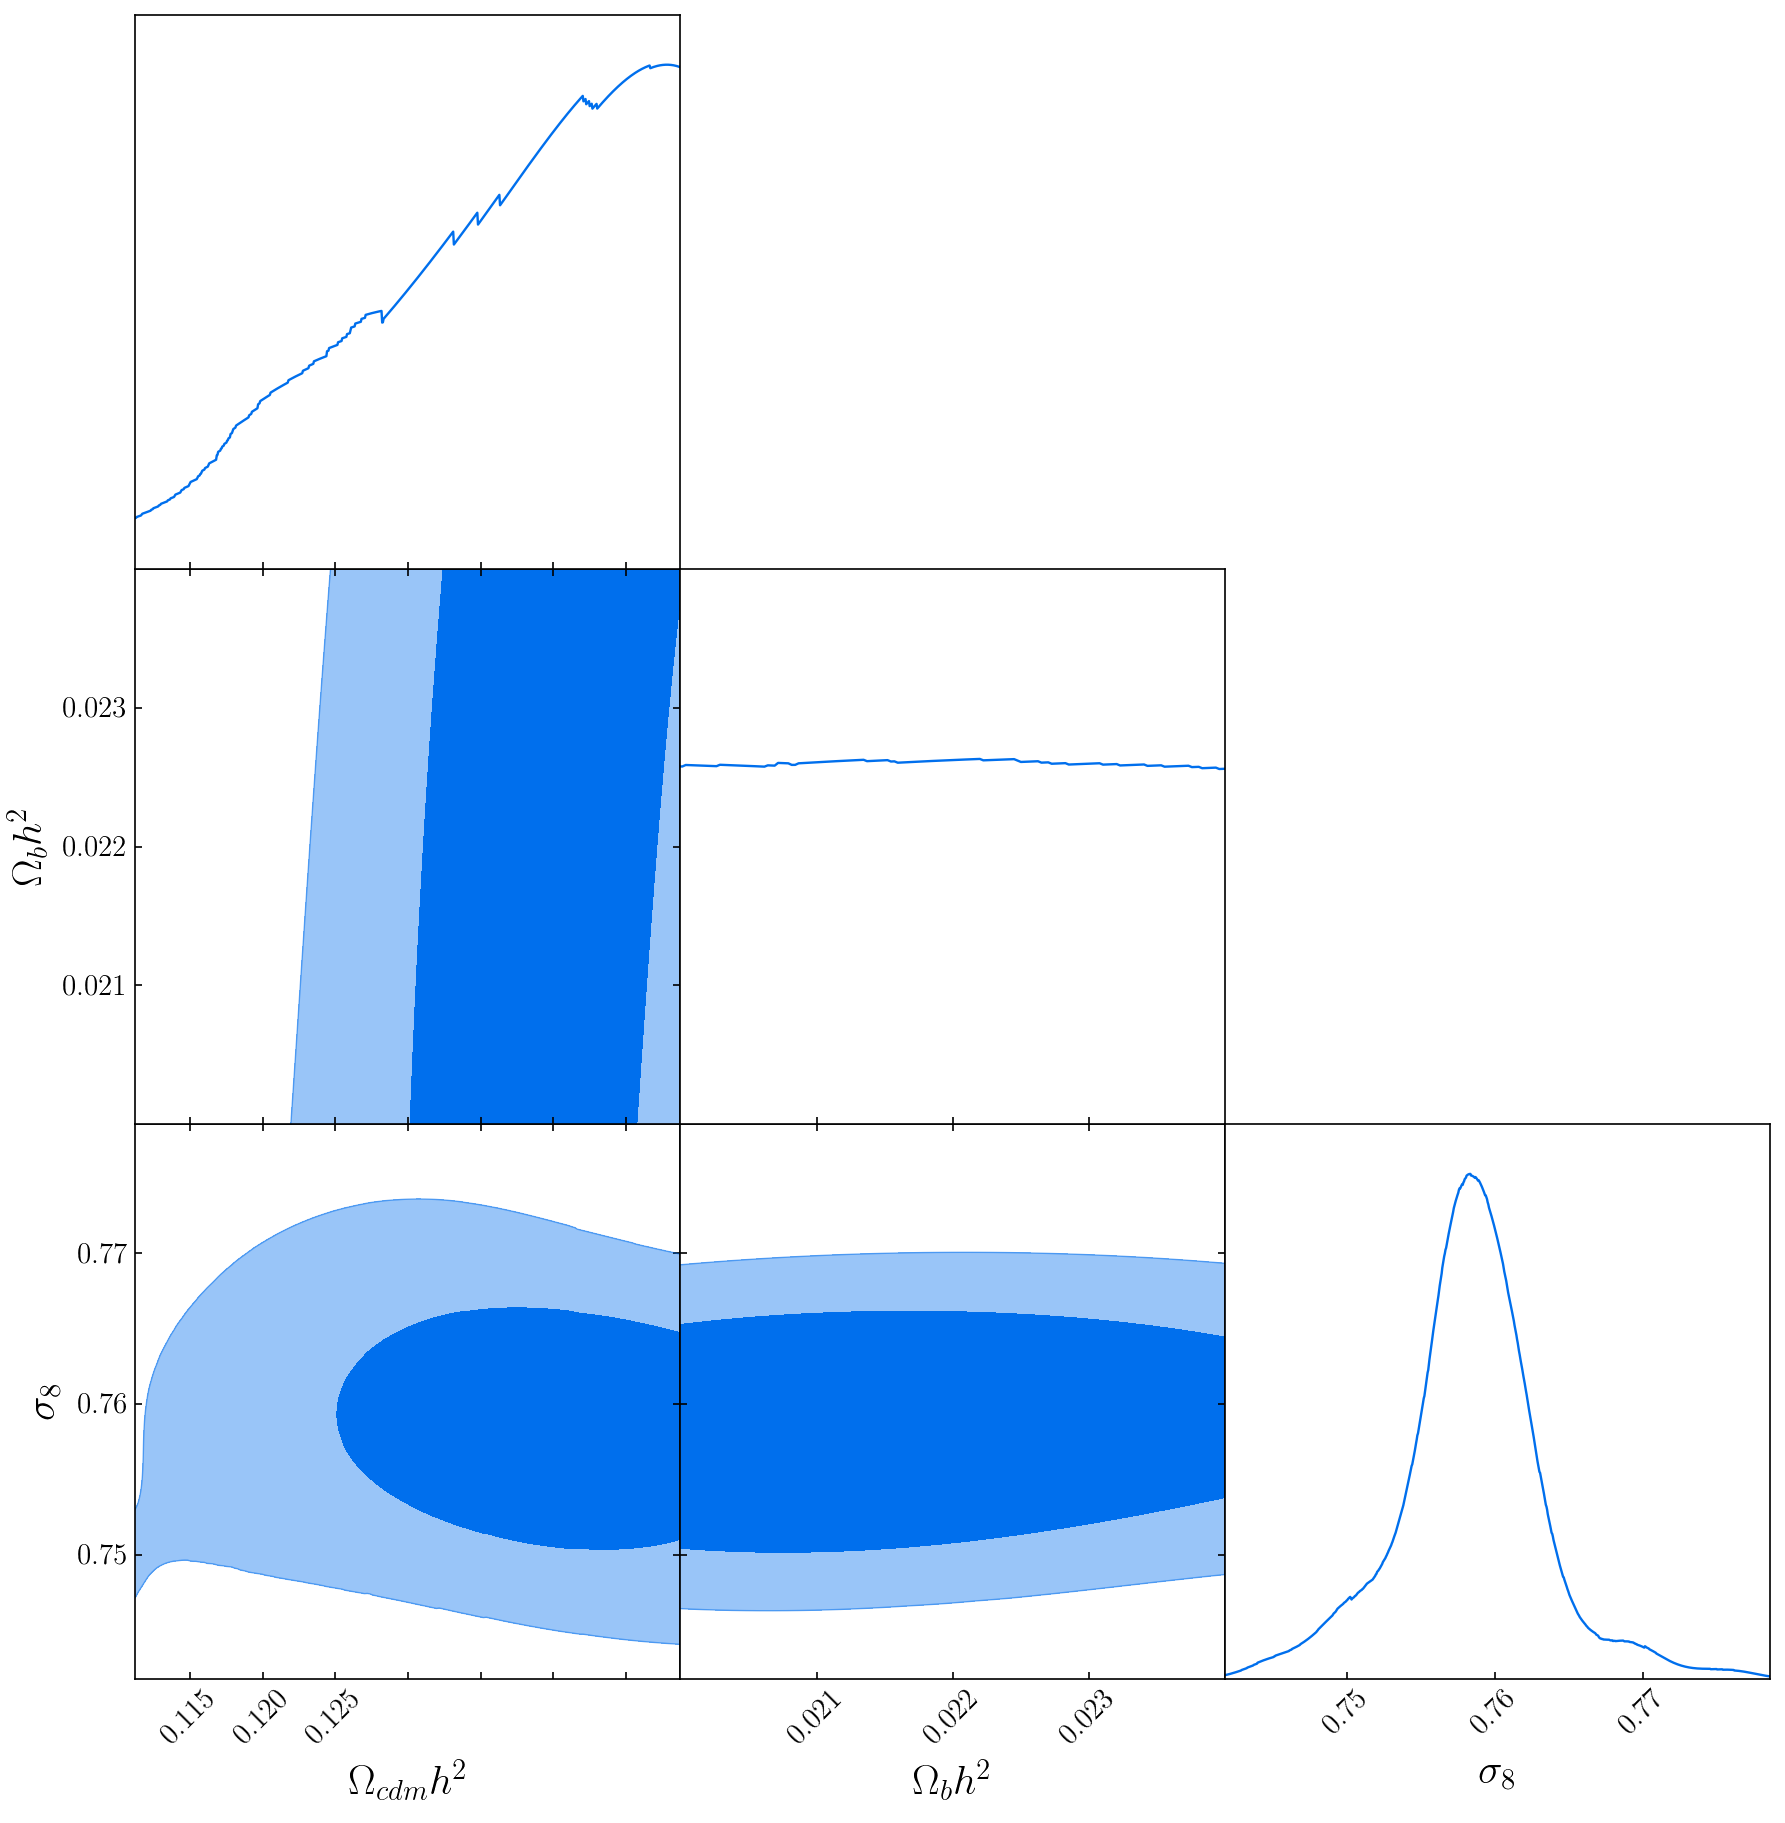

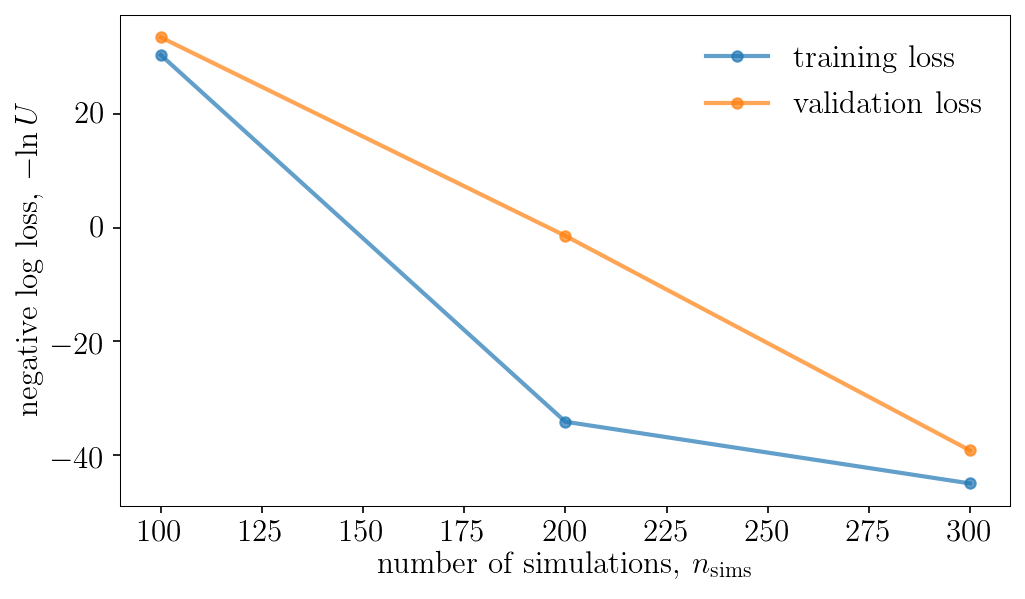

Population 15/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


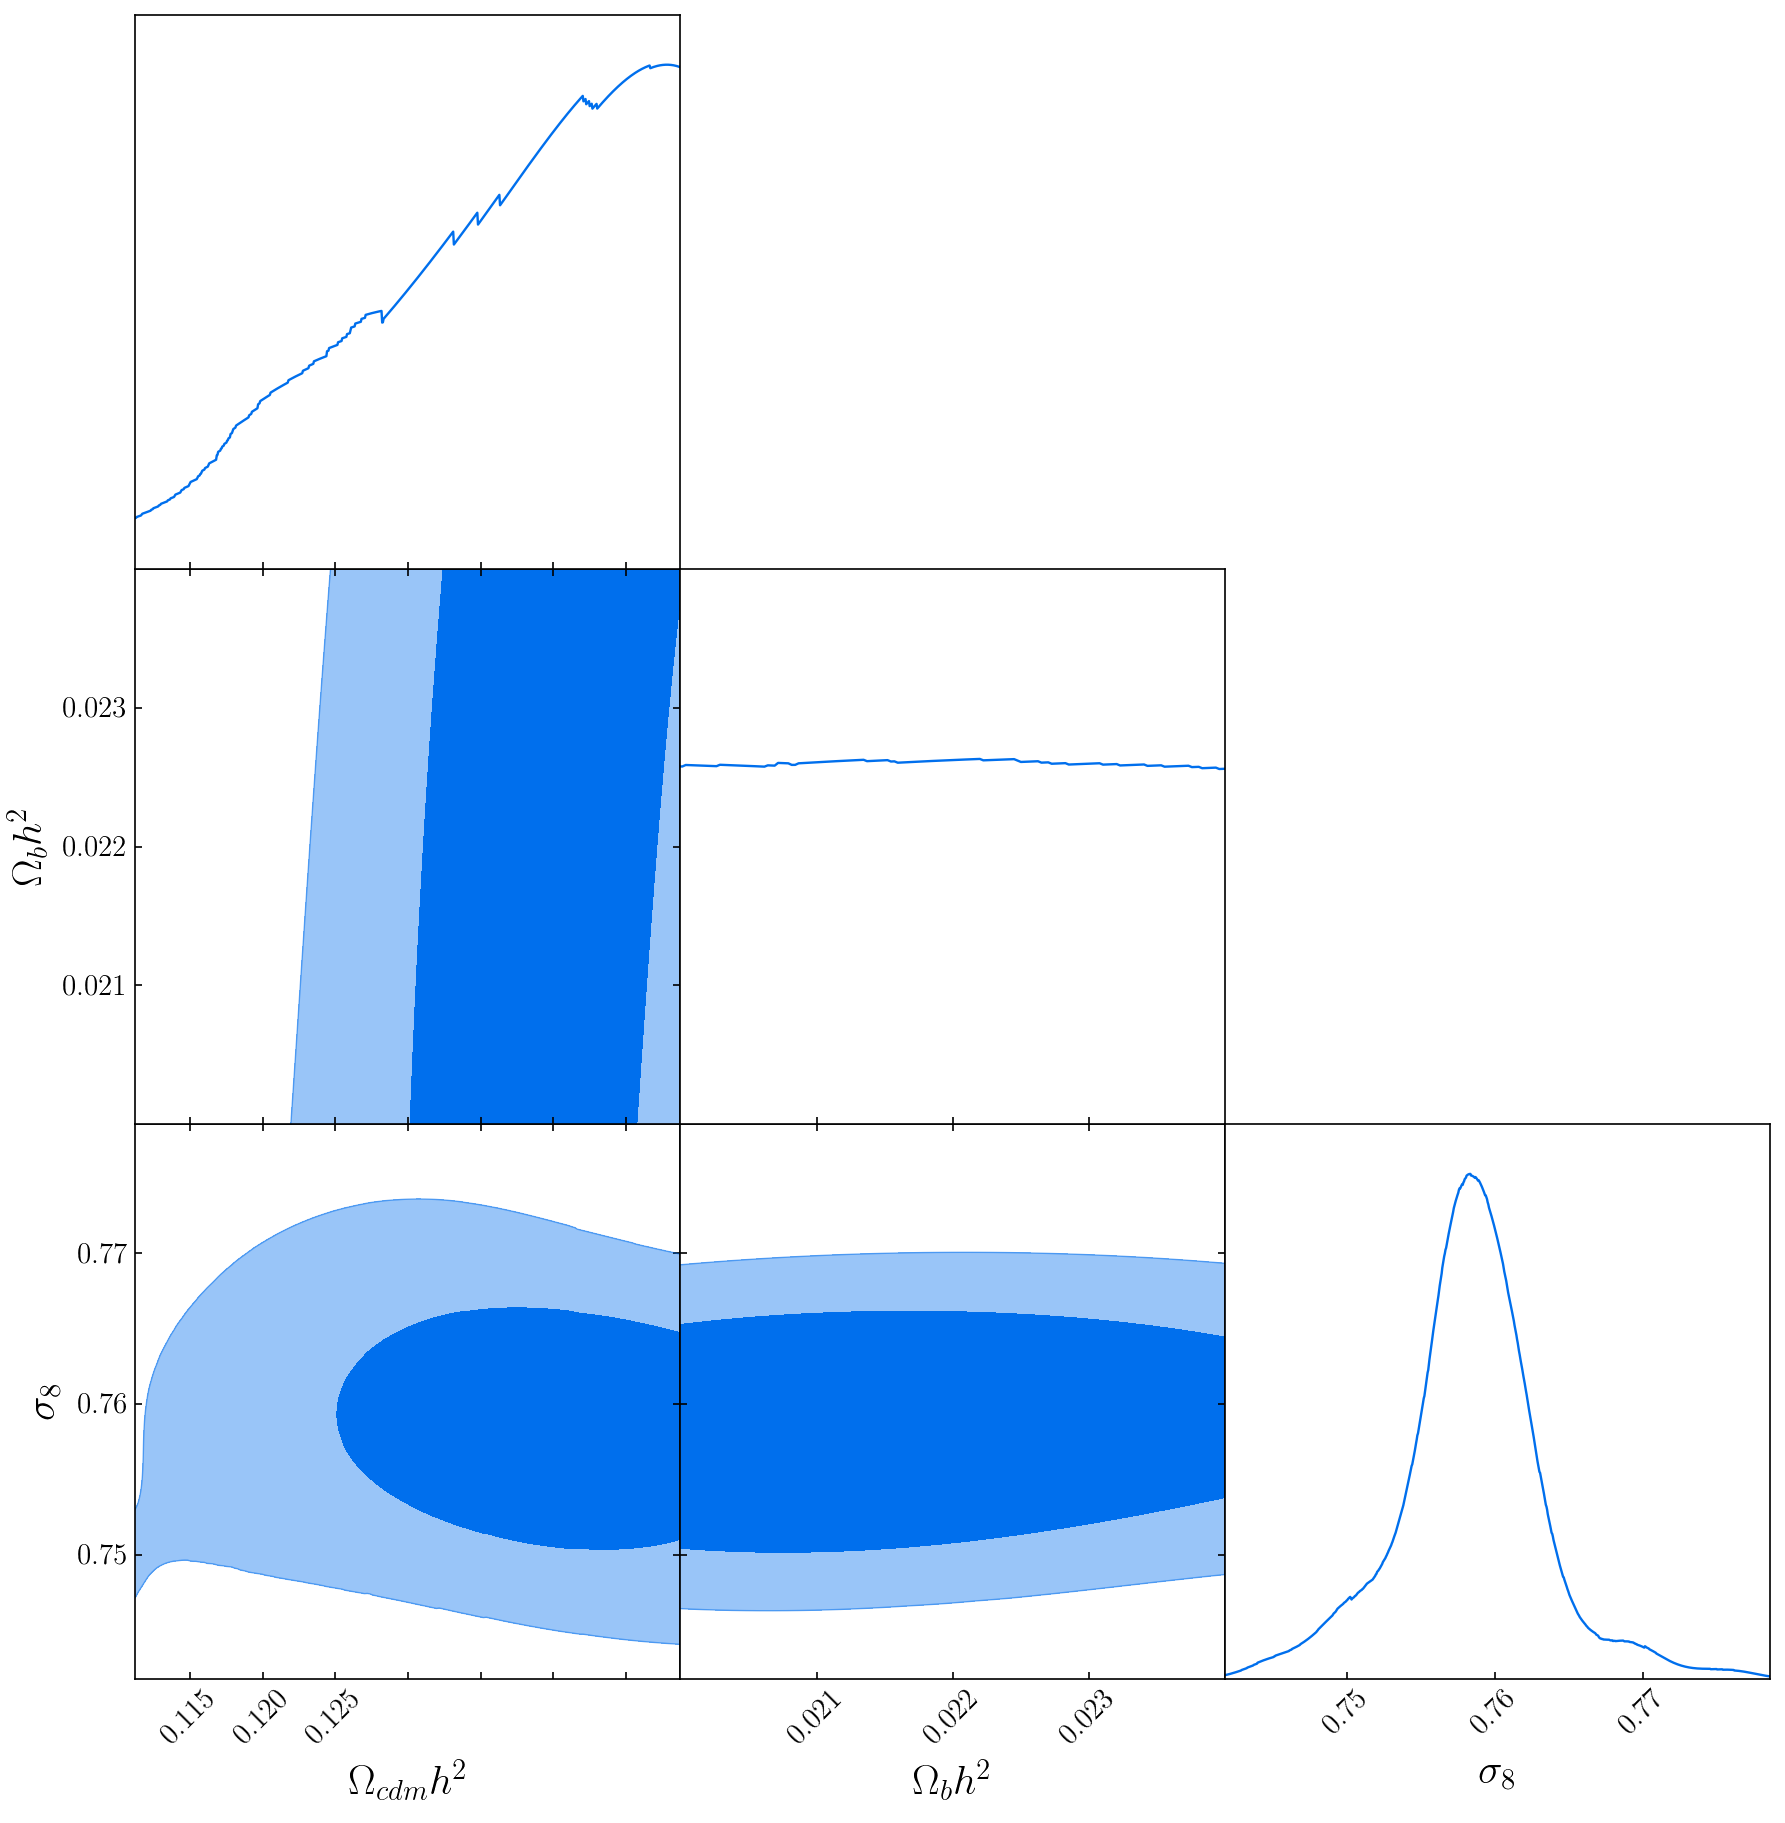

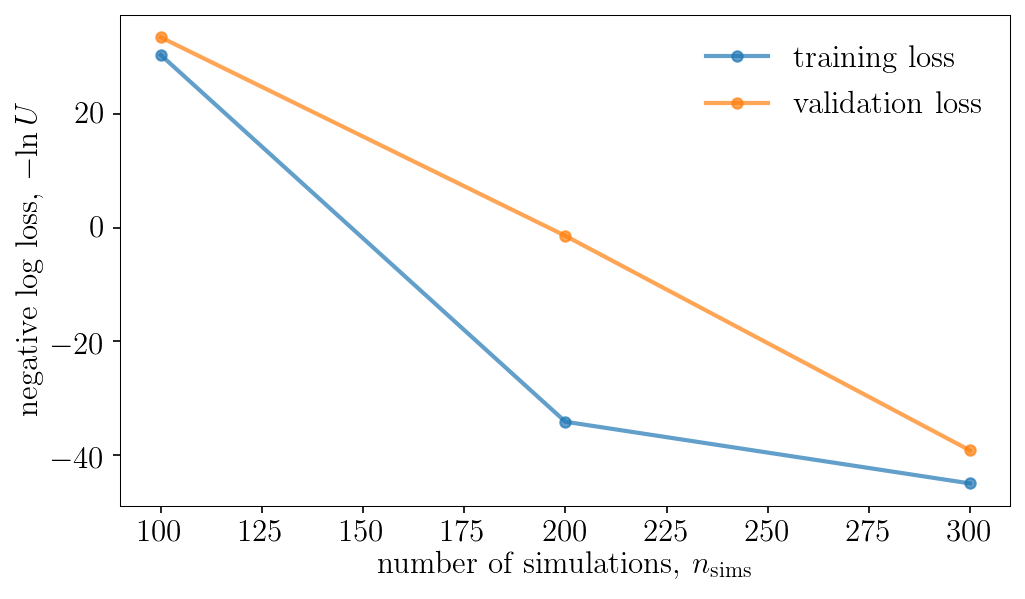

Population 16/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


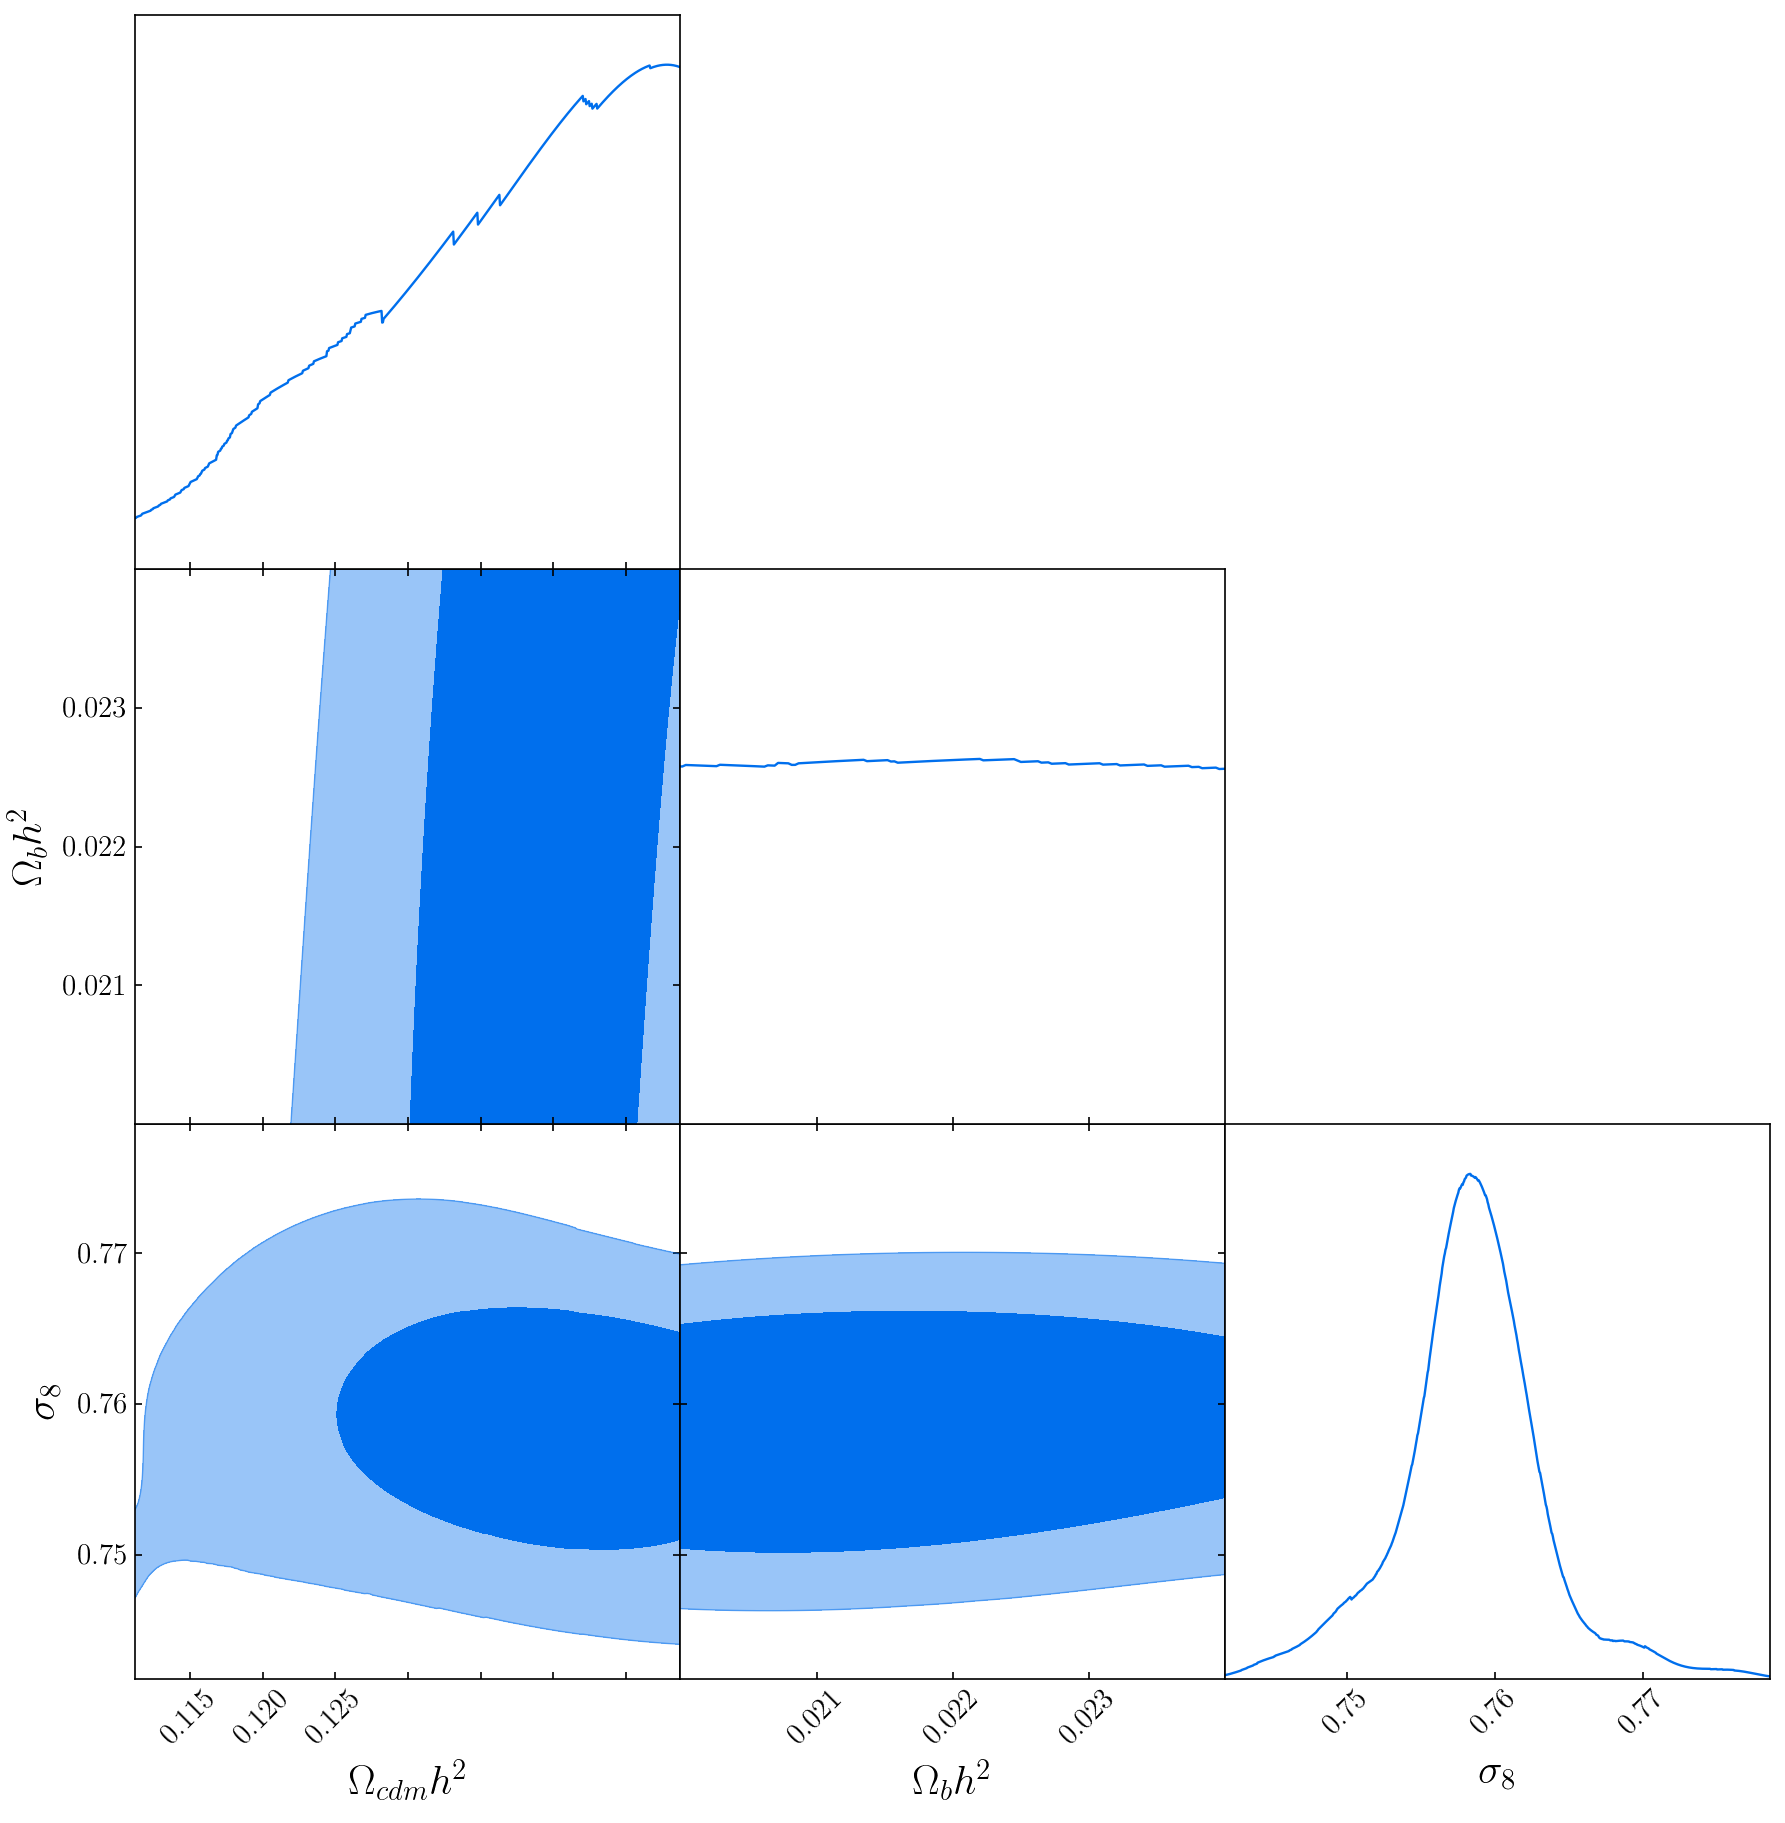

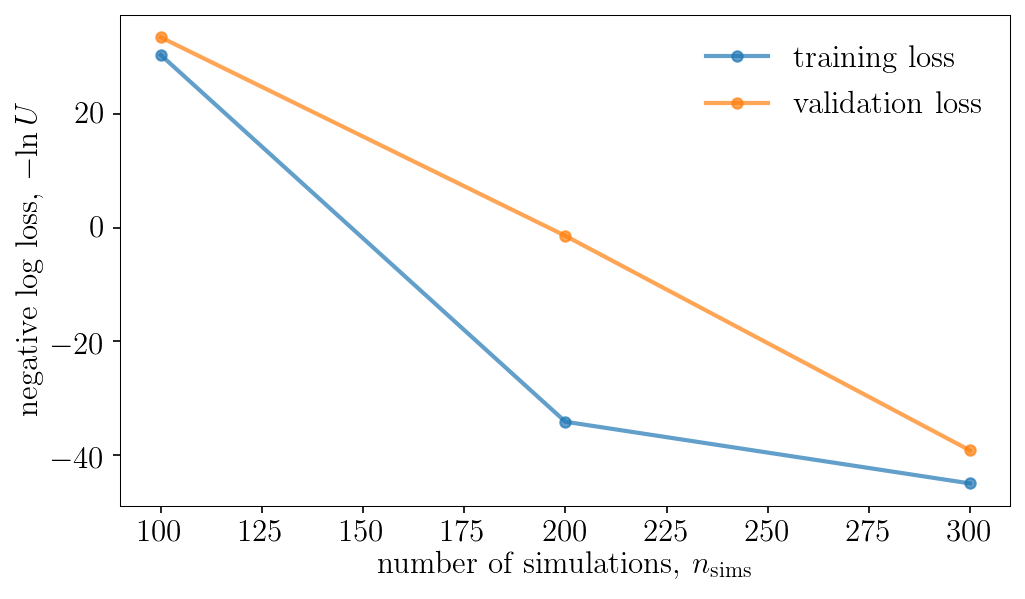

Population 17/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


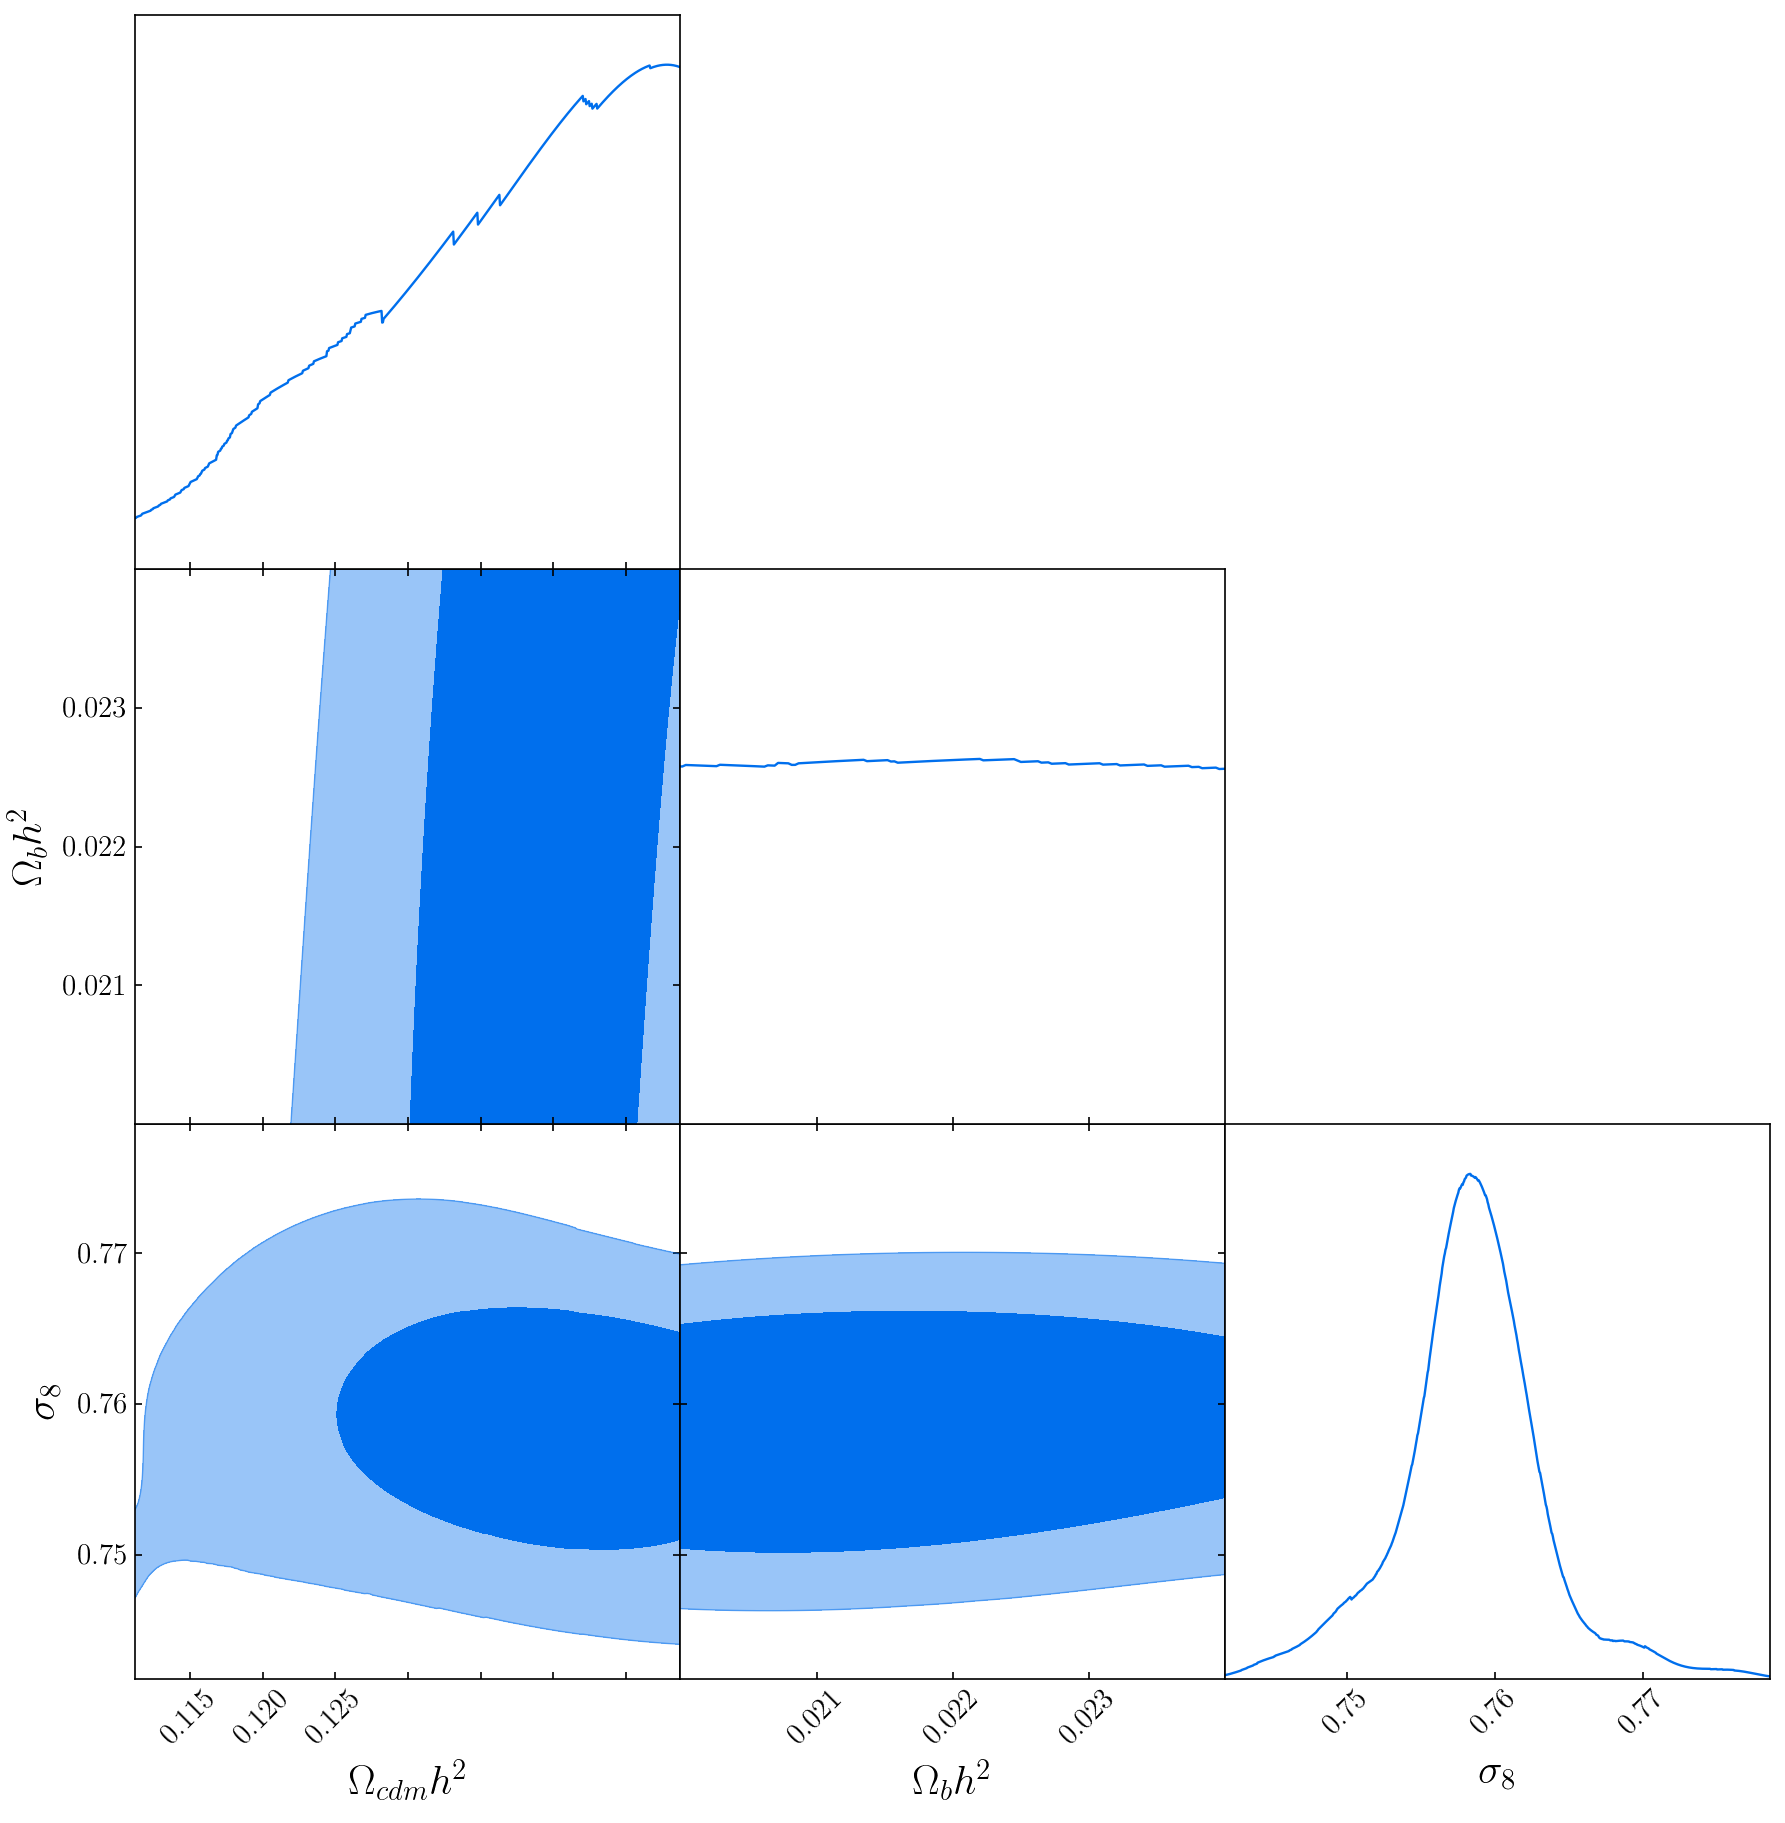

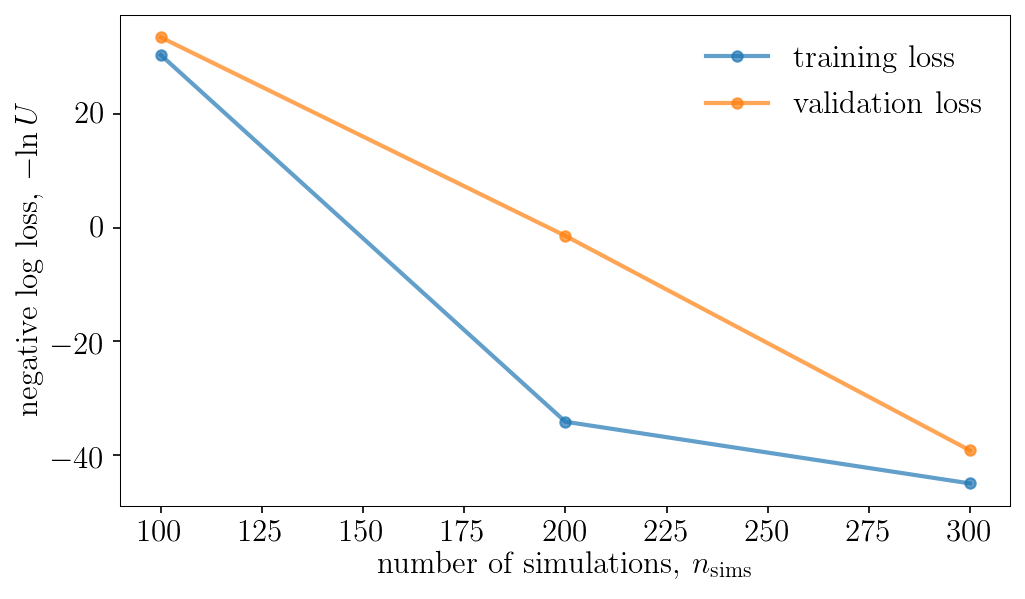

Population 18/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


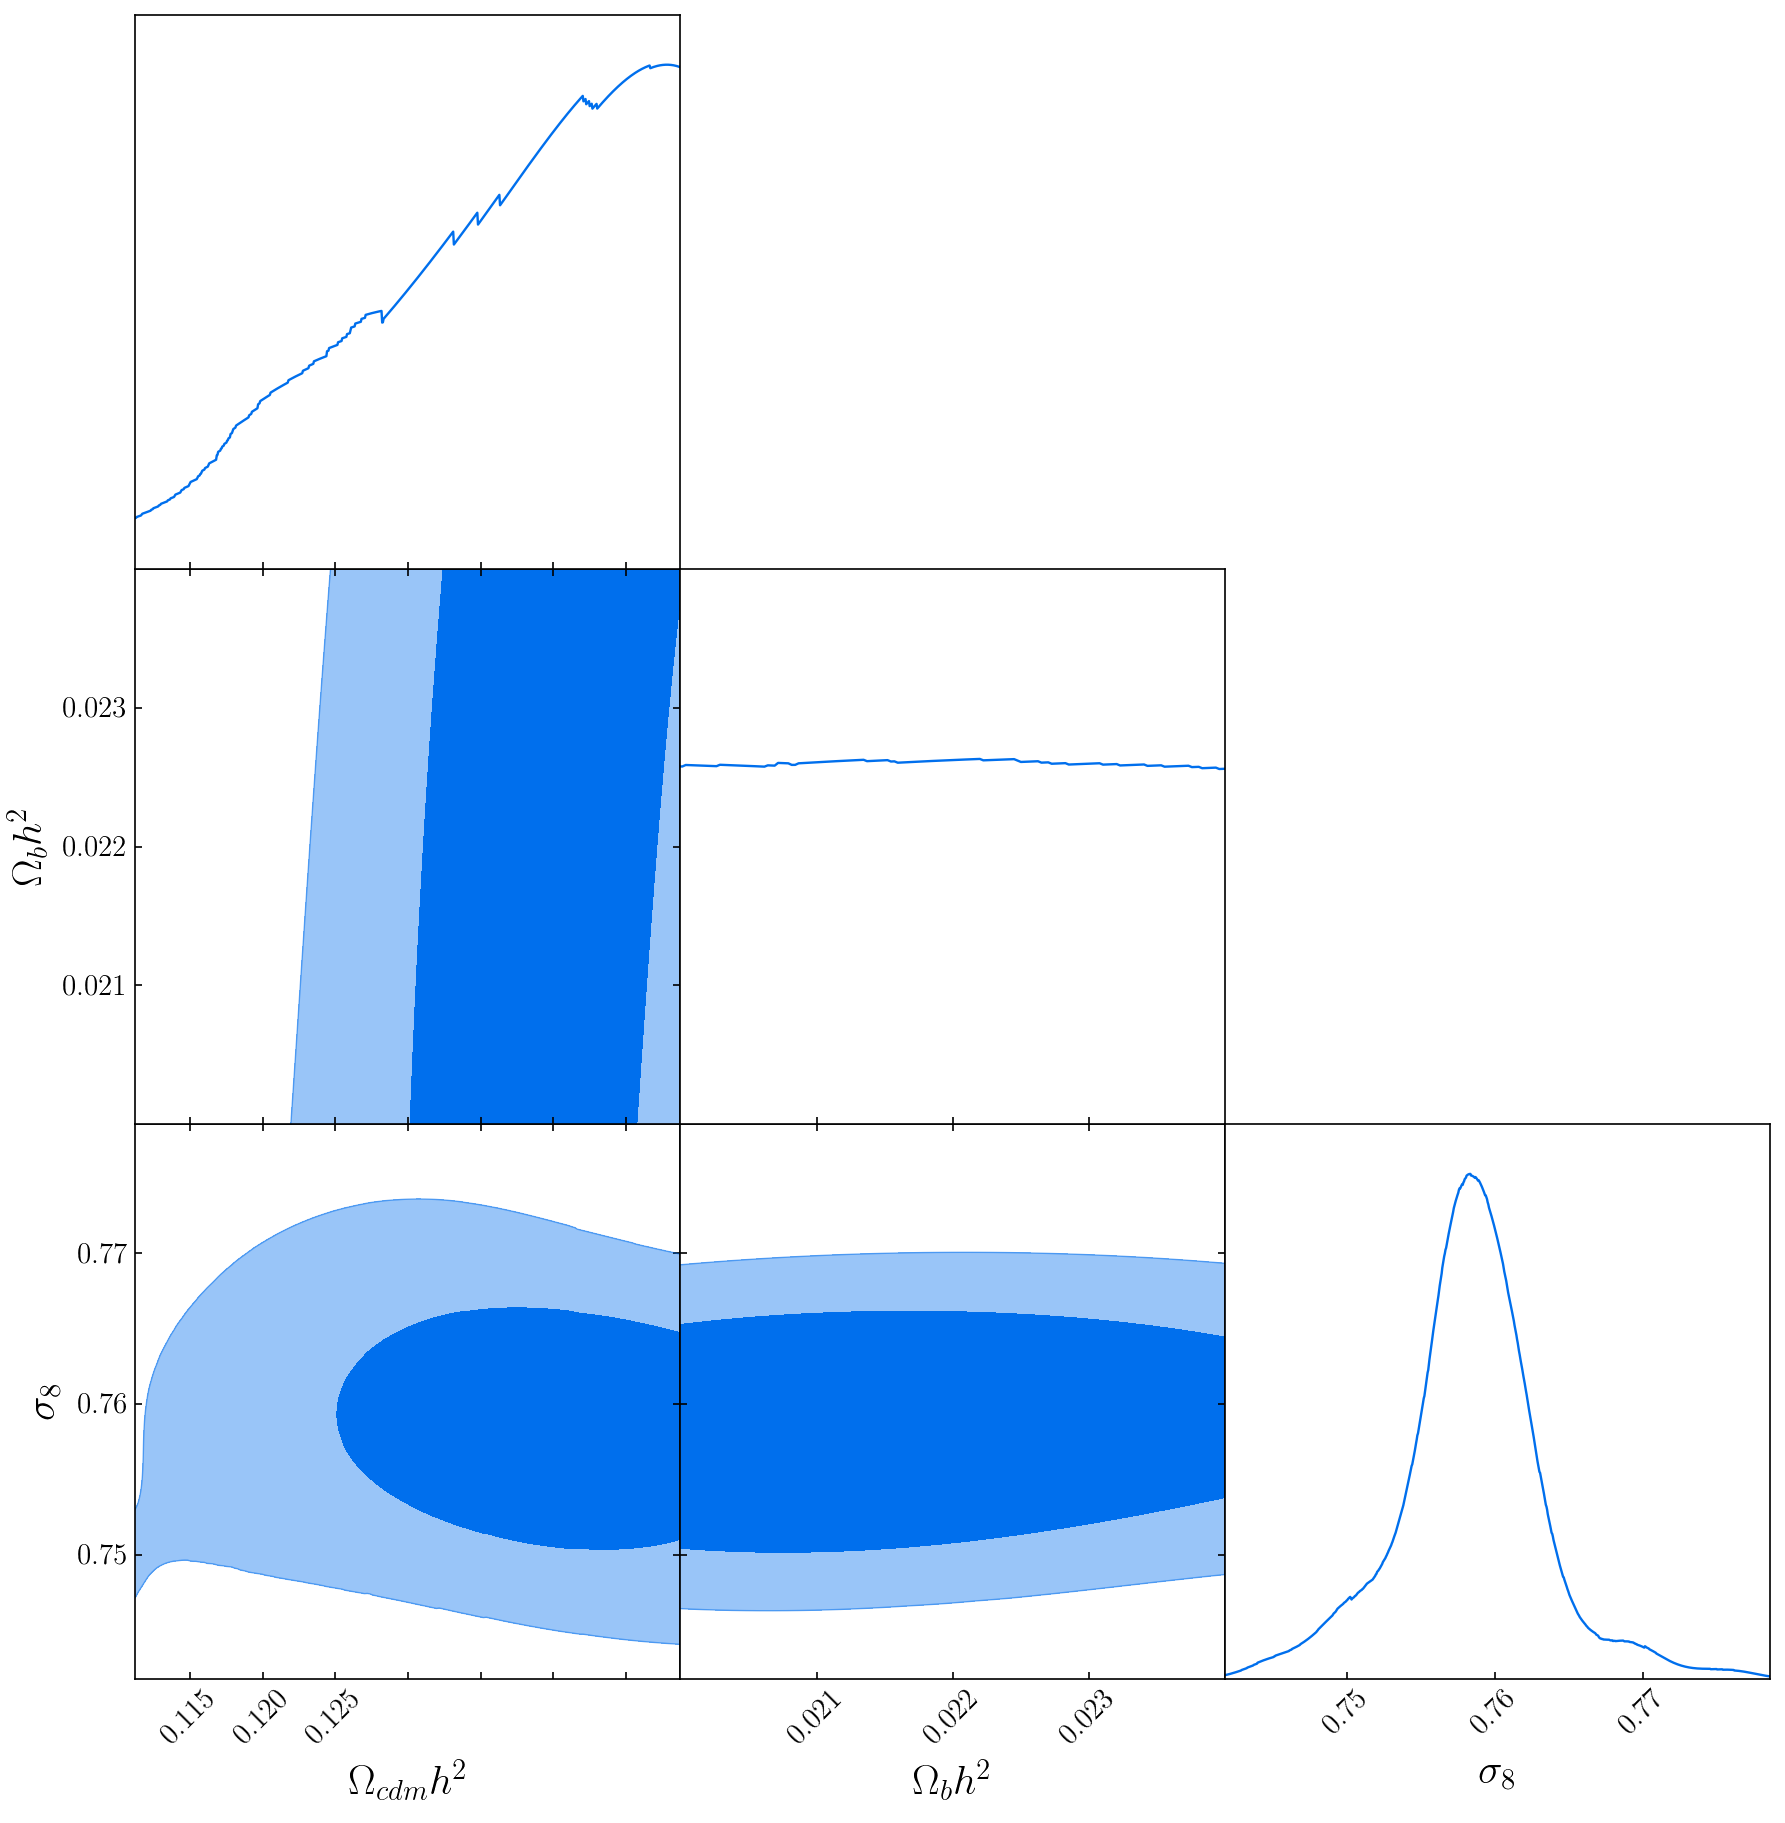

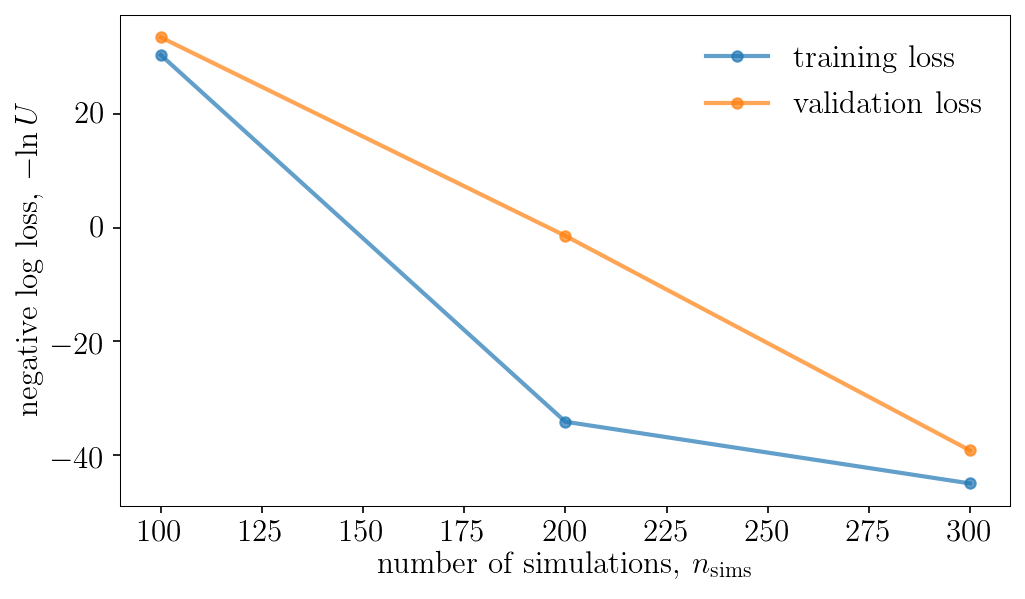

Population 19/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


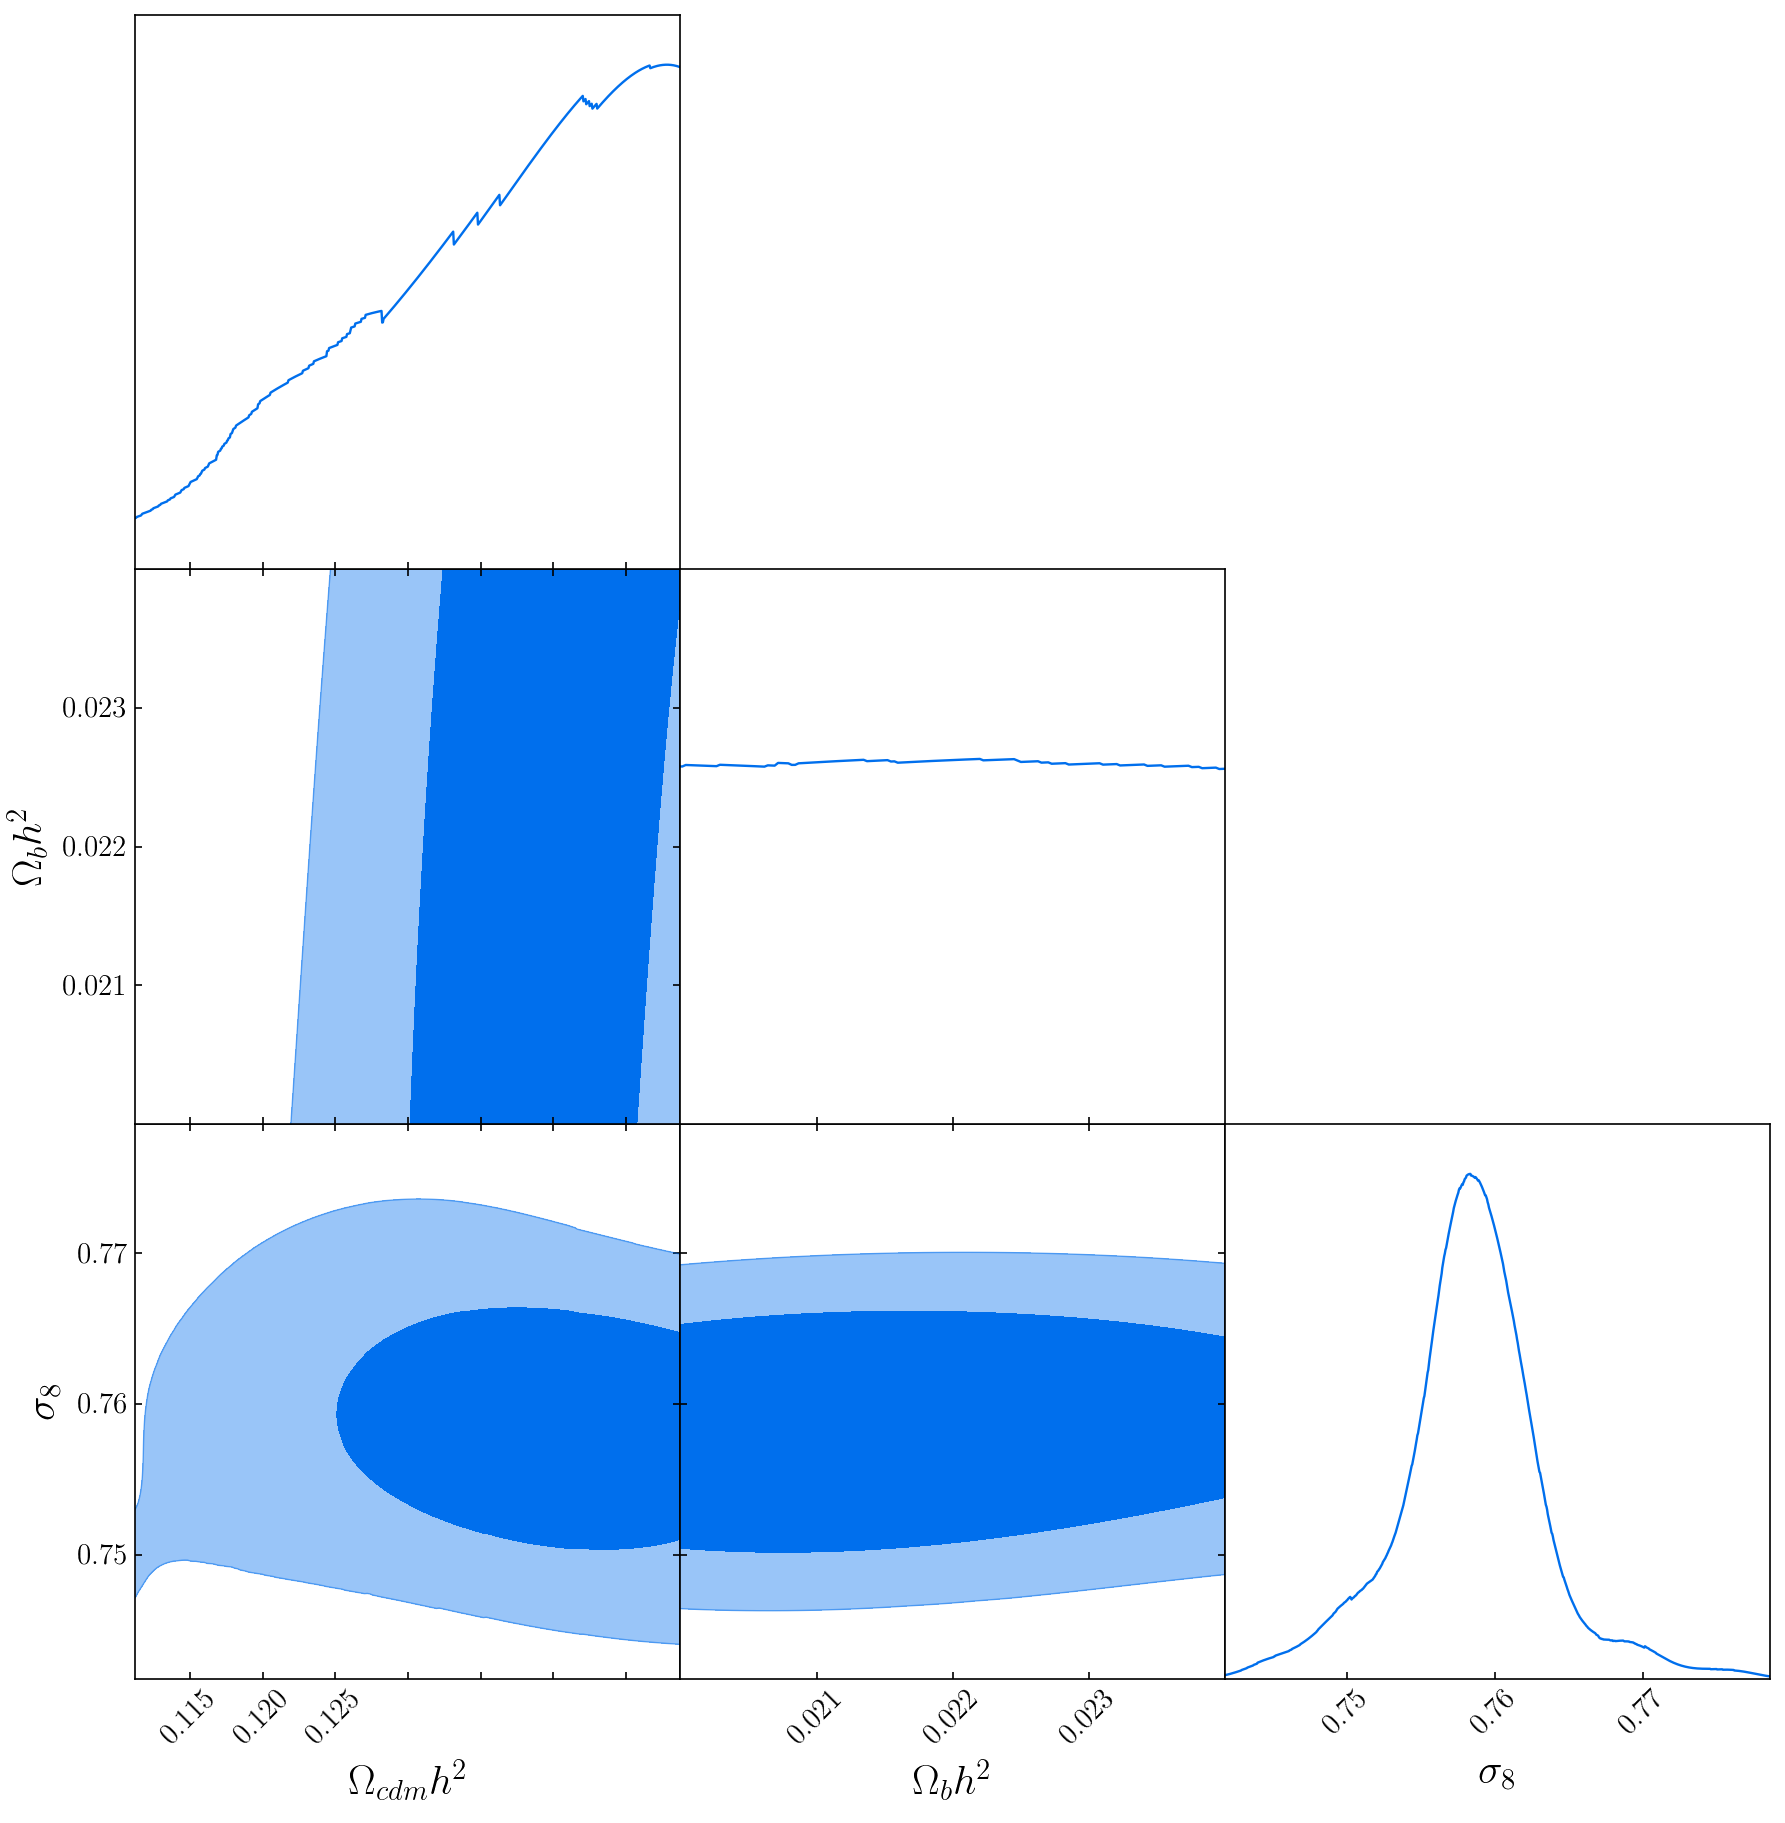

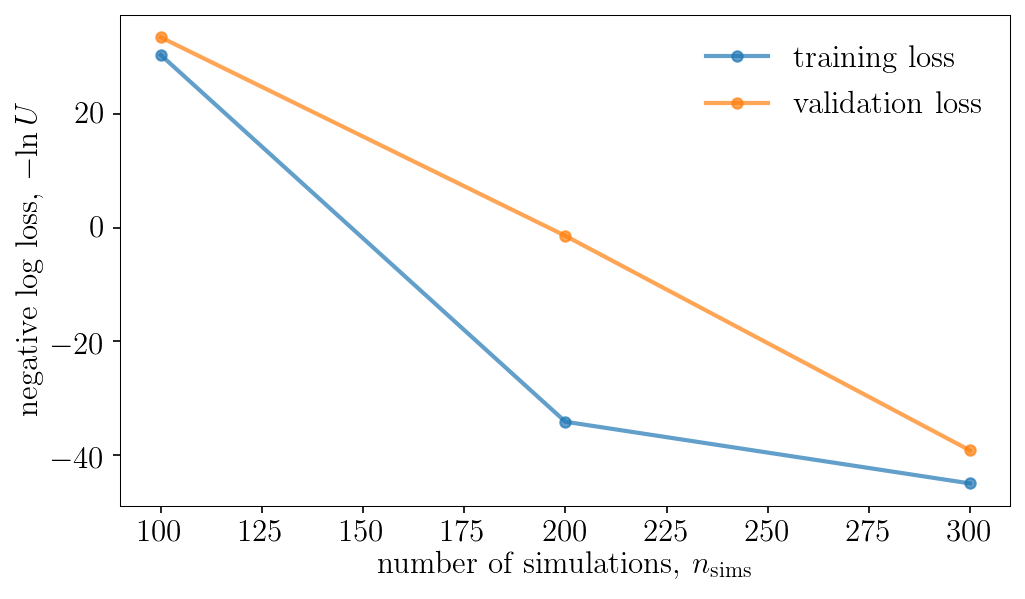

Population 20/20
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Sampling approximate posterior...


Done.
Removed no burn in


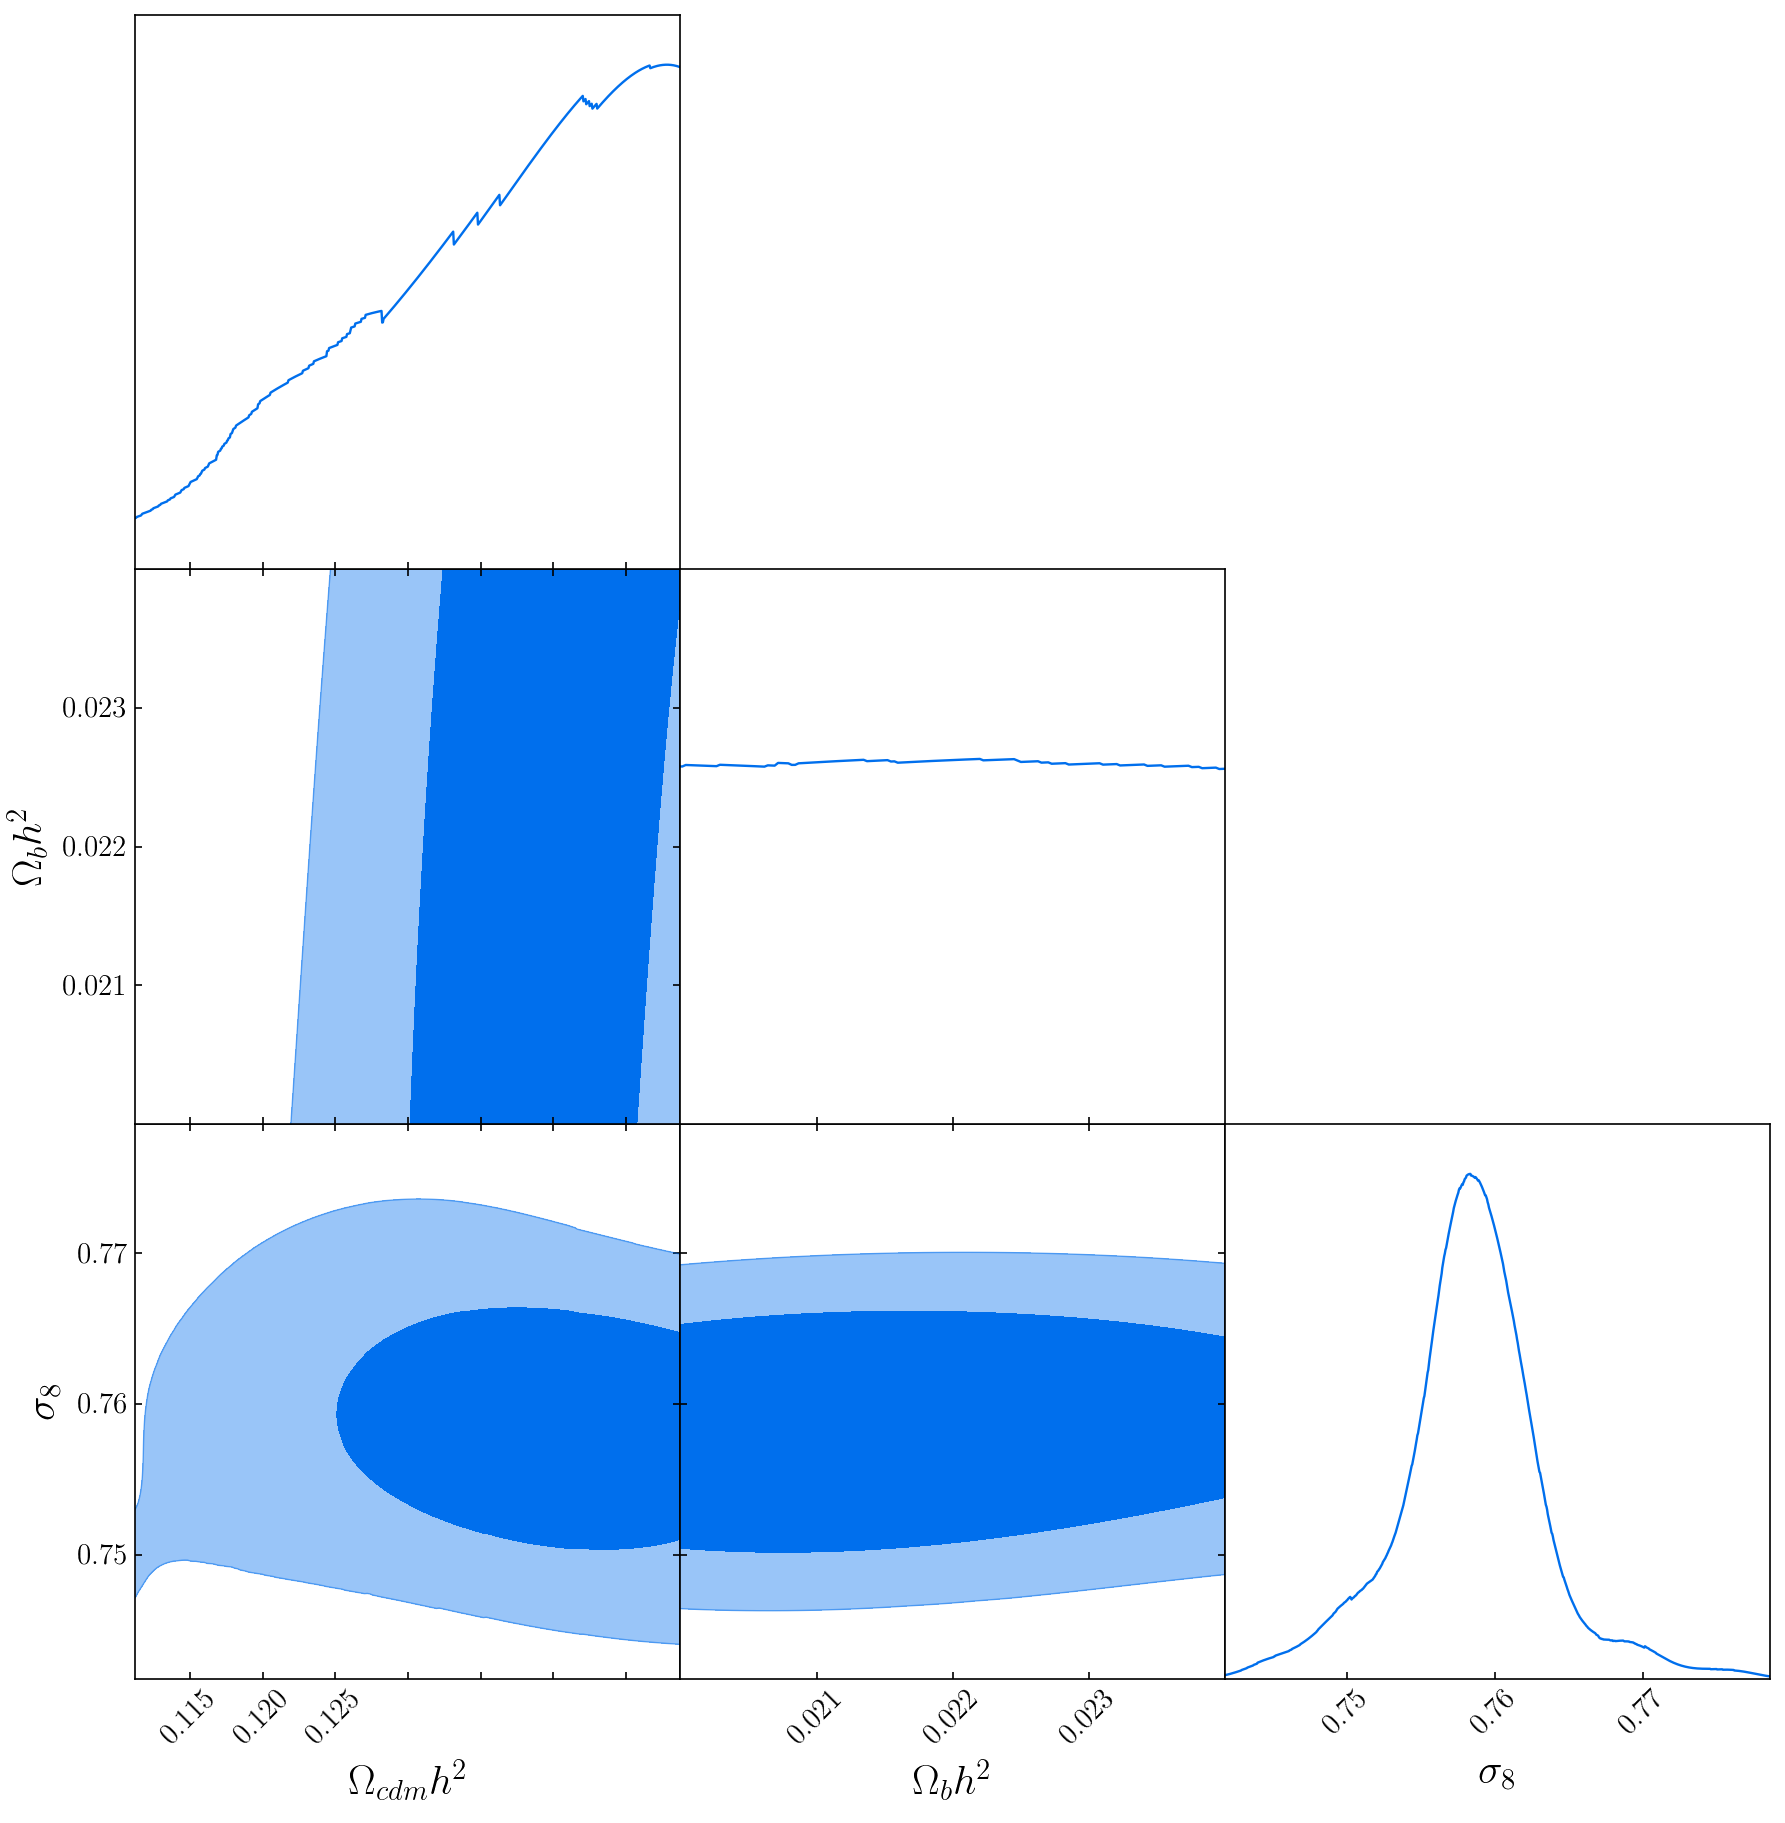

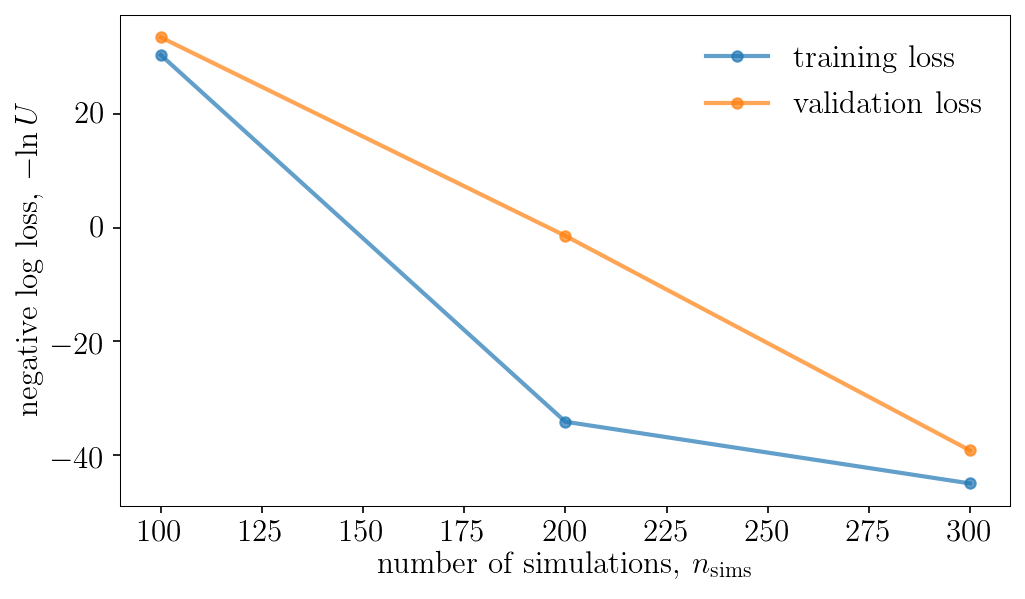

In [30]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20)

In [31]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Removed no burn in


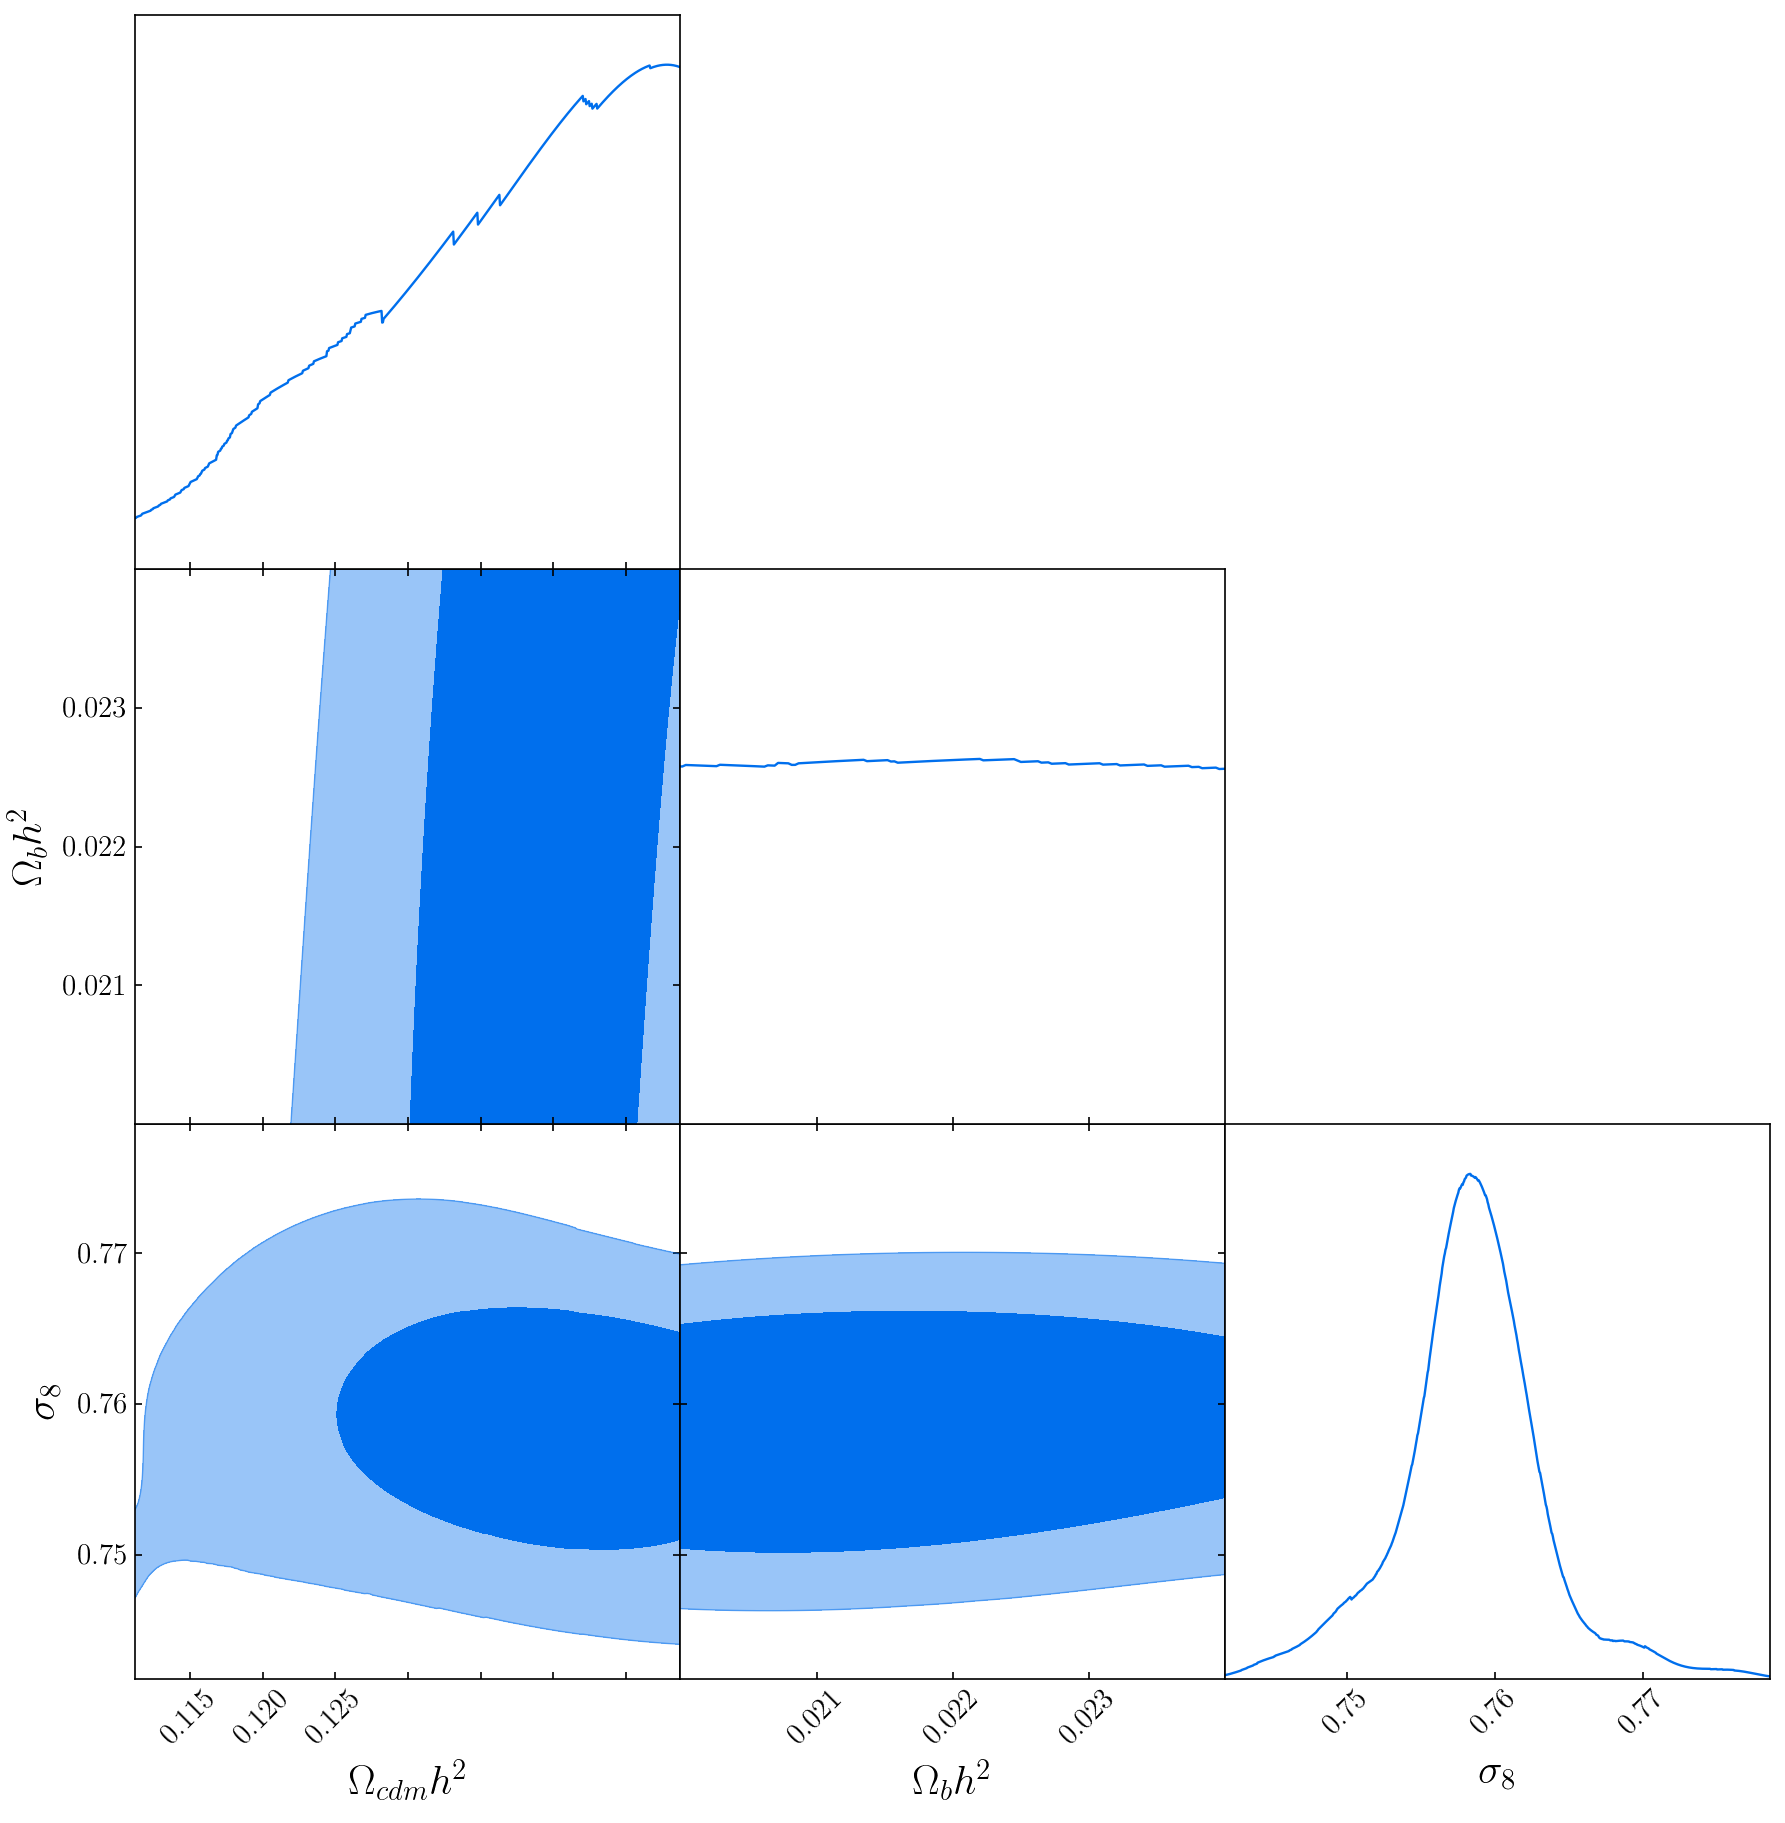

<Figure size 900x600 with 0 Axes>

In [32]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])
plt.savefig('posteriors_3params_20populations.png')

In [33]:
0.02212

0.02212

In [34]:
0.1206

0.1206

In [37]:
0.02212/(0.02212+0.1206)

0.15498878923766815

In [38]:
0.1206/(0.02212+0.1206)

0.8450112107623318